# H-alpha sigma Minus velocities

In [1]:
from astropy.io import fits
import os
from sklearn import preprocessing
import shutil
from astropy.timeseries import LombScargle
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import optimize
from scipy.interpolate import CubicSpline
from scipy.integrate import simps
from scipy.interpolate import UnivariateSpline
from scipy.ndimage import gaussian_filter
import scipy.signal as signal
from astropy.time import Time
import pandas as pd
from lmfit import Model
from PyAstronomy.pyasl import foldAt
from scipy.optimize import curve_fit
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from scipy.ndimage.filters import uniform_filter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import lightkurve as lk
from pylab import rc
from matplotlib import gridspec
from matplotlib import transforms
from matplotlib import colors
from scipy.stats import gaussian_kde
from pylab import *
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times']

In [2]:
JJDF = pd.read_csv('PTO/1/100.xls', delimiter='\t')
JJTimes = JJDF['JD_UTC']
JJFlux = JJDF['rel_flux_T1']
err = JJDF['rel_flux_err_T1']
JJFlux = JJFlux/np.median(JJFlux)

dat = np.array([JJTimes, JJFlux, err])
a = np.column_stack((dat))
np.savetxt('GD356PTOg.dat', a, delimiter='\t')

In [2]:
def straightLine(xpoints,ypoints,inXpoints):
    gradient = (ypoints[1]-ypoints[0])/(xpoints[1]-xpoints[0])
    intercept = ypoints[0] - (gradient*xpoints[0])
    outYpoints = (inXpoints*gradient)+intercept
    return outYpoints
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def area_est(xpoints, ypoints, start, finish):
    
    startIdx = find_nearest(xpoints, start)
    finishIdx = find_nearest(xpoints, finish)
    xpoints = xpoints[startIdx:finishIdx]
    ypoints = ypoints[startIdx:finishIdx]
    areaEst = np.trapz(ypoints, x=xpoints)
    #offset = np.abs(min(ypoints))
    #ypoints = ypoints + offset
    #dx = xpoints[2]-xpoints[1]
    #areaEst = 0
    #for i in range(len(ypoints)-1):
        #areaEst = areaEst + ((ypoints[i]+ypoints[i+1])*dx/2)
    return areaEst
xpoints=np.linspace(0,4200,4200)
def median_average(array, N):
    result = []
    for i in range(0, int(np.shape(array)[0]/N)+1):
        tmparray = array[i*N:(i*N+N)]
        tmparray = np.median(tmparray,axis=0)
        if i == 0:
            result = tmparray
            
        else:
            result = np.vstack([result, tmparray])
            
    return result


def f(x, c, q,A, B): 
    return c*x*x*x + q*x*x + A*x + B

def f2(x, d,c, q,A, B): 
    return d*x*x*x*x + c*x*x*x + q*x*x + A*x + B
def f3(x, c, q,A): 
    return c*x*x + q*x + A

def f5(x, c, q,A,b,d,z): 
    return c*x*x*x*x*x + q*x*x*x*x + A*x*x*x + b*x*x + d*x+z

def foldMeth(timeArray, period):
    phases = []
    for el in timeArray:
        passed = int(el/period)
        leftover = el - (passed*period)
        phase = leftover/period
        phases.append(phase)
    return np.array(phases)


In [34]:
lc = lk.search_lightcurvefile('PG0010+281', sector=17).download()#.remove_nans()

In [35]:
lc.header()

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
SIMDATA =                    F / file is based on simulated data                
ORIGIN  = 'NASA/Ames'          / institution responsible for creating this file 
DATE    = '2020-04-11'         / file creation date.                            
TSTART  =    1764.688977137316 / observation start time in BTJD                 
TSTOP   =    1789.695411042226 / observation stop time in BTJD                  
DATE-OBS= '2019-10-08T04:30:

In [25]:
tpf = lk.search_targetpixelfile('GD1400', sector=3).download()
CROWDSAP = tpf.hdu[1].header['CROWDSAP']
CROWDSAP

0.97725326

In [26]:
tpf = lk.search_targetpixelfile('GD1400', sector=30).download()
CROWDSAP = tpf.hdu[1].header['CROWDSAP']
CROWDSAP

D:\conda\lib\site-packages\lightkurve\search.py:233: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


0.96411031

In [30]:
help(lk.search_lightcurvefile)

Help on function search_lightcurvefile in module lightkurve.search:

search_lightcurvefile(target, radius=None, cadence='long', mission=('Kepler', 'K2', 'TESS'), quarter=None, month=None, campaign=None, sector=None, limit=None)
    Searches the `public data archive at MAST <https://archive.stsci.edu>`_ for a Kepler or TESS
    :class:`LightCurveFile <lightkurve.lightcurvefile.LightCurveFile>`.
    
    This function fetches a data table that lists the Light Curve Files
    that fall within a region of sky centered around the position of `target`
    and within a cone of a given `radius`. If no value is provided for `radius`,
    only a single target will be returned.
    
    Parameters
    ----------
    target : str, int, or `astropy.coordinates.SkyCoord` object
        Target around which to search. Valid inputs include:
    
            * The name of the object as a string, e.g. "Kepler-10".
            * The KIC or EPIC identifier as an integer, e.g. 11904151.
            * A coor

In [33]:
lc = lk.search_lightcurvefile('GD1400', sector=3).download().PDCSAP_FLUX.remove_nans()
sec16 = lc.flux
sec16t = lc.time
sec16e = lc.flux_err
unique, counts = np.unique(lc.quality, return_counts=True)
print(dict(zip(unique, counts)))
countDropped = len(sec16)
countFull = len(lk.search_lightcurvefile('GD1400', sector=3).download().PDCSAP_FLUX.flux)
unique, counts = np.unique(lk.search_lightcurvefile('GD1400', sector=3).download().PDCSAP_FLUX.quality, return_counts=True)
print(dict(zip(unique, counts)))
print('====================')
lc = lk.search_lightcurvefile('GD1400', sector=30).download_all()[1].PDCSAP_FLUX.remove_nans()
sec23 = lc.flux
sec23t = lc.time
sec23e = lc.flux_err
unique, counts = np.unique(lc.quality, return_counts=True)
print(dict(zip(unique, counts)))
countDropped = countDropped + len(sec23)
countFull = countFull + len(lk.search_lightcurvefile('GD1400', sector=30).download_all()[1].PDCSAP_FLUX.flux)
unique, counts = np.unique(lk.search_lightcurvefile('GD1400', sector=30).download_all()[1].PDCSAP_FLUX.quality, return_counts=True)
print(dict(zip(unique, counts)))
print('====================')

{0: 12917, 512: 2, 8192: 9}


{0: 12917, 512: 2, 4096: 613, 8192: 9}
{0: 16635, 512: 1}
{0: 16635, 16: 21, 512: 1, 4096: 1685, 16384: 191, 16400: 1, 32768: 33}


In [10]:
fff = open("timeBM", "r")
timeBM = []
for x in fff:
    x = float(x)
    timeBM.append(x)
    
fff = open("timeRM", "r")
timeRM = []
for x in fff:
    x = float(x)
    timeRM.append(x)
    
fff = open("timeBJ", "r")
timeBJ = []
for x in fff:
    x = float(x)
    timeBJ.append(x)
    
fff = open("timeRJ", "r")
timeRJ = []
for x in fff:
    x = float(x)
    timeRJ.append(x)

In [4]:
samePhaseJ = np.load('samePhaseJ.npy')
dat = np.vstack((timeBJ, samePhaseJ))
dat = dat.T
np.savetxt('SmallAreaJ.dat', dat, delimiter = '\t') #0.85208,amp=0.190709489,f=12.4535791
samePhaseM = np.load('samePhaseM.npy') #0.881101
dat = np.vstack((timeBM, samePhaseM))
dat = dat.T
np.savetxt('SmallAreaM.dat', dat, delimiter = '\t')

In [61]:
lc = lk.search_lightcurvefile('GD356', sector=16).download().PDCSAP_FLUX.remove_nans()
sec16 = lc.flux
sec16t = lc.time
sec16e = lc.flux_err

print(np.mean(sec16/sec16e))

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!
20.347477


In [3]:
lc = lk.search_lightcurvefile('GD356', sector=16).download().PDCSAP_FLUX.remove_nans()
sec16 = lc.flux
sec16t = lc.time
sec16e = lc.flux_err
unique, counts = np.unique(lc.quality, return_counts=True)
print(dict(zip(unique, counts)))
countDropped = len(sec16)
countFull = len(lk.search_lightcurvefile('GD356', sector=16).download().PDCSAP_FLUX.flux)
unique, counts = np.unique(lk.search_lightcurvefile('GD356', sector=16).download().PDCSAP_FLUX.quality, return_counts=True)
print(dict(zip(unique, counts)))
print('====================')
lc = lk.search_lightcurvefile('GD356', sector=23).download().PDCSAP_FLUX.remove_nans()
sec23 = lc.flux
sec23t = lc.time
sec23e = lc.flux_err
unique, counts = np.unique(lc.quality, return_counts=True)
print(dict(zip(unique, counts)))
countDropped = countDropped + len(sec23)
countFull = countFull + len(lk.search_lightcurvefile('GD356', sector=23).download().PDCSAP_FLUX.flux)
unique, counts = np.unique(lk.search_lightcurvefile('GD356', sector=23).download().PDCSAP_FLUX.quality, return_counts=True)
print(dict(zip(unique, counts)))
print('====================')
lc = lk.search_lightcurvefile('GD356', sector=24).download().PDCSAP_FLUX.remove_nans()
sec24 = lc.flux
sec24t = lc.time
sec24e = lc.flux_err
unique, counts = np.unique(lc.quality, return_counts=True)
print(dict(zip(unique, counts)))
countDropped = countDropped + len(sec24)
countFull = countFull + len(lk.search_lightcurvefile('GD356', sector=24).download().PDCSAP_FLUX.flux)
unique, counts = np.unique(lk.search_lightcurvefile('GD356', sector=24).download().PDCSAP_FLUX.quality, return_counts=True)
print(dict(zip(unique, counts)))
print('====================')
lc = lk.search_lightcurvefile('GD356', sector=25).download().PDCSAP_FLUX.remove_nans()
sec25 = lc.flux
sec25t = lc.time
sec25e = lc.flux_err
unique, counts = np.unique(lc.quality, return_counts=True)
print(dict(zip(unique, counts)))
countDropped = countDropped + len(sec25)
countFull = countFull + len(lk.search_lightcurvefile('GD356', sector=25).download().PDCSAP_FLUX.flux)
unique, counts = np.unique(lk.search_lightcurvefile('GD356', sector=25).download().PDCSAP_FLUX.quality, return_counts=True)
print(dict(zip(unique, counts)))
print('====================')
lc = lk.search_lightcurvefile('GD356', sector=26).download().PDCSAP_FLUX.remove_nans()
sec26 = lc.flux
sec26t = lc.time
sec26e = lc.flux_err
unique, counts = np.unique(lc.quality, return_counts=True)
print(dict(zip(unique, counts)))
countDropped = countDropped + len(sec26)
countFull = countFull + len(lk.search_lightcurvefile('GD356', sector=26).download().PDCSAP_FLUX.flux)
unique, counts = np.unique(lk.search_lightcurvefile('GD356', sector=26).download().PDCSAP_FLUX.quality, return_counts=True)
print(dict(zip(unique, counts)))
print('::::::::::::::::::::::::::::::::')
TESSStackPhot = np.append(sec16, sec23)
print(len(TESSStackPhot))
TESSStackPhot = np.append(TESSStackPhot, sec24)
print(len(TESSStackPhot))
TESSStackPhot = np.append(TESSStackPhot, sec25)
print(len(TESSStackPhot))
TESSStackPhot = np.append(TESSStackPhot, sec26)
print(len(TESSStackPhot))
TESSStackPhote = np.append(sec16e, sec23e)
print(len(TESSStackPhote))
TESSStackPhote = np.append(TESSStackPhote, sec24e)
print(len(TESSStackPhote))
TESSStackPhote = np.append(TESSStackPhote, sec25e)
print(len(TESSStackPhote))
TESSStackPhote = np.append(TESSStackPhote, sec26e)
print(len(TESSStackPhote))
print('SNR ', np.mean(TESSStackPhot/TESSStackPhote))

sec16e = sec16e/np.mean(sec16)
sec23e = sec23e/np.mean(sec23)
sec24e = sec24e/np.mean(sec24)
sec25e = sec25e/np.mean(sec25)
sec26e = sec25e/np.mean(sec26)

sec16 = (sec16/np.mean(sec16))
sec23 = (sec23/np.mean(sec23))
sec24 = (sec24/np.mean(sec24))
sec25 = (sec25/np.mean(sec25))
sec26 = (sec26/np.mean(sec26))

sec16t = sec16t
sec23t = sec23t
sec24t = sec24t
sec25t = sec25t
sec26t = sec26t


TESSStackPhot = np.append(sec16, sec23)
TESSStackPhot = np.append(TESSStackPhot, sec24)
TESSStackPhot = np.append(TESSStackPhot, sec25)
TESSStackPhot = np.append(TESSStackPhot, sec26)

TESSStackTime = np.append(sec16t, sec23t)
TESSStackTime = np.append(TESSStackTime, sec24t)
TESSStackTime = np.append(TESSStackTime, sec25t)
TESSStackTime = np.append(TESSStackTime, sec26t)
 #0.08029870152418028
model = 0.006446446446446446*np.sin(TESSStackTime*(2*np.pi/ 0.08029867)+1.5031844728888097) + 1
noise = np.mean(np.abs(TESSStackPhot-model))
print(1/noise) # <= TESS SNR
print(countDropped)
print(countFull)

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!
{0: 15030, 512: 2}
{0: 15030, 512: 2, 4096: 1229, 32768: 458}
{0: 14849, 512: 2}
{0: 14849, 16: 8, 512: 2, 4096: 2676}
{0: 16045}
{0: 16045, 4096: 648, 32768: 1524}
{0: 17244, 512: 2}
{0: 17244, 512: 2}
{0: 16940, 512: 2}
{0: 16940, 512: 2}
::::::::::::::::::::::::::::::::
29883
45928
63174
80116
29883
45928
63174
80116
SNR  20.754128
38.628026108448225
80116
86659


In [7]:
np.mean(TESSStackTime)+ 2457000

2458940.5148161133

In [63]:
lc = lk.search_lightcurvefile('GD356', sector=16).download().PDCSAP_FLUX.remove_nans()
sec16 = lc.flux
sec16t = lc.time
sec16e = lc.flux_err
unique, counts = np.unique(lc.quality, return_counts=True)
print(dict(zip(unique, counts)))
countDropped = len(sec16)
countFull = len(lk.search_lightcurvefile('GD356', sector=16).download().PDCSAP_FLUX.flux)
unique, counts = np.unique(lk.search_lightcurvefile('GD356', sector=16).download().PDCSAP_FLUX.quality, return_counts=True)
print(dict(zip(unique, counts)))
print('====================')
lc = lk.search_lightcurvefile('GD356', sector=23).download().PDCSAP_FLUX.remove_nans()
sec23 = lc.flux
sec23t = lc.time
sec23e = lc.flux_err
unique, counts = np.unique(lc.quality, return_counts=True)
print(dict(zip(unique, counts)))
countDropped = countDropped + len(sec23)
countFull = countFull + len(lk.search_lightcurvefile('GD356', sector=23).download().PDCSAP_FLUX.flux)
unique, counts = np.unique(lk.search_lightcurvefile('GD356', sector=23).download().PDCSAP_FLUX.quality, return_counts=True)
print(dict(zip(unique, counts)))
print('====================')
lc = lk.search_lightcurvefile('GD356', sector=24).download().PDCSAP_FLUX.remove_nans()
sec24 = lc.flux
sec24t = lc.time
sec24e = lc.flux_err
unique, counts = np.unique(lc.quality, return_counts=True)
print(dict(zip(unique, counts)))
countDropped = countDropped + len(sec24)
countFull = countFull + len(lk.search_lightcurvefile('GD356', sector=24).download().PDCSAP_FLUX.flux)
unique, counts = np.unique(lk.search_lightcurvefile('GD356', sector=24).download().PDCSAP_FLUX.quality, return_counts=True)
print(dict(zip(unique, counts)))
print('====================')
lc = lk.search_lightcurvefile('GD356', sector=25).download().PDCSAP_FLUX.remove_nans()
sec25 = lc.flux
sec25t = lc.time
sec25e = lc.flux_err
unique, counts = np.unique(lc.quality, return_counts=True)
print(dict(zip(unique, counts)))
countDropped = countDropped + len(sec25)
countFull = countFull + len(lk.search_lightcurvefile('GD356', sector=25).download().PDCSAP_FLUX.flux)
unique, counts = np.unique(lk.search_lightcurvefile('GD356', sector=25).download().PDCSAP_FLUX.quality, return_counts=True)
print(dict(zip(unique, counts)))
print('====================')
lc = lk.search_lightcurvefile('GD356', sector=26).download().PDCSAP_FLUX.remove_nans()
sec26 = lc.flux
sec26t = lc.time
sec26e = lc.flux_err
unique, counts = np.unique(lc.quality, return_counts=True)
print(dict(zip(unique, counts)))
countDropped = countDropped + len(sec26)
countFull = countFull + len(lk.search_lightcurvefile('GD356', sector=26).download().PDCSAP_FLUX.flux)
unique, counts = np.unique(lk.search_lightcurvefile('GD356', sector=26).download().PDCSAP_FLUX.quality, return_counts=True)
print(dict(zip(unique, counts)))
print('::::::::::::::::::::::::::::::::')
TESSStackPhot = np.append(sec16, sec23)
print(len(TESSStackPhot))
TESSStackPhot = np.append(TESSStackPhot, sec24)
print(len(TESSStackPhot))
TESSStackPhot = np.append(TESSStackPhot, sec25)
print(len(TESSStackPhot))
TESSStackPhot = np.append(TESSStackPhot, sec26)
print(len(TESSStackPhot))
TESSStackPhote = np.append(sec16e, sec23e)
print(len(TESSStackPhote))
TESSStackPhote = np.append(TESSStackPhote, sec24e)
print(len(TESSStackPhote))
TESSStackPhote = np.append(TESSStackPhote, sec25e)
print(len(TESSStackPhote))
TESSStackPhote = np.append(TESSStackPhote, sec26e)
print(len(TESSStackPhote))
print('SNR ', np.mean(TESSStackPhot/TESSStackPhote))


sec16t = sec16t
sec23t = sec23t
sec24t = sec24t
sec25t = sec25t
sec26t = sec26t


TESSStackPhot = np.append(sec16, sec23)
TESSStackPhot = np.append(TESSStackPhot, sec24)
TESSStackPhot = np.append(TESSStackPhot, sec25)
TESSStackPhot = np.append(TESSStackPhot, sec26)

TESSStackTime = np.append(sec16t, sec23t)
TESSStackTime = np.append(TESSStackTime, sec24t)
TESSStackTime = np.append(TESSStackTime, sec25t)
TESSStackTime = np.append(TESSStackTime, sec26t)
 #0.08029870152418028
dat = np.vstack((TESSStackTime, TESSStackPhot))
dat = dat.T
#np.savetxt('FullTessNOMean.dat', dat, delimiter = '\t')

{0: 16810, 512: 2}
{0: 16810, 512: 2}
{0: 14849, 512: 2}
{0: 14849, 16: 8, 512: 2, 4096: 2676}
{0: 16045}
{0: 16045, 4096: 648, 32768: 1524}
{0: 17244, 512: 2}
{0: 17244, 512: 2}
{0: 16940, 512: 2}
{0: 16940, 512: 2}
::::::::::::::::::::::::::::::::
31663
47708
64954
81896
31663
47708
64954
81896
SNR  20.701565


(0.98, 1.02)

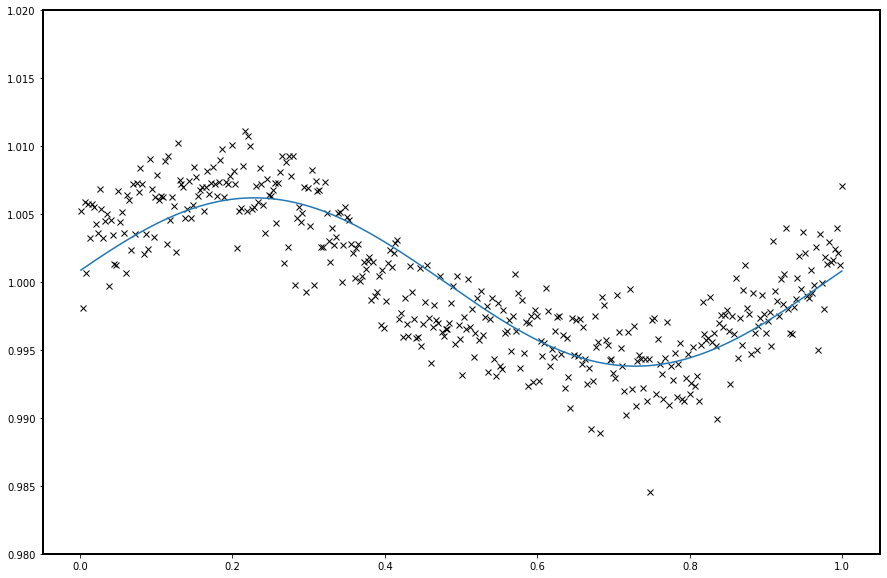

In [15]:
TESSStackTime = TESSStackTime + 2457000
tessAllPhases = foldMeth(TESSStackTime, 1/12.453593)
sortIndi = np.argsort(tessAllPhases)
tessAllPhasesSorted = tessAllPhases[sortIndi]
TESSStackPhotS = TESSStackPhot[sortIndi]

TESSStackPhotMean = np.nanmean(np.pad(TESSStackPhotS.astype(float), (0, 200 - TESSStackPhotS.size%200), mode='constant', constant_values=np.NaN).reshape(-1, 200), axis=1)

TessPhasesMean = np.nanmean(np.pad(tessAllPhasesSorted.astype(float), (0, 200 - tessAllPhasesSorted.size%200), mode='constant', constant_values=np.NaN).reshape(-1, 200), axis=1)

#model = 0.006446446446446446*np.sin(TessPhasesMean*0.08029867*(2*np.pi/ 0.08029867)+0.3149466319388264) + 1
model = 0.00619304762*np.sin(TessPhasesMean*(2*np.pi*12.453593)/12.453593+0.134084) + 1

plt.figure(figsize=(15,10))

plt.plot(TessPhasesMean,TESSStackPhotMean,'kx')
plt.plot(TessPhasesMean,model)
plt.ylim(0.98,1.02)
#plt.savefig('TESSFolded.pdf')

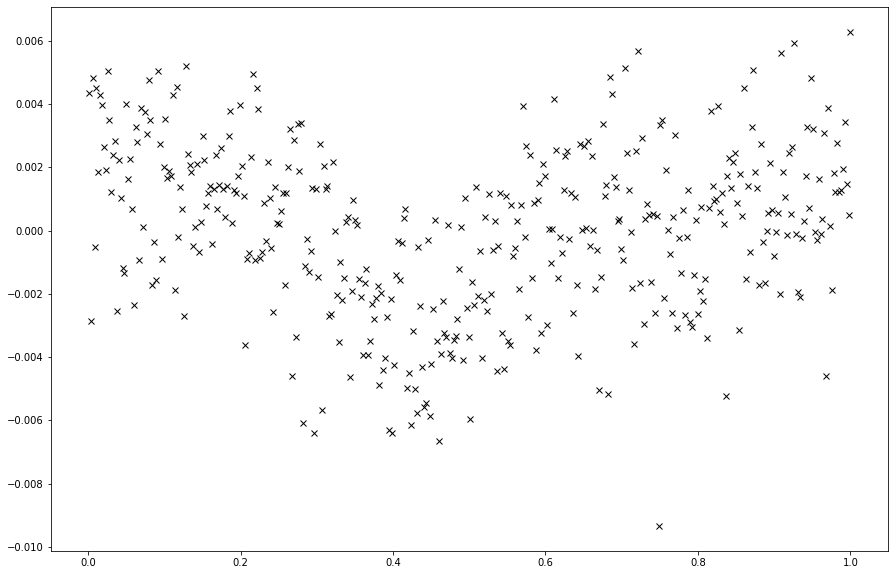

In [6]:
plt.figure(figsize=(15,10))
plt.plot(TessPhasesMean,TESSStackPhotMean-model, 'kx')
#plt.savefig('TESSResiduals.pdf')

In [11]:
lc = lk.search_lightcurvefile('GD356', sector=16).download().PDCSAP_FLUX.remove_nans()
sec16 = lc.flux
sec16t = lc.time
sec16e = lc.flux_err
print(lc.camera)
print(lc.ccd)
lc = lk.search_lightcurvefile('GD356', sector=23).download().PDCSAP_FLUX.remove_nans()
sec23 = lc.flux
sec23t = lc.time
sec23e = lc.flux_err
print(lc.camera)
print(lc.ccd)
lc = lk.search_lightcurvefile('GD356', sector=24).download().PDCSAP_FLUX.remove_nans()
sec24 = lc.flux
sec24t = lc.time
sec24e = lc.flux_err
print(lc.camera)
print(lc.ccd)
lc = lk.search_lightcurvefile('GD356', sector=25).download().PDCSAP_FLUX.remove_nans()
sec25 = lc.flux
sec25t = lc.time
sec25e = lc.flux_err
print(lc.camera)
print(lc.ccd)
lc = lk.search_lightcurvefile('GD356', sector=26).download().PDCSAP_FLUX.remove_nans()
sec26 = lc.flux
sec26t = lc.time
sec26e = lc.flux_err
print('26 ', lc.camera)
print(lc.ccd)


sec16e = sec16e/np.mean(sec16)
sec23e = sec23e/np.mean(sec23)
sec24e = sec24e/np.mean(sec24)
sec25e = sec25e/np.mean(sec25)
sec26e = sec26e/np.mean(sec26)
sec16 = (sec16/np.mean(sec16))-1
sec23 = (sec23/np.mean(sec23))-1
sec24 = (sec24/np.mean(sec24))-1
sec25 = (sec25/np.mean(sec25))-1
sec26 = (sec26/np.mean(sec26))-1

sec16t = sec16t + 2457000
sec23t = sec23t + 2457000
sec24t = sec24t + 2457000
sec25t = sec25t + 2457000
sec26t = sec26t + 2457000

TESSStackPhot = np.append(sec16, sec23)
TESSStackPhot = np.append(TESSStackPhot, sec24)
TESSStackPhot = np.append(TESSStackPhot, sec25)
TESSStackPhot = np.append(TESSStackPhot, sec26)
TESSStackTime = np.append(sec16t, sec23t)
TESSStackTime = np.append(TESSStackTime, sec24t)
TESSStackTime = np.append(TESSStackTime, sec25t)
TESSStackTime = np.append(TESSStackTime, sec26t)
TESSStackErr = np.append(sec16e, sec23e)
TESSStackErr = np.append(TESSStackErr, sec24e)
TESSStackErr = np.append(TESSStackErr, sec25e)
TESSStackErr = np.append(TESSStackErr, sec26e)
BJEWs = np.load('EWs/BJEWs.npy')
BJEWsErr = np.load('EWs/BJEWsErr.npy')

BMEWs = np.load('EWs/BMEWs.npy')
BMEWsErr = np.load('EWs/BMEWsErr.npy')

RJEWs = np.load('EWs/RJEWs.npy')
RJEWsErr = np.load('EWs/RJEWsErr.npy')

RMEWs = np.load('EWs/RMEWs.npy')
RMEWsErr = np.load('EWs/RMEWsErr.npy')

fullWHTSTackTJ = np.append(timeBJ, timeRJ)
fullWHTSTackTM = np.append(timeBM, timeRM)


fullWHTSTackFJ = np.append(BJEWs, RJEWs)
fullWHTSTackFM = np.append(BMEWs, RMEWs)


fullWHTSTackEJ = np.append(BJEWsErr, RJEWsErr)
fullWHTSTackEM = np.append(BMEWsErr, RMEWsErr)


#model = 0.00619304762*np.sin(TESSStackTime*(2*np.pi*12.453593)+0.134084) + 1
#noise = np.mean(np.abs(TESSStackPhot-model))
#print(1/noise) # <= TESS SNR

3
4
3
3
2
1
2
2
26  2
2


In [6]:
from astropy.io import ascii

ascii.write([TESSStackTime, TESSStackPhot], 'bestPeriod/TESS.dat', overwrite=True)
#ascii.write([fullWHTSTackTM, fullWHTSTackFM], 'EW4PEriod04M.dat', names=['time', 'observed'], overwrite=True)

In [6]:
1/0.08029867

12.453506390579072

In [11]:
dof = len(fullWHTSTackTJ)-2
model = 0.54405838*np.sin(np.array(fullWHTSTackTJ)*(2*np.pi/0.08029867)+0.506143*2*np.pi)
chiRed = (1/dof)*np.sum(((fullWHTSTackFJ-model)**2)/fullWHTSTackEJ**2)
print(chiRed)

8.94045321530021


In [8]:
dat = np.vstack((TESSStackTime, TESSStackPhot))
dat = np.vstack((dat, TESSStackErr))
dat = dat.T
np.savetxt('FullTess.dat', dat, delimiter = '\t')

In [9]:
fullWHTSTackTJ = np.append(timeBJ, timeRJ)
fullWHTSTackTM = np.append(timeBM, timeRM)


fullWHTSTackFJ = np.append(BJEWs, RJEWs)
fullWHTSTackFM = np.append(BMEWs, RMEWs)


fullWHTSTackEJ = np.append(BJEWsErr, RJEWsErr)
fullWHTSTackEM = np.append(BMEWsErr, RMEWsErr)

plt.errorbar(fullWHTSTackTJ, fullWHTSTackFJ, yerr=fullWHTSTackEJ,c='k', lw=1, marker='o',ecolor='grey', ls = '')
plt.plot(fullWHTSTackTJ,np.sin(fullWHTSTackTJ*(2*np.pi/0.08029867)+0.3149466319388264))
plt.show()
plt.errorbar(fullWHTSTackTM, fullWHTSTackFM, yerr=fullWHTSTackEM,c='k', lw=1, marker='o',ecolor='grey', ls = '')

NameError: name 'timeBJ' is not defined

In [9]:
WHTF = np.append((fullWHTSTackFJ/100),(fullWHTSTackFM/100))
WHTT = np.append(fullWHTSTackTJ,fullWHTSTackTM)
allFlux = np.append(WHTF,TESSStackPhot)
allTime = np.append(WHTT,TESSStackTime)
#TESSStackTime,TESSStackPhot

In [12]:
from scipy.optimize import leastsq
def sineFitLevenbergMarquardt(time, flux, Nslices):
    bestPhases = []
    timeMean = []
    phaseSTD = []
    phases = np.linspace(0, 2*np.pi, 1000)
    chunksF = np.array_split(np.array(flux),Nslices)
    chunksT = np.array_split(np.array(time),Nslices)
    for i in range(Nslices):
        def model(time, phase):
            return 0.007446446446446446*np.sin(time*(2*np.pi/0.08029870152418028)+phase)
        x0 = 0
        def residuals(phase, flux, time):
            return flux - model(time, phase)
        x, flag = leastsq(residuals, x0, args=(chunksF[i], chunksT[i]))

        bestPhases.append(x[0])
        toadd = np.mean(chunksT[i])
        timeMean.append(toadd)
        thisUncert = np.sqrt(2/len(chunksF[i]))*(np.std(chunksF[i])/0.006446446446446446)
        phaseSTD.append(thisUncert)
    return bestPhases, timeMean,phaseSTD

In [16]:
bestTessPhase = sineFitLevenbergMarquardt(TESSStackTime,TESSStackPhot,1)[0]
print(bestTessPhase)

[0.14472464387431255]


(-0.02, 0.02)

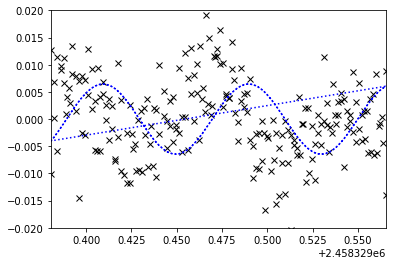

In [17]:
plt.plot(WHTT,WHTF, 'kx')
ymodel = 0.006446446446446446*np.sin(WHTT*(2*np.pi/0.08029870152418028)-4.650)
plt.plot(WHTT, ymodel, 'b:')
plt.xlim(timeBJ[0],timeBJ[-1])
plt.ylim(-0.02,0.02)

0.02772320375158721
0.02772320375158721


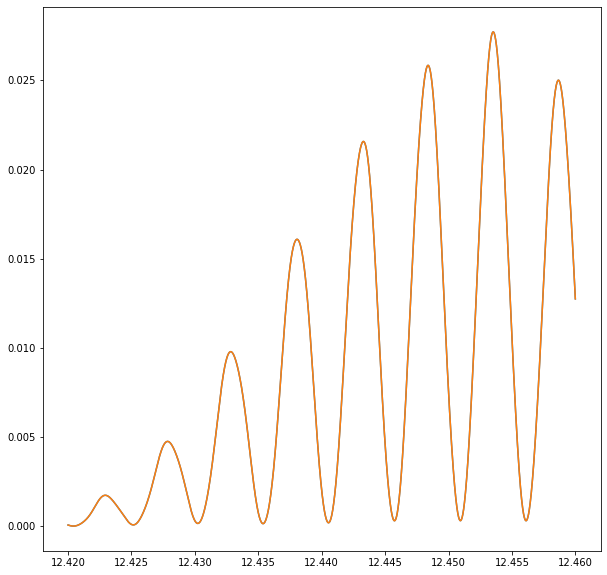

In [18]:
freq = np.linspace(12.42,12.46,10000)
TESSStackPhot = np.append(sec16, sec23)
TESSStackTime = np.append(sec16t, sec23t)
allFlux = np.append(WHTF,TESSStackPhot)
allTime = np.append(WHTT+0.08029849679270586/2,TESSStackTime)
powerPl = LombScargle(allTime,allFlux).power(freq)
plt.figure(figsize=(10,10))
plt.plot(freq,powerPl)
print(max(powerPl))
allTime = np.append(WHTT+0.08029849679270586/2,TESSStackTime)
powerPl = LombScargle(allTime,allFlux).power(freq)
plt.plot(freq,powerPl)
print(max(powerPl))

12.453516575165754


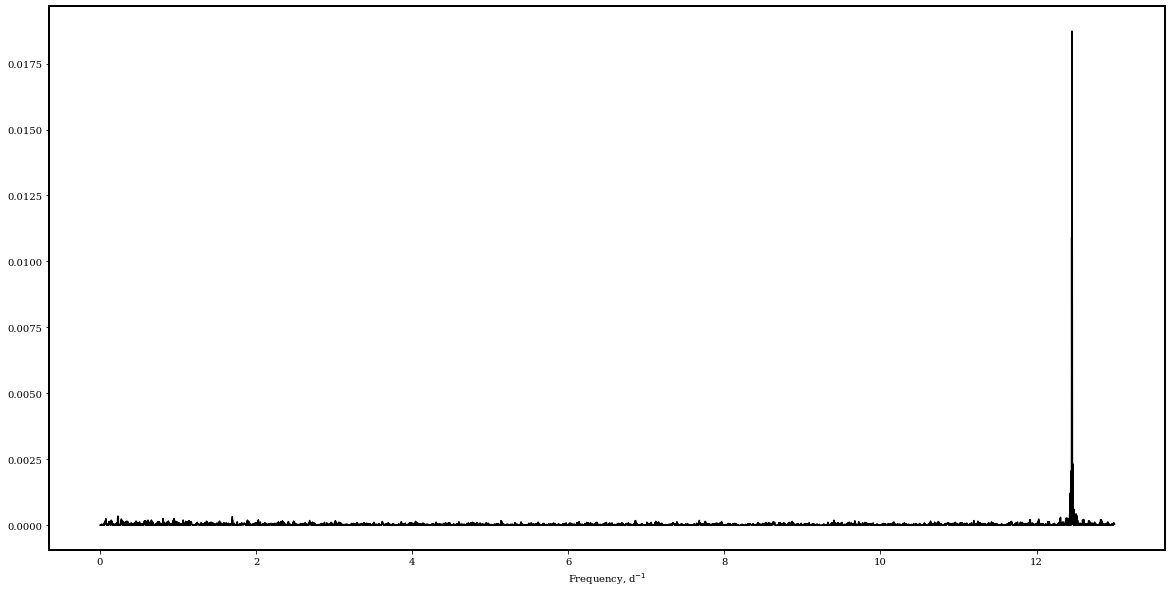

In [66]:
freq = np.linspace(0.001,13,100000)

powerPl = LombScargle(TESSStackTime,TESSStackPhot).power(freq)
plt.figure(figsize=(20,10))
plt.plot(freq,powerPl, c='k')
plt.xlabel(r"Frequency, d$^{-1}$")
print(freq[np.argmax(powerPl)])

0.08029843044299173
2.929694922402201e-07
3e-07
12.453543543543544
2e-09


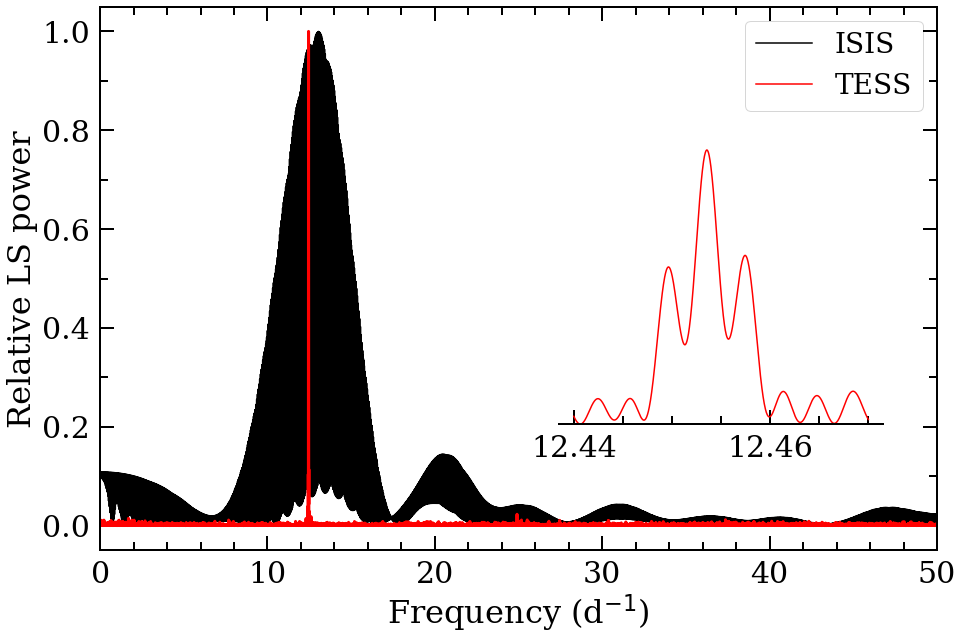

In [5]:
from pylab import *
from matplotlib import transforms

rc('axes', linewidth=2)
fig, axs = plt.subplots(1, 1,
                        gridspec_kw={'hspace': 0.1, 'wspace': 0}, figsize=(15,10))


freq = np.linspace(0.01,50,10000)
fullWHTSTackT = np.append(fullWHTSTackTJ, fullWHTSTackTM)
fullWHTSTackF = np.append(fullWHTSTackFJ, fullWHTSTackFM)
powerPl = LombScargle(fullWHTSTackT,fullWHTSTackF).power(freq)



axs.plot(freq,powerPl/max(powerPl), c='k', label='ISIS')
#axs.annotate("", xy=(12.453573573573573*2, 0.01), xytext=(12.453573573573573*2, 0.04),
#            arrowprops=dict(arrowstyle = 'simple'), fontsize=23)
#axs.arrow(12.453573573573573*2,0.05,0.,-0.02,fc='k',head_width=0.02,head_length=1,width=0.01,clip_on=False)
axs.plot(0,0, c='r', label='TESS')
axs.set_xlim(0,50)
axs.set_ylabel(r"Relative LS power", fontsize=32)
axs.set_xlabel(r"Frequency (d$^{-1}$)", fontsize=32)

freq = np.linspace(0.01,50,10000)

powerPl = LombScargle(TESSStackTime,TESSStackPhot).power(freq)
freqKeep = np.linspace(12.453573573573573*0.5,12.453573573573573*3.5,5000)
powerPlKeep = LombScargle(TESSStackTime,TESSStackPhot).power(freqKeep)
powerPlKeep = powerPlKeep/max(powerPlKeep)
ax2 = axs.twinx()
ax2.plot(freq,powerPl/max(powerPl), c='r', label=r'TESS', lw=3)
#ax2.set_ylabel(r"LS power TESS", fontsize=28)

freq = np.linspace(12.44,12.47,1000)
powerPl = LombScargle(TESSStackTime,TESSStackPhot).power(freq)
rc('axes', linewidth=2)
ax3 = plt.axes([.55, .3, .3, .4])
#
#ax3.yaxis.tick_right()
axs.set_ylim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)
#ax2.spines['right'].set_color('r')
ax3.set_ylim(0.000,1.05)
ax3.plot(freq,powerPl/max(powerPl),c='r')
setp(ax3, xticks=[12.44,12.45,12.46,12.47], yticks=[0.005,0.01,0.015])
ax3.spines['left'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
#ax3.spines['right'].set_color('r')
#plt.setp(ax3, xticks=[], yticks=[])
#axs[0].set_xlim(0,50)
#axs[0].set_ylabel(r"Lomb-Scargle power", fontsize=23)




print(1/freq[np.argmax(powerPl)])

#axs[1].plot(, c='k', label='TESS')

axs.legend(prop={'size': 28})
#axs[2].set_xlim(12.4,12.5)






axs.xaxis.set_minor_locator(AutoMinorLocator())
#axs.yaxis.set_major_locator(MultipleLocator(0.06))
axs.tick_params(axis='y',which='both', width=2,direction="in",pad=10)
axs.tick_params(axis='y',which='major', length=14,direction="in")
axs.tick_params(axis='x',which='both', width=2,direction='in')
axs.tick_params(axis='x',which='major', length=14,direction='in',pad=10)
axs.xaxis.set_minor_locator(MultipleLocator(2))
axs.yaxis.set_major_locator(MultipleLocator(0.2))
axs.yaxis.set_minor_locator(MultipleLocator(0.1))
axs.tick_params(axis='x',which='minor', length=8)
axs.tick_params(axis='y',which='minor', length=8,direction='in')
axs.tick_params(labelsize=30)

    
    
ax2.yaxis.set_major_locator(MultipleLocator(0.2))
ax2.yaxis.set_minor_locator(MultipleLocator(0.1))

ax2.tick_params(which='both', width=2,direction="in",pad=10)
ax2.tick_params(which='major', length=14,direction="in")
ax2.tick_params(which='minor', length=8,direction="in")

ax2.tick_params(labelsize=30)
ax3.minorticks_off()
#ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(which='both', width=2,direction="in",pad=10)
ax3.tick_params(which='major', length=14,direction="in")
ax3.tick_params(labelsize=30)
ax3.xaxis.set_major_locator(MultipleLocator(0.02))
ax3.xaxis.set_minor_locator(MultipleLocator(0.005))
ax3.tick_params(which='minor', length=8,direction="in")
ax3.get_xaxis().get_major_formatter().set_useOffset(False)

axs.xaxis.set_ticks_position('both')
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax3.yaxis.set_visible(False)
bboxx = transforms.Bbox([[0.56, 0.15], [13.76, 8.83]])#285->288 #15.15->
#plt.savefig('Figure3UpdatedCr.pdf', bbox_inches=bboxx ) 

print((12.45482-12.45224)*np.sqrt(2/(len(TESSStackTime)*44*44)))
print(0.0000003)
print(freq[np.argmax(powerPl)])
#0.080298497(2) +- 0.000000002
print( 0.000000002)



#axs.yaxis.set_minor_locator(MultipleLocator(0.25))
#ax2.tick_params(which='minor', length=8,direction="in")

0.08029843044299173
2.929694922402201e-07
3e-07
12.453543543543544
2e-09


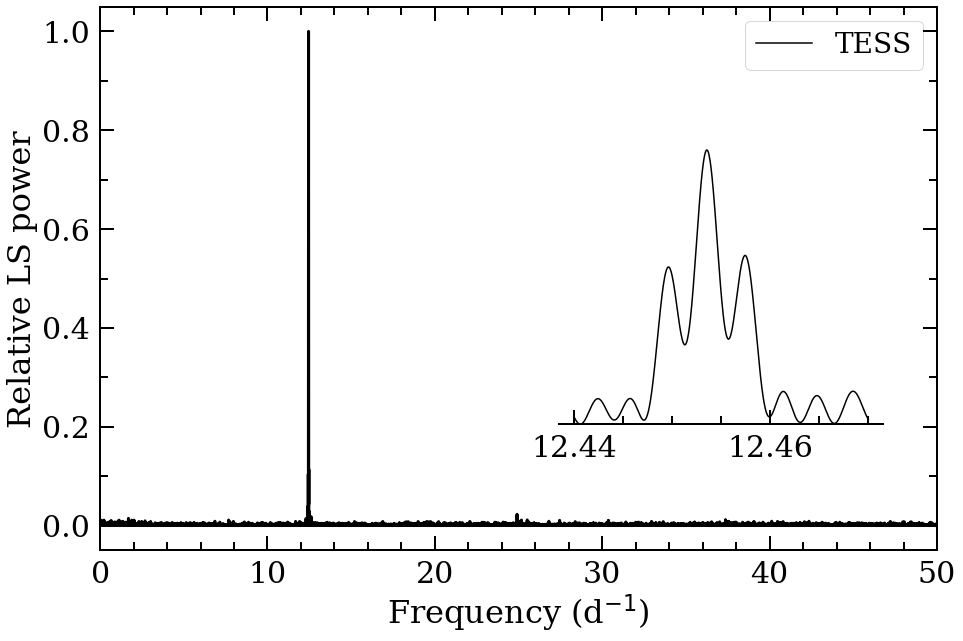

In [9]:
from pylab import *
from matplotlib import transforms

rc('axes', linewidth=2)
fig, axs = plt.subplots(1, 1,
                        gridspec_kw={'hspace': 0.1, 'wspace': 0}, figsize=(15,10))


freq = np.linspace(0.01,50,10000)
fullWHTSTackT = np.append(fullWHTSTackTJ, fullWHTSTackTM)
fullWHTSTackF = np.append(fullWHTSTackFJ, fullWHTSTackFM)
powerPl = LombScargle(fullWHTSTackT,fullWHTSTackF).power(freq)

#axs.annotate("", xy=(12.453573573573573*2, 0.01), xytext=(12.453573573573573*2, 0.04),
#            arrowprops=dict(arrowstyle = 'simple'), fontsize=23)
#axs.arrow(12.453573573573573*2,0.05,0.,-0.02,fc='k',head_width=0.02,head_length=1,width=0.01,clip_on=False)
axs.plot(0,0, c='k', label='TESS')
axs.set_xlim(0,50)
axs.set_ylabel(r"Relative LS power", fontsize=32)
axs.set_xlabel(r"Frequency (d$^{-1}$)", fontsize=32)

freq = np.linspace(0.01,50,10000)

powerPl = LombScargle(TESSStackTime,TESSStackPhot).power(freq)
freqKeep = np.linspace(12.453573573573573*0.5,12.453573573573573*3.5,5000)
powerPlKeep = LombScargle(TESSStackTime,TESSStackPhot).power(freqKeep)
powerPlKeep = powerPlKeep/max(powerPlKeep)
ax2 = axs.twinx()
ax2.plot(freq,powerPl/max(powerPl), c='k', label='TESS', lw=3)
#ax2.set_ylabel(r"LS power TESS", fontsize=28)

freq = np.linspace(12.44,12.47,1000)
powerPl = LombScargle(TESSStackTime,TESSStackPhot).power(freq)
rc('axes', linewidth=2)
ax3 = plt.axes([.55, .3, .3, .4])
#
#ax3.yaxis.tick_right()
axs.set_ylim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)
#ax2.spines['right'].set_color('r')
ax3.set_ylim(0.000,1.05)
ax3.plot(freq,powerPl/max(powerPl),c='k')
setp(ax3, xticks=[12.44,12.45,12.46,12.47], yticks=[0.005,0.01,0.015])
ax3.spines['left'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
#ax3.spines['right'].set_color('r')
#plt.setp(ax3, xticks=[], yticks=[])
#axs[0].set_xlim(0,50)
#axs[0].set_ylabel(r"Lomb-Scargle power", fontsize=23)




print(1/freq[np.argmax(powerPl)])

#axs[1].plot(, c='k', label='TESS')

axs.legend(prop={'size': 28})
#axs[2].set_xlim(12.4,12.5)






axs.xaxis.set_minor_locator(AutoMinorLocator())
#axs.yaxis.set_major_locator(MultipleLocator(0.06))
axs.tick_params(axis='y',which='both', width=2,direction="in",pad=10)
axs.tick_params(axis='y',which='major', length=14,direction="in")
axs.tick_params(axis='x',which='both', width=2,direction='in')
axs.tick_params(axis='x',which='major', length=14,direction='in',pad=10)
axs.xaxis.set_minor_locator(MultipleLocator(2))
axs.yaxis.set_major_locator(MultipleLocator(0.2))
axs.yaxis.set_minor_locator(MultipleLocator(0.1))
axs.tick_params(axis='x',which='minor', length=8)
axs.tick_params(axis='y',which='minor', length=8,direction='in')
axs.tick_params(labelsize=30)

    
    
ax2.yaxis.set_major_locator(MultipleLocator(0.2))
ax2.yaxis.set_minor_locator(MultipleLocator(0.1))

ax2.tick_params(which='both', width=2,direction="in",pad=10)
ax2.tick_params(which='major', length=14,direction="in")
ax2.tick_params(which='minor', length=8,direction="in")

ax2.tick_params(labelsize=30)
ax3.minorticks_off()
#ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(which='both', width=2,direction="in",pad=10)
ax3.tick_params(which='major', length=14,direction="in")
ax3.tick_params(labelsize=30)
ax3.xaxis.set_major_locator(MultipleLocator(0.02))
ax3.xaxis.set_minor_locator(MultipleLocator(0.005))
ax3.tick_params(which='minor', length=8,direction="in")
ax3.get_xaxis().get_major_formatter().set_useOffset(False)

axs.xaxis.set_ticks_position('both')
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax3.yaxis.set_visible(False)
bboxx = transforms.Bbox([[0.56, 0.15], [13.76, 8.83]])#285->288 #15.15->
#plt.savefig('Figure3UpdatedCr.pdf', bbox_inches=bboxx ) 

print((12.45482-12.45224)*np.sqrt(2/(len(TESSStackTime)*44*44)))
print(0.0000003)
print(freq[np.argmax(powerPl)])
#0.080298497(2) +- 0.000000002
print( 0.000000002)



#axs.yaxis.set_minor_locator(MultipleLocator(0.25))
#ax2.tick_params(which='minor', length=8,direction="in")

In [4]:
lc = lk.search_lightcurvefile('04:12:46.845 +75:49:42.26', sector=19).download().PDCSAP_FLUX.remove_nans()
sec19J04 = lc.flux
sec19eJ04 = lc.flux_err
sec19eJ04 = sec19eJ04/np.mean(sec19J04)
sec19J04 = sec19J04/np.mean(sec19J04)
sec19J04 = sec19J04-1
sec19tJ04 = lc.time

lc = lk.search_lightcurvefile('04:12:46.845 +75:49:42.26', sector=25).download().PDCSAP_FLUX.remove_nans()
sec25J04 = lc.flux
sec25eJ04 = lc.flux_err
sec25eJ04 = sec25eJ04/np.mean(sec25J04)
sec25J04 = sec25J04/np.mean(sec25J04)
sec25J04 = sec25J04 - 1
sec25tJ04 = lc.time

lc = lk.search_lightcurvefile('04:12:46.845 +75:49:42.26', sector=26).download().PDCSAP_FLUX.remove_nans()
sec26J04 = lc.flux
sec26eJ04 = lc.flux_err
sec26eJ04 = sec26eJ04/np.mean(sec26J04)
sec26J04 = sec26J04/np.mean(sec26J04)
sec26J04 = sec26J04 -1
sec26tJ04 = lc.time


gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!


In [63]:
sec26eJ04

array([-4.4905037e+08, -4.4847264e+08, -4.5266752e+08, ...,
       -3.5764099e+08, -3.5760854e+08, -3.5649472e+08], dtype=float32)

10.49112812281228


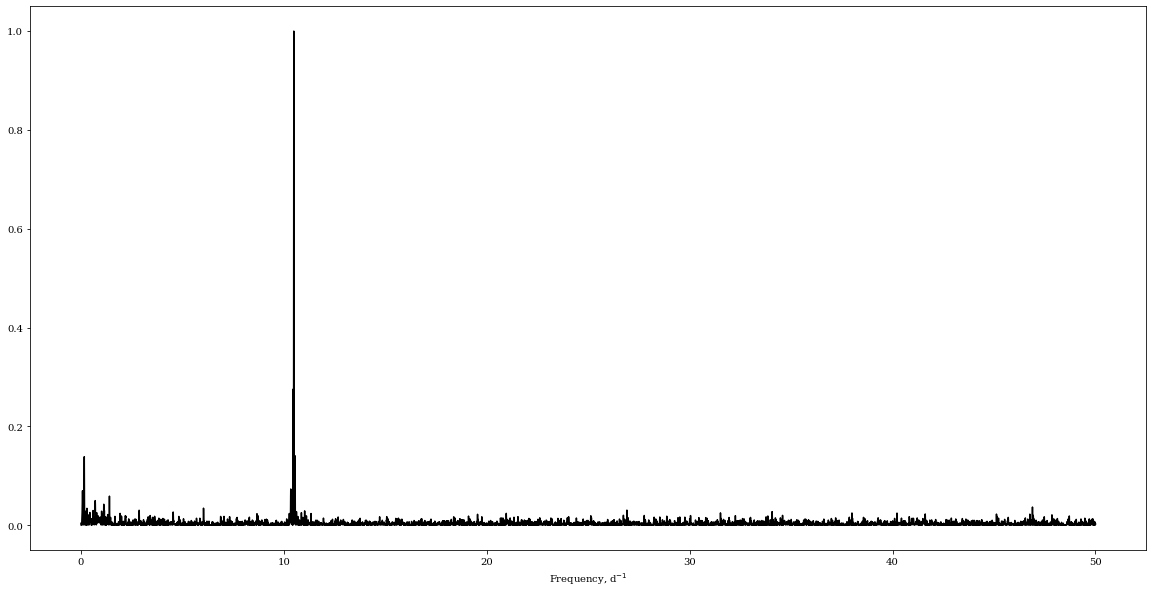

In [5]:
freq = np.linspace(0.0001,50,10000)
#plt.plot([2*10.484048404840484,2*10.484048404840484],[0,max(powerPl)])
TESSStackPhotJ04 = np.append(sec19J04, sec25J04)
TESSStackPhotJ04 = np.append(TESSStackPhotJ04, sec26J04)
TESSStackTimeJ04 = np.append(sec19tJ04, sec25tJ04)
TESSStackTimeJ04 = np.append(TESSStackTimeJ04, sec26tJ04)
TESSStackErrJ04 = np.append(sec19eJ04, sec25eJ04)
TESSStackErrJ04 = np.append(TESSStackErrJ04, sec26eJ04)

powerPlJ04 = LombScargle(TESSStackTimeJ04,TESSStackPhotJ04).power(freq)
powerPlJ04 = powerPlJ04/max(powerPlJ04)
plt.figure(figsize=(20,10))
plt.plot(freq,powerPlJ04, c='k')
plt.xlabel(r"Frequency, d$^{-1}$")
print(freq[np.argmax(powerPlJ04)])

In [89]:
TESSStackTimeJ04[0]# - (0.59674*(1/10.49112812281228))

1816.0877687801476

<ErrorbarContainer object of 3 artists>

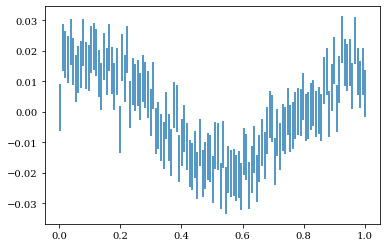

In [6]:
TESSStackTimeJ04Adj = TESSStackTimeJ04 - (0.59674*(1/10.49112812281228))
J04Phases = foldMeth(TESSStackTimeJ04Adj,  1/10.49112812281228)
sortIndi = np.argsort(J04Phases)
J04PhasesS = J04Phases[sortIndi]
TESSStackPhotJ04S = TESSStackPhotJ04[sortIndi]
TESSStackErrJ04S = TESSStackErrJ04 [sortIndi]
npoint = 400#*2
TESSStackPhotJ04S = np.nanmean(np.pad(TESSStackPhotJ04S.astype(float), (0, npoint - TESSStackPhotJ04S.size%npoint), mode='constant', constant_values=np.NaN).reshape(-1, npoint), axis=1)
J04PhasesS = np.nanmean(np.pad(J04PhasesS.astype(float), (0, npoint - J04PhasesS.size%npoint), mode='constant', constant_values=np.NaN).reshape(-1, npoint), axis=1)
TESSStackErrJ04S = np.nanmean(np.pad(TESSStackErrJ04S.astype(float), (0, npoint - TESSStackErrJ04S.size%npoint), mode='constant', constant_values=np.NaN).reshape(-1, npoint), axis=1)
TESSStackErrJ04S = TESSStackErrJ04S/np.sqrt(npoint)

plt.errorbar(J04PhasesS,TESSStackPhotJ04S,yerr=TESSStackErrJ04S,ls='')

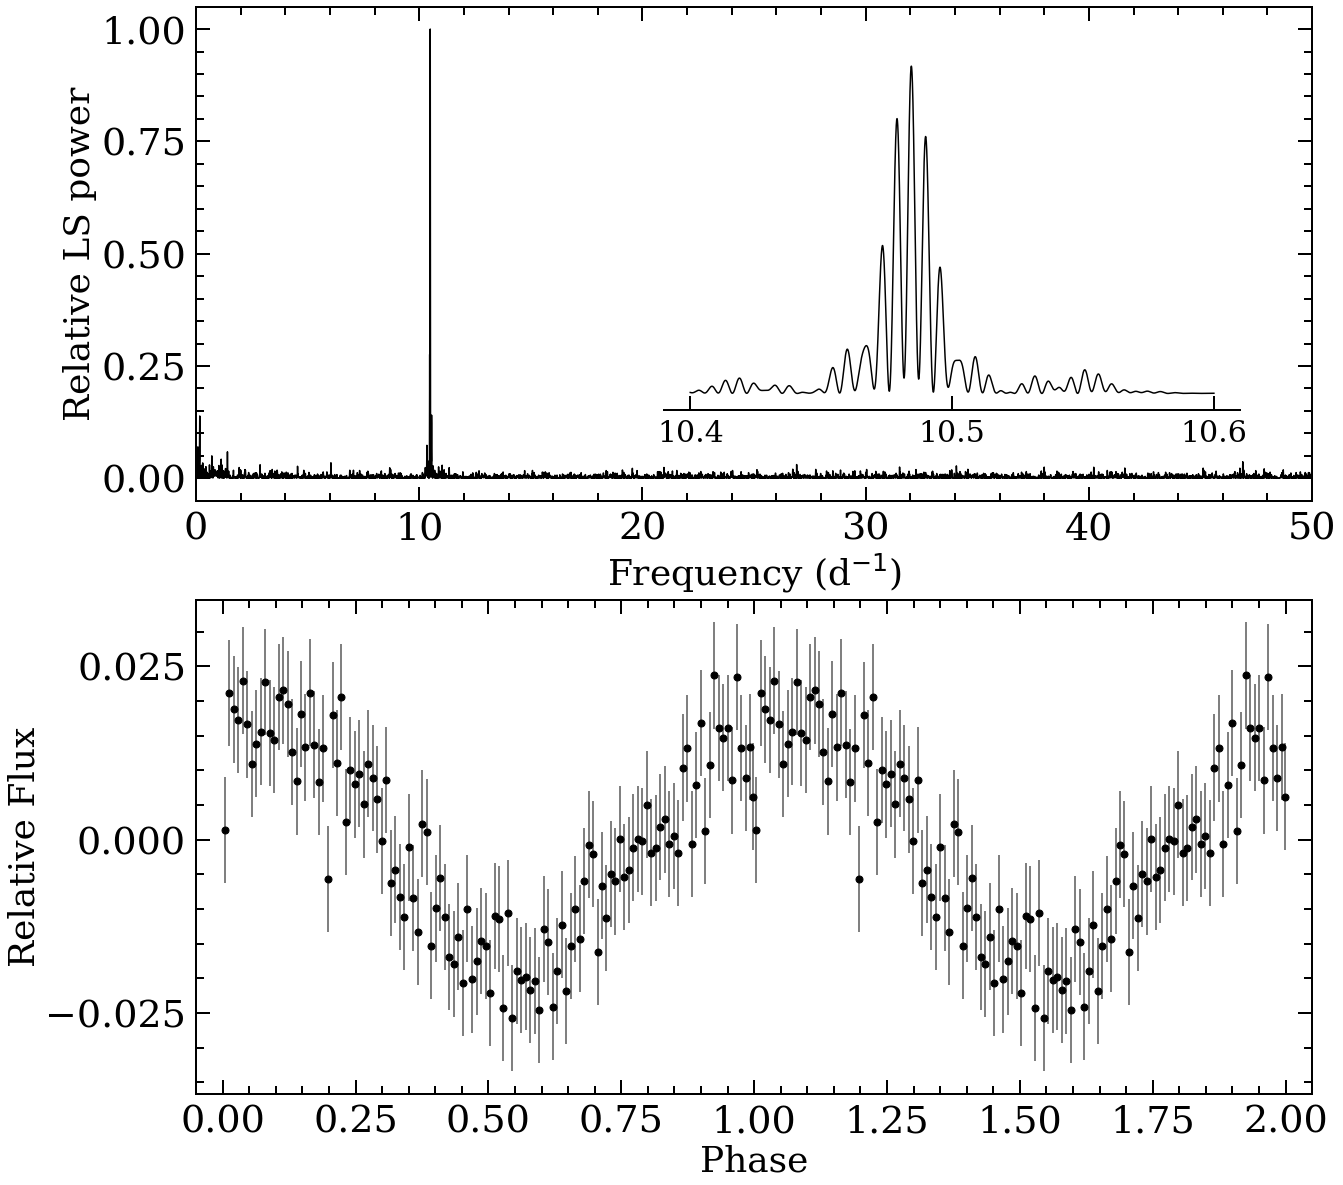

In [9]:
#30

from pylab import rc
from matplotlib import transforms
rc('axes', linewidth=2)

fig, axs = plt.subplots(2, 1,
                        gridspec_kw={'hspace': 0.2, 'wspace': 0.0}, figsize=(20,20))

axs[0].plot(freq,powerPlJ04, c='k')

axs[1].errorbar(J04PhasesS,TESSStackPhotJ04S,yerr=TESSStackErrJ04S,ls='',marker='o',ms=7,ecolor='gray',c='k',elinewidth=2)
axs[1].errorbar(J04PhasesS+1,TESSStackPhotJ04S,yerr=TESSStackErrJ04S,ls='',marker='o',ms=7,ecolor='gray',c='k',elinewidth=2)

#axs[2].legend(prop={'size': 30})
axs[1].set_xlabel("Phase", fontsize=36)
axs[0].set_ylabel('Relative LS power', fontsize=36)
axs[0].set_xlabel(r"Frequency (d$^{-1}$)", fontsize=36)



axs[1].set_ylabel('Relative Flux', fontsize=36)
#ax.xaxis.set_label_coords(1.0, -0.1)
#ax.set_xlim(0,1)
#ax2.set_xlim(6250,7200)

#ax.set_ylim(0.9,1.12)
axs[0].set_xlim(0,50)
axs[1].set_xlim(-0.05,2.05)


#ax.yaxis.tick_left()
#ax.tick_params(labelright='off')
#ax2.tick_params(labelright='on')
#ax2.yaxis.tick_right()
#ax2.yaxis.set_label_position("right")
ax3 = plt.axes([.45, .6, .4, .25])
freqZo = np.linspace(10.4,10.6,10000)
powerPlJ04Zo = LombScargle(TESSStackTimeJ04,TESSStackPhotJ04).power(freqZo)
powerPlJ04Zo = powerPlJ04Zo/max(powerPlJ04Zo)
ax3.plot(freqZo,powerPlJ04Zo/max(powerPlJ04Zo),c='k')
setp(ax3, xticks=[10.4,10.5,10.6], yticks=[0.005,0.01,0.015])
ax3.spines['left'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.minorticks_off()
#ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(which='both', width=2,direction="in",pad=10)
ax3.tick_params(which='major', length=14,direction="in")
ax3.tick_params(labelsize=30)
#ax3.xaxis.set_major_locator(MultipleLocator(0.02))
#ax3.xaxis.set_minor_locator(MultipleLocator(0.005))
ax3.tick_params(which='minor', length=8,direction="in")
ax3.get_xaxis().get_major_formatter().set_useOffset(False)
ax3.yaxis.set_visible(False)
#ax.set_yticks(np.arange(0.9, 1.12, 0.05))
#ax2.set_yticks(np.arange(0.9, 1.12, 0.05))
axs[0].xaxis.set_minor_locator(AutoMinorLocator()) #
axs[0].yaxis.set_major_locator(MultipleLocator(0.25))
axs[0].yaxis.set_minor_locator(MultipleLocator(0.05))
axs[1].xaxis.set_minor_locator(AutoMinorLocator())
axs[1].yaxis.set_minor_locator(MultipleLocator(0.005))
axs[1].yaxis.set_major_locator(MultipleLocator(0.025))
#ax2.xaxis.set_minor_locator(AutoMinorLocator())
#ax.yaxis.set_minor_locator(AutoMinorLocator())
axs[0].tick_params(which='both', width=2,direction='in',pad=10)
axs[1].tick_params(which='both', width=2,direction='in',pad=10)

axs[0].tick_params(which='major', length=14)
axs[1].tick_params(which='major', length=14)

axs[0].tick_params(which='minor', length=8)
axs[1].tick_params(which='minor', length=8)
#ax2.tick_params(which='major', length=14)
#ax2.tick_params(which='minor', length=8)
axs[0].tick_params(labelsize=38)
axs[1].tick_params(labelsize=38)

axs[0].xaxis.set_ticks_position('both')
axs[1].xaxis.set_ticks_position('both')
#ax2.tick_params(labelsize=23)
#fig.Bbox([[0,0],[100,100]])
axs[0].xaxis.set_ticks_position('both')
axs[1].xaxis.set_ticks_position('both')
axs[0].yaxis.set_ticks_position('both')
axs[1].yaxis.set_ticks_position('both')


bboxx = transforms.Bbox([[-0.16, 1.38], [18.32, 17.65]])
plt.savefig('J0412Phot.pdf',bbox_inches=bboxx) 
plt.show()

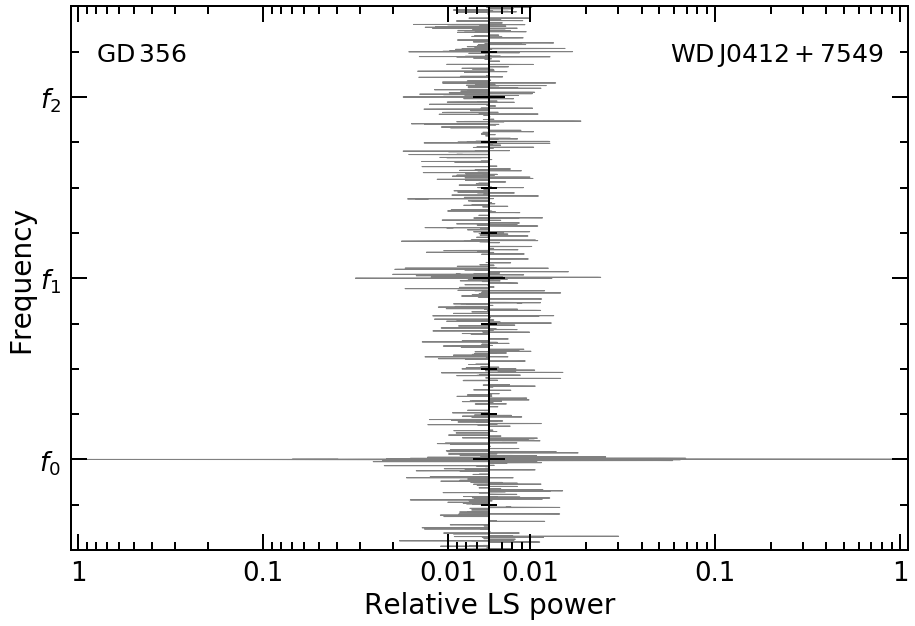

In [141]:
rc('axes', linewidth=2)
fig, axs = plt.subplots(1, 2,
                        gridspec_kw={'hspace': 0.1, 'wspace':0}, figsize=(15,10))
axs[0].plot(powerPlKeep,freqKeep/12.453573573573573,lw=1,zorder=1,c='gray')
##, c='r', label=r'TESS', lw=3
axs[0].set_xscale('log')
axs[0].set_xlim(1.1,6*0.001)
axs[1].plot(powerPlJ04, freq/10.479234144836624,lw=1,zorder=1,c='gray')
axs[1].set_xscale('log')
axs[1].set_xlim(6*0.001,1.1)
axs[1].yaxis.tick_right()
axs[0].set_ylim(0.5,3.5)
axs[1].set_ylim(0.5,3.5)
axs[0].tick_params(labelsize=26)
axs[0].tick_params(which='both', width=2,direction="in",pad=10)
axs[0].tick_params(which='major', length=16,direction="in")
axs[0].tick_params(which='minor', length=8,direction="in")
axs[0].xaxis.set_ticks_position('both')
axs[0].yaxis.set_ticks_position('both')
axs[1].tick_params(labelsize=26)
axs[1].tick_params(which='both', width=2,direction="in",pad=10)
axs[1].tick_params(which='major', length=16,direction="in")
axs[1].tick_params(which='minor', length=8,direction="in")
axs[1].xaxis.set_ticks_position('both')
axs[1].yaxis.set_ticks_position('both')
axs[0].annotate(r'$\rm{GD}\,356$', xy=(0.8,3.2), fontsize=25)
axs[1].annotate(r'$\rm{WD}\,\rm{J}0412+7549$', xy=(0.057,3.2), fontsize=25)
axs[1].tick_params(labeltop=False, labelright=False)
yticksList = [r'$f_0$', r'$f_1$', r'$f_2$']
yticksVal = [1,2,3]
axs[0].set_yticks(yticksVal)
axs[1].set_yticks(yticksVal)
axs[0].set_yticklabels(yticksList)
axs[0].yaxis.set_minor_locator(MultipleLocator(0.25))
axs[1].yaxis.set_minor_locator(MultipleLocator(0.25))
axs[0].set_ylabel('Frequency',fontsize=28)
axs[0].set_xlabel("Relative LS power", fontsize=28)
axs[0].xaxis.set_label_coords(1.0, -0.075)
import matplotlib.ticker as ticker
axs[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda powerPlKeep, _: '{:g}'.format(powerPlKeep)))
axs[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda powerPlJ04, _: '{:g}'.format(powerPlJ04)))

bboxx = transforms.Bbox([[0.98, 0.28], [13.54, 8.83]])#285->288 #15.15->

plt.savefig('J0412Periodogram.pdf', bbox_inches=bboxx ) 
#axs[0].set_tick.zorder=20

In [38]:



dat = np.array([TESSStackTimeJ04, TESSStackPhotJ04])

dat = dat.T

np.savetxt('TESSJ0412.dat', dat, delimiter = '\t')


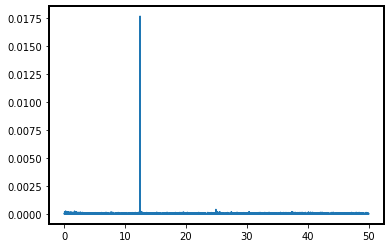

In [31]:
plt.plot(freq,powerPlKeep)

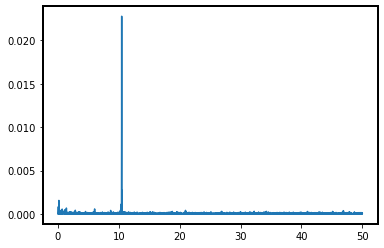

In [32]:
plt.plot(freq,powerPlJ04)

12.785300548544248


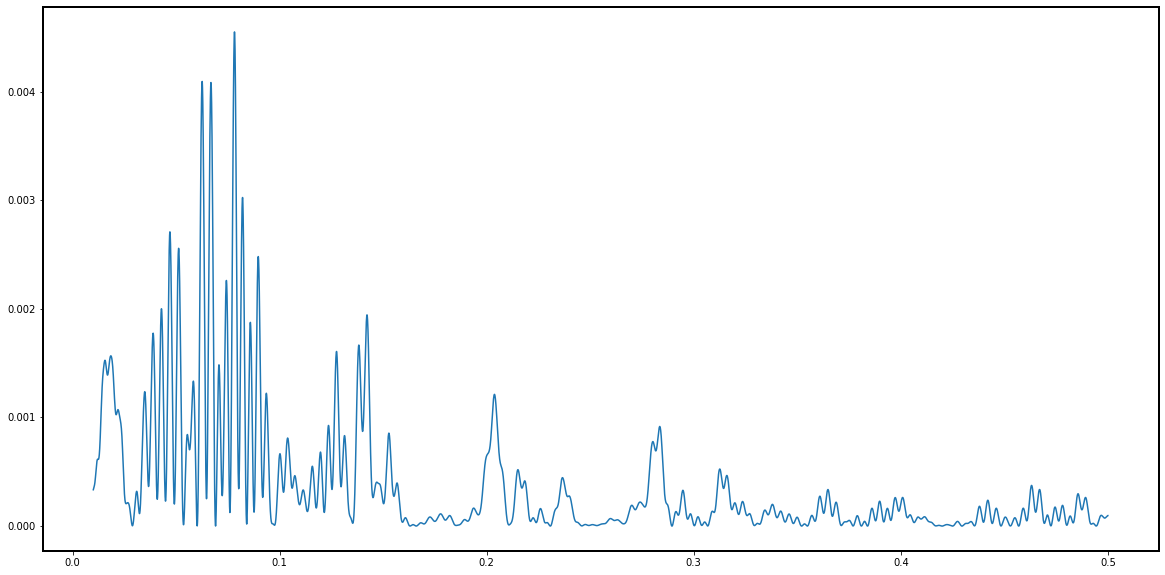

In [10]:
freq = np.linspace(0.01,0.5,10000)

powerPl = LombScargle(TESSStackTime,TESSStackPhot).power(freq)
plt.figure(figsize=(20,10))
plt.plot(freq,powerPl)
print(1/freq[np.argmax(powerPl)])

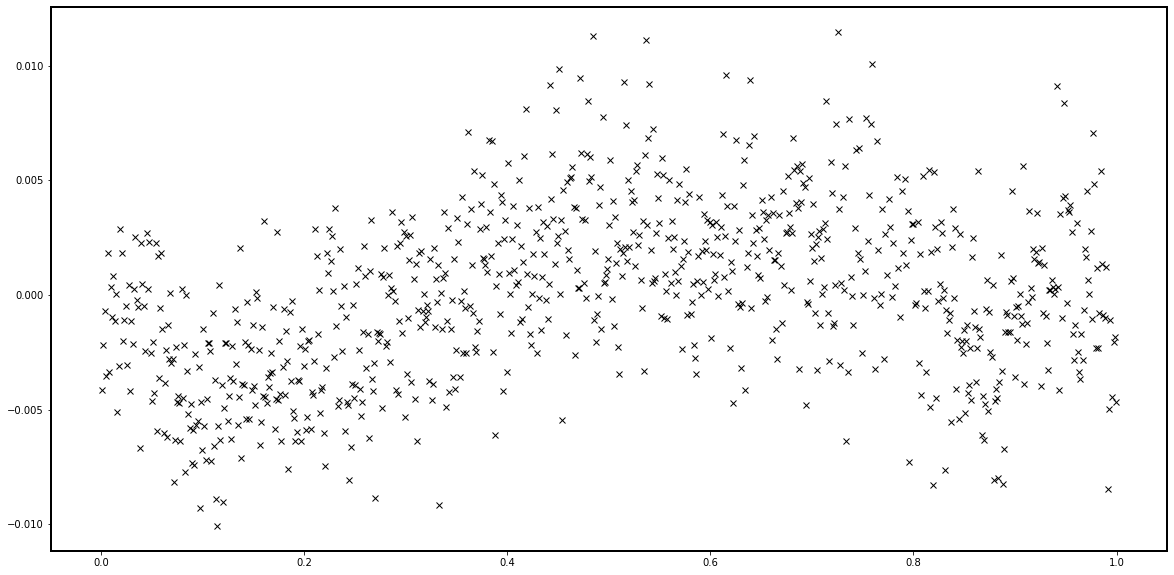

In [13]:
TessPhases = foldMeth(TESSStackTime,  12.785300548544248)
sortIndi = np.argsort(TessPhases)
TessPhases = TessPhases[sortIndi]
TESSStackPhotS = TESSStackPhot[sortIndi]
TESSStackErrS = TESSStackErr[sortIndi]

TESSStackPhotMean = np.nanmean(np.pad(TESSStackPhotS.astype(float), (0, 100 - TESSStackPhotS.size%100), mode='constant', constant_values=np.NaN).reshape(-1, 100), axis=1)
TessPhasesMean = np.nanmean(np.pad(TessPhases.astype(float), (0, 100 - TessPhases.size%100), mode='constant', constant_values=np.NaN).reshape(-1, 100), axis=1)
TESSStackErrSMean = np.nanmean(np.pad(TESSStackErrS.astype(float), (0, 100 - TESSStackErrS.size%100), mode='constant', constant_values=np.NaN).reshape(-1, 100), axis=1)
TESSStackErrSMean = TESSStackErrSMean/np.sqrt(100)

plt.figure(figsize=(20,10))
plt.plot(TessPhasesMean,TESSStackPhotMean,'kx')

In [13]:
RJSMVelocity = np.load('RJSMV.npy')
RJSMVelocityError = np.load('RJSMVe.npy')
RMSMVelocity = np.load('RMSMV.npy')
RMSMVelocityError = np.load('RMSMVe.npy')

RJSMVelocity = (RJSMVelocity*6562.801/299792.458)+6562.801
RJSMVelocityError = (RJSMVelocityError*6562.801/299792.458)
RMSMVelocity = (RMSMVelocity*6562.801/299792.458)+6562.801
RMSMVelocityError = (RMSMVelocityError*6562.801/299792.458)

In [35]:
RJSMVelocity = np.load('RJSMV.npy')
RJSMVelocity

array([ 5.17722346e+02,  4.57950983e+02,  9.18570685e+02,  6.79383503e+02,
        5.42656019e+02,  6.76415079e+01,  7.29710811e+02,  3.59564018e+02,
       -6.48278527e+02,  2.79908317e+01,  1.31813502e+02, -2.85787698e+01,
       -4.89029140e+02, -5.66452031e+02, -4.44104496e+02,  5.63391026e+02,
        9.45755319e+02, -3.09123777e+02, -8.01946260e+02, -6.31809510e+02,
       -3.42060820e+02, -4.20990294e+02, -2.96548633e+02, -4.72569026e+02,
        3.15549996e+02, -9.59333247e+01, -5.67689873e+02, -4.86208798e+02,
       -1.64262686e+02,  4.10685977e+02,  9.54091774e+01, -1.27809628e+02,
       -3.43241061e+01,  1.12000371e+02, -2.71005082e+02, -2.98487894e+02,
       -1.06416074e+02,  1.35548030e+02, -1.05485883e+02,  2.54190169e+02,
        7.47316365e+02,  9.51909735e+02,  8.02950815e+02,  7.10876636e+01,
        1.60789367e+03,  4.87198907e+02,  5.47814205e+02,  8.02981506e+02,
        5.64892789e+02,  8.93958869e+02,  4.25402636e+02,  1.71321786e+02,
        1.22714418e+01,  

In [6]:
#cent wavel

RJSMVelocity = np.load('RJCentWavel.npy')
RJSMVelocityError = np.load('RJCentWavele.npy')
RMSMVelocity = np.load('RMCentWavel.npy')
RMSMVelocityError = np.load('RMCentWavele.npy')

dat = np.vstack((timeRJ, RJSMVelocity))
dat = dat.T
np.savetxt('RJVelPeriod04.dat', dat, delimiter = '\t')

dat = np.vstack((timeRM, RMSMVelocity))
dat = dat.T
np.savetxt('RMVelPeriod04.dat', dat, delimiter = '\t')

In [15]:
np.mean(RJSMVelocity)

6340.207229232992

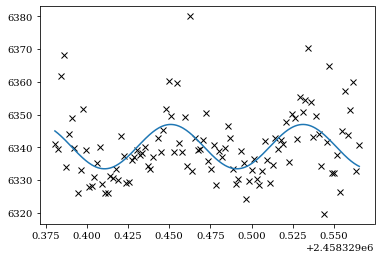

In [14]:
timeModel = np.linspace(timeRJ[0], timeRJ[-1], 300)
waveModel = np.mean(RJSMVelocity) + 6.76668573*np.sin(2*np.pi*12.4535791*timeModel + 0.979177*2*np.pi)
plt.plot(timeRJ, RJSMVelocity,'kx')
plt.plot(timeModel, waveModel)
RJShifts =  6.76668573*np.sin(2*np.pi*12.4535791*np.array(timeRJ) + 0.979177*2*np.pi) - RJSMVelocity
RMShifts =  6.76668573*np.sin(2*np.pi*12.4535791*np.array(timeRM) + 0.979177*2*np.pi) - RMSMVelocity


dat = np.vstack((timeRJ, RJShifts))
dat = dat.T
np.savetxt('RJShift.dat', dat, delimiter = '\t')

dat = np.vstack((timeRM, RMShifts))
dat = dat.T
np.savetxt('RMShift.dat', dat, delimiter = '\t')

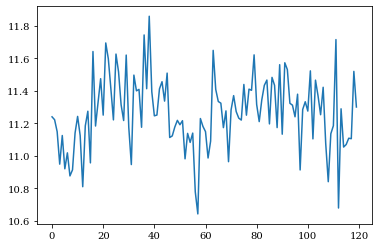

In [5]:


#!!!!!!!!!!!!!!!!
RJSMVelocity = np.load('RJSPV.npy')
RJSMVelocityError = np.load('RJSPVe.npy')
RMSMVelocity = np.load('RMSPV.npy')
RMSMVelocityError = np.load('RMSPVe.npy')


In [6]:
dat = np.vstack((timeRM, RMSMVelocity))
dat = np.vstack((dat, RMSMVelocityError))
dat = dat.T
np.savetxt('RMVel1.dat', dat, delimiter = '\t')

In [77]:
fullWHTSTackTJ[0]

2458329.380681342

In [7]:
1/0.08029820145279275

12.45357905790579

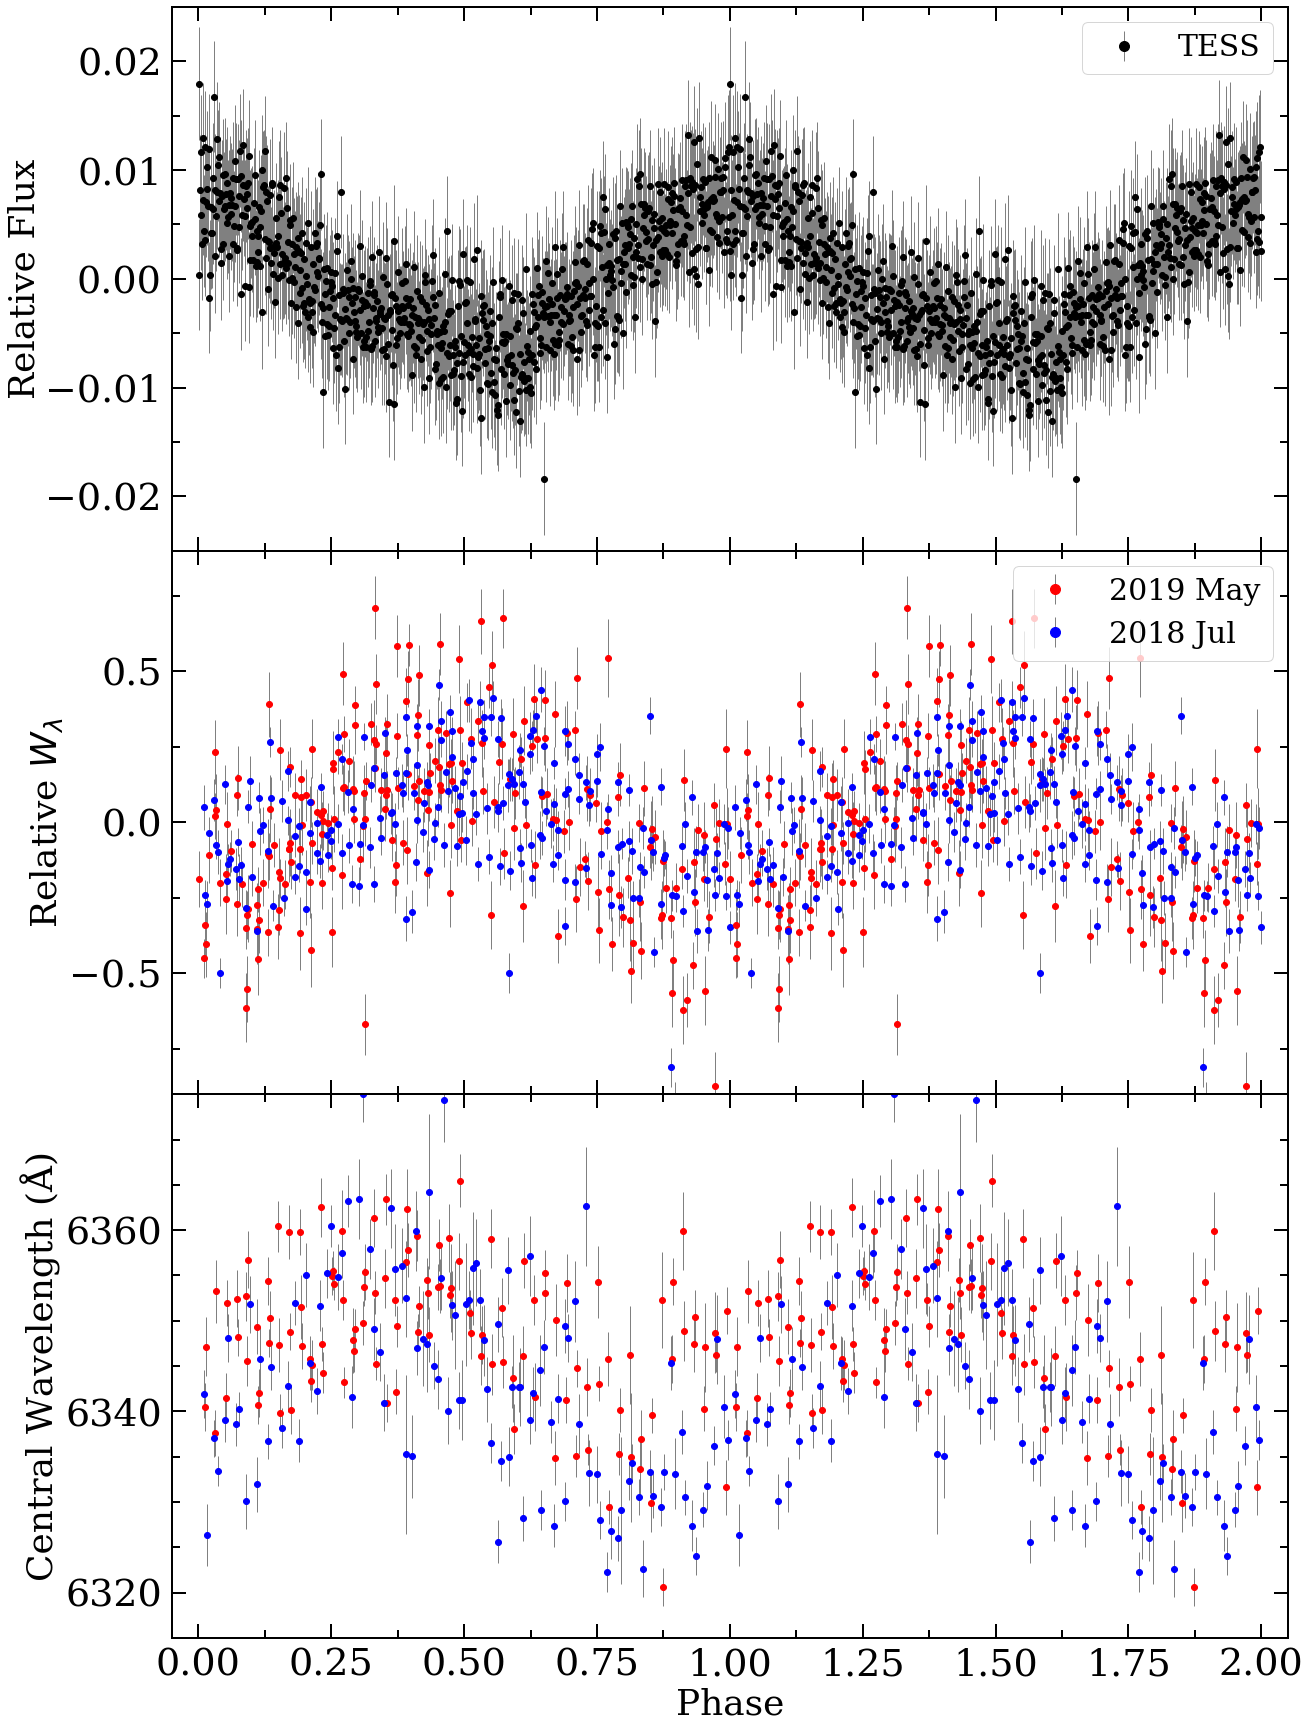

In [14]:
from pylab import rc
rc('axes', linewidth=2)
fig, axs = plt.subplots(3, 1,
                        gridspec_kw={'hspace': 0., 'wspace': 0}, figsize=(20,30))
TESStackTimeAdj = TESSStackTime-2457000.- 1296.0255697684468
TessPhases = foldMeth(TESStackTimeAdj,  0.08029820145279275)
sortIndi = np.argsort(TessPhases)
TessPhases = TessPhases[sortIndi]
TESSStackPhotS = TESSStackPhot[sortIndi]
TESSStackErrS = TESSStackErr[sortIndi]

TESSStackPhotMean = np.nanmean(np.pad(TESSStackPhotS.astype(float), (0, 100 - TESSStackPhotS.size%100), mode='constant', constant_values=np.NaN).reshape(-1, 100), axis=1)
TessPhasesMean = np.nanmean(np.pad(TessPhases.astype(float), (0, 100 - TessPhases.size%100), mode='constant', constant_values=np.NaN).reshape(-1, 100), axis=1)
TESSStackErrSMean = np.nanmean(np.pad(TESSStackErrS.astype(float), (0, 100 - TESSStackErrS.size%100), mode='constant', constant_values=np.NaN).reshape(-1, 100), axis=1)
TESSStackErrSMean = TESSStackErrSMean/np.sqrt(100)

axs[0].errorbar(TessPhasesMean, TESSStackPhotMean, yerr=TESSStackErrSMean, c='k', lw=1, marker='o',ecolor='grey', ls = '')
axs[0].errorbar(TessPhasesMean+1, TESSStackPhotMean, yerr=TESSStackErrSMean, c='k', lw=1, marker='o',ecolor='grey', ls = '')
fullWHTSTackTJAdj = fullWHTSTackTJ-2457000- 1296.0255697684468
fullWHTSTackPhaseJ = foldMeth(fullWHTSTackTJAdj,  0.08029820145279275)
sortIndi = np.argsort(fullWHTSTackPhaseJ)
fullWHTSTackPhaseJ = fullWHTSTackPhaseJ[sortIndi]
fullWHTSTackFSJ = fullWHTSTackFJ[sortIndi]
fullWHTSTackESJ = fullWHTSTackEJ[sortIndi]
fullWHTSTackTMAdj = fullWHTSTackTM - 2457000- 1296.0255697684468
fullWHTSTackPhaseM = foldMeth(fullWHTSTackTMAdj, 0.08029820145279275)
sortIndi = np.argsort(fullWHTSTackPhaseM)
fullWHTSTackPhaseM = fullWHTSTackPhaseM[sortIndi]
fullWHTSTackFSM = fullWHTSTackFM[sortIndi]
fullWHTSTackESM = fullWHTSTackEM[sortIndi]
axs[1].errorbar(fullWHTSTackPhaseM, fullWHTSTackFSM, yerr=fullWHTSTackESM, c='r', lw=1, marker='o',ecolor='grey', ls = '')
axs[1].errorbar(fullWHTSTackPhaseJ, fullWHTSTackFSJ, yerr=fullWHTSTackESJ, c='b', lw=1, marker='o',ecolor='grey', ls = '')
axs[1].errorbar(fullWHTSTackPhaseM+1, fullWHTSTackFSM, yerr=fullWHTSTackESM, c='r', lw=1, marker='o',ecolor='grey', ls = '')
axs[1].errorbar(fullWHTSTackPhaseJ+1, fullWHTSTackFSJ, yerr=fullWHTSTackESJ, c='b', lw=1, marker='o',ecolor='grey', ls = '')



timeRJAdj = np.array(timeRJ)-2457000 - 1296.0255697684468
WHTVelocityPhaseJ = foldMeth(timeRJAdj,  0.08029820145279275)
sortIndi = np.argsort(WHTVelocityPhaseJ)
WHTVelocityPhaseJ = WHTVelocityPhaseJ[sortIndi]
RJSMVelocityS = RJSMVelocity[sortIndi]
RJSMVelocityErrorS = RJSMVelocityError[sortIndi]
timeRMAdj = np.array(timeRM)-2457000 - 1296.0255697684468
WHTVelocityPhaseM = foldMeth(timeRMAdj,  0.08029820145279275)
sortIndi = np.argsort(WHTVelocityPhaseM)
WHTVelocityPhaseM = WHTVelocityPhaseM[sortIndi]
RMSMVelocityS = RMSMVelocity[sortIndi]
RMSMVelocityErrorS = RMSMVelocityError[sortIndi]
axs[2].errorbar(WHTVelocityPhaseM, RMSMVelocityS, yerr=RMSMVelocityErrorS, c='r', lw=1, marker='o',ecolor='grey', ls = '')
axs[2].errorbar(WHTVelocityPhaseJ, RJSMVelocityS, yerr=RJSMVelocityErrorS, c='b', lw=1, marker='o',ecolor='grey', ls = '')
axs[2].errorbar(WHTVelocityPhaseM+1, RMSMVelocityS, yerr=RMSMVelocityErrorS, c='r', lw=1, marker='o',ecolor='grey', ls = '')
axs[2].errorbar(WHTVelocityPhaseJ+1, RJSMVelocityS, yerr=RJSMVelocityErrorS, c='b', lw=1, marker='o',ecolor='grey', ls = '')
MayKeep2019 = [WHTVelocityPhaseM, RMSMVelocityS, RMSMVelocityErrorS]

xlimits = axs[0].set_xlim()
axs[0].errorbar([-0.06,-0.06], [0,0], yerr=[0.01,0.01],ms=10, c='k', lw=1, marker='o',ecolor='grey', ls = '', label='TESS')
axs[1].errorbar([-0.06,-0.06], [0,0], yerr=[0.01,0.01],ms=10, c='r', lw=1, marker='o',ecolor='grey', ls = '', label='2019 May')
axs[1].errorbar([-0.06,-0.06], [0,0], yerr=[0.01,0.01],ms=10, c='b', lw=1, marker='o',ecolor='grey', ls = '', label='2018 Jul')



axs[0].set_xlim(xlimits)


axs[0].legend(prop={'size': 30})
axs[1].legend(prop={'size': 30},loc='upper right')
#axs[2].legend(prop={'size': 30})
axs[2].set_xlabel("Phase", fontsize=36)
axs[0].set_ylabel('Relative Flux', fontsize=36)
axs[1].set_ylabel(r'Relative $W_\lambda$', fontsize=36)
axs[2].set_ylabel(r'Central Wavelength (Å)', fontsize=36)
#ax.xaxis.set_label_coords(1.0, -0.1)
#ax.set_xlim(0,1)
#ax2.set_xlim(6250,7200)

#ax.set_ylim(0.9,1.12)
axs[0].set_ylim(-0.025,0.025)
axs[0].set_xlim(-0.05,2.05)
axs[1].set_xlim(-0.05,2.05)
axs[2].set_xlim(-0.05,2.05)
axs[1].set_ylim(-0.9,0.9)
axs[2].set_ylim(6315,6375)


#ax.yaxis.tick_left()
#ax.tick_params(labelright='off')
#ax2.tick_params(labelright='on')
#ax2.yaxis.tick_right()
#ax2.yaxis.set_label_position("right")


#ax.set_yticks(np.arange(0.9, 1.12, 0.05))
#ax2.set_yticks(np.arange(0.9, 1.12, 0.05))
axs[0].xaxis.set_minor_locator(AutoMinorLocator())
axs[1].xaxis.set_minor_locator(AutoMinorLocator())
axs[2].yaxis.set_major_locator(MultipleLocator(20))
#ax2.xaxis.set_minor_locator(AutoMinorLocator())
#ax.yaxis.set_minor_locator(AutoMinorLocator())
axs[0].xaxis.set_minor_locator(MultipleLocator(0.125))
axs[0].yaxis.set_minor_locator(MultipleLocator(0.005))
axs[1].xaxis.set_minor_locator(MultipleLocator(0.125))
axs[1].yaxis.set_minor_locator(MultipleLocator(0.25))
axs[2].xaxis.set_minor_locator(MultipleLocator(0.125))
axs[2].yaxis.set_minor_locator(MultipleLocator(5))
axs[0].tick_params(which='minor', length=8,direction="in")
axs[1].tick_params(which='minor', length=8,direction="in")
axs[2].tick_params(which='minor', length=8,direction="in")
axs[0].tick_params(which='both', width=2,direction='in',pad=10)
axs[1].tick_params(which='both', width=2,direction='in',pad=10)
axs[2].tick_params(which='both', width=2,direction='in',pad=10)
axs[0].tick_params(which='major', length=14,direction='in')
axs[1].tick_params(which='major', length=14,direction='in')
axs[2].tick_params(which='major', length=14,direction='in')
axs[0].set_xticklabels([])
axs[1].set_xticklabels([])
#ax.tick_params(which='minor', length=8)
#ax2.tick_params(which='both', width=4)
#ax2.tick_params(which='major', length=14)
#ax2.tick_params(which='minor', length=8)
axs[0].tick_params(labelsize=38)
axs[1].tick_params(labelsize=38)
axs[2].tick_params(labelsize=38)
axs[0].xaxis.set_ticks_position('both')
axs[1].xaxis.set_ticks_position('both')
axs[2].xaxis.set_ticks_position('both')


axs[0].yaxis.set_ticks_position('both')
axs[1].yaxis.set_ticks_position('both')
axs[2].yaxis.set_ticks_position('both')
#ax2.tick_params(labelsize=23)
bboxx = transforms.Bbox([[0.18, 2.64], [18.22, 26.44]])

#plt.savefig('Tess_EW_RVModSP.pdf',bbox_inches=bboxx) 
#plt.savefig('Figure2Updated.eps', bbox_inches='tight', pad_inches=0.8) 
plt.show()

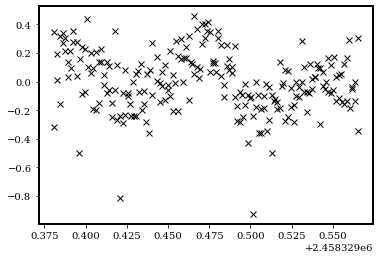

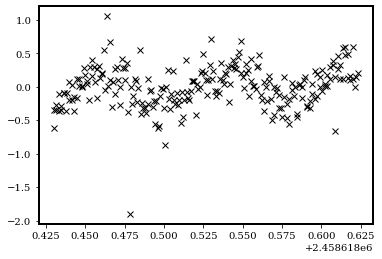

226 240


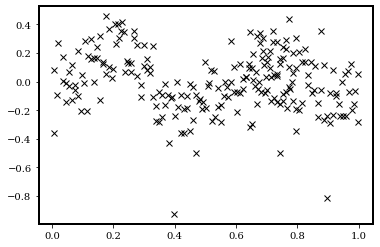

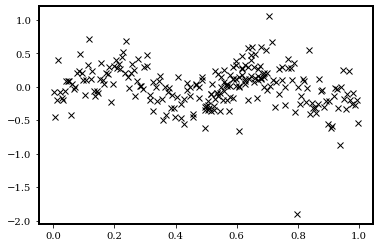

In [20]:
plt.plot(fullWHTSTackTJ,fullWHTSTackFJ,'kx')
plt.show()
plt.plot(fullWHTSTackTM,fullWHTSTackFM,'kx')
plt.show()
allT = np.concatenate((fullWHTSTackTJ,fullWHTSTackTM))
print(len(fullWHTSTackTJ),len(fullWHTSTackTM))
allF = np.concatenate((fullWHTSTackFJ,fullWHTSTackFM))
allPhase = foldMeth(allT,  0.08029820145279275*2)
plt.plot(allPhase[:226],allF[:226],'kx')
plt.show()
plt.plot(allPhase[226:],allF[226:], 'kx')

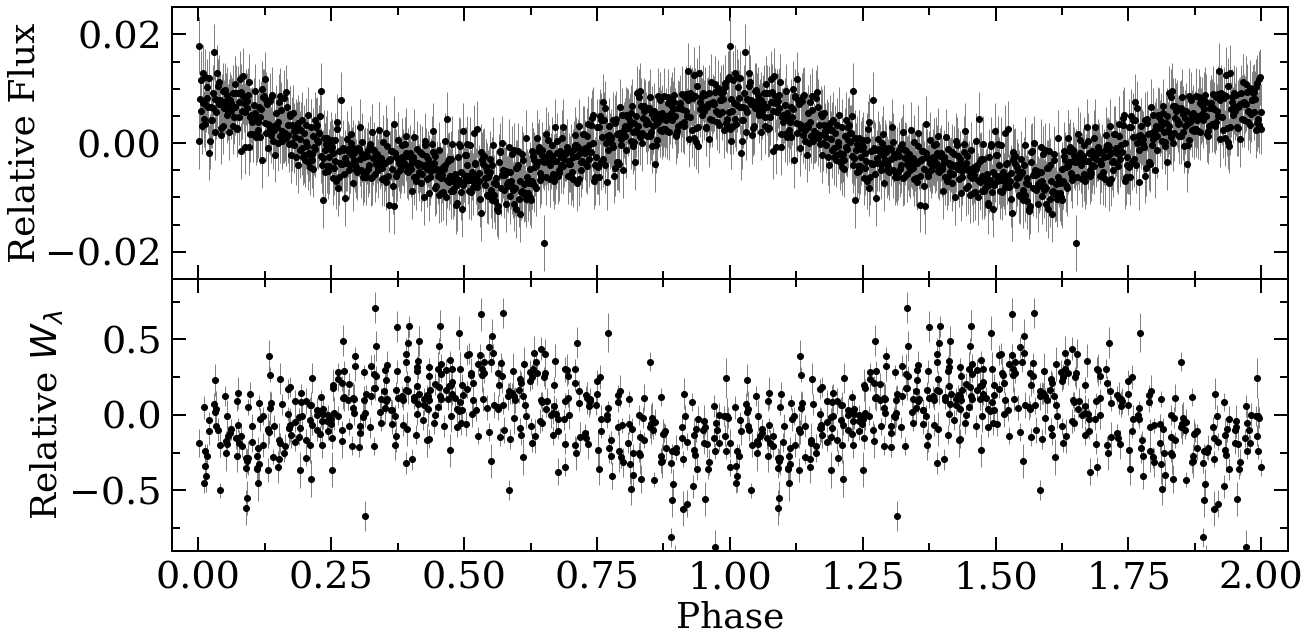

In [20]:
from pylab import rc
rc('axes', linewidth=2)
fig, axs = plt.subplots(2, 1,
                        gridspec_kw={'hspace': 0., 'wspace': 0}, figsize=(20,10))
TESStackTimeAdj = TESSStackTime-2457000.- 1296.0255697684468
TessPhases = foldMeth(TESStackTimeAdj,  0.08029820145279275)
sortIndi = np.argsort(TessPhases)
TessPhases = TessPhases[sortIndi]
TESSStackPhotS = TESSStackPhot[sortIndi]
TESSStackErrS = TESSStackErr[sortIndi]

TESSStackPhotMean = np.nanmean(np.pad(TESSStackPhotS.astype(float), (0, 100 - TESSStackPhotS.size%100), mode='constant', constant_values=np.NaN).reshape(-1, 100), axis=1)
TessPhasesMean = np.nanmean(np.pad(TessPhases.astype(float), (0, 100 - TessPhases.size%100), mode='constant', constant_values=np.NaN).reshape(-1, 100), axis=1)
TESSStackErrSMean = np.nanmean(np.pad(TESSStackErrS.astype(float), (0, 100 - TESSStackErrS.size%100), mode='constant', constant_values=np.NaN).reshape(-1, 100), axis=1)
TESSStackErrSMean = TESSStackErrSMean/np.sqrt(100)

axs[0].errorbar(TessPhasesMean, TESSStackPhotMean, yerr=TESSStackErrSMean, c='k', lw=1, marker='o',ecolor='grey', ls = '')
axs[0].errorbar(TessPhasesMean+1, TESSStackPhotMean, yerr=TESSStackErrSMean, c='k', lw=1, marker='o',ecolor='grey', ls = '')
fullWHTSTackTJAdj = fullWHTSTackTJ-2457000- 1296.0255697684468
fullWHTSTackPhaseJ = foldMeth(fullWHTSTackTJAdj,  0.08029820145279275)
sortIndi = np.argsort(fullWHTSTackPhaseJ)
fullWHTSTackPhaseJ = fullWHTSTackPhaseJ[sortIndi]
fullWHTSTackFSJ = fullWHTSTackFJ[sortIndi]
fullWHTSTackESJ = fullWHTSTackEJ[sortIndi]
fullWHTSTackTMAdj = fullWHTSTackTM - 2457000- 1296.0255697684468
fullWHTSTackPhaseM = foldMeth(fullWHTSTackTMAdj, 0.08029820145279275)
sortIndi = np.argsort(fullWHTSTackPhaseM)
fullWHTSTackPhaseM = fullWHTSTackPhaseM[sortIndi]
fullWHTSTackFSM = fullWHTSTackFM[sortIndi]
fullWHTSTackESM = fullWHTSTackEM[sortIndi]
axs[1].errorbar(fullWHTSTackPhaseM, fullWHTSTackFSM, yerr=fullWHTSTackESM, c='k', lw=1, marker='o',ecolor='grey', ls = '')
axs[1].errorbar(fullWHTSTackPhaseJ, fullWHTSTackFSJ, yerr=fullWHTSTackESJ, c='k', lw=1, marker='o',ecolor='grey', ls = '')
axs[1].errorbar(fullWHTSTackPhaseM+1, fullWHTSTackFSM, yerr=fullWHTSTackESM, c='k', lw=1, marker='o',ecolor='grey', ls = '')
axs[1].errorbar(fullWHTSTackPhaseJ+1, fullWHTSTackFSJ, yerr=fullWHTSTackESJ, c='k', lw=1, marker='o',ecolor='grey', ls = '')



timeRJAdj = np.array(timeRJ)-2457000 - 1296.0255697684468
WHTVelocityPhaseJ = foldMeth(timeRJAdj,  0.08029820145279275)
sortIndi = np.argsort(WHTVelocityPhaseJ)
WHTVelocityPhaseJ = WHTVelocityPhaseJ[sortIndi]
RJSMVelocityS = RJSMVelocity[sortIndi]
RJSMVelocityErrorS = RJSMVelocityError[sortIndi]
timeRMAdj = np.array(timeRM)-2457000 - 1296.0255697684468
WHTVelocityPhaseM = foldMeth(timeRMAdj,  0.08029820145279275)
sortIndi = np.argsort(WHTVelocityPhaseM)
WHTVelocityPhaseM = WHTVelocityPhaseM[sortIndi]
RMSMVelocityS = RMSMVelocity[sortIndi]
RMSMVelocityErrorS = RMSMVelocityError[sortIndi]
#axs[2].errorbar(WHTVelocityPhaseM, RMSMVelocityS, yerr=RMSMVelocityErrorS, c='r', lw=1, marker='o',ecolor='grey', ls = '')
#axs[2].errorbar(WHTVelocityPhaseJ, RJSMVelocityS, yerr=RJSMVelocityErrorS, c='b', lw=1, marker='o',ecolor='grey', ls = '')
#axs[2].errorbar(WHTVelocityPhaseM+1, RMSMVelocityS, yerr=RMSMVelocityErrorS, c='r', lw=1, marker='o',ecolor='grey', ls = '')
#axs[2].errorbar(WHTVelocityPhaseJ+1, RJSMVelocityS, yerr=RJSMVelocityErrorS, c='b', lw=1, marker='o',ecolor='grey', ls = '')
MayKeep2019 = [WHTVelocityPhaseM, RMSMVelocityS, RMSMVelocityErrorS]

xlimits = axs[0].set_xlim()
axs[0].errorbar([-0.06,-0.06], [0,0], yerr=[0.01,0.01],ms=10, c='k', lw=1, marker='o',ecolor='grey', ls = '', label='TESS')
axs[1].errorbar([-0.06,-0.06], [0,0], yerr=[0.01,0.01],ms=10, c='k', lw=1, marker='o',ecolor='grey', ls = '', label='WHT')
#axs[1].errorbar([-0.06,-0.06], [0,0], yerr=[0.01,0.01],ms=10, c='k', lw=1, marker='o',ecolor='grey', ls = '', label='2018 Jul')



axs[0].set_xlim(xlimits)


#axs[0].legend(prop={'size': 30})
#axs[1].legend(prop={'size': 30},loc='upper right')
#axs[2].legend(prop={'size': 30})
axs[1].set_xlabel("Phase", fontsize=36)
axs[0].set_ylabel('Relative Flux', fontsize=36)
axs[1].set_ylabel(r'Relative $W_\lambda$', fontsize=36)
#axs[2].set_ylabel(r'Central Wavelength (Å)', fontsize=36)
#ax.xaxis.set_label_coords(1.0, -0.1)
#ax.set_xlim(0,1)
#ax2.set_xlim(6250,7200)

#ax.set_ylim(0.9,1.12)
axs[0].set_ylim(-0.025,0.025)
axs[0].set_xlim(-0.05,2.05)
axs[1].set_xlim(-0.05,2.05)
#axs[2].set_xlim(-0.05,2.05)
axs[1].set_ylim(-0.9,0.9)
#axs[2].set_ylim(6315,6375)


#ax.yaxis.tick_left()
#ax.tick_params(labelright='off')
#ax2.tick_params(labelright='on')
#ax2.yaxis.tick_right()
#ax2.yaxis.set_label_position("right")


#ax.set_yticks(np.arange(0.9, 1.12, 0.05))
#ax2.set_yticks(np.arange(0.9, 1.12, 0.05))
axs[0].xaxis.set_minor_locator(AutoMinorLocator())
axs[1].xaxis.set_minor_locator(AutoMinorLocator())
#axs[2].yaxis.set_major_locator(MultipleLocator(20))
#ax2.xaxis.set_minor_locator(AutoMinorLocator())
#ax.yaxis.set_minor_locator(AutoMinorLocator())
axs[0].xaxis.set_minor_locator(MultipleLocator(0.125))
axs[0].yaxis.set_minor_locator(MultipleLocator(0.005))
axs[1].xaxis.set_minor_locator(MultipleLocator(0.125))
axs[1].yaxis.set_minor_locator(MultipleLocator(0.25))
#axs[2].xaxis.set_minor_locator(MultipleLocator(0.125))
#axs[2].yaxis.set_minor_locator(MultipleLocator(5))
axs[0].tick_params(which='minor', length=8,direction="in")
axs[1].tick_params(which='minor', length=8,direction="in")
#axs[2].tick_params(which='minor', length=8,direction="in")
axs[0].tick_params(which='both', width=2,direction='in',pad=10)
axs[1].tick_params(which='both', width=2,direction='in',pad=10)
#axs[2].tick_params(which='both', width=2,direction='in',pad=10)
axs[0].tick_params(which='major', length=14,direction='in')
axs[1].tick_params(which='major', length=14,direction='in')
#axs[2].tick_params(which='major', length=14,direction='in')
axs[0].set_xticklabels([])
#axs[1].set_xticklabels([])
#ax.tick_params(which='minor', length=8)
#ax2.tick_params(which='both', width=4)
#ax2.tick_params(which='major', length=14)
#ax2.tick_params(which='minor', length=8)
axs[0].tick_params(labelsize=38)
axs[1].tick_params(labelsize=38)
#axs[2].tick_params(labelsize=38)
axs[0].xaxis.set_ticks_position('both')
axs[1].xaxis.set_ticks_position('both')
#axs[2].xaxis.set_ticks_position('both')


axs[0].yaxis.set_ticks_position('both')
axs[1].yaxis.set_ticks_position('both')
#axs[2].yaxis.set_ticks_position('both')
#ax2.tick_params(labelsize=23)
bboxx = transforms.Bbox([[0.18, 0.1], [18.22, 8.85]])

plt.savefig('PhotometryHSTv2.pdf',bbox_inches=bboxx)
#plt.savefig('Figure2Updated.eps', bbox_inches='tight', pad_inches=0.8) 
plt.show()

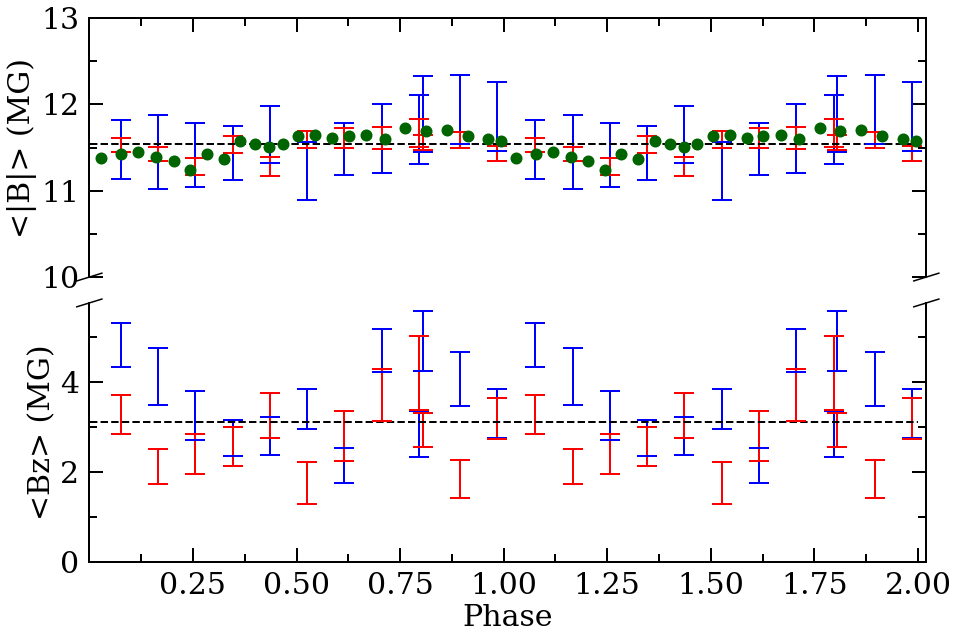

In [68]:
#!!! Try Hollow circles


from pylab import rc
labelsize=30

Times = [2458766.316477858,2458766.323699965,2458766.330933671,2458766.338178977,
             2458766.345528382,2458766.352657989,2458766.359891695,2458766.367125401,
             2458766.374347507,2458766.381581212,2458766.388814918,2458766.396060123]

RJBEst = np.load('RJBEst.npy')
RJErrComb = np.load('RJBEste.npy')
RMBEst = np.load('RMBEst.npy')
RMErrComb = np.load('RMBEste.npy')
timeRJAdj = np.array(timeRJ)-2457000 - 1296.0255697684468
timeRMAdj = np.array(timeRM)-2457000 - 1296.0255697684468
specTime = np.append(timeRJAdj,timeRMAdj)
WHTVelocityPhase = foldMeth(specTime,  0.08029820145279275)
sortIndi = np.argsort(WHTVelocityPhase)
WHTVelocityPhase = WHTVelocityPhase[sortIndi]
spectroField = np.append(RJBEst,RMBEst)
spectroField = spectroField[sortIndi]
spectroErr = np.append(RJErrComb,RMErrComb)
spectroErr = spectroErr[sortIndi]
binsize=10
WHTVelocityPhase = np.nanmean(np.pad(WHTVelocityPhase.astype(float), (0, binsize - WHTVelocityPhase.size%binsize), mode='constant', constant_values=np.NaN).reshape(-1, binsize), axis=1)
spectroField = np.nanmean(np.pad(spectroField.astype(float), (0, binsize - spectroField.size%binsize), mode='constant', constant_values=np.NaN).reshape(-1, binsize), axis=1)
spectroErr = np.nanmean(np.pad(spectroErr.astype(float), (0, binsize - spectroErr.size%binsize), mode='constant', constant_values=np.NaN).reshape(-1, binsize), axis=1)
spectroErr = spectroErr/np.sqrt(binsize)

firstB = np.array([11.56, 11.59, 11.43, 11.53, 11.43, 11.28, 11.54, 11.28, 11.59, 11.61, 11.61, 11.67])
firstE = np.array([0.09,0.09,0.09,0.08,0.08,0.10,0.10,0.11,0.10,0.12,0.13,0.16])
secondB = np.array([11.89,11.94,11.86,11.48,11.45,11.41,11.44,11.65,11.23,11.48,11.61,11.71])
secondE = np.array([0.44,0.40,0.40,0.34,0.43,0.37,0.31,0.33,0.34,0.30,0.40,0.40])
rc('axes', linewidth=2)
#, 'height_ratios':[1,2]
f, (ax, ax2) = plt.subplots(2, 1, sharex=True,  gridspec_kw={'hspace': 0.1, 'wspace': 0.},figsize=(15,10))
Times = np.array(Times)-2457000- 1296.0255697684468
fullWHTSTackPhaseJ = foldMeth(Times,  0.08029820145279275)
sortIndi = np.argsort(fullWHTSTackPhaseJ)
fullWHTSTackPhaseJ = fullWHTSTackPhaseJ[sortIndi]
fullWHTSTackFSJ = secondB[sortIndi]
redPoints = firstB[sortIndi]
redError = firstE[sortIndi]
secondE = secondE[sortIndi]
ax.plot([0.001,2],[11.54,11.54],c='k',ls='dashed',linewidth=2)
#ax.errorbar(WHTVelocityPhase, spectroField, yerr=spectroErr, c='k', lw=1, marker='x',markeredgewidth=2,ecolor='k', ls = '', mfc='none',ms=10, capsize=10,elinewidth=2)
#ax.errorbar(WHTVelocityPhase+1, spectroField, yerr=spectroErr, c='k', lw=1, marker='x',markeredgewidth=2,ecolor='k', ls = '', mfc='none',ms=10, capsize=10,elinewidth=2)
ax.errorbar(fullWHTSTackPhaseJ,fullWHTSTackFSJ,yerr=secondE,label='Hβ', c='b', lw=1, marker='',markeredgewidth=2,ecolor='b', ls = '', mfc='none',ms=10, capsize=10,elinewidth=2)
ax.errorbar(fullWHTSTackPhaseJ,redPoints,yerr=redError,label='Hα', c='r', lw=1, marker='',markeredgewidth=2,ecolor='r', ls = '', mfc='none',ms=10, capsize=10,elinewidth=2)
ax.errorbar(fullWHTSTackPhaseJ+1,fullWHTSTackFSJ,yerr=secondE, c='b', lw=1, marker='',markeredgewidth=2,ecolor='b', ls = '', mfc='none',ms=10, capsize=10,elinewidth=2)
ax.errorbar(fullWHTSTackPhaseJ+1,redPoints,yerr=redError, c='r', lw=1, marker='',markeredgewidth=2,ecolor='r', ls = '', mfc='none',ms=10, capsize=10,elinewidth=2)
#ax.plot(WHTVelocityPhase+1, spectroField+0.28, markerfacecolor='g', lw=1, marker='o',markeredgewidth=2, ls = '',ms=10,markeredgecolor='yellow')
ax.plot(WHTVelocityPhase, spectroField+0.28, c='darkgreen', lw=1, marker='o',markeredgewidth=2, ls = '',ms=10)
#ax.errorbar(WHTVelocityPhase, spectroField+0.28, yerr=spectroErr, markerfacecolor='g', lw=1, marker='o',markeredgewidth=2,ecolor='g', ls = '',markeredgecolor='yellow',ms=10, capsize=10,elinewidth=2)
ax.plot(WHTVelocityPhase+1, spectroField+0.28, c='darkgreen', lw=1, marker='o',markeredgewidth=2, ls = '',ms=10)


Times = [2458766.316477858,2458766.323699965,2458766.330933671,2458766.338178977,
             2458766.345528382,2458766.352657989,2458766.359891695,2458766.367125401,
             2458766.374347507,2458766.381581212,2458766.388814918,2458766.396060123]
bzred = np.array([2.93,1.84,3.18,3.27,2.11,2.39,2.56,3.24,1.75,2.80,3.71,4.20])
bzredE = np.array([0.38,0.43,0.46,0.43,0.39,0.45,0.43,0.50,0.46,0.56,0.58,0.82])
bzblue = np.array([4.90,4.06,3.29,4.81,4.12,3.25,2.75,2.80,3.39,2.14,4.69,2.84])
bzblueE = np.array([0.66,0.60,0.55,0.49,0.63,0.55,0.41,0.42,0.45,0.39,0.48,0.52])

Times = np.array(Times)-2457000- 1296.0255697684468
fullWHTSTackPhaseJ = foldMeth(Times,  0.08029820145279275)
sortIndi = np.argsort(fullWHTSTackPhaseJ)
fullWHTSTackPhaseJ = fullWHTSTackPhaseJ[sortIndi]
bzred = bzred[sortIndi]
bzredE = bzredE[sortIndi]
bzblue = bzblue[sortIndi]
bzblueE = bzblueE[sortIndi]
ax2.plot([0.001,2],[3.1,3.1],c='k',ls='dashed',linewidth=2)
ax2.errorbar(fullWHTSTackPhaseJ,bzblue,yerr=bzblueE, c='b', lw=1, marker='',markeredgewidth=2,ecolor='b', ls = '', mfc='none',ms=10, capsize=10,elinewidth=2)
ax2.errorbar(fullWHTSTackPhaseJ,bzred,yerr=bzredE, c='r', lw=1, marker='',markeredgewidth=2,ecolor='r', ls = '', mfc='none',ms=10, capsize=10,elinewidth=2)
ax2.errorbar(fullWHTSTackPhaseJ+1,bzblue,yerr=bzblueE, c='b', lw=1, marker='',markeredgewidth=2,ecolor='b', ls = '', mfc='none',ms=10, capsize=10,elinewidth=2)
ax2.errorbar(fullWHTSTackPhaseJ+1,bzred,yerr=bzredE, c='r', lw=1, marker='',markeredgewidth=2,ecolor='r', ls = '', mfc='none',ms=10, capsize=10,elinewidth=2)

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
#ax.legend(prop={'size': 30})

ax2.set_xlabel("Phase", fontsize=labelsize)
ax.set_ylabel(r'<|B|> (MG)', fontsize=labelsize)
ax2.set_ylabel(r'<Bz> (MG)', fontsize=labelsize)

ax.set_xlim(0.000001,2.02)
ax2.set_ylim(0.000,5.75)
ax.set_ylim(11.5-1.5,11.5+1.5)
#ax.yaxis.tick_left()
#ax.tick_params(labelright='off')
#ax2.tick_params(labelright='on')
#ax2.yaxis.tick_right()
#ax2.yaxis.set_label_position("right")


#ax.set_yticks(np.arange(0.9, 1.12, 0.05))
#ax2.set_yticks(np.arange(0.9, 1.12, 0.05))
ax.xaxis.set_minor_locator(MultipleLocator(0.25/2))
ax2.xaxis.set_minor_locator(MultipleLocator(0.25/2))

#axs[0].xaxis.set_minor_locator(MultipleLocator(0.125))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax2.yaxis.set_minor_locator(MultipleLocator(1))
#axs[1].xaxis.set_minor_locator(MultipleLocator(0.125))
#axs[1].yaxis.set_minor_locator(MultipleLocator(0.25))
#axs[2].xaxis.set_minor_locator(MultipleLocator(0.125))
#axs[2].yaxis.set_minor_locator(MultipleLocator(250))
ax.tick_params(which='minor', length=8,direction="in")
ax2.tick_params(which='minor', length=8,direction="in")

ax.tick_params(which='both', width=2,direction='in',pad=10)
ax2.tick_params(which='both', width=2,direction='in',pad=10)

ax.tick_params(which='major', length=14,direction='in')
ax2.tick_params(which='major', length=14,direction='in')
#ax.set_xticklabels([])
#axs[1].set_xticklabels([])
ax2.xaxis.tick_bottom()

ax.tick_params(labelsize=labelsize)
ax2.tick_params(labelsize=labelsize)
ax.xaxis.set_ticks_position('top')
ax.tick_params(labeltop=False)

ax2.xaxis.set_ticks_position('bottom')



ax.yaxis.set_ticks_position('both')
ax2.yaxis.set_ticks_position('both')

bboxx = transforms.Bbox([[0.71,0.32], [13.86, 8.97]])
plt.savefig('Bz_B_phasedUp.pdf',bbox_inches=bboxx) 
#plt.savefig('Figure2Updated.eps', bbox_inches='tight', pad_inches=0.8) 
plt.show()

In [35]:
Times = [2458766.316477858,2458766.323699965,2458766.330933671,2458766.338178977,
             2458766.345528382,2458766.352657989,2458766.359891695,2458766.367125401,
             2458766.374347507,2458766.381581212,2458766.388814918,2458766.396060123]


Times = np.array(Times)-2457000- 1296.0255697684468
fullWHTSTackPhaseJ = foldMeth(Times,  0.08029820145279275)
sortIndi = np.argsort(fullWHTSTackPhaseJ)
#fullWHTSTackPhaseJ = fullWHTSTackPhaseJ[sortIndi]
print(fullWHTSTackPhaseJ)

[0.80500411 0.89494519 0.98503072 0.07526071 0.1667871  0.25557623
 0.34566176 0.43574729 0.52568836 0.61577387 0.70585941 0.79608814]


In [55]:
from scipy.optimize import leastsq
def sineFitLevenbergMarquardtRV(time, flux):
    phases = np.linspace(0, 2*np.pi, 1000)
    amplitudes = np.linspace(0,1000,10000)
    def model(time, amp,phase):
        return amp*np.sin(time*(2*np.pi/0.08029823681469193)+phase)
    x0 = (500,0)
    #xamp = 500
    def residuals(par, flux, time):
        return flux - model(time,par[0], par[1])
    x, flag = leastsq(residuals, x0, args=(flux, time))

    return x




In [64]:
velocityTimes = np.append(timeRJ,timeRM)
velocities = np.append(RJSMVelocity,RMSMVelocity)
print(sineFitLevenbergMarquardtRV(velocityTimes, velocities))

[-2.01870065e+02 -5.54071342e-02]


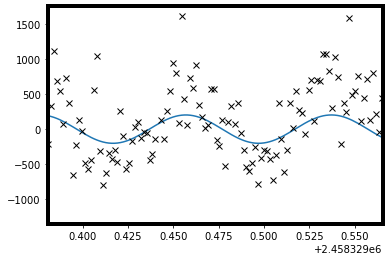

In [62]:
plt.plot(velocityTimes,sineFitLevenbergMarquardtRV(velocityTimes, velocities)[0]*np.sin(velocityTimes*(2*np.pi/0.08029823681469193)+sineFitLevenbergMarquardtRV(velocityTimes, velocities)[1]))
plt.xlim(timeRJ[0],timeRJ[-1])
plt.plot(velocityTimes,velocities,'kx')

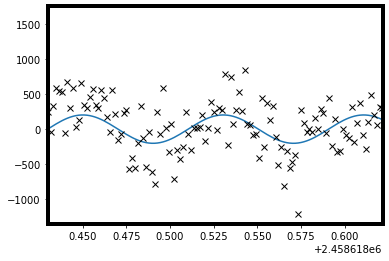

In [63]:
plt.plot(velocityTimes,sineFitLevenbergMarquardtRV(velocityTimes, velocities)[0]*np.sin(velocityTimes*(2*np.pi/0.08029823681469193)+sineFitLevenbergMarquardtRV(velocityTimes, velocities)[1]))
plt.xlim(timeRM[0],timeRM[-1])
plt.plot(velocityTimes,velocities,'kx')

200.71598599636127
4.393903310312453


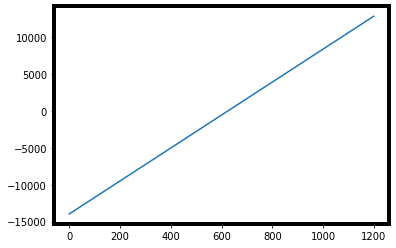

In [68]:
#200 km/s
#delX = 
RJXpoints = np.linspace(5525, 7575, 4200)
RJXpoints = RJXpoints[:4100]
xpointss = RJXpoints[800:3350]
velocity = 299792.458*(xpointss[700:1900]-6562.801)/6562.801
plt.plot(velocity)
#velocity = 299792.458*(xpointss[700:1900]-6562.801)/6562.801
print(velocity[9]-velocity[0])
print(xpointss[9]-xpointss[0])


#del lambda = 4.39

#0.3-0.4MG is del B

[ 3.57264107e+15  2.40422806e+15  3.93690220e+15 -2.05683114e+15
 -1.30471457e+14  1.35432503e+15 -2.66861407e+15 -5.70850713e+15
  1.92942601e+15 -2.00348088e+15 -4.79138410e+15 -1.43017535e+15
 -9.63089964e+14  1.23241648e+15 -1.32286415e+15 -4.87215333e+15
 -3.89281061e+15 -4.11341323e+15 -1.86335560e+14 -4.10817578e+15
  5.51659934e+15 -1.72374541e+15 -1.38016183e+15 -8.83763168e+15
  1.90549303e+15 -5.04505220e+15 -1.69054913e+15 -1.85237105e+15
 -1.23691740e+16 -5.42357296e+15 -1.39142853e+16 -5.03471242e+15
 -1.40069559e+15 -6.22602599e+15 -1.12000852e+14 -3.97760630e+15
  1.33993382e+15 -6.24971397e+15 -1.35773430e+15 -8.30787150e+15
 -1.48463971e+15 -2.90285883e+15 -2.79413275e+15 -7.47586622e+15
 -2.41415293e+15 -5.07608989e+15 -1.53047522e+15 -4.29603571e+15
 -6.42874748e+13 -4.94286281e+15 -2.27928273e+14 -7.27474942e+15
  8.06223865e+14 -5.13187809e+15 -4.27861592e+15 -1.06059832e+15
  1.12528014e+15 -1.59264336e+15 -1.51225966e+15 -1.08595523e+16
  1.99822301e+15 -4.67695

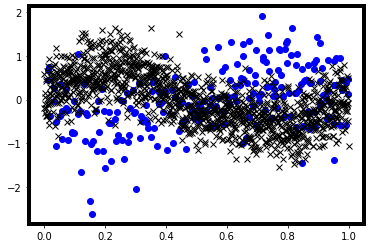

In [45]:
from PyAstronomy.pyasl import foldAt
phasesWHTJ = foldAt(fullWHTSTackTJ,0.08029867,T0=0)
sortIndi = np.argsort(phasesWHTJ)
# ... and, second, rearrange the arrays.
phasesWHTJ = phasesWHTJ[sortIndi]
fullWHTSTackFJS = fullWHTSTackFJ[sortIndi]
print(fullWHTSTackFJS/np.mean(fullWHTSTackFJS))
# Plot the result
plt.plot(phasesWHTJ, fullWHTSTackFJS, 'bo')




TessPhases = foldAt(TESSStackTime,0.08029867,T0=0)
sortIndi = np.argsort(TessPhases)
# ... and, second, rearrange the arrays.
TessPhases = TessPhases[sortIndi]
TESSStackPhotS = TESSStackPhot[sortIndi]
TESSStackPhotMean = np.nanmean(np.pad(TESSStackPhotS.astype(float), (0, 50 - TESSStackPhotS.size%50), mode='constant', constant_values=np.NaN).reshape(-1, 50), axis=1)
TessPhasesMean = np.nanmean(np.pad(TessPhases.astype(float), (0, 50 - TessPhases.size%50), mode='constant', constant_values=np.NaN).reshape(-1, 50), axis=1)

plt.plot(TessPhasesMean,TESSStackPhotMean*100,'kx')

In [4]:
fff = open("timeBM", "r")
timeBM = []
for x in fff:
    x = float(x)
    timeBM.append(x)
    
fff = open("timeRM", "r")
timeRM = []
for x in fff:
    x = float(x)
    timeRM.append(x)
    
fff = open("timeBJ", "r")
timeBJ = []
for x in fff:
    x = float(x)
    timeBJ.append(x)
    
fff = open("timeRJ", "r")
timeRJ = []
for x in fff:
    x = float(x)
    timeRJ.append(x)
    
BJXpoints = np.linspace(3625, 5460, 4200)
print(BJXpoints[665:3485])

RJXpoints = np.linspace(5525, 7575, 4200)
print(RJXpoints[800:3200])

countGlob = 1
holder_arrayBM = []

path = 'C:/Users/Admin/newMay19/'
consts = []
with open(path+'BTarOutDis') as file:
    for line in file:
        line = line.strip('\n')
        filepath = path + line
        hdul = fits.open(filepath)
        typeEx = hdul[0].data
        typeEx = typeEx[1]
        typeEx = typeEx.flatten()

        hdul.close()
        if countGlob == 1:
            
            holder_arrayBM = typeEx
        else:
            
            holder_arrayBM = np.vstack((holder_arrayBM, typeEx))
        countGlob = 2
countGlob = 1
holder_arrayBJ = []

path = 'C:/Users/Admin/newJul18/'
consts = []
with open(path+'BTarOutDis') as file:
    for line in file:
        line = line.strip('\n')
        filepath = path + line
        hdul = fits.open(filepath)
        typeEx = hdul[0].data
        typeEx = typeEx[1]
        typeEx = typeEx.flatten()

        hdul.close()
        if countGlob == 1:
            
            holder_arrayBJ = typeEx
        else:
            
            holder_arrayBJ = np.vstack((holder_arrayBJ, typeEx))
        countGlob = 2
        
countGlob = 1
holder_arrayRJ = []

path = 'C:/Users/Admin/newJul18/'
consts = []
with open(path+'RTarOutDis') as file:
    for line in file:
        line = line.strip('\n')
        filepath = path + line
        hdul = fits.open(filepath)
        typeEx = hdul[0].data
  
        typeEx = typeEx[1]
        typeEx = typeEx.flatten()

        hdul.close()
        if countGlob == 1:
            
            holder_arrayRJ = typeEx
        else:
            
            holder_arrayRJ = np.vstack((holder_arrayRJ, typeEx))
        countGlob = 2

countGlob = 1
holder_arrayRM = []

path = 'C:/Users/Admin/newMay19/'
consts = []
with open(path+'RTarOutDis') as file:
    for line in file:
        line = line.strip('\n')
        filepath = path + line
        hdul = fits.open(filepath)
        typeEx = hdul[0].data
        typeEx = typeEx[1]
        typeEx = typeEx.flatten()

        hdul.close()
        if countGlob == 1:
            
            holder_arrayRM = typeEx
        else:
            
            holder_arrayRM = np.vstack((holder_arrayRM, typeEx))
        countGlob = 2

[3915.61085973 3916.04786854 3916.48487735 ... 5146.66468207 5147.10169088
 5147.53869969]
[5915.56918314 5916.05739462 5916.5456061  ... 7085.81209812 7086.3003096
 7086.78852108]


In [6]:
BJXpoints[1]-BJXpoints[0] #0.43700881162203586
RJXpoints[1]-RJXpoints[0] #0.4882114789234038

0.4882114789234038

In [5]:
def straightLine(xpoints,ypoints,inXpoints):
    gradient = (ypoints[1]-ypoints[0])/(xpoints[1]-xpoints[0])
    intercept = ypoints[0] - (gradient*xpoints[0])
    outYpoints = (inXpoints*gradient)+intercept
    return outYpoints
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def area_est(xpoints, ypoints, start, finish):
    
    startIdx = find_nearest(xpoints, start)
    finishIdx = find_nearest(xpoints, finish)
    xpoints = xpoints[startIdx:finishIdx]
    ypoints = ypoints[startIdx:finishIdx]
    areaEst = np.trapz(ypoints, x=xpoints)
    #offset = np.abs(min(ypoints))
    #ypoints = ypoints + offset
    #dx = xpoints[2]-xpoints[1]
    #areaEst = 0
    #for i in range(len(ypoints)-1):
        #areaEst = areaEst + ((ypoints[i]+ypoints[i+1])*dx/2)
    return areaEst
xpoints=np.linspace(0,4200,4200)
def median_average(array, N):
    result = []
    for i in range(0, int(np.shape(array)[0]/N)+1):
        tmparray = array[i*N:(i*N+N)]
        tmparray = np.median(tmparray,axis=0)
        if i == 0:
            result = tmparray
            
        else:
            result = np.vstack([result, tmparray])
            
    return result


def f(x, c, q,A, B): 
    return c*x*x*x + q*x*x + A*x + B

def f2(x, d,c, q,A, B): 
    return d*x*x*x*x + c*x*x*x + q*x*x + A*x + B
def f3(x, c, q,A): 
    return c*x*x + q*x + A

def f5(x, c, q,A,b,d,z): 
    return c*x*x*x*x*x + q*x*x*x*x + A*x*x*x + b*x*x + d*x+z

def foldMeth(timeArray, period):
    phases = []
    for el in timeArray:
        passed = int(el/period)
        leftover = el - (passed*period)
        phase = leftover/period
        phases.append(phase)
    return np.array(phases)

In [6]:
BJXpoints = np.linspace(3625, 5460, 4200)
BJXpoints = BJXpoints[:4100]
xpointss = BJXpoints[1500:3800]
xp1 = xpointss[0:35]
xp2 = xpointss[125:800]
xp3 = xpointss[1100:1180]
xp4 = xpointss[1330:1440]
xp5 = xpointss[1550:2400]
xpF = np.append(xp1,xp2)
xpF = np.append(xpF, xp3)
xpF = np.append(xpF, xp4)
xpF = np.append(xpF, xp5)
testMean = np.zeros(len(xpointss))
for i in range(113):
    flux = holder_arrayBJ[i]
    flux = flux[:4100]
    flux = flux[1500:3800]
    tmp1 = flux[0:35]
    tmp2 = flux[125:800]
    tmp3 = flux[1100:1180]
    tmp4 = flux[1330:1440]
    tmp5 = flux[1550:2400]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    try:
        popt, pcov = curve_fit(f, xpF, emptiedflux)
        nans_array = np.argwhere(np.isnan(emptiedflux))
    except ValueError:
        emptiedfluxCleaner = gaussian_filter(emptiedflux, sigma=1)
        for el in nans_array:
            emptiedflux[el] = emptiedfluxCleaner[el]
        popt, pcov = curve_fit(f, xpF, emptiedflux)
    fluxNormed = flux/f(xpointss, popt[0], popt[1], popt[2], popt[3])
    for count, el in enumerate(fluxNormed):
        if el > 1.2:
            fluxNormed[count] = np.median(fluxNormed[count-100:count+100])
            
    fluxNormed = fluxNormed * f(xpointss, popt[0], popt[1], popt[2], popt[3])
    tmp1 = fluxNormed[0:35]
    tmp2 = fluxNormed[125:800]
    tmp3 = fluxNormed[1100:1180]
    tmp4 = fluxNormed[1330:1440]
    tmp5 = fluxNormed[1550:2400]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    try:
        popt, pcov = curve_fit(f, xpF, emptiedflux)
        nans_array = np.argwhere(np.isnan(emptiedflux))
    except ValueError:
        emptiedfluxCleaner = gaussian_filter(emptiedflux, sigma=1)
        for el in nans_array:
            emptiedflux[el] = emptiedfluxCleaner[el]
        popt, pcov = curve_fit(f, xpF, emptiedflux)
    fluxNormed = fluxNormed/f(xpointss, popt[0], popt[1], popt[2], popt[3])
    testMean = testMean + fluxNormed

    fluxNormed = fluxNormed #- testMeanBJ
    if i ==0:
        stack = fluxNormed[800:1600]
    else:
        stack = np.vstack((stack, fluxNormed[800:1600]))
testMean = testMean /113
stackBJ = stack
testMeanBJ = testMean





BJXpoints = np.linspace(3625, 5460, 4200)
BJXpoints = BJXpoints[:4100]
xpointss = BJXpoints[1500:3800]
xp1 = xpointss[0:35]
xp2 = xpointss[125:800]
xp3 = xpointss[1100:1180]
xp4 = xpointss[1330:1440]
xp5 = xpointss[1550:2400]
xpF = np.append(xp1,xp2)
xpF = np.append(xpF, xp3)
xpF = np.append(xpF, xp4)
xpF = np.append(xpF, xp5)
testMean = np.zeros(len(xpointss))

for i in range(120):
    flux = holder_arrayBM[i]
    flux = flux[:4100]
    flux = flux[1500:3800]
    tmp1 = flux[0:35]
    tmp2 = flux[125:800]
    tmp3 = flux[1100:1180]
    tmp4 = flux[1330:1440]
    tmp5 = flux[1550:2400]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    try:
        popt, pcov = curve_fit(f, xpF, emptiedflux)
        nans_array = np.argwhere(np.isnan(emptiedflux))
    except ValueError:
        emptiedfluxCleaner = gaussian_filter(emptiedflux, sigma=1)
        for el in nans_array:
            emptiedflux[el] = emptiedfluxCleaner[el]
        popt, pcov = curve_fit(f, xpF, emptiedflux)
    fluxNormed = flux/f(xpointss, popt[0], popt[1], popt[2], popt[3])
    for count, el in enumerate(fluxNormed):
        if el > 1.2:
            fluxNormed[count] = np.median(fluxNormed[count-25:count+100])
            
    fluxNormed = fluxNormed * f(xpointss, popt[0], popt[1], popt[2], popt[3])
    tmp1 = fluxNormed[0:35]
    tmp2 = fluxNormed[125:800]
    tmp3 = fluxNormed[1100:1180]
    tmp4 = fluxNormed[1330:1440]
    tmp5 = fluxNormed[1550:2400]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    try:
        popt, pcov = curve_fit(f, xpF, emptiedflux)
    except ValueError:
        nans_array = np.argwhere(np.isnan(emptiedflux))
        emptiedfluxCleaner = gaussian_filter(emptiedflux, sigma=1)
        for el in nans_array:
            
            emptiedflux[el[0]] = np.nanmean(emptiedflux)
        popt, pcov = curve_fit(f, xpF, emptiedflux)
    fluxNormed = fluxNormed/f(xpointss, popt[0], popt[1], popt[2], popt[3])
    testMean = testMean + fluxNormed
    fluxNormed = fluxNormed# - testMeanBM
    if i ==0:
        stack = fluxNormed[800:1600]
    else:
        stack = np.vstack((stack, fluxNormed[800:1600]))
testMean = testMean /120 
stackBM = stack
testMeanBM = testMean

D:\conda\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\conda\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [25]:
#0.95-0.05 -> 0   0
#0.05-0.15 -> 0.1 1
#0.15-0.25 -> 0.2 2
#0.25-0.35 -> 0.3 3
#0.35-0.45 -> 0.4 4
#0.45-0.55 -> 0.5 5
#0.55-0.65 -> 0.6 6
#0.65-0.75 -> 0.7 7
#0.75-0.85 -> 0.8 8
#0.85-0.95 -> 0.9 9

timeRJAdj = np.array(timeRJ)-2457000- 1296.0255697684468
#print(foldMeth(timeBJAdj, 0.08029820145279275))
count = 0
for el in foldMeth(timeRJAdj, 0.08029820145279275):
    print(count, '   ', el)
    count= count+1

0     0.39033722091011885
1     0.41168587990105715
2     0.43362146502949844
3     0.4563740053656855
4     0.4764126364494027
5     0.4964496727669645
6     0.5164867090845264
7     0.5365233220641634
8     0.5644906607409876
9     0.5845271229427336
10     0.6045645825982203
11     0.6246004706841504
12     0.6446369386850459
13     0.6692403124287454
14     0.6892800917440944
15     0.7093177021774721
16     0.7293543151571091
17     0.749391925590487
18     0.7694289619080488
19     0.7894659982256107
20     0.8095036202572877
21     0.8295412306906655
22     0.8495776928924115
23     0.8696164457582715
24     0.8896545027261726
25     0.9096938471052975
26     0.9297297235929283
27     0.9497661857946742
28     0.9698043819421672
29     0.9898431348080271
30     0.00988249078538057
31     0.029918367273011292
32     0.049955403590573155
33     0.06999185419401979
34     0.09002889051158165
35     0.11006478439666134
36     0.1301008116621831
37     0.16946054504271854
38     0.18

In [26]:
timeRMAdj = np.array(timeRM)-2457000- 1296.0255697684468
#print(foldMeth(timeBJAdj, 0.08029820145279275))
count = 0
for el in foldMeth(timeRMAdj, 0.08029820145279275):
    print(count, '   ', el)
    count= count+1

0     0.09022684638473914
1     0.11026377251845755
2     0.13030128436629118
3     0.15033879041497514
4     0.17037629066450946
5     0.1904132109990782
6     0.21045014873109594
7     0.23048766057892955
8     0.2505251550293142
9     0.2705620811630326
10     0.29059901889505035
11     0.31063594502876873
12     0.3306734394791534
13     0.35071095132698704
14     0.37074730334488953
15     0.3907842294786079
16     0.41082288375892373
17     0.43086500013158396
18     0.4509025003811183
19     0.47094058054561816
20     0.4909780923934518
21     0.5110144444113542
22     0.5310507790318078
23     0.5510877051655262
24     0.5711252170133598
25     0.5911615690312623
26     0.6111979210491648
27     0.6312342730670673
28     0.651271767517452
29     0.6713086936511704
30     0.6913450456690728
31     0.7113813802895264
32     0.7314211943997733
33     0.7514575464176758
34     0.771495620783026
35     0.7915325411175947
36     0.8115694672513132
37     0.8316064049833309
38     0.8

In [7]:
julyPhasedStack = stackBJ[17]+stackBJ[18]+stackBJ[66]+stackBJ[67]
julyPhasedStack = julyPhasedStack/4
tmp = stackBJ[19]+stackBJ[20]+stackBJ[21]+stackBJ[68]+stackBJ[69]+stackBJ[70]
tmp = tmp/6
julyPhasedStack = np.vstack((julyPhasedStack, tmp))
tmp = stackBJ[22]+stackBJ[23]+stackBJ[71]+stackBJ[72]
tmp = tmp/4
julyPhasedStack = np.vstack((julyPhasedStack, tmp))
tmp = stackBJ[24]+stackBJ[25]+stackBJ[26]+stackBJ[73]+stackBJ[74]
tmp = tmp/5
julyPhasedStack = np.vstack((julyPhasedStack, tmp))
tmp = stackBJ[27]+stackBJ[28]+stackBJ[75]+stackBJ[76]+stackBJ[77]
tmp = tmp/5
julyPhasedStack = np.vstack((julyPhasedStack, tmp))
tmp = stackBJ[29]+stackBJ[30]+stackBJ[31]+stackBJ[78]+stackBJ[79]
tmp = tmp/5
julyPhasedStack = np.vstack((julyPhasedStack, tmp))
tmp = stackBJ[32]+stackBJ[33]+stackBJ[80]+stackBJ[81]+stackBJ[82]
tmp = tmp/5
julyPhasedStack = np.vstack((julyPhasedStack, tmp))
tmp = stackBJ[34]+stackBJ[35]+stackBJ[36]+stackBJ[83]+stackBJ[84]
tmp = tmp/5
julyPhasedStack = np.vstack((julyPhasedStack, tmp))
tmp = stackBJ[37]+stackBJ[85]+stackBJ[86]+stackBJ[87]
tmp = tmp/4
julyPhasedStack = np.vstack((julyPhasedStack, tmp))
tmp = stackBJ[38]+stackBJ[39]+stackBJ[40]+stackBJ[88]+stackBJ[89]
tmp = tmp/5
julyPhasedStack = np.vstack((julyPhasedStack, tmp))
tmp = stackBJ[41]+stackBJ[42]+stackBJ[90]+stackBJ[91]+stackBJ[92]
tmp = tmp/5
julyPhasedStack = np.vstack((julyPhasedStack, tmp))
tmp = stackBJ[43]+stackBJ[44]+stackBJ[45]+stackBJ[93]+stackBJ[94]
tmp = tmp/5
julyPhasedStack = np.vstack((julyPhasedStack, tmp))
tmp = stackBJ[46]+stackBJ[47]+stackBJ[95]+stackBJ[96]+stackBJ[97]
tmp = tmp/5
julyPhasedStack = np.vstack((julyPhasedStack, tmp))
tmp = stackBJ[0]+stackBJ[1]+stackBJ[2]+stackBJ[48]+stackBJ[49]+stackBJ[50]+stackBJ[98]+stackBJ[99]
tmp = tmp/8
julyPhasedStack = np.vstack((julyPhasedStack, tmp))
tmp = stackBJ[3]+stackBJ[4]+stackBJ[51]+stackBJ[52]+stackBJ[100]+stackBJ[101]+stackBJ[102]
tmp = tmp/7
julyPhasedStack = np.vstack((julyPhasedStack, tmp))
tmp = stackBJ[5]+stackBJ[6]+stackBJ[7]+stackBJ[53]+stackBJ[54]+stackBJ[55]+stackBJ[103]+stackBJ[104]
tmp = tmp/8
julyPhasedStack = np.vstack((julyPhasedStack, tmp))
tmp = stackBJ[8]+stackBJ[9]+stackBJ[56]+stackBJ[57]+stackBJ[105]+stackBJ[106]+stackBJ[107]
tmp = tmp/7
julyPhasedStack = np.vstack((julyPhasedStack, tmp))
tmp = stackBJ[10]+stackBJ[11]+stackBJ[58]+stackBJ[59]+stackBJ[60]+stackBJ[108]+stackBJ[109]
tmp = tmp/7
julyPhasedStack = np.vstack((julyPhasedStack, tmp))
tmp = stackBJ[12]+stackBJ[13]+stackBJ[61]+stackBJ[62]+stackBJ[110]+stackBJ[111]
tmp = tmp/6
julyPhasedStack = np.vstack((julyPhasedStack, tmp))
tmp = stackBJ[14]+stackBJ[15]+stackBJ[16]+stackBJ[63]+stackBJ[64]+stackBJ[65]+stackBJ[112]
tmp = tmp/7
julyPhasedStack = np.vstack((julyPhasedStack, tmp))

In [8]:
mayPhasedStack = stackBM[34]+stackBM[35]+stackBM[83]+stackBM[84]
mayPhasedStack = mayPhasedStack/4
tmp = stackBM[36]+stackBM[37]+stackBM[38]+stackBM[85]+stackBM[86]+stackBM[87]
tmp = tmp/6
mayPhasedStack = np.vstack((mayPhasedStack, tmp))
tmp = stackBM[39]+stackBM[40]+stackBM[88]+stackBM[89]
tmp = tmp/4
mayPhasedStack = np.vstack((mayPhasedStack, tmp))
tmp = stackBM[41]+stackBM[42]+stackBM[90]+stackBM[91]+stackBM[92]
tmp = tmp/5
mayPhasedStack = np.vstack((mayPhasedStack, tmp))
tmp = stackBM[43]+stackBM[44]+stackBM[45]+stackBM[93]+stackBM[94]
tmp = tmp/5
mayPhasedStack = np.vstack((mayPhasedStack, tmp))
tmp = stackBM[46]+stackBM[47]+stackBM[95]+stackBM[96]+stackBM[97]
tmp = tmp/5
mayPhasedStack = np.vstack((mayPhasedStack, tmp))
tmp = stackBM[0]+stackBM[48]+stackBM[49]+stackBM[50]+stackBM[98]+stackBM[99]
tmp = tmp/6
mayPhasedStack = np.vstack((mayPhasedStack, tmp))
tmp = stackBM[1]+stackBM[2]+stackBM[3]+stackBM[51]+stackBM[52]+stackBM[100]+stackBM[101]+stackBM[102]
tmp = tmp/8
mayPhasedStack = np.vstack((mayPhasedStack, tmp))
tmp = stackBM[4]+stackBM[5]+stackBM[53]+stackBM[54]+stackBM[55]+stackBM[103]+stackBM[104]
tmp = tmp/7
mayPhasedStack = np.vstack((mayPhasedStack, tmp))
tmp = stackBM[6]+stackBM[7]+stackBM[8]+stackBM[56]+stackBM[57]+stackBM[105]+stackBM[106]+stackBM[107]
tmp = tmp/8
mayPhasedStack = np.vstack((mayPhasedStack, tmp))
tmp = stackBM[9]+stackBM[10]+stackBM[58]+stackBM[59]+stackBM[60]+stackBM[108]+stackBM[109]
tmp = tmp/7
mayPhasedStack = np.vstack((mayPhasedStack, tmp))
tmp = stackBM[11]+stackBM[12]+stackBM[13]+stackBM[61]+stackBM[62]+stackBM[110]+stackBM[111]+stackBM[112]
tmp = tmp/8
mayPhasedStack = np.vstack((mayPhasedStack, tmp))
tmp = stackBM[14]+stackBM[15]+stackBM[63]+stackBM[64]+stackBM[65]+stackBM[113]+stackBM[114]
tmp = tmp/7
mayPhasedStack = np.vstack((mayPhasedStack, tmp))
tmp = stackBM[16]+stackBM[17]+stackBM[18]+stackBM[66]+stackBM[67]+stackBM[115]+stackBM[116]+stackBM[117]
tmp = tmp/8
mayPhasedStack = np.vstack((mayPhasedStack, tmp))
tmp = stackBM[19]+stackBM[20]+stackBM[68]+stackBM[69]+stackBM[70]+stackBM[118]+stackBM[119]
tmp = tmp/7
mayPhasedStack = np.vstack((mayPhasedStack, tmp))
tmp = stackBM[21]+stackBM[22]+stackBM[23]+stackBM[71]+stackBM[72]
tmp = tmp/5
mayPhasedStack = np.vstack((mayPhasedStack, tmp))
tmp = stackBM[24]+stackBM[25]+stackBM[73]+stackBM[74]+stackBM[75]
tmp = tmp/5
mayPhasedStack = np.vstack((mayPhasedStack, tmp))
tmp = stackBM[26]+stackBM[27]+stackBM[28]+stackBM[76]+stackBM[77]
tmp = tmp/5
mayPhasedStack = np.vstack((mayPhasedStack, tmp))
tmp = stackBM[29]+stackBM[30]+stackBM[78]+stackBM[79]+stackBM[80]
tmp = tmp/5
mayPhasedStack = np.vstack((mayPhasedStack, tmp))
tmp = stackBM[31]+stackBM[32]+stackBM[33]+stackBM[81]+stackBM[82]
tmp = tmp/5
mayPhasedStack = np.vstack((mayPhasedStack, tmp))

In [9]:
phasedStackS = stackBJ[36]+stackBJ[85]+stackBM[53]+stackBM[4]+stackBM[103]
phasedStackS = phasedStackS/5
tmp = stackBJ[37]+stackBJ[86]+stackBM[5]+stackBM[54]+stackBM[104]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[38]+stackBJ[87]+stackBM[6]+stackBM[55]+stackBM[105]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[39]+stackBJ[88]+stackBM[7]+stackBM[56]+stackBM[106]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[40]+stackBJ[89]+stackBM[8]+stackBM[57]+stackBM[107]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[41]+stackBJ[90]+stackBM[9]+stackBM[58]+stackBM[108]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[42]+stackBJ[91]+stackBM[10]+stackBM[59]+stackBM[109]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[43]+stackBJ[92]+stackBM[11]+stackBM[60]+stackBM[110]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[44]+stackBJ[93]+stackBM[12]+stackBM[61]+stackBM[111]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[45]+stackBJ[94]+stackBM[13]+stackBM[62]+stackBM[112]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[46]+stackBJ[95]+stackBM[14]+stackBM[63]+stackBM[113]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[47]+stackBJ[96]+stackBM[15]+stackBM[64]+stackBM[114]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[0]+stackBJ[48]+stackBJ[97]+stackBM[16]+stackBM[65]+stackBM[115]
tmp = tmp/6
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[1]+stackBJ[49]+stackBJ[98]+stackBM[17]+stackBM[66]+stackBM[116]
tmp = tmp/6
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[2]+stackBJ[50]+stackBJ[99]+stackBM[18]+stackBM[67]+stackBM[117]
tmp = tmp/6
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[51]+stackBJ[100]+stackBM[19]+stackBM[68]+stackBM[118]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[3]+stackBJ[52]+stackBJ[101]+stackBM[20]+stackBM[69]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[4]+stackBJ[53]+stackBJ[102]+stackBM[21]+stackBM[70]+stackBM[119]
tmp = tmp/6
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[5]+stackBJ[54]+stackBJ[103]+stackBM[22]+stackBM[71]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[6]+stackBJ[55]+stackBJ[104]+stackBM[23]+stackBM[72]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[7]+stackBJ[56]+stackBJ[105]+stackBM[24]+stackBM[73]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[8]+stackBJ[57]+stackBJ[106]+stackBM[25]+stackBM[74]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[9]+stackBJ[58]+stackBJ[107]+stackBM[26]+stackBM[75]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[10]+stackBJ[108]+stackBM[27]+stackBM[76]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[11]+stackBJ[59]+stackBJ[109]+stackBM[77]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[12]+stackBJ[60]+stackBJ[110]+stackBM[28]+stackBM[78]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[13]+stackBJ[61]+stackBJ[111]+stackBM[29]+stackBM[79]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[14]+stackBJ[62]+stackBJ[112]+stackBM[30]+stackBM[80]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[15]+stackBJ[63]+stackBM[31]+stackBM[81]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[16]+stackBJ[64]+stackBM[32]+stackBM[82]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[17]+stackBJ[65]+stackBM[33]+stackBM[83]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[18]+stackBJ[66]+stackBM[34]+stackBM[84]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[19]+stackBJ[67]+stackBM[35]+stackBM[85]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[20]+stackBJ[68]+stackBM[36]+stackBM[86]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[21]+stackBJ[69]+stackBM[37]+stackBM[87]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[22]+stackBJ[70]+stackBM[38]+stackBM[88]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[23]+stackBJ[71]+stackBM[39]+stackBM[89]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[24]+stackBJ[72]+stackBM[40]+stackBM[90]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[25]+stackBJ[73]+stackBM[41]+stackBM[91]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[26]+stackBJ[74]+stackBM[42]+stackBM[92]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[27]+stackBJ[75]+stackBM[43]+stackBM[93]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[28]+stackBJ[76]+stackBM[44]+stackBM[94]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[29]+stackBJ[77]+stackBM[45]+stackBM[95]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[30]+stackBJ[78]+stackBM[46]+stackBM[96]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[31]+stackBJ[79]+stackBM[47]+stackBM[97]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[32]+stackBJ[80]+stackBM[48]+stackBM[98]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[33]+stackBJ[81]+stackBM[0]+stackBM[49]+stackBM[99]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[34]+stackBJ[82]+stackBM[1]+stackBM[50]+stackBM[100]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[83]+stackBM[2]+stackBM[51]+stackBM[101]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[35]+stackBJ[84]+stackBM[3]+stackBM[52]+stackBM[102]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
print(np.shape(phasedStackS))

(50, 800)


In [10]:
phasedStackS = stackBJ[36][2:-18]+stackBJ[85][2:-18]+stackBM[53][10:-10]+stackBM[4][10:-10]+stackBM[103][10:-10]
phasedStackS = phasedStackS/5
tmp = stackBJ[37][2:-18]+stackBJ[86][2:-18]+stackBM[5][10:-10]+stackBM[54][10:-10]+stackBM[104][10:-10]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[38][2:-18]+stackBJ[87][2:-18]+stackBM[6][10:-10]+stackBM[55][10:-10]+stackBM[105][10:-10]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[39][2:-18]+stackBJ[88][2:-18]+stackBM[7][10:-10]+stackBM[56][10:-10]+stackBM[106][10:-10]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[40][2:-18]+stackBJ[89][2:-18]+stackBM[8][10:-10]+stackBM[57][10:-10]+stackBM[107][10:-10]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[41][2:-18]+stackBJ[90][2:-18]+stackBM[9][10:-10]+stackBM[58][10:-10]+stackBM[108][10:-10]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[42][2:-18]+stackBJ[91][2:-18]+stackBM[10][10:-10]+stackBM[59][10:-10]+stackBM[109][10:-10]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[43][2:-18]+stackBJ[92][2:-18]+stackBM[11][10:-10]+stackBM[60][10:-10]+stackBM[110][10:-10]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[44][2:-18]+stackBJ[93][2:-18]+stackBM[12][10:-10]+stackBM[61][10:-10]+stackBM[111][10:-10]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[45][2:-18]+stackBJ[94][2:-18]+stackBM[13][10:-10]+stackBM[62][10:-10]+stackBM[112][10:-10]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[46][2:-18]+stackBJ[95][2:-18]+stackBM[14][10:-10]+stackBM[63][10:-10]+stackBM[113][10:-10]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[47][2:-18]+stackBJ[96][2:-18]+stackBM[15][10:-10]+stackBM[64][10:-10]+stackBM[114][10:-10]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[0][2:-18]+stackBJ[48][2:-18]+stackBJ[97][2:-18]+stackBM[16][10:-10]+stackBM[65][10:-10]+stackBM[115][10:-10]
tmp = tmp/6
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[1][2:-18]+stackBJ[49][2:-18]+stackBJ[98][2:-18]+stackBM[17][10:-10]+stackBM[66][10:-10]+stackBM[116][10:-10]
tmp = tmp/6
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[2][2:-18]+stackBJ[50][2:-18]+stackBJ[99][2:-18]+stackBM[18][10:-10]+stackBM[67][10:-10]+stackBM[117][10:-10]
tmp = tmp/6
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[51][2:-18]+stackBJ[100][2:-18]+stackBM[19][10:-10]+stackBM[68][10:-10]+stackBM[118][10:-10]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[3][2:-18]+stackBJ[52][2:-18]+stackBJ[101][2:-18]+stackBM[20][10:-10]+stackBM[69][10:-10]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[4][2:-18]+stackBJ[53][2:-18]+stackBJ[102][2:-18]+stackBM[21][10:-10]+stackBM[70][10:-10]+stackBM[119][10:-10]
tmp = tmp/6
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[5][2:-18]+stackBJ[54][2:-18]+stackBJ[103][2:-18]+stackBM[22][10:-10]+stackBM[71][10:-10]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[6][2:-18]+stackBJ[55][2:-18]+stackBJ[104][2:-18]+stackBM[23][10:-10]+stackBM[72][10:-10]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[7][2:-18]+stackBJ[56][2:-18]+stackBJ[105][2:-18]+stackBM[24][10:-10]+stackBM[73][10:-10]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[8][2:-18]+stackBJ[57][2:-18]+stackBJ[106][2:-18]+stackBM[25][10:-10]+stackBM[74][10:-10]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[9][2:-18]+stackBJ[58][2:-18]+stackBJ[107][2:-18]+stackBM[26][10:-10]+stackBM[75][10:-10]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[10][2:-18]+stackBJ[108][2:-18]+stackBM[27][10:-10]+stackBM[76][10:-10]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[11][2:-18]+stackBJ[59][2:-18]+stackBJ[109][2:-18]+stackBM[77][10:-10]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[12][2:-18]+stackBJ[60][2:-18]+stackBJ[110][2:-18]+stackBM[28][10:-10]+stackBM[78][10:-10]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[13][2:-18]+stackBJ[61][2:-18]+stackBJ[111][2:-18]+stackBM[29][10:-10]+stackBM[79][10:-10]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[14][2:-18]+stackBJ[62][2:-18]+stackBJ[112][2:-18]+stackBM[30][10:-10]+stackBM[80][10:-10]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[15][2:-18]+stackBJ[63][2:-18]+stackBM[31][10:-10]+stackBM[81][10:-10]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[16][2:-18]+stackBJ[64][2:-18]+stackBM[32][10:-10]+stackBM[82][10:-10]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[17][2:-18]+stackBJ[65][2:-18]+stackBM[33][10:-10]+stackBM[83][10:-10]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[18][2:-18]+stackBJ[66][2:-18]+stackBM[34][10:-10]+stackBM[84][10:-10]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[19][2:-18]+stackBJ[67][2:-18]+stackBM[35][10:-10]+stackBM[85][10:-10]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[20][2:-18]+stackBJ[68][2:-18]+stackBM[36][10:-10]+stackBM[86][10:-10]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[21][2:-18]+stackBJ[69][2:-18]+stackBM[37][10:-10]+stackBM[87][10:-10]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[22][2:-18]+stackBJ[70][2:-18]+stackBM[38][10:-10]+stackBM[88][10:-10]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[23][2:-18]+stackBJ[71][2:-18]+stackBM[39][10:-10]+stackBM[89][10:-10]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[24][2:-18]+stackBJ[72][2:-18]+stackBM[40][10:-10]+stackBM[90][10:-10]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[25][2:-18]+stackBJ[73][2:-18]+stackBM[41][10:-10]+stackBM[91][10:-10]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[26][2:-18]+stackBJ[74][2:-18]+stackBM[42][10:-10]+stackBM[92][10:-10]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[27][2:-18]+stackBJ[75][2:-18]+stackBM[43][10:-10]+stackBM[93][10:-10]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[28][2:-18]+stackBJ[76][2:-18]+stackBM[44][10:-10]+stackBM[94][10:-10]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[29][2:-18]+stackBJ[77][2:-18]+stackBM[45][10:-10]+stackBM[95][10:-10]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[30][2:-18]+stackBJ[78][2:-18]+stackBM[46][10:-10]+stackBM[96][10:-10]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[31][2:-18]+stackBJ[79][2:-18]+stackBM[47][10:-10]+stackBM[97][10:-10]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[32][2:-18]+stackBJ[80][2:-18]+stackBM[48][10:-10]+stackBM[98][10:-10]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[33][2:-18]+stackBJ[81][2:-18]+stackBM[0][10:-10]+stackBM[49][10:-10]+stackBM[99][10:-10]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[34][2:-18]+stackBJ[82][2:-18]+stackBM[1][10:-10]+stackBM[50][10:-10]+stackBM[100][10:-10]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[83][2:-18]+stackBM[2][10:-10]+stackBM[51][10:-10]+stackBM[101][10:-10]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[35][2:-18]+stackBJ[84][2:-18]+stackBM[3][10:-10]+stackBM[52][10:-10]+stackBM[102][10:-10]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
print(np.shape(phasedStackS))

(50, 780)


In [11]:
def groupedAvg(myArray, N=2):
    result = np.cumsum(myArray, 0)[N-1::N]/float(N)
    result[1:] = result[1:] - result[:-1]
    return result

phasedStackSAvg = groupedAvg(phasedStackS, 5)
print(np.shape(phasedStackSAvg))

(10, 780)


In [12]:
#updated phase stack
phasedStackS = stackBJ[27][2:-18]+stackBJ[28][2:-18]+stackBJ[29][2:-18]+stackBJ[30][2:-18]+stackBJ[31][2:-18]+stackBJ[76][2:-18]+stackBJ[77][2:-18]+stackBJ[78][2:-18]+stackBJ[79][2:-18]+stackBJ[80][2:-18]+stackBM[43][10:-10]+stackBM[44][10:-10]+stackBM[45][10:-10]+stackBM[46][10:-10]+stackBM[47][10:-10]+stackBM[92][10:-10]+stackBM[93][10:-10]+stackBM[94][10:-10]+stackBM[95][10:-10]+stackBM[96][10:-10]
phasedStackS = phasedStackS/20
tmp = stackBJ[32][2:-18]+stackBJ[33][2:-18]+stackBJ[34][2:-18]+stackBJ[35][2:-18]+stackBJ[36][2:-18]+stackBJ[81][2:-18]+stackBJ[82][2:-18]+stackBJ[83][2:-18]+stackBJ[84][2:-18]+stackBJ[85][2:-18]+stackBM[0][10:-10]+stackBM[1][10:-10]+stackBM[2][10:-10]+stackBM[48][10:-10]+stackBM[49][10:-10]+stackBM[50][10:-10]+stackBM[51][10:-10]+stackBM[52][10:-10]+stackBM[97][10:-10]+stackBM[98][10:-10]+stackBM[99][10:-10]+stackBM[100][10:-10]+stackBM[101][10:-10]
tmp = tmp/23
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[37][2:-18]+stackBJ[38][2:-18]+stackBJ[39][2:-18]+stackBJ[40][2:-18]+stackBJ[86][2:-18]+stackBJ[87][2:-18]+stackBJ[88][2:-18]+stackBJ[89][2:-18]+stackBJ[90][2:-18]+stackBM[3][10:-10]+stackBM[4][10:-10]+stackBM[5][10:-10]+stackBM[6][10:-10]+stackBM[7][10:-10]+stackBM[53][10:-10]+stackBM[54][10:-10]+stackBM[55][10:-10]+stackBM[56][10:-10]+stackBM[57][10:-10]+stackBM[102][10:-10]+stackBM[103][10:-10]+stackBM[104][10:-10]+stackBM[105][10:-10]+stackBM[106][10:-10]
tmp = tmp/24
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[41][2:-18]+stackBJ[42][2:-18]+stackBJ[43][2:-18]+stackBJ[44][2:-18]+stackBJ[45][2:-18]+stackBJ[91][2:-18]+stackBJ[92][2:-18]+stackBJ[93][2:-18]+stackBJ[94][2:-18]+stackBJ[95][2:-18]+stackBM[8][10:-10]+stackBM[9][10:-10]+stackBM[10][10:-10]+stackBM[11][10:-10]+stackBM[12][10:-10]+stackBM[58][10:-10]+stackBM[59][10:-10]+stackBM[60][10:-10]+stackBM[61][10:-10]+stackBM[62][10:-10]+stackBM[107][10:-10]+stackBM[108][10:-10]+stackBM[109][10:-10]+stackBM[110][10:-10]+stackBM[111][10:-10]
tmp = tmp/25
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[0][2:-18]+stackBJ[1][2:-18]+stackBJ[2][2:-18]+stackBJ[46][2:-18]+stackBJ[47][2:-18]+stackBJ[48][2:-18]+stackBJ[49][2:-18]+stackBJ[50][2:-18]+stackBJ[96][2:-18]+stackBJ[97][2:-18]+stackBJ[98][2:-18]+stackBJ[99][2:-18]+stackBJ[100][2:-18]+stackBM[13][10:-10]+stackBM[14][10:-10]+stackBM[15][10:-10]+stackBM[16][10:-10]+stackBM[17][10:-10]+stackBM[63][10:-10]+stackBM[64][10:-10]+stackBM[65][10:-10]+stackBM[66][10:-10]+stackBM[67][10:-10]+stackBM[112][10:-10]+stackBM[113][10:-10]+stackBM[114][10:-10]+stackBM[115][10:-10]+stackBM[116][10:-10]
tmp = tmp/28
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[3][2:-18]+stackBJ[4][2:-18]+stackBJ[5][2:-18]+stackBJ[6][2:-18]+stackBJ[7][2:-18]+stackBJ[51][2:-18]+stackBJ[52][2:-18]+stackBJ[53][2:-18]+stackBJ[54][2:-18]+stackBJ[55][2:-18]+stackBJ[101][2:-18]+stackBJ[102][2:-18]+stackBJ[103][2:-18]+stackBJ[104][2:-18]+stackBJ[105][2:-18]+stackBM[18][10:-10]+stackBM[19][10:-10]+stackBM[20][10:-10]+stackBM[21][10:-10]+stackBM[22][10:-10]+stackBM[68][10:-10]+stackBM[69][10:-10]+stackBM[70][10:-10]+stackBM[71][10:-10]+stackBM[72][10:-10]+stackBM[117][10:-10]+stackBM[118][10:-10]+stackBM[119][10:-10]
tmp = tmp/28
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[8][2:-18]+stackBJ[9][2:-18]+stackBJ[10][2:-18]+stackBJ[11][2:-18]+stackBJ[12][2:-18]+stackBJ[56][2:-18]+stackBJ[57][2:-18]+stackBJ[58][2:-18]+stackBJ[59][2:-18]+stackBJ[60][2:-18]+stackBJ[106][2:-18]+stackBJ[107][2:-18]+stackBJ[108][2:-18]+stackBJ[109][2:-18]+stackBJ[110][2:-18]+stackBM[23][10:-10]+stackBM[24][10:-10]+stackBM[25][10:-10]+stackBM[26][10:-10]+stackBM[27][10:-10]+stackBM[73][10:-10]+stackBM[74][10:-10]+stackBM[75][10:-10]+stackBM[76][10:-10]+stackBM[77][10:-10]
tmp = tmp/25
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[13][2:-18]+stackBJ[14][2:-18]+stackBJ[15][2:-18]+stackBJ[16][2:-18]+stackBJ[61][2:-18]+stackBJ[62][2:-18]+stackBJ[63][2:-18]+stackBJ[64][2:-18]+stackBJ[65][2:-18]+stackBJ[111][2:-18]+stackBJ[112][2:-18]+stackBM[28][10:-10]+stackBM[29][10:-10]+stackBM[30][10:-10]+stackBM[31][10:-10]+stackBM[32][10:-10]+stackBM[78][10:-10]+stackBM[79][10:-10]+stackBM[80][10:-10]+stackBM[81][10:-10]+stackBM[82][10:-10]
tmp = tmp/21
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[17][2:-18]+stackBJ[18][2:-18]+stackBJ[19][2:-18]+stackBJ[20][2:-18]+stackBJ[21][2:-18]+stackBJ[66][2:-18]+stackBJ[67][2:-18]+stackBJ[68][2:-18]+stackBJ[69][2:-18]+stackBJ[70][2:-18]+stackBM[33][10:-10]+stackBM[34][10:-10]+stackBM[35][10:-10]+stackBM[36][10:-10]+stackBM[37][10:-10]+stackBM[83][10:-10]+stackBM[84][10:-10]+stackBM[85][10:-10]+stackBM[86][10:-10]+stackBM[87][10:-10]
tmp = tmp/20
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackBJ[22][2:-18]+stackBJ[23][2:-18]+stackBJ[24][2:-18]+stackBJ[25][2:-18]+stackBJ[26][2:-18]+stackBJ[71][2:-18]+stackBJ[72][2:-18]+stackBJ[73][2:-18]+stackBJ[74][2:-18]+stackBJ[75][2:-18]+stackBM[38][10:-10]+stackBM[39][10:-10]+stackBM[40][10:-10]+stackBM[41][10:-10]+stackBM[42][10:-10]+stackBM[88][10:-10]+stackBM[89][10:-10]+stackBM[90][10:-10]+stackBM[91][10:-10]
tmp = tmp/19
phasedStackS = np.vstack((phasedStackS, tmp))
print(np.shape(phasedStackS))

(10, 780)


In [13]:
datJul = phasedStackSAvg[3]-phasedStackSAvg[8]

datJul = np.nanmean(np.pad(datJul.astype(float), (0, 3 - datJul.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
x = xpointss[810:1590]
#x = np.nanmean(np.pad(x.astype(float), (0, 3 - x.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)


dat = np.array([x,phasedStackSAvg[3]])

dat = dat.T

np.savetxt('maxFieldSpec.dat', dat, delimiter = '\t')


datJul = phasedStackSAvg[8]

datJul = np.nanmean(np.pad(datJul.astype(float), (0, 3 - datJul.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
x = xpointss[810:1590]
#x = np.nanmean(np.pad(x.astype(float), (0, 3 - x.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)


dat = np.array([x,phasedStackSAvg[8]])

dat = dat.T

np.savetxt('minFieldSpec.dat', dat, delimiter = '\t')


datJul = phasedStackSAvg[8]

datJul = np.nanmean(np.pad(datJul.astype(float), (0, 3 - datJul.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
x = xpointss[810:1590]

D:\conda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
D:\conda\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
D:\conda\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


D:\conda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
D:\conda\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
D:\conda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
D:\conda\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
D:\conda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
D:\conda\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
D:\conda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
D:\conda\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
D:\conda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
D:\conda\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
D:\conda\lib\site-package

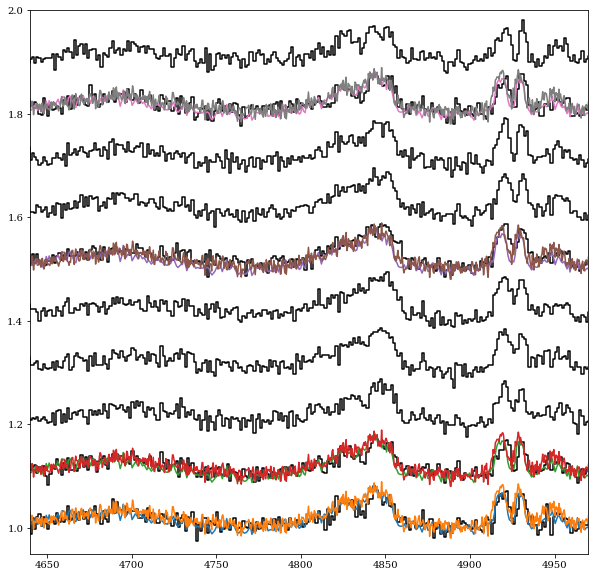

In [14]:
plt.figure(figsize=(10,10))
for k in range(10):
    
    datJul = phasedStackS[k]+0.1*k
    datJul = np.nanmean(np.pad(datJul.astype(float), (0, 3 - datJul.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
    x = xpointss[810:1590]
    x = np.nanmean(np.pad(x.astype(float), (0, 3 - x.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
    xss = (x[1]-x[0])/2
    xs = [x[0]-xss]
    ys = [0]
    for i in range(len(x)):
        xs.append(x[i] - xss)
        xs.append(x[i] + xss)
        ys.append(datJul[i])
        ys.append(datJul[i])
    xs.append(x[-1] + xss)
    ys.append(0)
    plt.plot(np.array(xs)-1.3110264348661076,ys, c='k')
    plt.ylim(0.95,2)
    plt.xlim(4640,4970)
    
    
BKeepFlux = phasedStackS
BKeepX = xpointss[810:1590]
indata = np.loadtxt("specpolNormed.dat", usecols=(0,1))
wavelength = indata[:,0]
intensity = indata[:,1]
plt.plot(wavelength,intensity)

indata = np.loadtxt("WHTBJ.dat", usecols=(0,1))
wavelengthWHT = indata[:,0]
intensityWHT = indata[:,1]
plt.plot(wavelengthWHT,intensityWHT)


plt.plot(wavelength,intensity+0.1)
plt.plot(wavelengthWHT,intensityWHT+0.1)

plt.plot(wavelength,intensity+0.5)
plt.plot(wavelengthWHT,intensityWHT+0.5)

plt.plot(wavelength,intensity+0.8)
plt.plot(wavelengthWHT,intensityWHT+0.8)

In [15]:
RJXpoints = np.linspace(5525, 7575, 4200)
RJXpoints = RJXpoints[:4100]
xpointss = RJXpoints[800:3350]

testMean = np.zeros(len(xpointss))

xp1 = xpointss[:720]
xp2 = xpointss[1050:1225]
xp3 = xpointss[1400:1650]
xp4 = xpointss[1900:1940]
xp5 = xpointss[2400:2550]
xpF = np.append(xp1,xp2)
xpF = np.append(xpF, xp3)
xpF = np.append(xpF, xp4)
xpF = np.append(xpF, xp5)
for i in range(113):
    flux = holder_arrayRJ[i]
    if i ==11:
        flux[2725:2745] = np.median(flux[2700:2725])
    if i ==99:
        flux[1580:1600] = np.clip(flux[1580:1600],0,500)
    if i ==111:
        flux[2250:2300] = np.clip(flux[2250:2300], 0,270)
    if i == 43:
        flux[1900:2100] = np.clip(flux[1900:2100], 0,500)
    if i == 109:
        flux[1100:1200] = np.clip(flux[1100:1200],0,500)
    if i ==42:
        flux[2695:2735] = np.clip(flux[2695:2735],0, 400)
    if i == 18:
        flux[2000:3350] = np.clip(flux[2000:3350],0, 500)
    if i ==105:
        flux[2200:2220] = np.clip(flux[2200:2220], 0,350)
    flux = flux[:4100]
    flux = flux[800:3350]
    if i ==44:
        for c, el1 in enumerate(flux[1000:1150]):
            flux[1000+c] = ((1-c/150)*np.median(flux[950:1000])+(c/150)*np.median(flux[1150:1200]))
    tmp1 = flux[:720]
    tmp2 = flux[1050:1225]
    tmp3 = flux[1400:1650]
    tmp4 = flux[1900:1940]
    tmp5 = flux[2400:2550]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    popt, pcov = curve_fit(f2, xpF, uniform_filter(emptiedflux,size=20))
    fluxNormed = flux/f2(xpointss, popt[0], popt[1], popt[2], popt[3], popt[4])
    for count, el in enumerate(fluxNormed):
        if el > 1.15:
            fluxNormed[count] = uniform_filter(fluxNormed,size=200)[count]
        
    fluxNormed = fluxNormed * f2(xpointss, popt[0], popt[1], popt[2], popt[3],popt[4])
    tmp1 = flux[:720]
    tmp2 = flux[1050:1225]
    tmp3 = flux[1400:1650]
    tmp4 = flux[1900:1940]
    tmp5 = flux[2400:2550]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    popt, pcov = curve_fit(f2, xpF, uniform_filter(emptiedflux,size=20))
    fluxNormed = fluxNormed/f2(xpointss, popt[0], popt[1], popt[2], popt[3], popt[4])
    testMean = testMean + fluxNormed
    fluxNormed = fluxNormed #- testMeanRJ
    #plt.plot(xpointss[700:1900], testMean[700:1900])
    #plt.title(str(i))
    #plt.plot(xpointss[700:1900], fluxNormed[700:1900], c='k')
    #plt.plot(xpointss[1600:1900], testMean[1600:1900], c='r')
    #plt.show()
    if i ==0:
        stack = fluxNormed[700:1900]
    else:
        stack = np.vstack((stack, fluxNormed[700:1900]))
testMeanRJ = testMean/113   
stackRJ = stack

In [16]:
RJXpoints = np.linspace(5525, 7575, 4200)
RJXpoints = RJXpoints[:4100]
xpointss = RJXpoints[800:3350]


testMean = np.zeros(len(xpointss))
xp1 = xpointss[:720]
xp2 = xpointss[1050:1225]
xp3 = xpointss[1400:1650]
xp4 = xpointss[1900:1940]
xp5 = xpointss[2400:2550]
xpF = np.append(xp1,xp2)
xpF = np.append(xpF, xp3)
xpF = np.append(xpF, xp4)
xpF = np.append(xpF, xp5)
for i in range(120):
    flux = holder_arrayRM[i]
    if i ==12:
        flux[2395:2410] = np.clip(flux[2395:2410], 0,350)
    if i ==40:
        flux[990:1010]= np.clip(flux[990:1010], 0, 460)
        flux[3645:3670] = np.clip(flux[3645:3670], 0,200)
    if i ==45:
        flux[2310:2335]= np.clip(flux[2310:2335],0,300)
    if i ==65:
        flux[1420:1455] = np.clip(flux[1420:1455], 0,500)
    if i ==69:
        flux[1950:1970] = np.clip(flux[1950:1970],0,400)
    if i == 83:
        flux[1855:1870] = np.clip(flux[1855:1870],0,400)
        flux[2120:2130] = np.clip(flux[2120:2130],0,400)
    flux = flux[:4100]
    flux = flux[800:3350]

    tmp1 = flux[:720]
    tmp2 = flux[1050:1225]
    tmp3 = flux[1400:1650]
    tmp4 = flux[1900:1940]
    tmp5 = flux[2400:2550]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    popt, pcov = curve_fit(f2, xpF, uniform_filter(emptiedflux,size=20))
    fluxNormed = flux/f2(xpointss, popt[0], popt[1], popt[2], popt[3], popt[4])
    for count, el in enumerate(fluxNormed):
        if el > 1.15:
            fluxNormed[count] = uniform_filter(fluxNormed,size=200)[count]
        
    fluxNormed = fluxNormed * f2(xpointss, popt[0], popt[1], popt[2], popt[3],popt[4])
    tmp1 = flux[:720]
    tmp2 = flux[1050:1225]
    tmp3 = flux[1400:1650]
    tmp4 = flux[1900:1940]
    tmp5 = flux[2400:2550]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    popt, pcov = curve_fit(f2, xpF, uniform_filter(emptiedflux,size=20))
    fluxNormed = fluxNormed/f2(xpointss, popt[0], popt[1], popt[2], popt[3], popt[4])
    testMean = testMean + fluxNormed
    fluxNormed = fluxNormed# - testMeanRM
    
    if i ==0:
        stack = fluxNormed[700:1900]
    else:
        stack = np.vstack((stack, fluxNormed[700:1900]))
testMeanRM = testMean /120  
stackRM = stack

In [17]:
#dont run!!
!!!!!!!!!!!!!!!!!
RJXpoints = np.linspace(5525, 7575, 4200)
RJXpoints = RJXpoints[:4100]
xpointss = RJXpoints[800:3350]


testMean = np.zeros(len(xpointss))
xp1 = xpointss[:720]
xp2 = xpointss[1050:1225]
xp3 = xpointss[1400:1650]
xp4 = xpointss[1900:1940]
xp5 = xpointss[2400:2550]
xpF = np.append(xp1,xp2)
xpF = np.append(xpF, xp3)
xpF = np.append(xpF, xp4)
xpF = np.append(xpF, xp5)
for i in range(120):
    flux = holder_arrayRM[i]
    if i ==12:
        flux[2395:2410] = np.clip(flux[2395:2410], 0,350)
    if i ==40:
        flux[990:1010]= np.clip(flux[990:1010], 0, 460)
        flux[3645:3670] = np.clip(flux[3645:3670], 0,200)
    if i ==45:
        flux[2310:2335]= np.clip(flux[2310:2335],0,300)
    if i ==65:
        flux[1420:1455] = np.clip(flux[1420:1455], 0,500)
    if i ==69:
        flux[1950:1970] = np.clip(flux[1950:1970],0,400)
    if i == 83:
        flux[1855:1870] = np.clip(flux[1855:1870],0,400)
        flux[2120:2130] = np.clip(flux[2120:2130],0,400)
    flux = flux[:4100]
    flux = flux[800:3350]

    tmp1 = flux[:720]
    tmp2 = flux[1050:1225]
    tmp3 = flux[1400:1650]
    tmp4 = flux[1900:1940]
    tmp5 = flux[2400:2550]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    popt, pcov = curve_fit(f2, xpF, uniform_filter(emptiedflux,size=20))
    fluxNormed = flux/f2(xpointss, popt[0], popt[1], popt[2], popt[3], popt[4])
    for count, el in enumerate(fluxNormed):
        if el > 1.15:
            fluxNormed[count] = uniform_filter(fluxNormed,size=200)[count]
        
    fluxNormed = fluxNormed * f2(xpointss, popt[0], popt[1], popt[2], popt[3],popt[4])
    tmp1 = flux[:720]
    tmp2 = flux[1050:1225]
    tmp3 = flux[1400:1650]
    tmp4 = flux[1900:1940]
    tmp5 = flux[2400:2550]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    popt, pcov = curve_fit(f2, xpF, uniform_filter(emptiedflux,size=20))
    fluxNormed = fluxNormed/f2(xpointss, popt[0], popt[1], popt[2], popt[3], popt[4])
    testMean = testMean + fluxNormed
    fluxNormed = fluxNormed# - testMeanRM

    stack = np.vstack((stack, fluxNormed[700:1900]))
testMeanRM = testMean /120  
stackRM = stack

StackRJTest = groupedAvg(stack, 5)

In [2]:
import numpy as np
RJXpoints = np.linspace(5525, 7575, 4200)
(RJXpoints[1]-RJXpoints[0])*3

1.4646344367702113

D:\conda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
D:\conda\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
D:\conda\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice
D:\conda\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice
D:\conda\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: Mean of empty slice
D:\conda\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: Mean of empty slice


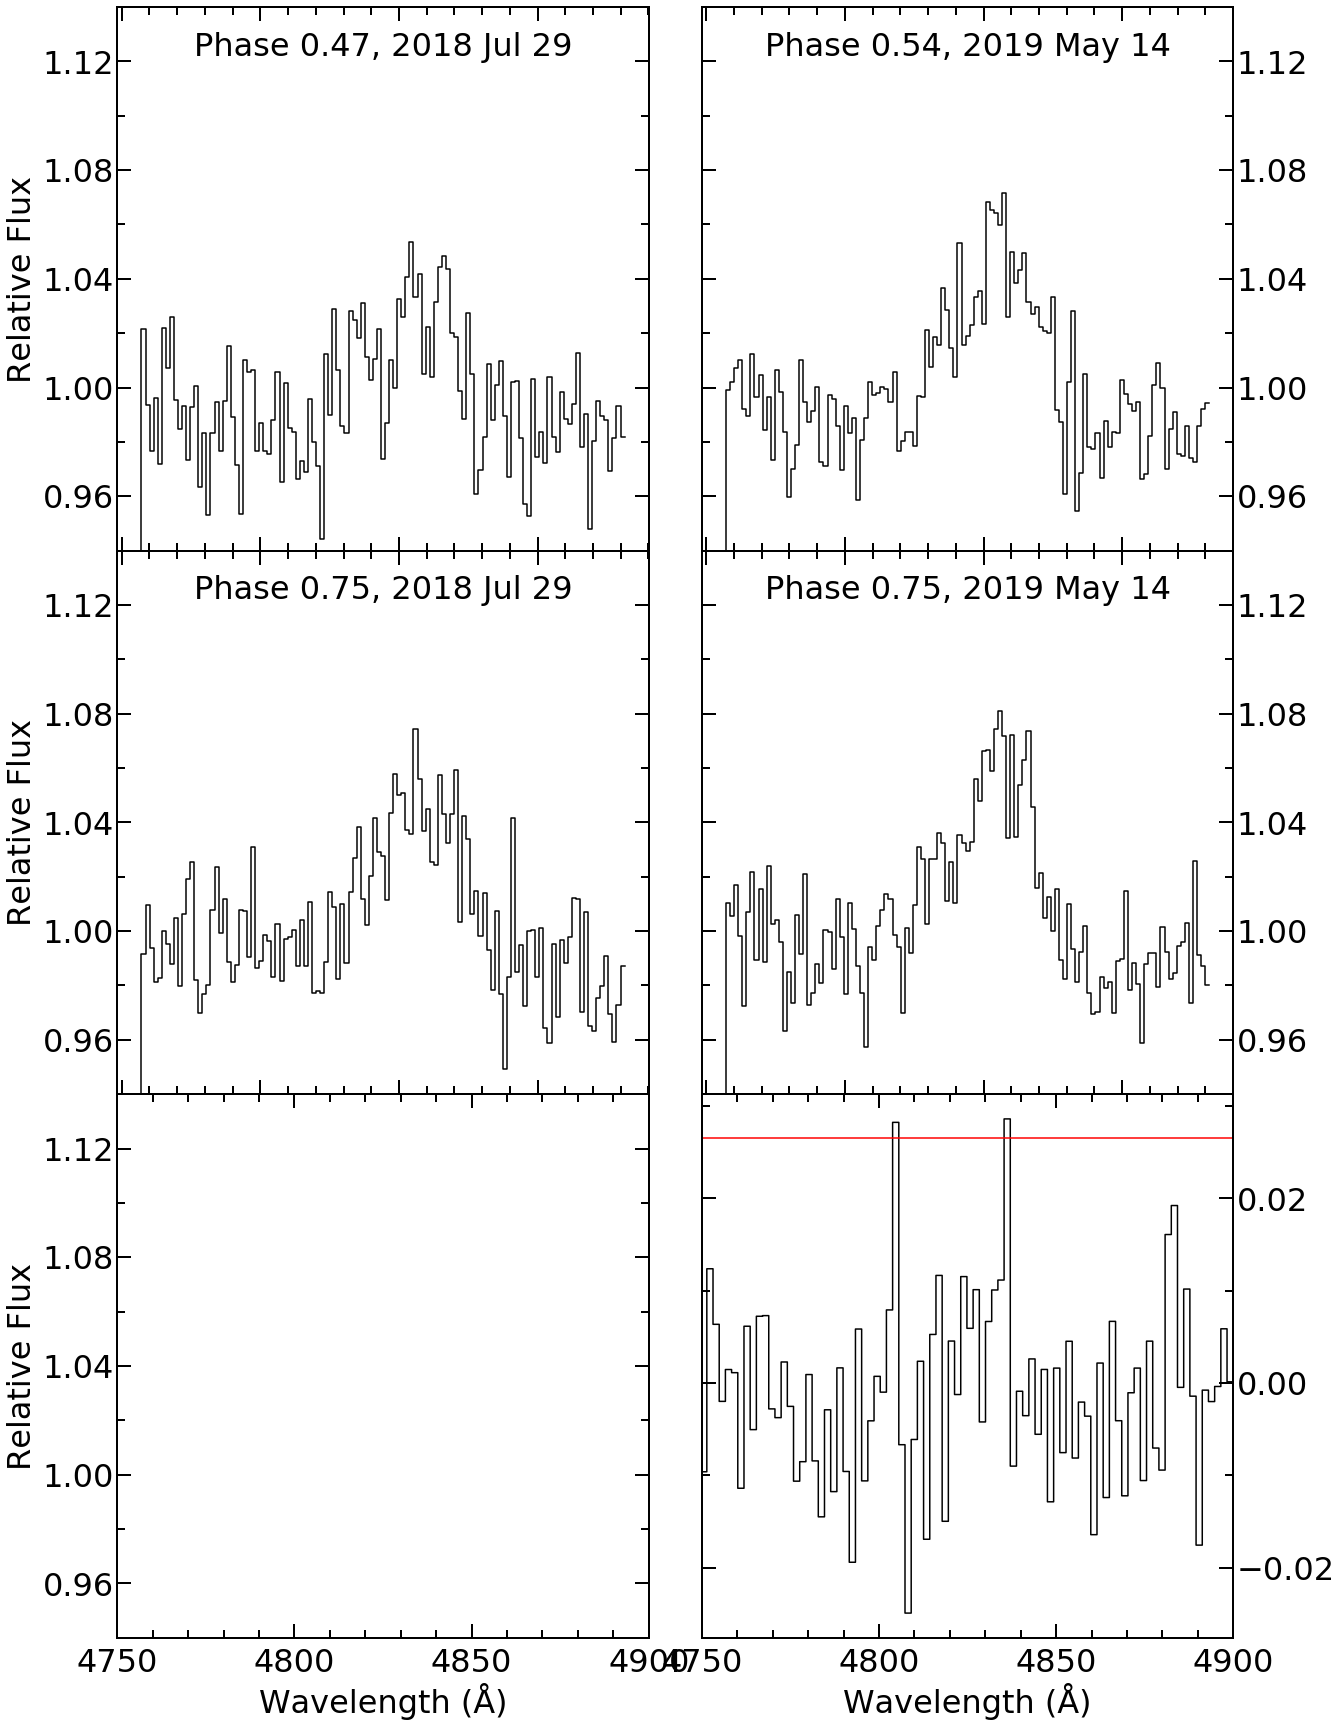

In [54]:

!!!

RJXpoints = np.linspace(5525, 7575, 4200)
RJXpoints = RJXpoints[:4100]
xpointss = RJXpoints[800:3350]


# 
rc('axes', linewidth=2)
fig, axs = plt.subplots(3, 2,
                        gridspec_kw={'hspace': 0., 'wspace': 0.1}, figsize=(20,30))
first = 400
second = first +357
datJul = StackRJTest[10][first:second]
datJul = np.nanmean(np.pad(datJul.astype(float), (0, 3 - datJul.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
x = xpointss[400:757]
x = np.nanmean(np.pad(x.astype(float), (0, 3 - x.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
xss = (x[1]-x[0])/2
xs = [x[0]-xss]
ys = [0]
for i in range(len(x)):
    xs.append(x[i] - xss)
    xs.append(x[i] + xss)
    ys.append(datJul[i])
    ys.append(datJul[i])
xs.append(x[-1] + xss)
ys.append(0)
axs[0, 0].plot(np.array(xs)-3.496070492976287, ys, color='black')
axs[0, 0].set_title('Phase 0.47, 2018 Jul 29', fontsize=32,x=0.5, y=0.9)
#####axs[0,0].set_xlim(4750, 4900)
axs[0,0].set_ylim(0.94,1.14)


datMay = StackRJTest[26][first:second]
datMay = np.nanmean(np.pad(datMay.astype(float), (0, 3 - datMay.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
ys = [0]
for i in range(len(x)):
    ys.append(datMay[i])
    ys.append(datMay[i])
ys.append(0)
axs[0, 1].plot(np.array(xs)-3.496070492976287, ys, color='black')
axs[0, 1].set_title('Phase 0.54, 2019 May 14', fontsize=32,x=0.5, y=0.9)
###########axs[0,1].set_xlim(4750, 4900)
axs[0,1].set_ylim(0.94,1.14)

datJul = StackRJTest[3][first:second]
datJul = np.nanmean(np.pad(datJul.astype(float), (0, 3 - datJul.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
ys = [0]
for i in range(len(x)):
    ys.append(datJul[i])
    ys.append(datJul[i])
ys.append(0)
axs[1, 0].plot(np.array(xs)-3.496070492976287, ys, color='black')
axs[1, 0].set_title('Phase 0.75, 2018 Jul 29', fontsize=32,x=0.5, y=0.9)
####axs[1,0].set_xlim(4750, 4900)
axs[1,0].set_ylim(0.94,1.14)


datMay = StackRJTest[38][first:second]
datMay = np.nanmean(np.pad(datMay.astype(float), (0, 3 - datMay.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
ys = [0]
for i in range(len(x)):
    ys.append(datMay[i])
    ys.append(datMay[i])
ys.append(0)
axs[1, 1].plot(np.array(xs)-3.496070492976287, ys, color='black')

axs[1, 1].set_title('Phase 0.75, 2019 May 14', fontsize=32,x=0.5, y=0.9)
#####axs[1,1].set_xlim(4750, 4900)
axs[1,1].set_ylim(0.94,1.14)


axs[2, 1].plot(np.array(errorxpoints)-3.496070492976287, errorypoints, color='black')

axs[2,1].plot([errorxpoints[0],errorxpoints[-2]],[onePer,onePer], 'r')
axs[2,1].set_xlim(4750, 4900)
meansTot = np.zeros(len(fortrailJ[0][4:-16]))
for i in range(22):
    meansTot = meansTot+fortrailJ[i][4:-16]
for i in range(22,46):
    meansTot = meansTot+fortrailJ[i][10:-10]
meansTot = meansTot/46
meansTot = np.nanmean(np.pad(meansTot.astype(float), (0, 3 - meansTot.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
ys = [0]
for i in range(len(x)):
    ys.append(meansTot[i])
    ys.append(meansTot[i])
ys.append(0)

axs[2, 0].plot(np.array(xs)-3.496070492976287, ys, color='black')
tr1 = np.loadtxt("fromJohn/moreTr/2p0_4s0.dat", usecols=(0,1,2))
BFieldTra4 = tr1[:,0]
WavelTra4 = tr1[:,1]
tr1 = np.loadtxt("fromJohn/moreTr/2p1_4d1.dat", usecols=(0,1,2))
BFieldTra7 = tr1[:,0]
WavelTra7 = tr1[:,1]



axs[2,0].set_ylim(0.94,1.14)
axs[2,0].set_xlim(4750, 4900)

axs[0,0].set_ylabel('Relative Flux', fontsize=32)
axs[1,0].set_ylabel('Relative Flux', fontsize=32)
axs[2,0].set_ylabel('Relative Flux', fontsize=32)
for ax in axs.flat:

    
 
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.yaxis.set_minor_locator(MultipleLocator(0.02))
    ax.tick_params(labelsize=32)
    
    #ax.set_xticks(np.arange(4750, 4900, 50))

    ax.tick_params(axis='x',which='both', width=2,direction='in',pad=10)
    ax.tick_params(axis='y',which='both', width=2,direction='in')
    ax.tick_params(which='major', length=14)
    ax.tick_params(which='minor', length=8)
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
axs[2,1].yaxis.set_major_locator(MultipleLocator(0.02))
axs[2,1].yaxis.set_minor_locator(MultipleLocator(0.01))


axs[0,0].set_yticks(np.arange(0.96, 1.14, 0.04))
axs[0,1].set_yticks(np.arange(0.96, 1.14, 0.04))
axs[1,1].set_yticks(np.arange(0.96, 1.14, 0.04))
axs[1,0].set_yticks(np.arange(0.96, 1.14, 0.04))
axs[2,0].set_yticks(np.arange(0.96, 1.14, 0.04))
axs[2,0].set_xlabel(r"Wavelength (Å)", fontsize=32)
axs[2,1].set_xlabel(r"Wavelength (Å)", fontsize=32)
axs[0,1].tick_params(axis='y',which='both',labelleft=False,labelright=True)
axs[1,1].tick_params(axis='y',which='both',labelleft=False,labelright=True)
axs[2,1].tick_params(axis='y',which='both',labelleft=False,labelright=True)

axs[0,0].set_xticklabels([])
axs[0,1].set_xticklabels([])
axs[1,0].set_xticklabels([])
axs[1,1].set_xticklabels([])
bboxx = transforms.Bbox([[0.95, 2.6], [19.4, 26.44]])
#plt.savefig('outofphasemorphFinalCr.pdf',bbox_inches=bboxx) 
#plt.savefig('outofphasemorphFinal.eps', bbox_inches='tight', pad_inches=0.75 ) 

In [17]:
phasedStackS = stackRJ[36]+stackRJ[85]+stackRM[53]+stackRM[103]+stackRM[4]+stackRM[54]+stackRM[104]
phasedStackS = phasedStackS/7
tmp = stackRJ[86]+stackRJ[37]+stackRM[5]+stackRM[55]+stackRM[105]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[87]+stackRJ[38]+stackRM[6]+stackRM[56]+stackRM[106]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[88]+stackRJ[39]+stackRM[7]+stackRM[57]+stackRM[107]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[89]+stackRJ[40]+stackRM[8]+stackRM[58]+stackRM[108]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[90]+stackRJ[41]+stackRM[9]+stackRM[59]+stackRM[109]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[91]+stackRJ[42]+stackRM[10]+stackRM[60]+stackRM[110]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[92]+stackRJ[43]+stackRM[11]+stackRM[61]+stackRM[111]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[93]+stackRJ[44]+stackRM[12]+stackRM[62]+stackRM[112]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[94]+stackRJ[45]+stackRM[13]+stackRM[63]+stackRM[113]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[95]+stackRJ[46]+stackRM[14]+stackRM[64]+stackRM[114]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[96]+stackRJ[47]+stackRM[15]+stackRM[65]+stackRM[115]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[97]+stackRJ[48]+stackRJ[0]+stackRM[16]+stackRM[66]+stackRM[116]
tmp = tmp/6
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[98]+stackRJ[49]+stackRJ[1]+stackRM[17]+stackRM[67]+stackRM[117]
tmp = tmp/6
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[99]+stackRJ[50]+stackRJ[2]+stackRM[18]+stackRM[68]+stackRM[118]
tmp = tmp/6
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[100]+stackRJ[51]+stackRM[19]+stackRM[69]+stackRM[119]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[3]+stackRJ[101]+stackRJ[52]+stackRM[20]+stackRM[70]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[4]+stackRJ[102]+stackRJ[53]+stackRM[21]+stackRM[71]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[5]+stackRJ[103]+stackRJ[54]+stackRM[22]+stackRM[72]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[6]+stackRJ[104]+stackRJ[55]+stackRM[23]+stackRM[73]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[7]+stackRJ[105]+stackRJ[56]+stackRM[24]+stackRM[74]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[8]+stackRJ[106]+stackRJ[57]+stackRM[25]+stackRM[75]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[9]+stackRJ[107]+stackRJ[58]+stackRM[26]+stackRM[76]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[108]+stackRJ[10]+stackRJ[59]+stackRM[27]+stackRM[77]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[109]+stackRJ[11]+stackRJ[60]+stackRM[28]+stackRM[78]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[110]+stackRJ[12]+stackRJ[61]+stackRM[29]+stackRM[79]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[111]+stackRJ[13]+stackRM[30]+stackRM[80]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[62]+stackRJ[14]+stackRJ[112]+stackRM[31]+stackRM[81]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[63]+stackRJ[15]+stackRM[32]+stackRM[82]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[64]+stackRJ[16]+stackRM[33]+stackRM[83]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[65]+stackRJ[17]+stackRM[34]+stackRM[84]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[66]+stackRJ[18]+stackRM[35]+stackRM[85]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[67]+stackRJ[19]+stackRM[36]+stackRM[86]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[68]+stackRJ[20]+stackRM[37]+stackRM[87]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[69]+stackRJ[21]+stackRM[38]+stackRM[88]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[70]+stackRJ[22]+stackRM[39]+stackRM[89]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[71]+stackRJ[23]+stackRM[40]+stackRM[90]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[72]+stackRJ[24]+stackRM[41]+stackRM[91]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[73]+stackRJ[25]+stackRM[42]+stackRM[92]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[74]+stackRJ[26]+stackRM[43]+stackRM[93]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[75]+stackRJ[27]+stackRM[44]+stackRM[94]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[76]+stackRJ[28]+stackRM[45]+stackRM[95]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[77]+stackRJ[29]+stackRM[46]+stackRM[96]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[78]+stackRJ[30]+stackRM[47]+stackRM[97]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[79]+stackRJ[31]+stackRM[48]+stackRM[98]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[80]+stackRJ[32]+stackRM[49]+stackRM[99]
tmp = tmp/4
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[81]+stackRJ[33]+stackRM[50]+stackRM[100]+stackRM[0]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[82]+stackRJ[34]+stackRM[51]+stackRM[101]+stackRM[1]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[83]+stackRJ[35]+stackRM[52]+stackRM[102]+stackRM[2]
tmp = tmp/5
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[84]+stackRM[3]
tmp = tmp/2
phasedStackS = np.vstack((phasedStackS, tmp))

In [18]:
phasedStackS = stackRJ[36]+stackRJ[85]+stackRM[53]+stackRM[103]+stackRM[4]+stackRM[54]+stackRM[104] + \
stackRJ[86]+stackRJ[37]+stackRM[5]+stackRM[55]+stackRM[105]+\
stackRJ[87]+stackRJ[38]+stackRM[6]+stackRM[56]+stackRM[106]+\
stackRJ[88]+stackRJ[39]+stackRM[7]+stackRM[57]+stackRM[107]+\
stackRJ[89]+stackRJ[40]+stackRM[8]+stackRM[58]+stackRM[108]
phasedStackS = phasedStackS/27

tmp = stackRJ[90]+stackRJ[41]+stackRM[9]+stackRM[59]+stackRM[109]+\
stackRJ[91]+stackRJ[42]+stackRM[10]+stackRM[60]+stackRM[110]+\
stackRJ[92]+stackRJ[43]+stackRM[11]+stackRM[61]+stackRM[111]+\
stackRJ[93]+stackRJ[44]+stackRM[12]+stackRM[62]+stackRM[112]+\
stackRJ[94]+stackRJ[45]+stackRM[13]+stackRM[63]+stackRM[113]
tmp = tmp/25
phasedStackS = np.vstack((phasedStackS, tmp))

tmp = stackRJ[95]+stackRJ[46]+stackRM[14]+stackRM[64]+stackRM[114]+\
stackRJ[96]+stackRJ[47]+stackRM[15]+stackRM[65]+stackRM[115]+\
stackRJ[97]+stackRJ[48]+stackRJ[0]+stackRM[16]+stackRM[66]+stackRM[116]+\
stackRJ[98]+stackRJ[49]+stackRJ[1]+stackRM[17]+stackRM[67]+stackRM[117]+\
stackRJ[99]+stackRJ[50]+stackRJ[2]+stackRM[18]+stackRM[68]+stackRM[118]
tmp = tmp/28
phasedStackS = np.vstack((phasedStackS, tmp))

tmp = stackRJ[100]+stackRJ[51]+stackRM[19]+stackRM[69]+stackRM[119]+\
stackRJ[3]+stackRJ[101]+stackRJ[52]+stackRM[20]+stackRM[70]+\
stackRJ[4]+stackRJ[102]+stackRJ[53]+stackRM[21]+stackRM[71]+\
stackRJ[5]+stackRJ[103]+stackRJ[54]+stackRM[22]+stackRM[72]+\
stackRJ[6]+stackRJ[104]+stackRJ[55]+stackRM[23]+stackRM[73]
tmp = tmp/25
phasedStackS = np.vstack((phasedStackS, tmp))

tmp = stackRJ[7]+stackRJ[105]+stackRJ[56]+stackRM[24]+stackRM[74]+\
stackRJ[8]+stackRJ[106]+stackRJ[57]+stackRM[25]+stackRM[75]+\
stackRJ[9]+stackRJ[107]+stackRJ[58]+stackRM[26]+stackRM[76]+\
stackRJ[108]+stackRJ[10]+stackRJ[59]+stackRM[27]+stackRM[77]+\
stackRJ[109]+stackRJ[11]+stackRJ[60]+stackRM[28]+stackRM[78]
tmp = tmp/25
phasedStackS = np.vstack((phasedStackS, tmp))

tmp = stackRJ[110]+stackRJ[12]+stackRJ[61]+stackRM[29]+stackRM[79]+\
stackRJ[111]+stackRJ[13]+stackRM[30]+stackRM[80]+\
stackRJ[62]+stackRJ[14]+stackRJ[112]+stackRM[31]+stackRM[81]+\
stackRJ[63]+stackRJ[15]+stackRM[32]+stackRM[82]+\
stackRJ[64]+stackRJ[16]+stackRM[33]+stackRM[83]
tmp = tmp/22
phasedStackS = np.vstack((phasedStackS, tmp))

tmp = stackRJ[65]+stackRJ[17]+stackRM[34]+stackRM[84]+\
stackRJ[66]+stackRJ[18]+stackRM[35]+stackRM[85]+\
stackRJ[67]+stackRJ[19]+stackRM[36]+stackRM[86]+\
stackRJ[68]+stackRJ[20]+stackRM[37]+stackRM[87]+\
stackRJ[69]+stackRJ[21]+stackRM[38]+stackRM[88]
tmp = tmp/20
phasedStackS = np.vstack((phasedStackS, tmp))

tmp = stackRJ[70]+stackRJ[22]+stackRM[39]+stackRM[89]+\
stackRJ[71]+stackRJ[23]+stackRM[40]+stackRM[90]+\
stackRJ[72]+stackRJ[24]+stackRM[41]+stackRM[91]+\
stackRJ[73]+stackRJ[25]+stackRM[42]+stackRM[92]+\
stackRJ[74]+stackRJ[26]+stackRM[43]+stackRM[93]
tmp = tmp/20
phasedStackS = np.vstack((phasedStackS, tmp))

tmp = stackRJ[75]+stackRJ[27]+stackRM[44]+stackRM[94]+\
stackRJ[76]+stackRJ[28]+stackRM[45]+stackRM[95]+\
stackRJ[77]+stackRJ[29]+stackRM[46]+stackRM[96]+\
stackRJ[78]+stackRJ[30]+stackRM[47]+stackRM[97]+\
stackRJ[79]+stackRJ[31]+stackRM[48]+stackRM[98]
tmp = tmp/20
phasedStackS = np.vstack((phasedStackS, tmp))

tmp = stackRJ[80]+stackRJ[32]+stackRM[49]+stackRM[99]+\
stackRJ[81]+stackRJ[33]+stackRM[50]+stackRM[100]+stackRM[0]+\
stackRJ[82]+stackRJ[34]+stackRM[51]+stackRM[101]+stackRM[1]+\
stackRJ[83]+stackRJ[35]+stackRM[52]+stackRM[102]+stackRM[2]+\
stackRJ[84]+stackRM[3]
tmp = tmp/21
phasedStackS = np.vstack((phasedStackS, tmp))
print(np.shape(phasedStackS))

(10, 1200)


In [19]:
#updated phase stack
phasedStackS = stackRJ[32]+stackRJ[28]+stackRJ[29]+stackRJ[30]+stackRJ[31]+stackRJ[76]+stackRJ[77]+stackRJ[78]+stackRJ[79]+stackRJ[80]+stackRM[43]+stackRM[44]+stackRM[45]+stackRM[46]+stackRM[47]+stackRM[97]+stackRM[93]+stackRM[94]+stackRM[95]+stackRM[96]
phasedStackS = phasedStackS/20
tmp = stackRJ[33]+stackRJ[34]+stackRJ[35]+stackRJ[36]+stackRJ[81]+stackRJ[82]+stackRJ[83]+stackRJ[84]+stackRJ[85]+stackRM[0]+stackRM[1]+stackRM[2]+stackRM[48]+stackRM[49]+stackRM[50]+stackRM[51]+stackRM[52]+stackRM[102]+stackRM[98]+stackRM[99]+stackRM[100]+stackRM[101]
tmp = tmp/22
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[37]+stackRJ[41]+stackRJ[38]+stackRJ[39]+stackRJ[40]+stackRJ[86]+stackRJ[87]+stackRJ[88]+stackRJ[89]+stackRJ[90]+stackRM[3]+stackRM[4]+stackRM[5]+stackRM[6]+stackRM[7]+stackRM[53]+stackRM[54]+stackRM[55]+stackRM[56]+stackRM[57]+stackRM[107]+stackRM[103]+stackRM[104]+stackRM[105]+stackRM[106]
tmp = tmp/25
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[46]+stackRJ[42]+stackRJ[43]+stackRJ[44]+stackRJ[45]+stackRJ[91]+stackRJ[92]+stackRJ[93]+stackRJ[94]+stackRJ[95]+stackRM[8]+stackRM[9]+stackRM[10]+stackRM[11]+stackRM[12]+stackRM[58]+stackRM[59]+stackRM[60]+stackRM[61]+stackRM[62]+stackRM[112]+stackRM[108]+stackRM[109]+stackRM[110]+stackRM[111]
tmp = tmp/25
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[0]+stackRJ[1]+stackRJ[2]+stackRJ[51]+stackRJ[47]+stackRJ[48]+stackRJ[49]+stackRJ[50]+stackRJ[96]+stackRJ[97]+stackRJ[98]+stackRJ[99]+stackRJ[100]+stackRM[13]+stackRM[14]+stackRM[15]+stackRM[16]+stackRM[17]+stackRM[63]+stackRM[64]+stackRM[65]+stackRM[66]+stackRM[67]+stackRM[117]+stackRM[113]+stackRM[114]+stackRM[115]+stackRM[116]
tmp = tmp/28
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[3]+stackRJ[4]+stackRJ[5]+stackRJ[6]+stackRJ[7]+stackRJ[52]+stackRJ[53]+stackRJ[54]+stackRJ[55]+stackRJ[101]+stackRJ[102]+stackRJ[103]+stackRJ[104]+stackRJ[105]+stackRM[18]+stackRM[19]+stackRM[20]+stackRM[21]+stackRM[22]+stackRM[68]+stackRM[69]+stackRM[70]+stackRM[71]+stackRM[72]+stackRM[118]+stackRM[119]
tmp = tmp/26
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[8]+stackRJ[9]+stackRJ[10]+stackRJ[11]+stackRJ[12]+stackRJ[56]+stackRJ[57]+stackRJ[58]+stackRJ[59]+stackRJ[60]+stackRJ[106]+stackRJ[107]+stackRJ[108]+stackRJ[109]+stackRJ[110]+stackRM[23]+stackRM[24]+stackRM[25]+stackRM[26]+stackRM[27]+stackRM[73]+stackRM[74]+stackRM[75]+stackRM[76]+stackRM[77]
tmp = tmp/25
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[13]+stackRJ[14]+stackRJ[15]+stackRJ[16]+stackRJ[17]+stackRJ[61]+stackRJ[62]+stackRJ[63]+stackRJ[64]+stackRJ[65]+stackRJ[111]+stackRJ[112]+stackRM[28]+stackRM[29]+stackRM[30]+stackRM[31]+stackRM[32]+stackRM[78]+stackRM[79]+stackRM[80]+stackRM[81]+stackRM[82]
tmp = tmp/22
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[22]+stackRJ[18]+stackRJ[19]+stackRJ[20]+stackRJ[21]+stackRJ[66]+stackRJ[67]+stackRJ[68]+stackRJ[69]+stackRJ[70]+stackRM[33]+stackRM[34]+stackRM[35]+stackRM[36]+stackRM[37]+stackRM[83]+stackRM[84]+stackRM[85]+stackRM[86]+stackRM[87]
tmp = tmp/20
phasedStackS = np.vstack((phasedStackS, tmp))
tmp = stackRJ[27]+stackRJ[23]+stackRJ[24]+stackRJ[25]+stackRJ[26]+stackRJ[71]+stackRJ[72]+stackRJ[73]+stackRJ[74]+stackRJ[75]+stackRM[38]+stackRM[39]+stackRM[40]+stackRM[41]+stackRM[42]+stackRM[88]+stackRM[89]+stackRM[90]+stackRM[91]+stackRM[92]
tmp = tmp/20
phasedStackS = np.vstack((phasedStackS, tmp))
print(np.shape(phasedStackS))

(10, 1200)


D:\conda\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
D:\conda\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
D:\conda\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
D:\conda\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
D:\conda\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
D:\conda\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
D:\conda\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
D:\conda\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  

1.4646344367729398


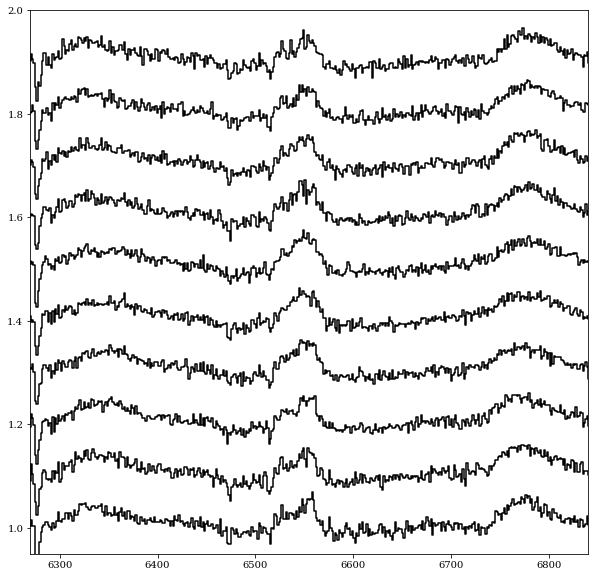

In [20]:
RKeepX = xpointss[700:1900]
RKeepFlux = phasedStackS
plt.figure(figsize=(10,10))
RKeepFlux = phasedStackS
RKeepX = xpointss[700:1900]
for k in range(10):
    
    datJul = RKeepFlux[k]+0.1*k
    datJul = np.nanmean(np.pad(datJul.astype(float), (0, 3 - datJul.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
    x = RKeepX
    x = np.nanmean(np.pad(x.astype(float), (0, 3 - x.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
    xss = (x[1]-x[0])/2
    xs = [x[0]-xss]
    ys = [0]
    for i in range(len(x)):
        xs.append(x[i] - xss)
        xs.append(x[i] + xss)
        ys.append(datJul[i])
        ys.append(datJul[i])
    xs.append(x[-1] + xss)
    ys.append(0)
    plt.plot(np.array(xs)-1.4646344367729398,ys, c='k')
    plt.ylim(0.95,2)
    plt.xlim(6270,6840)
    
print((RKeepX[1]-RKeepX[0])*3)

In [29]:
xforwardStack[0]

array([4630.77577995, 4630.77577995, 4632.08680638, ...,           nan,
                 nan,           nan])

D:\conda\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
D:\conda\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
D:\conda\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
D:\conda\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
D:\conda\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
D:\conda\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
D:\conda\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
D:\conda\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
D:\conda\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
D

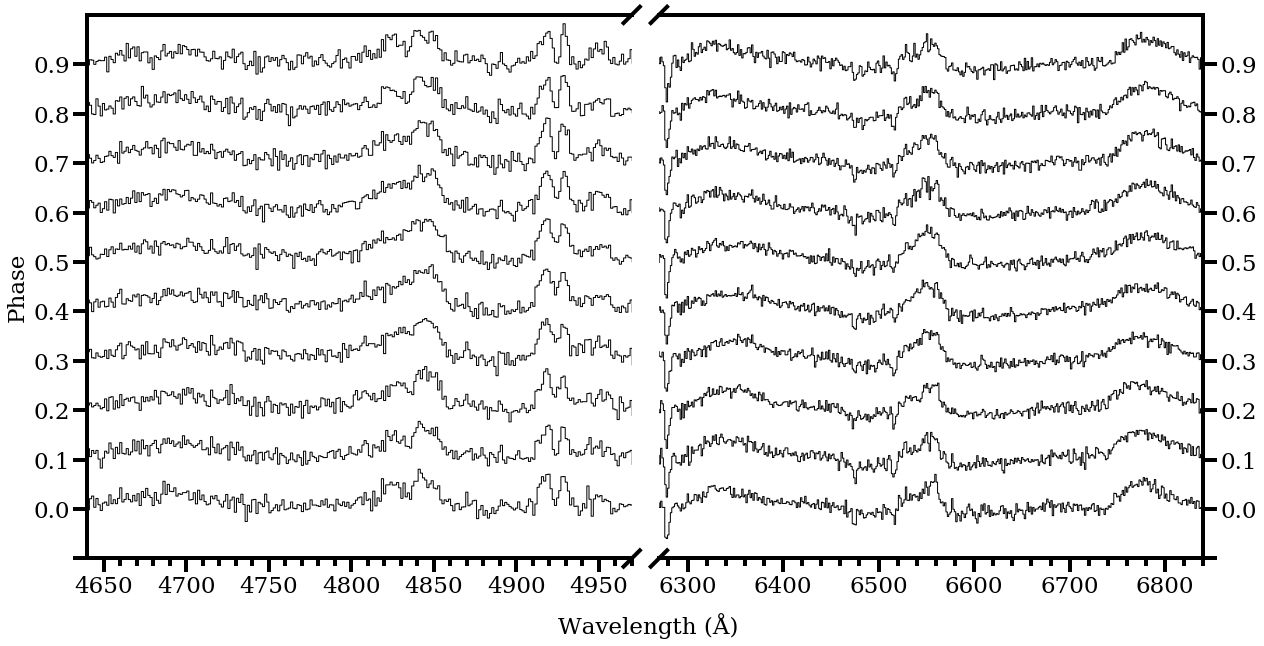

In [21]:
rc('axes', linewidth=4)
RKeepX = xpointss[700:1900]
f,(ax,ax2) = plt.subplots(1,2,gridspec_kw={'hspace': 0.15, 'wspace': 0.05},sharey=True, facecolor='w', figsize=(20,10))
xforwardStack = []
yforwardStackBlue = []
yforwardStackRed = []
for k in range(10):
    
    datJul = BKeepFlux[k]+0.1*k
    datJul = np.nanmean(np.pad(datJul.astype(float), (0, 3 - datJul.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
    
    x = BKeepX
    x = np.nanmean(np.pad(x.astype(float), (0, 3 - x.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
    xss = (x[1]-x[0])/2
    xs = [x[0]-xss]
    ys = [0]
    for i in range(len(x)):
        xs.append(x[i] - xss)
        xs.append(x[i] + xss)
        ys.append(datJul[i])
        ys.append(datJul[i])
    xs.append(x[-1] + xss)
    ys.append(0)
    
    yskeep = ys
    xskeep = np.array(xs)-3.496070492976287
    
    datJul = RKeepFlux[k]+0.1*k
    datJul = np.nanmean(np.pad(datJul.astype(float), (0, 3 - datJul.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
    
    x = RKeepX
    x = np.nanmean(np.pad(x.astype(float), (0, 3 - x.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
    xss = (x[1]-x[0])/2
    xs = [x[0]-xss]
    ys = [0]
    for i in range(len(x)):
        xs.append(x[i] - xss)
        xs.append(x[i] + xss)
        ys.append(datJul[i])
        ys.append(datJul[i])
    xs.append(x[-1] + xss)
    ys.append(0)
    
    yforward = np.append(yskeep,ys)
    xforward = np.append(xskeep,np.array(xs))
    
    ax.plot(xforward, yforward, 'k-', lw=1)
    ax2.plot(xforward, yforward, 'k-', lw=1)
    if k == 0:
        xforwardStack = xforward
        yforwardStackBlue = yforward[:521]
        yforwardStackRed = yforward[524:1325]
    else:
        xforwardStack = np.vstack((xforwardStack,xforward))
        yforwardStackBlue = np.vstack((yforwardStackBlue,yforward[:521]-0.1*k))
        yforwardStackRed = np.vstack((yforwardStackRed, yforward[524:1325]-0.1*k))
    
ax.set_xlim(4640,4970)
ax2.set_xlim(6270,6840)  
ax.set_ylim(0.95,2)
ax2.set_ylim(0.95,2)
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax.yaxis.tick_left()
#ax.tick_params(labelright='off')
ax2.tick_params(labelright='on')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d,1+d), (-d,+d), **kwargs, lw=4)
ax.plot((1-d,1+d),(1-d,1+d), **kwargs, lw=4)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d,1+d), **kwargs, lw=4)
ax2.plot((-d,+d), (-d,+d), **kwargs, lw=4)
phaserange = ['','0.0','0.1','0.2','0.3','0.4','0.5', '0.6', '0.7', '0.8', '0.9']
phaseX = np.linspace(0.9,1.9,11)
ax2.set_yticks(phaseX)
ax.set_yticks(phaseX)
ax2.set_yticklabels(phaserange)
ax.set_yticklabels(phaserange)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())
#ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=4)
ax.tick_params(which='major', length=14)
ax.tick_params(which='minor', length=8)
ax2.tick_params(which='both', width=4)
ax2.tick_params(which='major', length=14)
ax2.tick_params(which='minor', length=8)
ax.tick_params(labelsize=23)
ax2.tick_params(labelsize=23)
ax.set_xlabel(r"Wavelength (Å)", fontsize=23)
ax.set_ylabel('Phase', fontsize=23)
ax.xaxis.set_label_coords(1.03, -0.1)

#plt.savefig('SpectraPhased.eps',bbox_inches='tight',pad_inches=0.8)
#RCor 1.4646344367729398
#BCor 1.3110264348661076

In [50]:
print(np.shape(xforwardStack))
print(np.shape(yforwardStack))
yforwardStackZero = np.nan_to_num(yforwardStack, nan=0.0)
xforwardStackZero = np.nan_to_num(xforwardStack, nan=0.0)
nanIndx = np.argwhere(np.isnan(xforwardStack))
#print(nanIndx)

(10, 1328)


NameError: name 'yforwardStack' is not defined

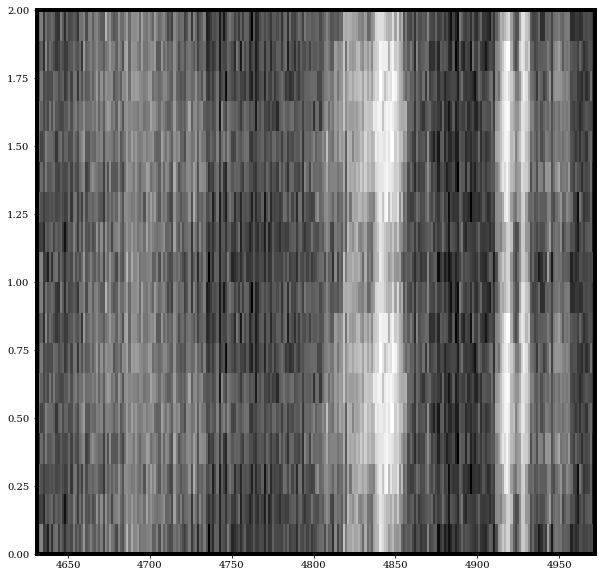

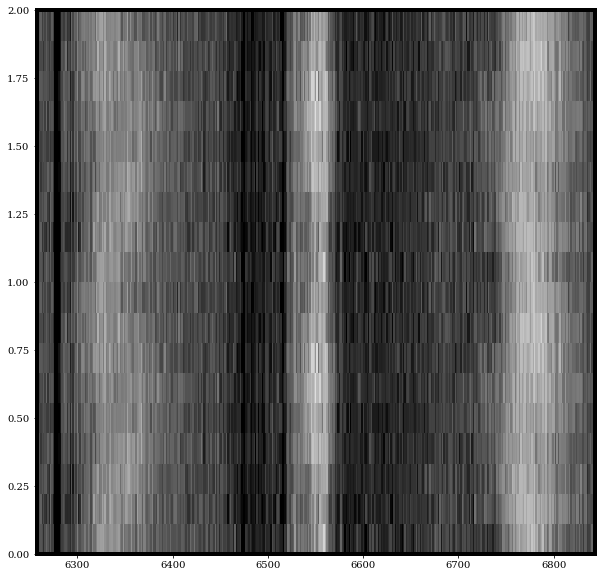

In [31]:
BlueXPoints = xforwardStack[0][:521]
RedXPoints = xforwardStack[0][524:1325]
np.save('BlueXGD356.npy', BlueXPoints)
np.save('RedXGD356.npy', RedXPoints)

np.save('BlueYGD356.npy', yforwardStackBlue)
np.save('RedYGD356.npy', yforwardStackRed)

X,Y = np.meshgrid(BlueXPoints, np.linspace(0,1,10))

plt.figure(figsize=(10,10))
plt.pcolormesh(X,Y,yforwardStackBlue,vmin=0.975, vmax=1.09, cmap='gray')
X,Y = np.meshgrid(BlueXPoints, np.linspace(1,2,10))
plt.pcolormesh(X,Y,yforwardStackBlue,vmin=0.975, vmax=1.09, cmap='gray')
plt.show()



X,Y = np.meshgrid(RedXPoints, np.linspace(0,1,10))

plt.figure(figsize=(10,10))
plt.pcolormesh(X,Y,yforwardStackRed,vmin=0.975, vmax=1.09, cmap='gray')
X,Y = np.meshgrid(RedXPoints, np.linspace(1,2,10))
plt.pcolormesh(X,Y,yforwardStackRed,vmin=0.975, vmax=1.09, cmap='gray')
plt.show()
#plt.xlim(4640,6840)

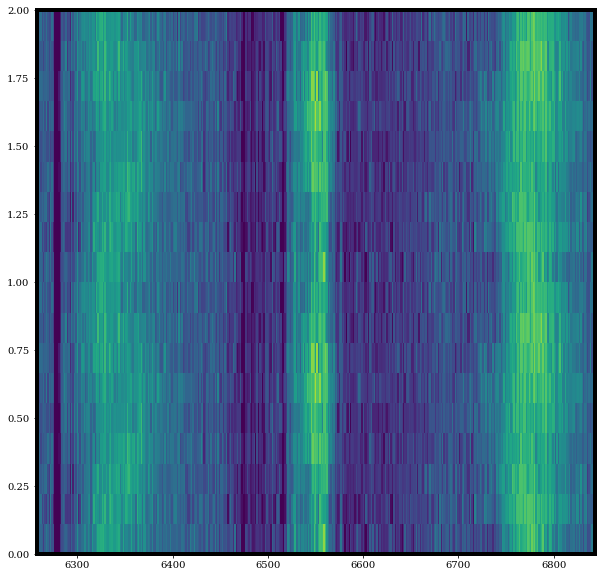

In [26]:
X,Y = np.meshgrid(RedXPoints, np.linspace(0,1,10))

plt.figure(figsize=(10,10))
plt.pcolormesh(X,Y,yforwardStackRed,vmin=0.975, vmax=1.09)#, cmap='gray')
X,Y = np.meshgrid(RedXPoints, np.linspace(1,2,10))
plt.pcolormesh(X,Y,yforwardStackRed,vmin=0.975, vmax=1.09)#, cmap='gray')
plt.show()

In [41]:
np.shape(np.linspace(0,2,20))

(20,)

In [45]:
BlueXPoints[1]+1.311026434865198

4635.582876875446

D:\conda\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
D:\conda\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
D:\conda\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
D:\conda\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
D:\conda\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
D:\conda\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
D:\conda\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
D:\conda\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
D:\conda\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
D:\conda\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: Mean of 

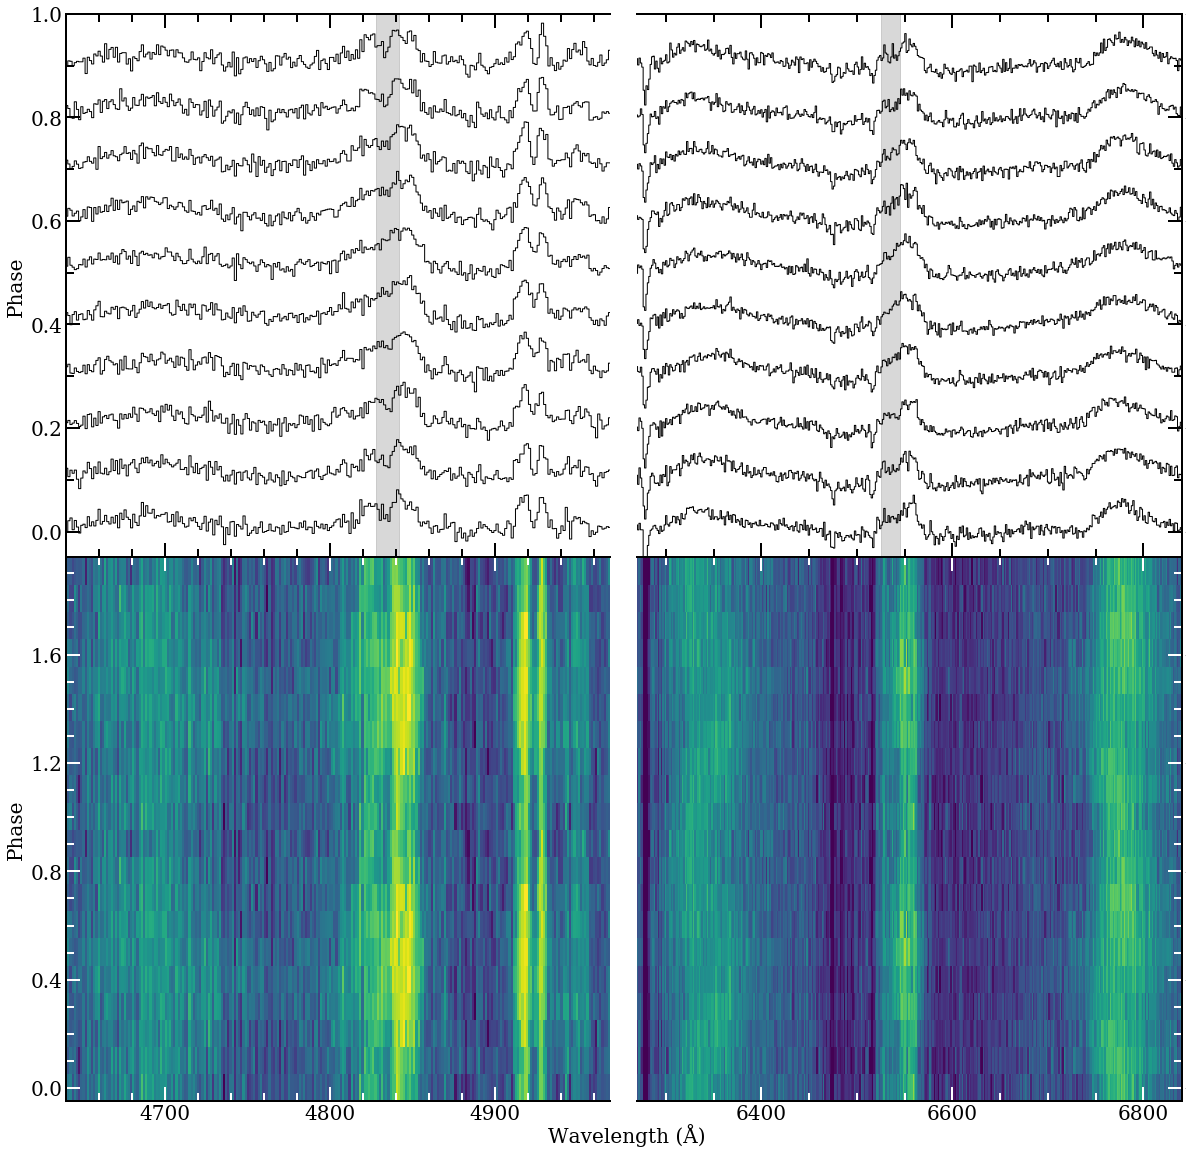

In [27]:
rc('axes', linewidth=2)
RKeepX = xpointss[700:1900]
f,axs = plt.subplots(2,2,gridspec_kw={'hspace': 0,'wspace': 0.05}, facecolor='w', figsize=(20,20))
for k in range(10):
    #RCor 1.4646344367729398
    #BCor 1.3110264348661076
    datJul = BKeepFlux[k]+0.1*k
    datJul = np.nanmean(np.pad(datJul.astype(float), (0, 3 - datJul.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
    
    x = BKeepX
    x = np.nanmean(np.pad(x.astype(float), (0, 3 - x.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
    xss = (x[1]-x[0])/2
    xs = [x[0]-xss]
    ys = [0]
    for i in range(len(x)):
        xs.append(x[i] - xss)
        xs.append(x[i] + xss)
        ys.append(datJul[i])
        ys.append(datJul[i])
    xs.append(x[-1] + xss)
    ys.append(0)
    
    yskeep = ys
    xskeep = np.array(xs)-3.496070492976287
    
    datJul = RKeepFlux[k]+0.1*k
    datJul = np.nanmean(np.pad(datJul.astype(float), (0, 3 - datJul.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
    
    x = RKeepX
    x = np.nanmean(np.pad(x.astype(float), (0, 3 - x.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
    xss = (x[1]-x[0])/2
    xs = [x[0]-xss]
    ys = [0]
    for i in range(len(x)):
        xs.append(x[i] - xss)
        xs.append(x[i] + xss)
        ys.append(datJul[i])
        ys.append(datJul[i])
    xs.append(x[-1] + xss)
    ys.append(0)
    
    yforward = np.append(yskeep,ys)
    xforward = np.append(xskeep,np.array(xs))
    
    axs[0,0].plot(xforward, yforward-1, 'k-', lw=1)
    axs[0,1].plot(xforward, yforward-1, 'k-', lw=1)


        
axs[0,0].axvspan(4828,4842, alpha=0.3, color='gray')
axs[0,1].axvspan(6525,6545, alpha=0.3, color='gray')
BlueXPoints = xforwardStack[0][:521]
RedXPoints = xforwardStack[0][524:1325]
X,Y = np.meshgrid(BlueXPoints, np.linspace(0,2.1,21))
yforwardStackBluePlt = np.vstack((yforwardStackBlue,yforwardStackBlue))
yforwardStackBluePlt = np.vstack((yforwardStackBluePlt,np.zeros(len(BlueXPoints))))
axs[1,0].pcolormesh(X,Y,yforwardStackBluePlt,vmin=0.975, vmax=1.09,rasterized=True)#cmap='gray'
yforwardStackRedPlt = np.vstack((yforwardStackRed,yforwardStackRed))
yforwardStackRedPlt = np.vstack((yforwardStackRedPlt,np.zeros(len(RedXPoints))))
X,Y = np.meshgrid(RedXPoints, np.linspace(0,2.1,21))
axs[1,1].pcolormesh(X,Y,yforwardStackRedPlt,vmin=0.975, vmax=1.09,rasterized=True)#cmap='gray'
#plt.xlim(4640,6840)



labelsize=20
axs[0,0].set_xlim(4640,4970)
axs[0,1].set_xlim(6270,6840) 
axs[1,0].set_xlim(4640,4970)
axs[1,1].set_xlim(6270,6840) 
axs[0,0].set_ylim(-0.05,1)
axs[0,1].set_ylim(-0.05,1)
#axs[1,0].set_ylim(0,2)
#axs[1,1].set_ylim(0,2)
axs[0,0].spines['right'].set_visible(False)
axs[0,1].spines['left'].set_visible(False)
axs[1,0].spines['right'].set_visible(False)
axs[1,1].spines['left'].set_visible(False)
axs[0,0].yaxis.tick_left()
#ax.tick_params(labelright='off')
axs[0,1].tick_params(labelright='on')
axs[0,1].yaxis.tick_right()
axs[0,1].yaxis.set_label_position("right")

axs[1,1].tick_params(labelright='on')
axs[1,1].yaxis.tick_right()
axs[1,1].yaxis.set_label_position("right")


d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
#kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
#axs[0,0].plot((1-d,1+d), (-d,+d), **kwargs, lw=4)
#axs[0,0].plot((1-d,1+d),(1-d,1+d), **kwargs, lw=4)

#kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
#axs[0,1].plot((-d,+d), (1-d,1+d), **kwargs, lw=4)
#axs[0,1].plot((-d,+d), (-d,+d), **kwargs, lw=4)
phaserange = ['0.0','0.4', '0.8','1.2','1.6']
phaseX = np.linspace(0.05,1.725,5)
axs[1,0].set_yticks(phaseX)
axs[1,1].set_yticks(phaseX)
axs[1,0].set_yticklabels(phaserange)
axs[1,1].set_yticklabels(phaserange)
axs[0,0].xaxis.set_minor_locator(MultipleLocator(20))
axs[0,0].xaxis.set_major_locator(MultipleLocator(100))
axs[0,1].xaxis.set_major_locator(MultipleLocator(200))
axs[0,0].yaxis.set_minor_locator(MultipleLocator(0.1))
axs[0,1].yaxis.set_minor_locator(MultipleLocator(0.1))

axs[0,1].xaxis.set_minor_locator(MultipleLocator(50))
axs[0,1].xaxis.set_major_locator(MultipleLocator(200))



axs[1,0].yaxis.set_minor_locator(AutoMinorLocator())
axs[1,1].yaxis.set_minor_locator(AutoMinorLocator())
axs[1,1].xaxis.set_minor_locator(MultipleLocator(50))
axs[1,1].xaxis.set_major_locator(MultipleLocator(200))
axs[1,0].xaxis.set_minor_locator(MultipleLocator(20))
axs[1,0].xaxis.set_major_locator(MultipleLocator(100))

#ax.yaxis.set_minor_locator(AutoMinorLocator())
axs[0,0].tick_params(which='both', width=2,direction='in')
axs[0,0].tick_params(axis='x',which='both', width=2,direction='in',pad=10)
axs[0,0].tick_params(which='major', length=14)
axs[0,0].tick_params(which='minor', length=8)
#axs[0,0].tick_params(axis='y',which='minor', length=8)

axs[1,0].tick_params(which='both',direction='in',color='white',width=2)

axs[1,0].tick_params(which='major', length=14)
axs[1,0].tick_params(which='minor', length=8)
axs[0,0].xaxis.set_ticks_position('both')
axs[0,1].xaxis.set_ticks_position('both')
axs[1,1].xaxis.set_ticks_position('both')
axs[1,0].xaxis.set_ticks_position('both')
axs[1,1].tick_params(which='both',direction='in',color='white',width=2)

axs[1,1].tick_params(which='major', length=14)
axs[1,1].tick_params(which='minor', length=8)

axs[0,1].tick_params(which='both', width=2,direction='in')
axs[0,1].tick_params(axis='x',which='both', width=2,direction='in',pad=10)
axs[0,1].tick_params(which='major', length=14)
axs[0,1].tick_params(which='minor', length=8)
axs[0,0].tick_params(labelsize=labelsize)
axs[0,1].tick_params(labelsize=labelsize)
axs[0,1].tick_params(axis='y',labelsize=0)

axs[1,0].tick_params(labelsize=labelsize)
axs[1,1].tick_params(labelsize=labelsize)
axs[1,1].tick_params(axis='y',labelsize=0)
axs[1,0].set_xlabel(r"Wavelength (Å)", fontsize=labelsize)
axs[1,0].set_ylabel(r"Phase", fontsize=labelsize)
axs[0,0].set_ylabel('Phase', fontsize=labelsize)

axs[0,1].set_xticklabels([])
axs[0,0].set_xticklabels([])

axs[1,0].xaxis.set_label_coords(1.03, -0.04)
#bboxx = transforms.Bbox([[1.15, 0.9], [18.9, 18.25]])
bboxx = transforms.Bbox([[1.66, 1.87], [18.04, 17.72]])

plt.savefig('SpectraPhasedUpdatedCr.pdf',bbox_inches=bboxx) 
#plt.savefig('SpectraPhasedUpdated.eps',bbox_inches='tight',pad_inches=0.8)


#

In [3]:
BJXpoints = np.linspace(3625, 5460, 4200)
3*(BJXpoints[1]-BJXpoints[0])

1.3110264348661076

In [28]:
#here!

fff = open("timeBM", "r")
timeBM = []
for x in fff:
    x = float(x)
    timeBM.append(x)
    
fff = open("timeRM", "r")
timeRM = []
for x in fff:
    x = float(x)
    timeRM.append(x)
    
fff = open("timeBJ", "r")
timeBJ = []
for x in fff:
    x = float(x)
    timeBJ.append(x)
    
fff = open("timeRJ", "r")
timeRJ = []
for x in fff:
    x = float(x)
    timeRJ.append(x)
    
BJXpoints = np.linspace(3625, 5460, 4200)
print(BJXpoints[665:3485])

RJXpoints = np.linspace(5525, 7575, 4200)
print(RJXpoints[800:3200])

countGlob = 1
holder_arrayBM = []

path = 'C:/Users/Admin/newMay19/'
consts = []
with open(path+'BTarOutDis') as file:
    for line in file:
        line = line.strip('\n')
        filepath = path + line
        hdul = fits.open(filepath)
        typeEx = hdul[0].data
        typeEx = typeEx[1]
        typeEx = typeEx.flatten()

        hdul.close()
        if countGlob == 1:
            
            holder_arrayBM = typeEx
        else:
            
            holder_arrayBM = np.vstack((holder_arrayBM, typeEx))
        countGlob = 2
countGlob = 1
holder_arrayBJ = []

path = 'C:/Users/Admin/newJul18/'
consts = []
with open(path+'BTarOutDis') as file:
    for line in file:
        line = line.strip('\n')
        filepath = path + line
        hdul = fits.open(filepath)
        typeEx = hdul[0].data
        typeEx = typeEx[1]
        typeEx = typeEx.flatten()

        hdul.close()
        if countGlob == 1:
            
            holder_arrayBJ = typeEx
        else:
            
            holder_arrayBJ = np.vstack((holder_arrayBJ, typeEx))
        countGlob = 2


empties = []
areasMod =[]
tempMeans = np.zeros(2400)
fortrailJ = []
averageTimeJ = []
def f(x, c, q,A, B): 
    return c*x*x*x + q*x*x + A*x + B
means = np.zeros(2400)
stageRJ = []
xpointss = np.linspace(0,2400,2400)
areas = []
count = 0
minicount = 0
xinarea = np.linspace(0,160,160)
stds = []
for i in range(113):
    flux = holder_arrayBJ[i]
    flux = flux[1500:3900]
    tmp1 = flux[0:35]
    xp1 = xpointss[0:35]
    
    tmp2 = flux[125:800]
    xp2 = xpointss[125:800]
    tmp3 = flux[1100:1180]
    xp3 = xpointss[1100:1180]
    tmp4 = flux[1330:1440]
    xp4 = xpointss[1330:1440]
    tmp5 = flux[1550:2400]
    xp5 = xpointss[1550:2400]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    
    
    
    
    
    xpF = np.append(xp1,xp2)
    xpF = np.append(xpF, xp3)
    xpF = np.append(xpF, xp4)
    xpF = np.append(xpF, xp5)
    popt, pcov = curve_fit(f, xpF, emptiedflux)
    fluxNormed = flux/f(xpointss, popt[0], popt[1], popt[2], popt[3])
    stds.append(np.std(fluxNormed[502:731]))
    tempMeans = fluxNormed
        #tmp = uniform_filter(np.clip(tempMeans[1000:1500],0.95,1.15),size=5)
    tmp = np.clip(tempMeans[1000:1500],0.95,1.15)
    differ = tmp[64:441]
        #differ = tmp[200:350]- straightLine([1200,1350],[1.015,1.09], xpointss[1200:1350])
    if minicount == 0:
        fortrailJ = differ
    else:
        fortrailJ = np.vstack((fortrailJ, differ))
    count = 0
    minicount = 1
    tempMeans = np.zeros(2400)
    means = means + fluxNormed
tempMeans = np.zeros(2400)
avgTSlice = 0
count=0
for i in range(120):
    flux = holder_arrayBM[i]
    flux = flux[1500:3900]
    tmp1 = flux[0:35]
    xp1 = xpointss[0:35]
    
    tmp2 = flux[125:800]
    xp2 = xpointss[125:800]
    tmp3 = flux[1100:1180]
    xp3 = xpointss[1100:1180]
    tmp4 = flux[1330:1440]
    xp4 = xpointss[1330:1440]
    tmp5 = flux[1550:2400]
    xp5 = xpointss[1550:2400]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    
    

    
    
    xpF = np.append(xp1,xp2)
    xpF = np.append(xpF, xp3)
    xpF = np.append(xpF, xp4)
    xpF = np.append(xpF, xp5)
    popt, pcov = curve_fit(f, xpF, emptiedflux)
    fluxNormed = flux/f(xpointss, popt[0], popt[1], popt[2], popt[3])
    stds.append(np.std(fluxNormed[502:731]))
    tempMeans = fluxNormed
        #tmp = uniform_filter(np.clip(tempMeans[1000:1500],0.95,1.15),size=5)
    tmp = np.clip(tempMeans[1000:1500],0.95,1.15)
    differ = tmp[64:441]
        #differ = tmp[200:350]- straightLine([1200,1350],[1.015,1.09], xpointss[1200:1350])

    fortrailJ = np.vstack((fortrailJ, differ))
    count = 0
    minicount = 1
    tempMeans = np.zeros(2400)

    means = means + fluxNormed



#800:1100

[3915.61085973 3916.04786854 3916.48487735 ... 5146.66468207 5147.10169088
 5147.53869969]
[5915.56918314 5916.05739462 5916.5456061  ... 7085.81209812 7086.3003096
 7086.78852108]


[3915.61085973 3916.04786854 3916.48487735 ... 5146.66468207 5147.10169088
 5147.53869969]
[5915.56918314 5916.05739462 5916.5456061  ... 7085.81209812 7086.3003096
 7086.78852108]
596
-1296.7684076581731


D:\conda\lib\site-packages\ipykernel_launcher.py:200: RuntimeWarning: Mean of empty slice
D:\conda\lib\site-packages\ipykernel_launcher.py:203: RuntimeWarning: Mean of empty slice


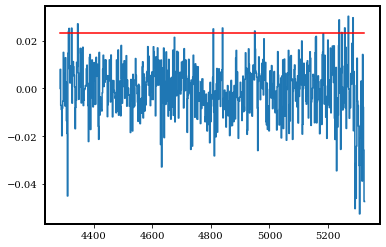

In [26]:
#here!

fff = open("timeBM", "r")
timeBM = []
for x in fff:
    x = float(x)
    timeBM.append(x)
    
fff = open("timeRM", "r")
timeRM = []
for x in fff:
    x = float(x)
    timeRM.append(x)
    
fff = open("timeBJ", "r")
timeBJ = []
for x in fff:
    x = float(x)
    timeBJ.append(x)
    
fff = open("timeRJ", "r")
timeRJ = []
for x in fff:
    x = float(x)
    timeRJ.append(x)
    
BJXpoints = np.linspace(3625, 5460, 4200)
print(BJXpoints[665:3485])

RJXpoints = np.linspace(5525, 7575, 4200)
print(RJXpoints[800:3200])

countGlob = 1
holder_arrayBM = []

path = 'C:/Users/Admin/newMay19/'
consts = []
with open(path+'BTarOutDis') as file:
    for line in file:
        line = line.strip('\n')
        filepath = path + line
        hdul = fits.open(filepath)
        typeEx = hdul[0].data
        typeEx = typeEx[1]
        typeEx = typeEx.flatten()

        hdul.close()
        if countGlob == 1:
            
            holder_arrayBM = typeEx
        else:
            
            holder_arrayBM = np.vstack((holder_arrayBM, typeEx))
        countGlob = 2
countGlob = 1
holder_arrayBJ = []

path = 'C:/Users/Admin/newJul18/'
consts = []
with open(path+'BTarOutDis') as file:
    for line in file:
        line = line.strip('\n')
        filepath = path + line
        hdul = fits.open(filepath)
        typeEx = hdul[0].data
        typeEx = typeEx[1]
        typeEx = typeEx.flatten()

        hdul.close()
        if countGlob == 1:
            
            holder_arrayBJ = typeEx
        else:
            
            holder_arrayBJ = np.vstack((holder_arrayBJ, typeEx))
        countGlob = 2


empties = []
areasMod =[]
tempMeans = np.zeros(2400)
fortrailJ = []
averageTimeJ = []
def f(x, c, q,A, B): 
    return c*x*x*x + q*x*x + A*x + B
means = np.zeros(2400)
stageRJ = []
xpointss = np.linspace(0,2400,2400)
areas = []
count = 0
minicount = 0
xinarea = np.linspace(0,160,160)
stds = []
for i in range(113):
    flux = holder_arrayBJ[i]
    flux = flux[1500:3900]
    tmp1 = flux[0:35]
    xp1 = xpointss[0:35]
    
    tmp2 = flux[125:800]
    xp2 = xpointss[125:800]
    tmp3 = flux[1100:1180]
    xp3 = xpointss[1100:1180]
    tmp4 = flux[1330:1440]
    xp4 = xpointss[1330:1440]
    tmp5 = flux[1550:2400]
    xp5 = xpointss[1550:2400]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    
    
    
    
    
    xpF = np.append(xp1,xp2)
    xpF = np.append(xpF, xp3)
    xpF = np.append(xpF, xp4)
    xpF = np.append(xpF, xp5)
    popt, pcov = curve_fit(f, xpF, emptiedflux)
    fluxNormed = flux/f(xpointss, popt[0], popt[1], popt[2], popt[3])
    stds.append(np.std(fluxNormed[502:731]))
    tempMeans = fluxNormed
        #tmp = uniform_filter(np.clip(tempMeans[1000:1500],0.95,1.15),size=5)
    tmp = np.clip(tempMeans,0.95,1.15)
    differ = tmp
        #differ = tmp[200:350]- straightLine([1200,1350],[1.015,1.09], xpointss[1200:1350])
    if minicount == 0:
        fortrailJ = differ
    else:
        fortrailJ = np.vstack((fortrailJ, differ))
    count = 0
    minicount = 1
    tempMeans = np.zeros(2400)
    means = means + fluxNormed
tempMeans = np.zeros(2400)
avgTSlice = 0
count=0
for i in range(120):
    flux = holder_arrayBM[i]
    flux = flux[1500:3900]
    tmp1 = flux[0:35]
    xp1 = xpointss[0:35]
    
    tmp2 = flux[125:800]
    xp2 = xpointss[125:800]
    tmp3 = flux[1100:1180]
    xp3 = xpointss[1100:1180]
    tmp4 = flux[1330:1440]
    xp4 = xpointss[1330:1440]
    tmp5 = flux[1550:2400]
    xp5 = xpointss[1550:2400]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    
    

    
    
    xpF = np.append(xp1,xp2)
    xpF = np.append(xpF, xp3)
    xpF = np.append(xpF, xp4)
    xpF = np.append(xpF, xp5)
    popt, pcov = curve_fit(f, xpF, emptiedflux)
    fluxNormed = flux/f(xpointss, popt[0], popt[1], popt[2], popt[3])
    stds.append(np.std(fluxNormed[502:731]))
    tempMeans = fluxNormed
        #tmp = uniform_filter(np.clip(tempMeans[1000:1500],0.95,1.15),size=5)
    tmp = np.clip(tempMeans,0.95,1.15)
    differ = tmp
        #differ = tmp[200:350]- straightLine([1200,1350],[1.015,1.09], xpointss[1200:1350])

    fortrailJ = np.vstack((fortrailJ, differ))
    count = 0
    minicount = 1
    tempMeans = np.zeros(2400)

    means = means + fluxNormed



#800:1100


xpoints = BJXpoints[1500:3900]
xpoints = xpoints
xpointss = xpoints[10:-10]
list1 = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,86,33,34,35,36,86,37,38,39,40,41,42,43,44,45,46,47]
list2 = [115,116,117,118,119,21,22,23,24,25,26,27,28,30,31,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,4,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114]
list2 = np.array(list2)+112
cumsum = np.zeros(len(xpointss))
for i in range(len(list1)):
    error = (fortrailJ[list1[i]][4:-16]- fortrailJ[list2[i]][10:-10])
    cumsum = cumsum+error
    
dataPlot = (cumsum-np.nanmedian(cumsum))/len(list1)   
dataPlot = np.nanmean(np.pad(dataPlot.astype(float), (0, 4 - dataPlot.size%4), mode='constant', constant_values=np.NaN).reshape(-1, 4), axis=1)
print(len(dataPlot))
x = xpointss
x = np.nanmean(np.pad(x.astype(float), (0, 4 - x.size%4), mode='constant', constant_values=np.NaN).reshape(-1, 4), axis=1)
xss = (x[1]-x[0])/2
xs = [x[0]-xss]
ys = [0]
for i in range(len(x)):
    xs.append(x[i] - xss)
    xs.append(x[i] + xss)
    ys.append(dataPlot[i])
    ys.append(dataPlot[i])
xs.append(x[-1] + xss)
ys.append(0)

    
    
    
plt.plot(xs, ys)
plt.plot([xpointss[0],xpointss[-1]],[(2.565601940123723-np.nanmedian(cumsum))/len(list1),(2.565601940123723-np.nanmedian(cumsum))/len(list1)], c='r')#1%
#plt.plot([xpointss[0],xpointss[-1]],[2.134711145740210,2.134711145740210], c='r')#0.1%
print(np.sum(cumsum))
errorxpoints = xs
errorypoints = ys
onePer = (2.565601940123723-np.nanmedian(cumsum))/len(list1)

xpointstokeepB = xpointss
ypointstokeepB = (cumsum-np.nanmedian(cumsum))/len(list1)

In [24]:
xpoints = BJXpoints[1500:3900]
xpoints = xpoints[1000:1500]
xpointss = xpoints[74:431]
list1 = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,86,33,34,35,36,86,37,38,39,40,41,42,43,44,45,46,47]
list2 = [115,116,117,118,119,21,22,23,24,25,26,27,28,30,31,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,4,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114]
list2 = np.array(list2)+112
cumsum = np.zeros(len(xpointss))
for i in range(len(list1)):
    error = (fortrailJ[list1[i]][4:-16]- fortrailJ[list2[i]][10:-10])
    cumsum = cumsum+error
    
dataPlot = (cumsum-np.nanmedian(cumsum))/len(list1)   
dataPlot = np.nanmean(np.pad(dataPlot.astype(float), (0, 4 - dataPlot.size%4), mode='constant', constant_values=np.NaN).reshape(-1, 4), axis=1)
x = xpointss
x = np.nanmean(np.pad(x.astype(float), (0, 4 - x.size%4), mode='constant', constant_values=np.NaN).reshape(-1, 4), axis=1)
xss = (x[1]-x[0])/2
xs = [x[0]-xss]
ys = [0]
for i in range(len(x)):
    xs.append(x[i] - xss)
    xs.append(x[i] + xss)
    ys.append(dataPlot[i])
    ys.append(dataPlot[i])
xs.append(x[-1] + xss)
ys.append(0)

    
    
    
plt.plot(xs, ys)
plt.plot([xpointss[0],xpointss[-1]],[(2.565601940123723-np.nanmedian(cumsum))/len(list1),(2.565601940123723-np.nanmedian(cumsum))/len(list1)], c='r')#1%
#plt.plot([xpointss[0],xpointss[-1]],[2.134711145740210,2.134711145740210], c='r')#0.1%
print(np.sum(cumsum))
errorxpoints = xs
errorypoints = ys
onePer = (2.565601940123723-np.nanmedian(cumsum))/len(list1)

xpointstokeepB = xpointss
ypointstokeepB = (cumsum-np.nanmedian(cumsum))/len(list1)

IndexError: index 227 is out of bounds for axis 0 with size 46

In [28]:
#here!

fff = open("timeBM", "r")
timeBM = []
for x in fff:
    x = float(x)
    timeBM.append(x)
    
fff = open("timeRM", "r")
timeRM = []
for x in fff:
    x = float(x)
    timeRM.append(x)
    
fff = open("timeBJ", "r")
timeBJ = []
for x in fff:
    x = float(x)
    timeBJ.append(x)
    
fff = open("timeRJ", "r")
timeRJ = []
for x in fff:
    x = float(x)
    timeRJ.append(x)
    
BJXpoints = np.linspace(3625, 5460, 4200)
print(BJXpoints[665:3485])

RJXpoints = np.linspace(5525, 7575, 4200)
print(RJXpoints[800:3200])

countGlob = 1
holder_arrayBM = []

path = 'C:/Users/Admin/newMay19/'
consts = []
with open(path+'BTarOutDis') as file:
    for line in file:
        line = line.strip('\n')
        filepath = path + line
        hdul = fits.open(filepath)
        typeEx = hdul[0].data
        typeEx = typeEx[1]
        typeEx = typeEx.flatten()

        hdul.close()
        if countGlob == 1:
            
            holder_arrayBM = typeEx
        else:
            
            holder_arrayBM = np.vstack((holder_arrayBM, typeEx))
        countGlob = 2
countGlob = 1
holder_arrayBJ = []
path = 'C:/Users/Admin/newJul18/'
consts = []
with open(path+'BTarOutDis') as file:
    for line in file:
        line = line.strip('\n')
        filepath = path + line
        hdul = fits.open(filepath)
        typeEx = hdul[0].data
        typeEx = typeEx[1]
        typeEx = typeEx.flatten()

        hdul.close()
        if countGlob == 1:
            
            holder_arrayBJ = typeEx
        else:
            
            holder_arrayBJ = np.vstack((holder_arrayBJ, typeEx))
        countGlob = 2


empties = []
areasMod =[]
tempMeans = np.zeros(2400)
fortrailJ = []
averageTimeJ = []
def f(x, c, q,A, B): 
    return c*x*x*x + q*x*x + A*x + B
means = np.zeros(2400)
stageRJ = []
xpointss = np.linspace(0,2400,2400)
areas = []
count = 0
minicount = 0
xinarea = np.linspace(0,160,160)
specialTimeArrB = []
specialTimeArrBB = []
for i in range(113):
    flux = holder_arrayBJ[i]
    flux = flux[1500:3900]
    tmp1 = flux[0:35]
    xp1 = xpointss[0:35]
    
    tmp2 = flux[125:800]
    xp2 = xpointss[125:800]
    tmp3 = flux[1100:1180]
    xp3 = xpointss[1100:1180]
    tmp4 = flux[1330:1440]
    xp4 = xpointss[1330:1440]
    tmp5 = flux[1550:2400]
    xp5 = xpointss[1550:2400]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    
    

    
    
    xpF = np.append(xp1,xp2)
    xpF = np.append(xpF, xp3)
    xpF = np.append(xpF, xp4)
    xpF = np.append(xpF, xp5)
    popt, pcov = curve_fit(f, xpF, emptiedflux)
    fluxNormed = flux/f(xpointss, popt[0], popt[1], popt[2], popt[3])
    
    if np.sum(tempMeans) == 0:
        tempMeans = fluxNormed
        count = count +1
        avgTSlice = timeBJ[i]
    else:
        tempMeans = np.vstack((fluxNormed,tempMeans))
        avgTSlice = timeBJ[i] + avgTSlice
        count = count +1
    if count == 5:
        tempMeans = np.median(np.array(tempMeans),axis=0)
        #tmp = uniform_filter(np.clip(tempMeans[1000:1500],0.95,1.15),size=5)
        tmp = np.clip(tempMeans[1000:1500],0.95,1.15)
        differ = tmp[64:441]
        #differ = tmp[200:350]- straightLine([1200,1350],[1.015,1.09], xpointss[1200:1350])
        if minicount == 0:
            fortrailJ = differ
        else:
            fortrailJ = np.vstack((fortrailJ, differ))
        count = 0
        minicount = 1
        tempMeans = np.zeros(2400)
        averageTimeJ.append(avgTSlice/5)
    means = means + fluxNormed
    if i == 44:
        specialStackB = fluxNormed
        specialTimeB = timeBJ[i]
        specialTimeArrB.append(timeBJ[i])
    if i in [45,46,47]:
        specialStackB = np.vstack((specialStackB,fluxNormed))
        specialTimeB = specialTimeB + timeBJ[i]
        specialTimeArrB.append(timeBJ[i])
    if i == 48:
        specialStackB =  np.vstack((specialStackB,fluxNormed))
        specialStackB = np.mean(np.array(specialStackB),axis=0)
        specialStackB = np.clip(specialStackB[1000:1500],0.95,1.15)
        specialStackB = specialStackB[64:441]
        specialTimeB = specialTimeB+timeBJ[i]
        specialTimeArrB.append(timeBJ[i])
        specialTimeB = specialTimeB/5
        
        
    if i == 62:
        specialStackBB = fluxNormed
        specialTimeBB = timeBJ[i]
        specialTimeArrBB.append(timeBJ[i])
    if i in [63,64,65]:
        specialStackBB = np.vstack((specialStackBB,fluxNormed))
        specialTimeBB = specialTimeBB + timeBJ[i]
        specialTimeArrBB.append(timeBJ[i])
    if i == 66:
        specialStackBB =  np.vstack((specialStackBB,fluxNormed))
        specialStackBB = np.median(np.array(specialStackBB),axis=0)
        specialStackBB = np.clip(specialStackBB[1000:1500],0.95,1.15)
        specialStackBB = specialStackBB[64:441]
        specialTimeBB = specialTimeBB+timeBJ[i]
        specialTimeArrBB.append(timeBJ[i])
        specialTimeBB = specialTimeBB/5
meansJ = means
tempMeans = np.zeros(2400)
avgTSlice = 0
count=0
means = np.zeros(2400)
specialTimeArr = []
specialTimeArrM = []
for i in range(120):
    flux = holder_arrayBM[i]
    flux = flux[1500:3900]
    tmp1 = flux[0:35]
    xp1 = xpointss[0:35]
    
    tmp2 = flux[125:800]
    xp2 = xpointss[125:800]
    tmp3 = flux[1100:1180]
    xp3 = xpointss[1100:1180]
    tmp4 = flux[1330:1440]
    xp4 = xpointss[1330:1440]
    tmp5 = flux[1550:2400]
    xp5 = xpointss[1550:2400]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    
    
    

    
    
    xpF = np.append(xp1,xp2)
    xpF = np.append(xpF, xp3)
    xpF = np.append(xpF, xp4)
    xpF = np.append(xpF, xp5)
    popt, pcov = curve_fit(f, xpF, emptiedflux)
    fluxNormed = flux/f(xpointss, popt[0], popt[1], popt[2], popt[3])
    
    if np.sum(tempMeans) == 0:
        tempMeans = fluxNormed
        count = count +1
        avgTSlice = timeBM[i]
    else:
        tempMeans = np.vstack((fluxNormed,tempMeans))
        avgTSlice = timeBM[i] + avgTSlice
        count = count +1
    if count == 5:
        tempMeans = np.median(np.array(tempMeans),axis=0)
        #tmp = uniform_filter(np.clip(tempMeans[1000:1500],0.95,1.15),size=5)
        tmp = np.clip(tempMeans[1000:1500],0.95,1.15)
        differ = tmp[64:441]
        #differ = tmp[200:350]- straightLine([1200,1350],[1.015,1.09], xpointss[1200:1350])

        fortrailJ = np.vstack((fortrailJ, differ))
        count = 0
        minicount = 1
        tempMeans = np.zeros(2400)
        averageTimeJ.append(avgTSlice/5)
    means = means + fluxNormed
    if i == 60:
        specialStack = fluxNormed
        specialTime = timeBM[i]
        specialTimeArr.append(timeBM[i])
    if i in [61,62,63]:
        specialStack = np.vstack((specialStack,fluxNormed))
        specialTime = specialTime + timeBM[i]
        specialTimeArr.append(timeBM[i])
    if i == 64:
        specialStack =  np.vstack((specialStack,fluxNormed))
        specialStack = np.mean(np.array(specialStack),axis=0)
        specialStack = np.clip(specialStack[1000:1500],0.95,1.15)
        specialStack = specialStack[64:441]
        specialTime = specialTime+timeBM[i]
        specialTime = specialTime/5
        specialTimeArr.append(timeBM[i])
        
    if i == 81:
        specialStackM = fluxNormed
        specialTimeM = timeBM[i]
        specialTimeArrM.append(timeBM[i])
    if i in [82,83,84]:
        specialStackM = np.vstack((specialStackM,fluxNormed))
        specialTimeM = specialTimeM + timeBM[i]
        specialTimeArrM.append(timeBM[i])
    if i == 85:
        specialStackM =  np.vstack((specialStackM,fluxNormed))
        specialStackM = np.mean(np.array(specialStackM),axis=0)
        specialStackM = np.clip(specialStackM[1000:1500],0.95,1.15)
        specialStackM = specialStackM[64:441]
        specialTimeM = specialTimeM+timeBM[i]
        specialTimeM = specialTimeM/5
        specialTimeArrM.append(timeBM[i])

meansM = means

#800:1100

[3915.61085973 3916.04786854 3916.48487735 ... 5146.66468207 5147.10169088
 5147.53869969]
[5915.56918314 5916.05739462 5916.5456061  ... 7085.81209812 7086.3003096
 7086.78852108]


In [11]:
phasesJ = foldMeth(np.array(averageTimeJ[:22])-2457000- 1296.0255697684468,0.08029820145279275)
phasesM = foldMeth(np.array(averageTimeJ[22:])-2457000- 1296.0255697684468,0.08029820145279275)
specialPhase = foldMeth(np.array(timeBM[60:65])-2457000- 1296.0255697684468-  (0.08029820145279275*415),0.08029820145279275)
specialPhase

array([0.30370402, 0.32392427, 0.34414626, 0.36436653, 0.38458737])

In [13]:
print(len(fortrailJ[0][10:-10]))

357


In [12]:

timeBJAdj = np.array(averageTimeJ)-2457000 - 1296.0255697684468 -  (0.08029820145279275*415)
WHTVelocityPhaseJ = foldMeth(timeBJAdj,  0.08029820145279275)
WHTVelocityPhaseJ

array([0.43378811, 0.54012801, 0.64672248, 0.75001591, 0.85114743,
       0.95242196, 0.05366814, 0.16352363, 0.27045719, 0.37155825,
       0.47265999, 0.57376035, 0.67552407, 0.77706951, 0.87817113,
       0.9792724 , 0.08037504, 0.18205745, 0.28354361, 0.38464567,
       0.48574565, 0.58684494, 0.13085071, 0.23195783, 0.33306795,
       0.43417703, 0.53528473, 0.6363923 , 0.73750057, 0.83860664,
       0.93971546, 0.0408235 , 0.1419322 , 0.24303872, 0.34414569,
       0.44525046, 0.54635455, 0.64746185, 0.74856581, 0.84967195,
       0.95077625, 0.05188088, 0.15298621, 0.25409487, 0.35520237,
       0.45630838])

In [15]:
0.33111773 - 0.31089736

0.020220369999999988

In [13]:


specialTimeArr = np.array(specialTimeArrM)-2457000 - 1296.0255697684468 -  (0.08029820145279275*415)
WHTVelocityPhaseJ = foldMeth(specialTimeArr,  0.08029820145279275)
WHTVelocityPhaseJ

array([0.72834451, 0.74856478, 0.76878676, 0.78900876, 0.80922958])

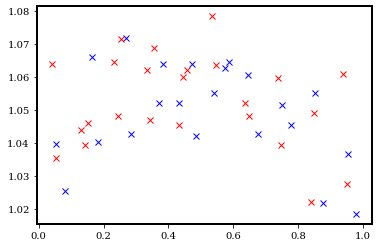

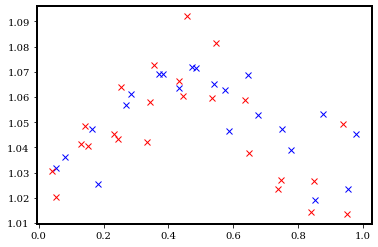

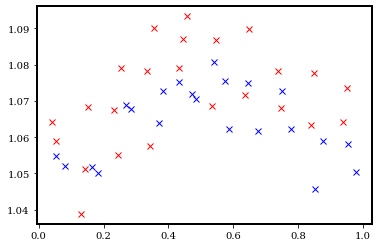

In [17]:
dummypoints = np.linspace(0,356,357)
averagesJ1 = []
averagesM1 = []
averagesJ2 = []
averagesM2 = []
averagesJ3 = []
averagesM3 = []
for i in range(22):
    #plt.plot(dummypoints,fortrailJ[i][4:-16])
    #plt.plot(dummypoints[185:220],fortrailJ[i][189:224])
    averagesJ1.append(np.mean(fortrailJ[i][189:199]))
    averagesJ2.append(np.mean(fortrailJ[i][199:209]))
    averagesJ3.append(np.mean(fortrailJ[i][209:224]))
    plt.show()
for i in range(22,46):
    #plt.plot(dummypoints,fortrailJ[i][10:-10])
    #plt.plot(dummypoints[185:220],fortrailJ[i][195:230])
    averagesM1.append(np.mean(fortrailJ[i][195:205]))
    averagesM2.append(np.mean(fortrailJ[i][205:215]))
    averagesM3.append(np.mean(fortrailJ[i][215:230]))
    #plt.show()
    
plt.plot(phasesJ,averagesJ1, 'bx')
plt.plot(phasesM,averagesM1, 'rx')
plt.show()
plt.plot(phasesJ,averagesJ2, 'bx')
plt.plot(phasesM,averagesM2, 'rx')
plt.show()
plt.plot(phasesJ,averagesJ3, 'bx')
plt.plot(phasesM,averagesM3, 'rx')
plt.show()

0.35133787577956543


D:\conda\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning: Mean of empty slice
D:\conda\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice
D:\conda\lib\site-packages\ipykernel_launcher.py:100: RuntimeWarning: Mean of empty slice
D:\conda\lib\site-packages\ipykernel_launcher.py:114: RuntimeWarning: Mean of empty slice
D:\conda\lib\site-packages\ipykernel_launcher.py:129: RuntimeWarning: Mean of empty slice
D:\conda\lib\site-packages\ipykernel_launcher.py:156: RuntimeWarning: Mean of empty slice


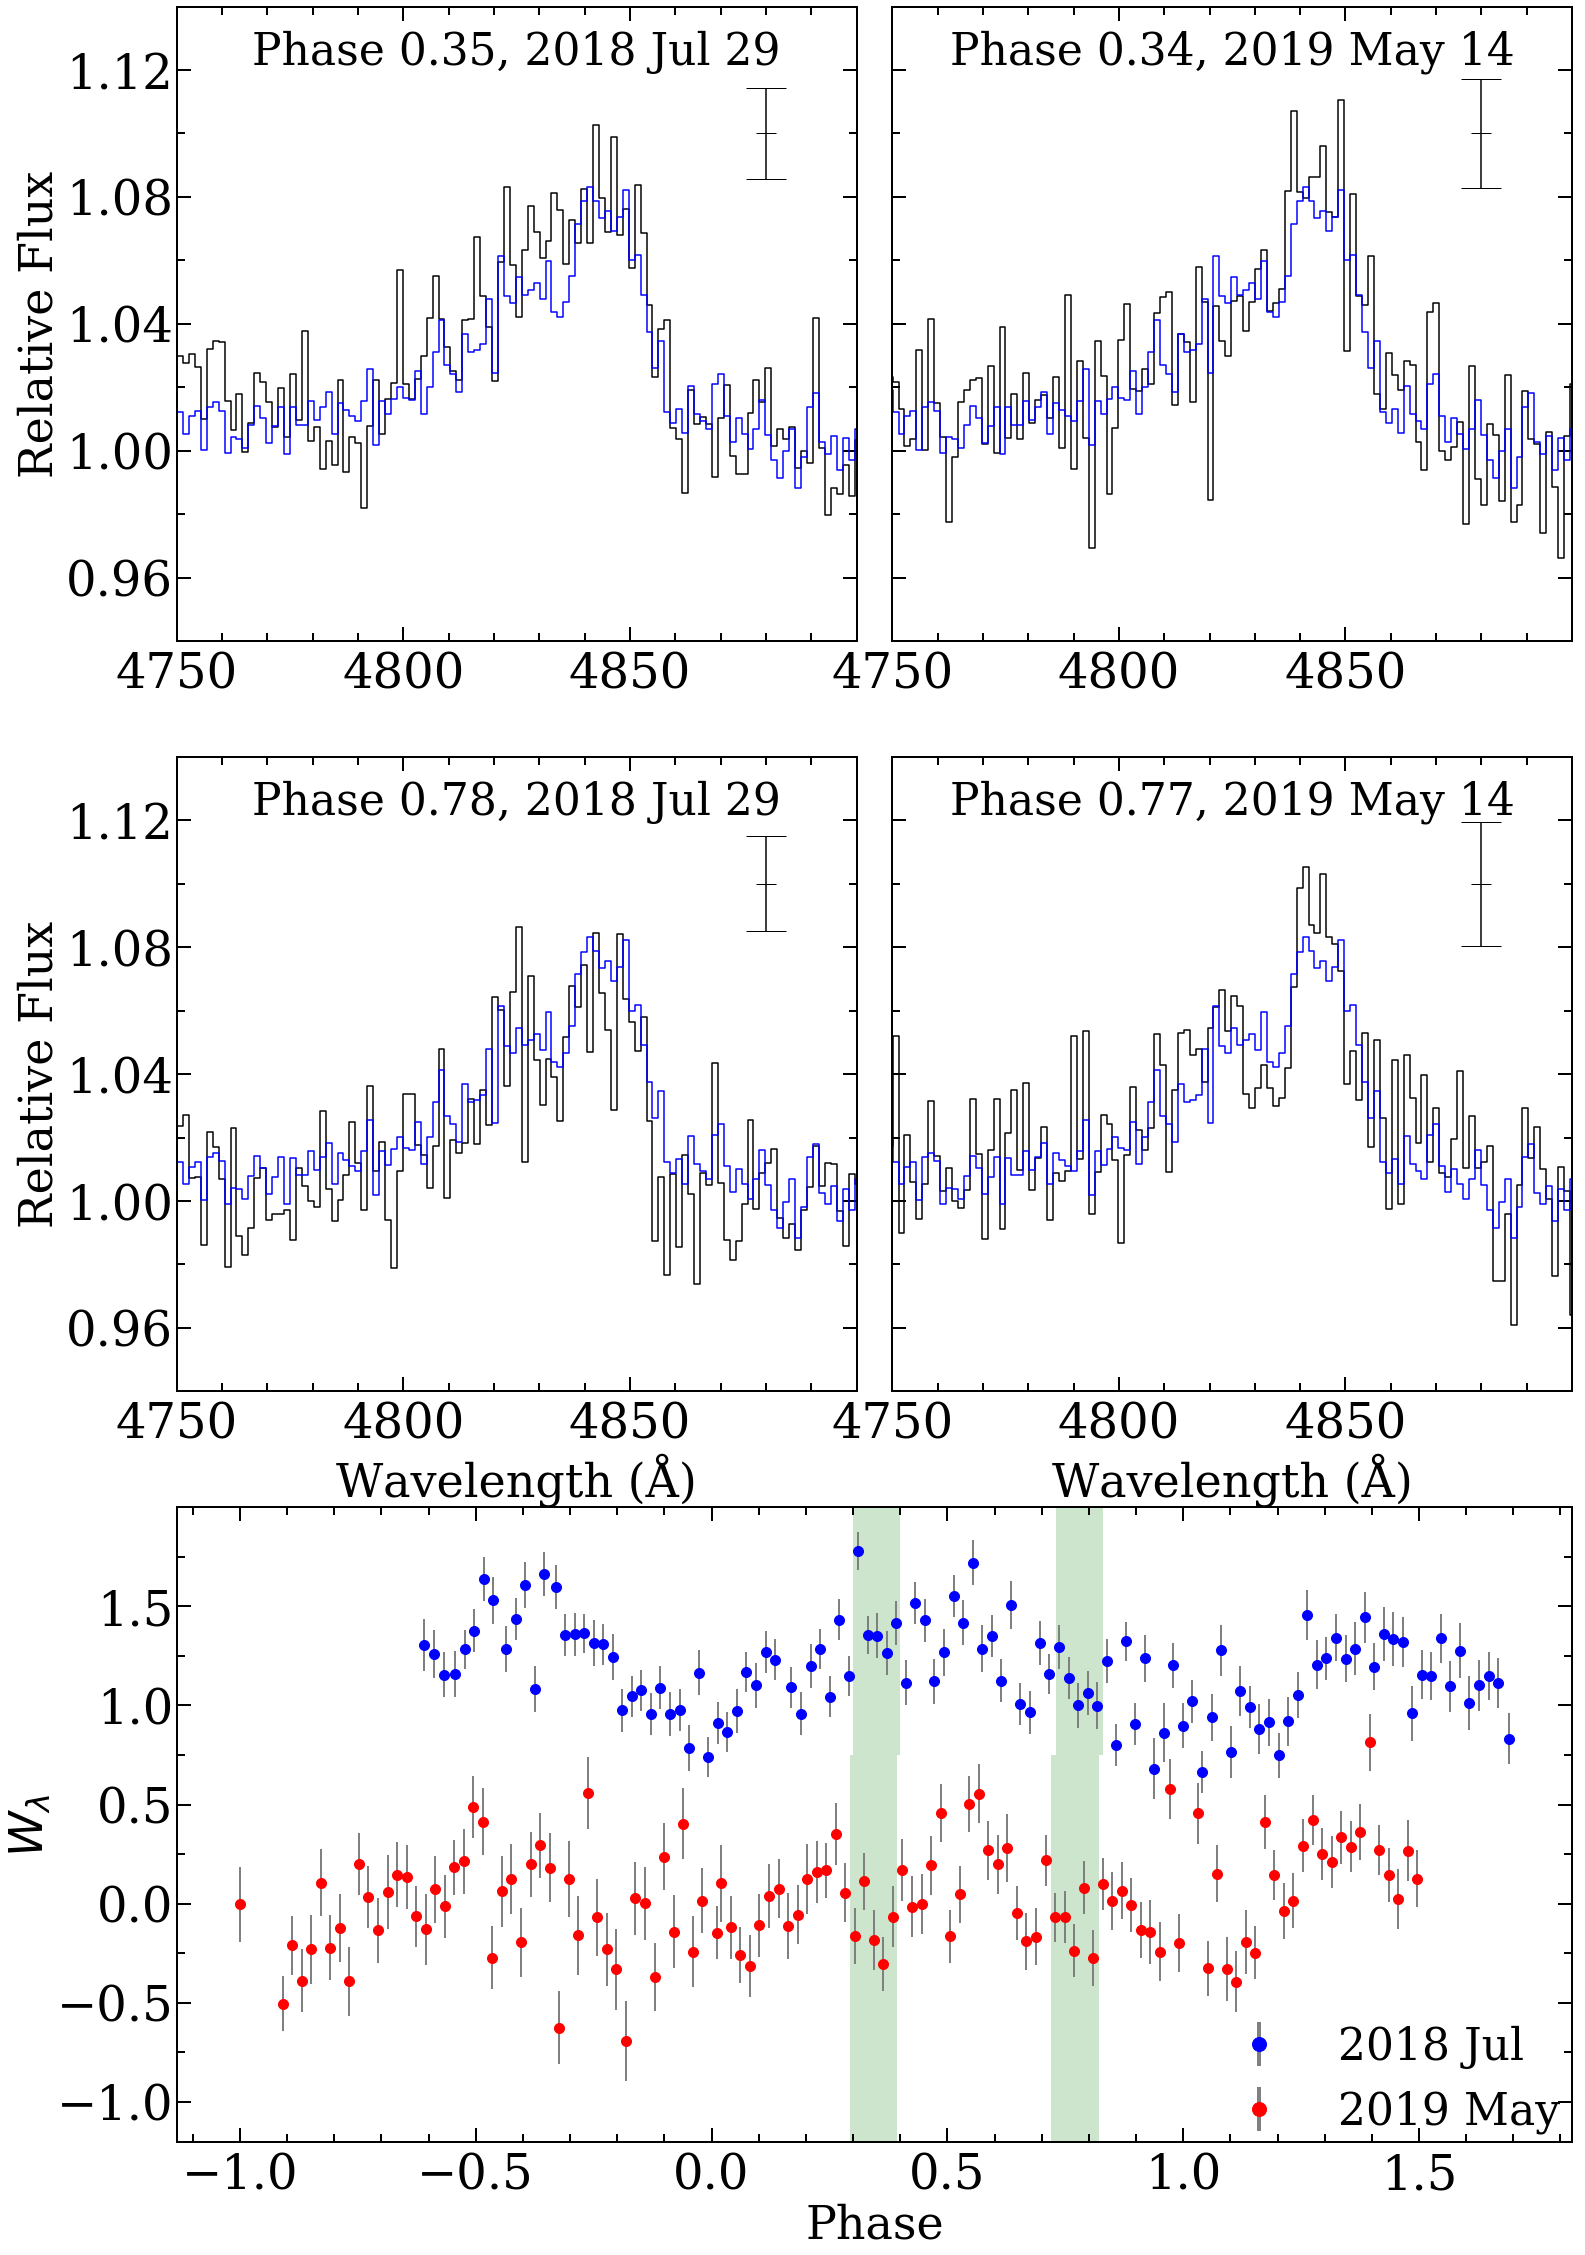

In [32]:
import matplotlib.patches as patches
BJEWs = np.load('EWs/BJEWs.npy')
BJEWsErr = np.load('EWs/BJEWsErr.npy')

BMEWs = np.load('EWs/BMEWs.npy')
BMEWsErr = np.load('EWs/BMEWsErr.npy')

RJEWs = np.load('EWs/RJEWs.npy')
RJEWsErr = np.load('EWs/RJEWsErr.npy')

RMEWs = np.load('EWs/RMEWs.npy')
RMEWsErr = np.load('EWs/RMEWsErr.npy')

fullWHTSTackTJ = np.append(timeBJ, timeRJ)
fullWHTSTackTM = np.append(timeBM, timeRM)


fullWHTSTackFJ = np.append(BJEWs, RJEWs)
fullWHTSTackFM = np.append(BMEWs, RMEWs)


fullWHTSTackEJ = np.append(BJEWsErr, RJEWsErr)
fullWHTSTackEM = np.append(BMEWsErr, RMEWsErr)

#plt.errorbar(timeBJ,BJEWs,yerr=BJEWsErr,  ls='',c='b')
#plt.errorbar(np.array(timeBM)-289.0630628543347, BMEWs-3, yerr=BMEWsErr,  ls='',c='r')


timeBJAdj = np.array(timeBJ)-2457000 - 1296.0255697684468 -  (0.08029820145279275*415)
WHTVelocityPhaseJ = foldMeth(timeBJAdj,  0.08029820145279275)
WHTVelocityPhaseJPart1 = 1-np.array(WHTVelocityPhaseJ[:30])
WHTVelocityPhaseJPart1 = -WHTVelocityPhaseJPart1
WHTVelocityPhaseJPart2 = WHTVelocityPhaseJ[30:79] 
WHTVelocityPhaseJPart3 = 1 + np.array(WHTVelocityPhaseJ[79:])
WHTVelocityPhaseJ = np.append(WHTVelocityPhaseJPart1,WHTVelocityPhaseJPart2)
WHTVelocityPhaseJ = np.append(WHTVelocityPhaseJ,WHTVelocityPhaseJPart3)


timeBMAdj = np.array(timeBM)-2457000 - 1296.0255697684468 -  (0.08029820145279275*4015)
WHTVelocityPhaseM = foldMeth(timeBMAdj,  0.08029820145279275)

WHTVelocityPhaseMPart1 = 1-np.array(WHTVelocityPhaseM[:46])
WHTVelocityPhaseMPart1 = -WHTVelocityPhaseMPart1
WHTVelocityPhaseMPart2 = WHTVelocityPhaseM[46:96]
WHTVelocityPhaseMPart3 = 1 + np.array(WHTVelocityPhaseM[96:])
WHTVelocityPhaseM = np.append(WHTVelocityPhaseMPart1,WHTVelocityPhaseMPart2)
WHTVelocityPhaseM = np.append(WHTVelocityPhaseM,WHTVelocityPhaseMPart3)
print(np.mean(WHTVelocityPhaseJ[44:49]))#0.34
samePhaseJ = np.load('samePhaseJ.npy')
samePhaseM = np.load('samePhaseM.npy')
samePhaseJE = np.load('samePhaseJE.npy')
samePhaseME = np.load('samePhaseME.npy')
#plt.errorbar(WHTVelocityPhaseJ,samePhaseJ,yerr=samePhaseJE,  ls='',c='b')
#plt.errorbar(WHTVelocityPhaseM, samePhaseM-1, yerr=samePhaseME,  ls='',c='r')
#plt.xlim(-1,2)


BJXpoints = np.linspace(3625, 5460, 4200)
BJXpoints = BJXpoints[1500:3900]
xpointss = BJXpoints[1000:1500]

    #RCor 1.4646344367729398
    #BCor 1.3110264348661076

# 
rc('axes', linewidth=2)
fig = plt.figure(figsize=(20,30))
datJul = specialStackB[4:-16]#fortrailJ[10][4:-16]#was 10
datJul = np.nanmean(np.pad(datJul.astype(float), (0, 3 - datJul.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
x = xpointss[74:431]
x = np.nanmean(np.pad(x.astype(float), (0, 3 - x.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
xss = (x[1]-x[0])/2
xs = [x[0]-xss]
ys = [0]
for i in range(len(x)):
    xs.append(x[i] - xss)
    xs.append(x[i] + xss)
    ys.append(datJul[i])
    ys.append(datJul[i])
xs.append(x[-1] + xss)
ys.append(0)



axs00 = plt.subplot2grid((3,2), (0,0))
axs00.set_title('Phase 0.35, 2018 Jul 29', fontsize=44,x=0.5, y=0.9)
fig.tight_layout(w_pad=2.5,h_pad=10)                            #######################################HEREEEEEEEEEEEEEEEEE
axs00.plot((np.array(xs)-3.496070492976287), ys, color='black')

#4,-16#############################axs[2, 0].plot(xs[1000:], ys[1000:], color='black')
#axs[0, 0].bar(x,datJul,width=1.4,color='white',edgecolor='black')#

stdest = np.std(np.concatenate([ys[1:65],ys[-65:-3]]))
axs00.errorbar([4880],[1.1],yerr=stdest,marker='_',ms=20,color='black',capsize=20)
axs00.set_xlim(4750, 4900)
axs00.set_ylim(0.94,1.14)


datMay = specialStack[10:-10]#fortrailJ[35][10:-10]#35 #26 was
datMay = np.nanmean(np.pad(datMay.astype(float), (0, 3 - datMay.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
ys = [0]
for i in range(len(x)):
    ys.append(datMay[i])
    ys.append(datMay[i])
ys.append(0)
axs01 = plt.subplot2grid((3,2), (0,1))
axs01.plot(np.array(xs)-3.496070492976287, ys, color='black')
axs01.set_title('Phase 0.34, 2019 May 14', fontsize=44,x=0.5, y=0.9)
axs01.set_xlim(4750, 4900)
axs01.set_ylim(0.94,1.14)
stdest = np.std(np.concatenate([ys[1:65],ys[-65:-3]]))
axs01.errorbar([4880],[1.1],yerr=stdest,marker='_',ms=20,color='black',capsize=20)
datJul = fortrailJ[13][4:-16] ####################
datJul = np.nanmean(np.pad(datJul.astype(float), (0, 3 - datJul.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
ys = [0]
for i in range(len(x)):
    ys.append(datJul[i])
    ys.append(datJul[i])
ys.append(0)
axs10 = plt.subplot2grid((3,2), (1,0))
axs10.plot(np.array(xs)-3.496070492976287, ys, color='black')
axs10.set_title('Phase 0.78, 2018 Jul 29', fontsize=44,x=0.5, y=0.9)
axs10.set_xlim(4750, 4900)
axs10.set_ylim(0.94,1.14)
stdest = np.std(np.concatenate([ys[1:65],ys[-65:-3]]))
axs10.errorbar([4880],[1.1],yerr=stdest,marker='_',ms=20,color='black',capsize=20)

datMay = specialStackM[10:-10]
datMay = np.nanmean(np.pad(datMay.astype(float), (0, 3 - datMay.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
ys = [0]
for i in range(len(x)):
    ys.append(datMay[i])
    ys.append(datMay[i])
ys.append(0)
axs11 = plt.subplot2grid((3,2), (1,1))
axs11.plot(np.array(xs)-3.496070492976287, ys, color='black')

axs11.set_title('Phase 0.77, 2019 May 14', fontsize=44,x=0.5, y=0.9)
axs11.set_xlim(4750, 4900)
axs11.set_ylim(0.94,1.14)
stdest = np.std(np.concatenate([ys[1:65],ys[-65:-3]]))
axs11.errorbar([4880],[1.1],yerr=stdest,marker='_',ms=20,color='black',capsize=20)
axs21 = plt.subplot2grid((3,2), (2,1))
axs21.plot(np.array(errorxpoints)-3.496070492976287, errorypoints, color='black')

#axs[2,1].plot(errorxpoints, errorypoints,'k-',linewidth=1)
axs21.plot([errorxpoints[0],errorxpoints[-2]],[onePer,onePer], 'r')
axs21.set_xlim(4750, 4900)

meansTot = np.zeros(len(fortrailJ[0][4:-16]))
for i in range(22):
    meansTot = meansTot+fortrailJ[i][4:-16]
for i in range(22,46):
    meansTot = meansTot+fortrailJ[i][10:-10]
meansTot = meansTot/46
meansTot = np.nanmean(np.pad(meansTot.astype(float), (0, 3 - meansTot.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
ys = [0]
for i in range(len(x)):
    ys.append(meansTot[i])
    ys.append(meansTot[i])
ys.append(0)


axs20 = plt.subplot2grid((3,2), (2,0),colspan=2)
axs20.errorbar(WHTVelocityPhaseJ,samePhaseJ,yerr=samePhaseJE,  ls='',c='b',lw=1, marker='o',ecolor='grey',ms=10,elinewidth=2)
axs20.errorbar(WHTVelocityPhaseM, samePhaseM-1, yerr=samePhaseME,  ls='',c='r',lw=1, marker='o',ecolor='grey',ms=10,elinewidth=2)




xlimits = axs20.set_xlim()
axs20.errorbar([-1.2,-1.2], [0,0], yerr=[0.01,0.01],ms=14, c='b', lw=1, marker='o',ecolor='grey', ls = '', label='2018 Jul',elinewidth=4)
axs20.errorbar([-1.2,-1.2], [0,0], yerr=[0.01,0.01],ms=14, c='r', lw=1, marker='o',ecolor='grey', ls = '', label='2019 May',elinewidth=4)

rect = patches.Rectangle((0.30,0.75),0.10,1.5,facecolor='g',alpha=0.2)

# Add the patch to the Axes
axs20.add_patch(rect)
rect = patches.Rectangle((0.293,-1.25),0.101,2,facecolor='g',alpha=0.2)

# Add the patch to the Axes
axs20.add_patch(rect)
rect = patches.Rectangle((0.73,0.75),0.101,1.5,facecolor='g',alpha=0.2)
axs20.add_patch(rect)
rect = patches.Rectangle((0.72,-1.25),0.101,2,facecolor='g',alpha=0.2)
axs20.add_patch(rect)
axs20.set_xlim(xlimits)




axs20.legend(prop={'size': 44},loc='lower right',bbox_to_anchor=(0.02,-0.05,1,1),frameon=False)
axs00.plot(np.array(xs)-3.496070492976287, ys, color='b')
axs01.plot(np.array(xs)-3.496070492976287, ys, color='b')
axs10.plot(np.array(xs)-3.496070492976287, ys, color='b')
axs11.plot(np.array(xs)-3.496070492976287, ys, color='b')
tr1 = np.loadtxt("fromJohn/moreTr/2p0_4s0.dat", usecols=(0,1,2))
BFieldTra4 = tr1[:,0]
WavelTra4 = tr1[:,1]
tr1 = np.loadtxt("fromJohn/moreTr/2p1_4d1.dat", usecols=(0,1,2))
BFieldTra7 = tr1[:,0]
WavelTra7 = tr1[:,1]
#ax222 = axs[2,1].twinx()
#ax222.plot(WavelTra4[70:90],BFieldTra4[70:90])
#ax222.plot(WavelTra7[18:23],BFieldTra7[18:23])

#axs[2,0].plot(wavelength,intensity)



#axs[2,1].set_ylim(-0.01, 0.04)
axs00.set_ylabel('Relative Flux', fontsize=46)
axs10.set_ylabel('Relative Flux', fontsize=46)
axs20.set_ylabel(r'$W_\lambda$', fontsize=46)
for ax in [axs00,axs01,axs10,axs11,axs21]:

    
    
    #ax.set_xticks(np.arange(4770, 4930, 40))
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.yaxis.set_minor_locator(MultipleLocator(0.02))
    ax.tick_params(labelsize=48)
    
    ax.set_xticks(np.arange(4750, 4900, 50))
    #ax.xaxis.set_minor_locator(AutoMinorLocator())
    #ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='x',which='both', width=2,direction='in',pad=10)
    ax.tick_params(axis='y',which='both', width=2,direction='in')
    ax.tick_params(which='major', length=14)
    ax.tick_params(which='minor', length=8)
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
axs21.yaxis.set_major_locator(MultipleLocator(0.02))
axs21.yaxis.set_minor_locator(MultipleLocator(0.01))
axs20.tick_params(which='major', length=14)
axs20.tick_params(which='minor', length=8)
axs20.tick_params(labelsize=48)
axs20.xaxis.set_minor_locator(AutoMinorLocator())
axs20.yaxis.set_minor_locator(MultipleLocator(0.25))
axs20.xaxis.set_ticks_position('both')
axs20.yaxis.set_ticks_position('both')
axs20.tick_params(axis='x',which='both', width=2,direction='in',pad=10)
axs20.tick_params(axis='y',which='both', width=2,direction='in')
axs00.set_yticks(np.arange(0.96, 1.14, 0.04))
axs01.set_yticks(np.arange(0.96, 1.14, 0.04))
axs11.set_yticks(np.arange(0.96, 1.14, 0.04))
axs10.set_yticks(np.arange(0.96, 1.14, 0.04))
axs20.set_yticks(np.arange(-1, 2, 0.5))
axs20.set_xlabel(r"Phase", fontsize=46)
axs10.set_xlabel(r"Wavelength (Å)", fontsize=46)
axs11.set_xlabel(r"Wavelength (Å)", fontsize=46)
axs01.tick_params(axis='y',which='both',labelleft=False,labelright=False)
axs11.tick_params(axis='y',which='both',labelleft=False,labelright=False)
axs21.tick_params(axis='y',which='both',labelleft=False,labelright=True)
axs20.set_ylim(-1.2,2)
#axs00.set_xticklabels([])
#axs01.set_xticklabels([])
#axs10.set_xticklabels([])
#axs11.set_xticklabels([])
bboxx = transforms.Bbox([[-1.9, -1.2], [19.90, 29.9]])
plt.savefig('Phase_Morph.pdf',bbox_inches=bboxx) 
#plt.savefig('outofphasemorphFinal.eps', bbox_inches='tight', pad_inches=0.75 ) 

0.05113314731080275


D:\conda\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: Mean of empty slice
D:\conda\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: Mean of empty slice
D:\conda\lib\site-packages\ipykernel_launcher.py:101: RuntimeWarning: Mean of empty slice
D:\conda\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: Mean of empty slice
D:\conda\lib\site-packages\ipykernel_launcher.py:130: RuntimeWarning: Mean of empty slice
D:\conda\lib\site-packages\ipykernel_launcher.py:157: RuntimeWarning: Mean of empty slice


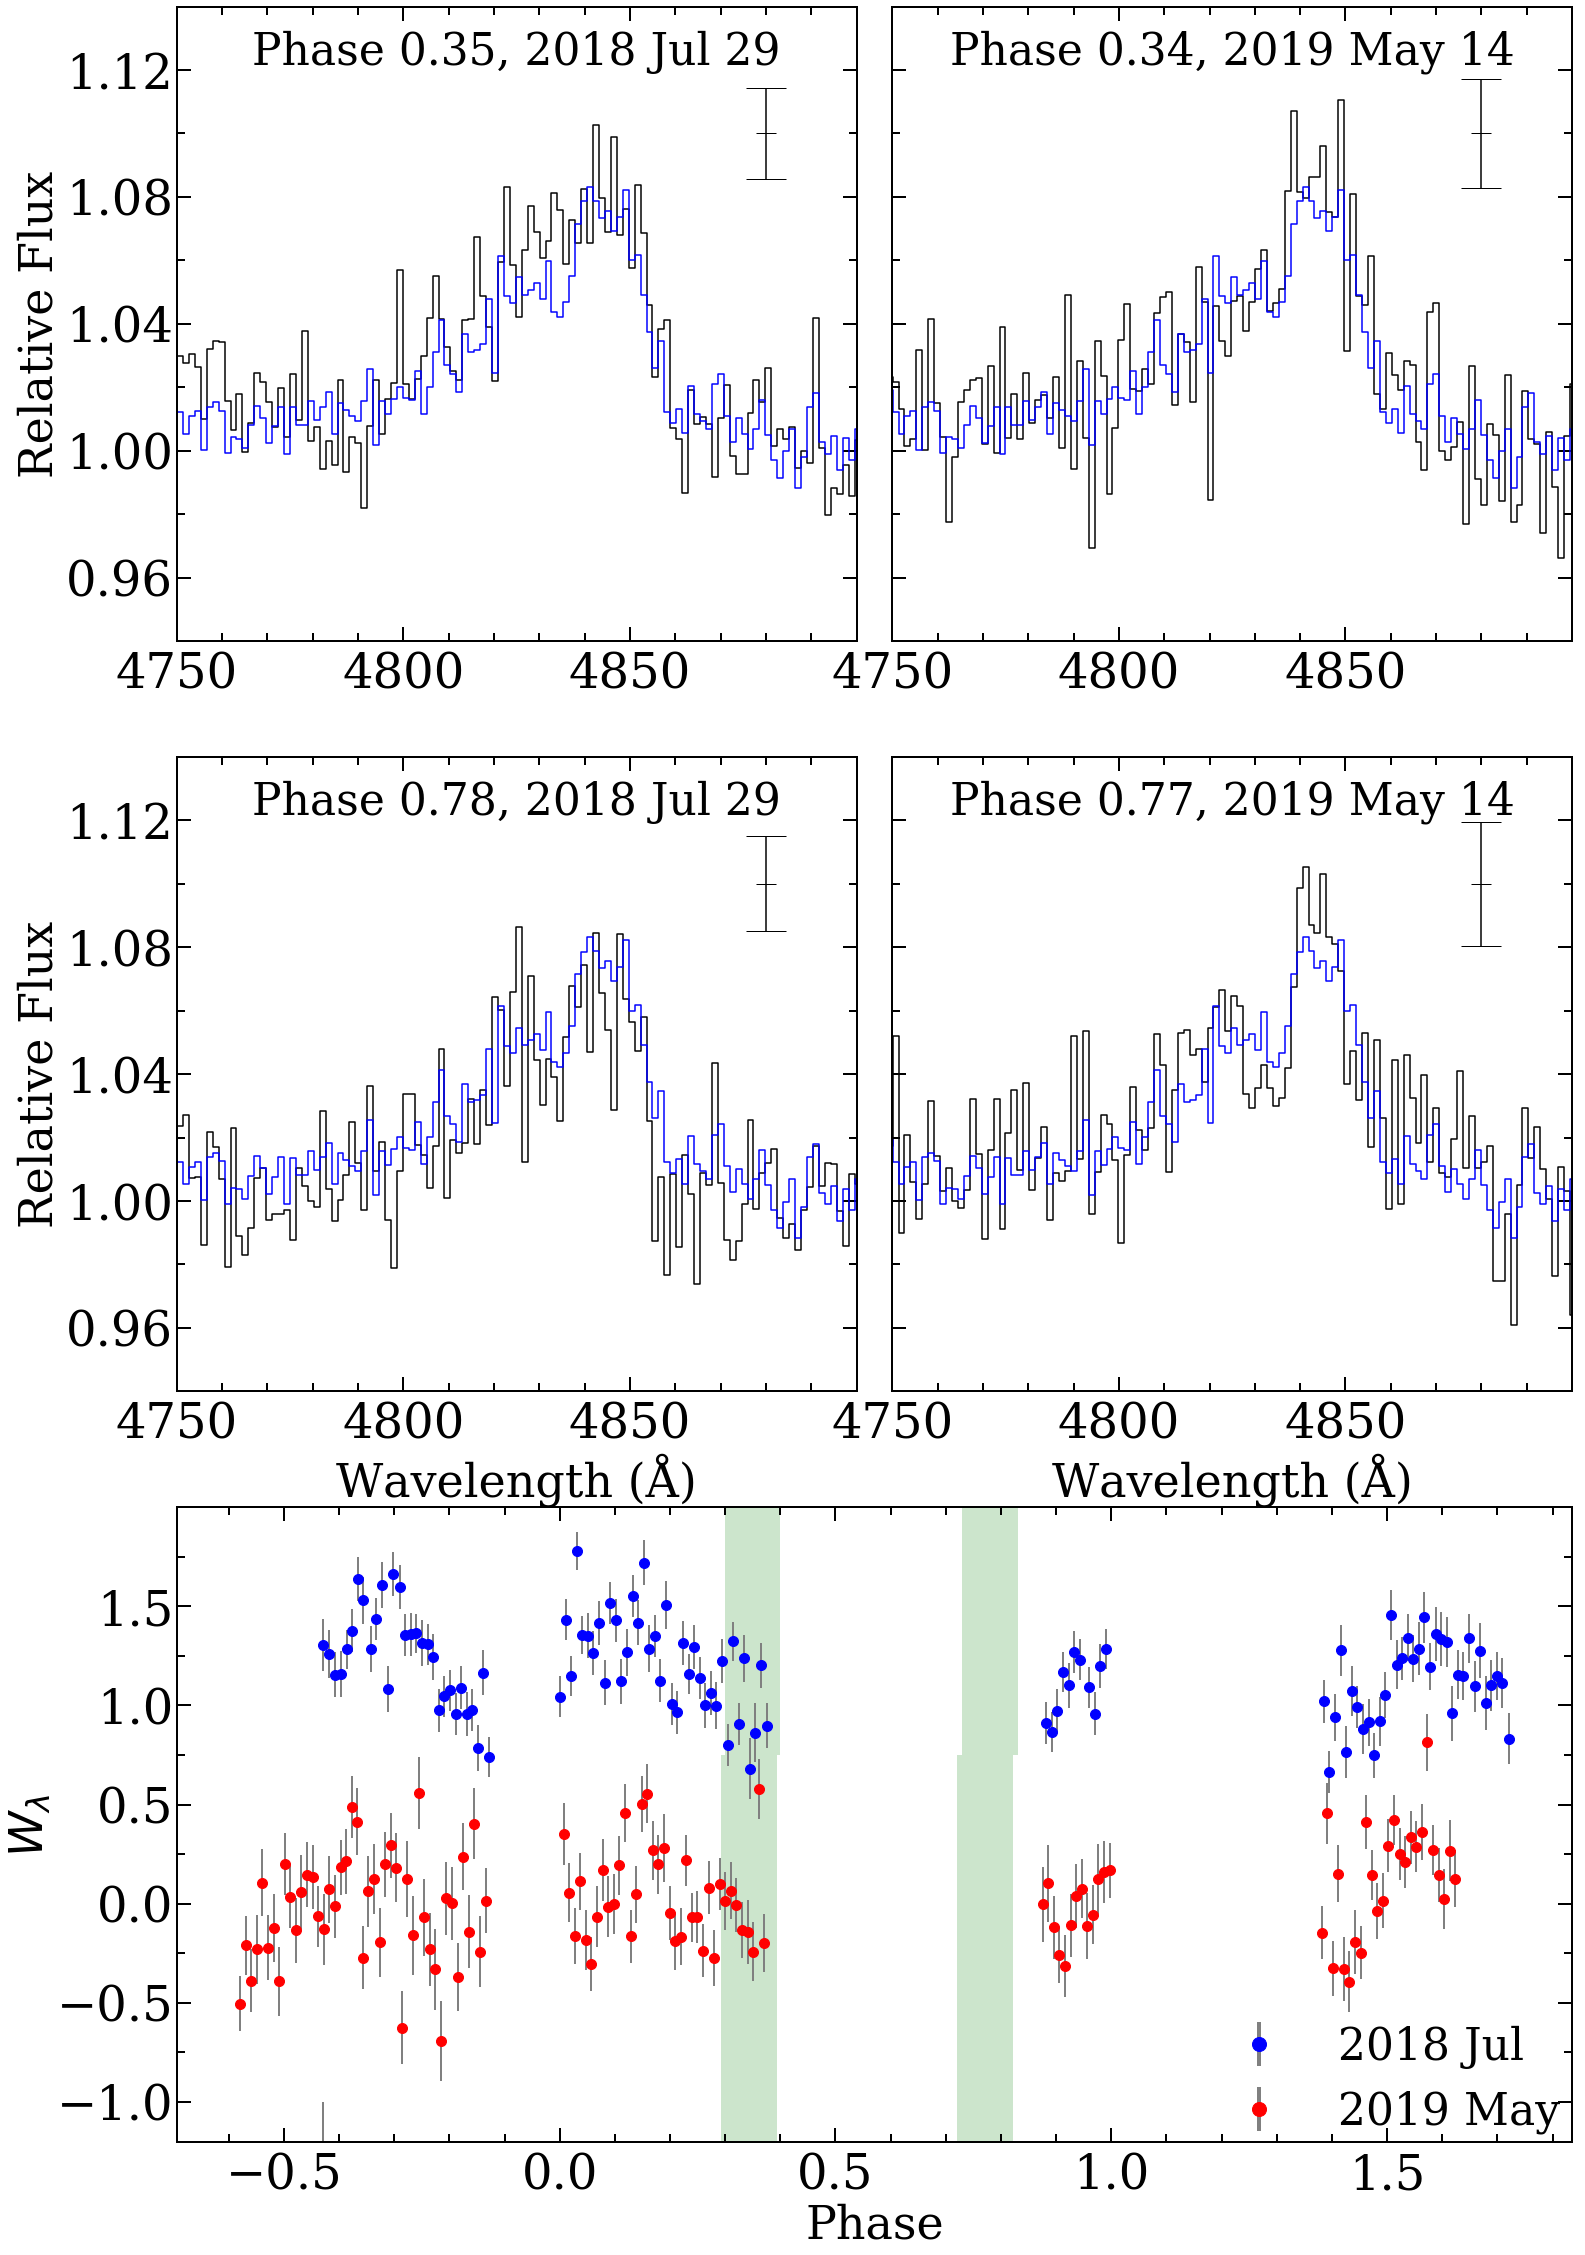

In [46]:
import matplotlib.patches as patches
BJEWs = np.load('EWs/BJEWs.npy')
BJEWsErr = np.load('EWs/BJEWsErr.npy')

BMEWs = np.load('EWs/BMEWs.npy')
BMEWsErr = np.load('EWs/BMEWsErr.npy')

RJEWs = np.load('EWs/RJEWs.npy')
RJEWsErr = np.load('EWs/RJEWsErr.npy')

RMEWs = np.load('EWs/RMEWs.npy')
RMEWsErr = np.load('EWs/RMEWsErr.npy')

fullWHTSTackTJ = np.append(timeBJ, timeRJ)
fullWHTSTackTM = np.append(timeBM, timeRM)


fullWHTSTackFJ = np.append(BJEWs, RJEWs)
fullWHTSTackFM = np.append(BMEWs, RMEWs)


fullWHTSTackEJ = np.append(BJEWsErr, RJEWsErr)
fullWHTSTackEM = np.append(BMEWsErr, RMEWsErr)

#plt.errorbar(timeBJ,BJEWs,yerr=BJEWsErr,  ls='',c='b')
#plt.errorbar(np.array(timeBM)-289.0630628543347, BMEWs-3, yerr=BMEWsErr,  ls='',c='r')

offsetAA = 1296.0455697684468 # 1296.0255697684468
timeBJAdj = np.array(timeBJ)-2457000 - offsetAA
WHTVelocityPhaseJ = foldMeth(timeBJAdj,  0.08029820145279275*2)
WHTVelocityPhaseJPart1 = 1-np.array(WHTVelocityPhaseJ[:30])
WHTVelocityPhaseJPart1 = -WHTVelocityPhaseJPart1
WHTVelocityPhaseJPart2 = WHTVelocityPhaseJ[30:79] 
WHTVelocityPhaseJPart3 = 1 + np.array(WHTVelocityPhaseJ[79:])
WHTVelocityPhaseJ = np.append(WHTVelocityPhaseJPart1,WHTVelocityPhaseJPart2)
WHTVelocityPhaseJ = np.append(WHTVelocityPhaseJ,WHTVelocityPhaseJPart3)


timeBMAdj = np.array(timeBM)-2457000 - offsetAA
timeBMAdj = np.concatenate((np.array([timeBJAdj[0]]),timeBMAdj))
WHTVelocityPhaseM = foldMeth(timeBMAdj,  0.08029820145279275*2)

WHTVelocityPhaseMPart1 = 1-np.array(WHTVelocityPhaseM[:46])
WHTVelocityPhaseMPart1 = -WHTVelocityPhaseMPart1
WHTVelocityPhaseMPart2 = WHTVelocityPhaseM[46:96]
WHTVelocityPhaseMPart3 = 1 + np.array(WHTVelocityPhaseM[96:])
WHTVelocityPhaseM = np.append(WHTVelocityPhaseMPart1,WHTVelocityPhaseMPart2)
WHTVelocityPhaseM = np.append(WHTVelocityPhaseM,WHTVelocityPhaseMPart3)
print(np.mean(WHTVelocityPhaseJ[44:49]))#0.34
samePhaseJ = np.load('samePhaseJ.npy')
samePhaseM = np.load('samePhaseM.npy')
samePhaseJE = np.load('samePhaseJE.npy')
samePhaseME = np.load('samePhaseME.npy')
#plt.errorbar(WHTVelocityPhaseJ,samePhaseJ,yerr=samePhaseJE,  ls='',c='b')
#plt.errorbar(WHTVelocityPhaseM, samePhaseM-1, yerr=samePhaseME,  ls='',c='r')
#plt.xlim(-1,2)


BJXpoints = np.linspace(3625, 5460, 4200)
BJXpoints = BJXpoints[1500:3900]
xpointss = BJXpoints[1000:1500]

    #RCor 1.4646344367729398
    #BCor 1.3110264348661076

# 
rc('axes', linewidth=2)
fig = plt.figure(figsize=(20,30))
datJul = specialStackB[4:-16]#fortrailJ[10][4:-16]#was 10
datJul = np.nanmean(np.pad(datJul.astype(float), (0, 3 - datJul.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
x = xpointss[74:431]
x = np.nanmean(np.pad(x.astype(float), (0, 3 - x.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
xss = (x[1]-x[0])/2
xs = [x[0]-xss]
ys = [0]
for i in range(len(x)):
    xs.append(x[i] - xss)
    xs.append(x[i] + xss)
    ys.append(datJul[i])
    ys.append(datJul[i])
xs.append(x[-1] + xss)
ys.append(0)



axs00 = plt.subplot2grid((3,2), (0,0))
axs00.set_title('Phase 0.35, 2018 Jul 29', fontsize=44,x=0.5, y=0.9)
fig.tight_layout(w_pad=2.5,h_pad=10)                            #######################################HEREEEEEEEEEEEEEEEEE
axs00.plot((np.array(xs)-3.496070492976287), ys, color='black')

#4,-16#############################axs[2, 0].plot(xs[1000:], ys[1000:], color='black')
#axs[0, 0].bar(x,datJul,width=1.4,color='white',edgecolor='black')#

stdest = np.std(np.concatenate([ys[1:65],ys[-65:-3]]))
axs00.errorbar([4880],[1.1],yerr=stdest,marker='_',ms=20,color='black',capsize=20)
axs00.set_xlim(4750, 4900)
axs00.set_ylim(0.94,1.14)


datMay = specialStack[10:-10]#fortrailJ[35][10:-10]#35 #26 was
datMay = np.nanmean(np.pad(datMay.astype(float), (0, 3 - datMay.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
ys = [0]
for i in range(len(x)):
    ys.append(datMay[i])
    ys.append(datMay[i])
ys.append(0)
axs01 = plt.subplot2grid((3,2), (0,1))
axs01.plot(np.array(xs)-3.496070492976287, ys, color='black')
axs01.set_title('Phase 0.34, 2019 May 14', fontsize=44,x=0.5, y=0.9)
axs01.set_xlim(4750, 4900)
axs01.set_ylim(0.94,1.14)
stdest = np.std(np.concatenate([ys[1:65],ys[-65:-3]]))
axs01.errorbar([4880],[1.1],yerr=stdest,marker='_',ms=20,color='black',capsize=20)
datJul = fortrailJ[13][4:-16] ####################
datJul = np.nanmean(np.pad(datJul.astype(float), (0, 3 - datJul.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
ys = [0]
for i in range(len(x)):
    ys.append(datJul[i])
    ys.append(datJul[i])
ys.append(0)
axs10 = plt.subplot2grid((3,2), (1,0))
axs10.plot(np.array(xs)-3.496070492976287, ys, color='black')
axs10.set_title('Phase 0.78, 2018 Jul 29', fontsize=44,x=0.5, y=0.9)
axs10.set_xlim(4750, 4900)
axs10.set_ylim(0.94,1.14)
stdest = np.std(np.concatenate([ys[1:65],ys[-65:-3]]))
axs10.errorbar([4880],[1.1],yerr=stdest,marker='_',ms=20,color='black',capsize=20)

datMay = specialStackM[10:-10]
datMay = np.nanmean(np.pad(datMay.astype(float), (0, 3 - datMay.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
ys = [0]
for i in range(len(x)):
    ys.append(datMay[i])
    ys.append(datMay[i])
ys.append(0)
axs11 = plt.subplot2grid((3,2), (1,1))
axs11.plot(np.array(xs)-3.496070492976287, ys, color='black')

axs11.set_title('Phase 0.77, 2019 May 14', fontsize=44,x=0.5, y=0.9)
axs11.set_xlim(4750, 4900)
axs11.set_ylim(0.94,1.14)
stdest = np.std(np.concatenate([ys[1:65],ys[-65:-3]]))
axs11.errorbar([4880],[1.1],yerr=stdest,marker='_',ms=20,color='black',capsize=20)
axs21 = plt.subplot2grid((3,2), (2,1))
axs21.plot(np.array(errorxpoints)-3.496070492976287, errorypoints, color='black')

#axs[2,1].plot(errorxpoints, errorypoints,'k-',linewidth=1)
axs21.plot([errorxpoints[0],errorxpoints[-2]],[onePer,onePer], 'r')
axs21.set_xlim(4750, 4900)

meansTot = np.zeros(len(fortrailJ[0][4:-16]))
for i in range(22):
    meansTot = meansTot+fortrailJ[i][4:-16]
for i in range(22,46):
    meansTot = meansTot+fortrailJ[i][10:-10]
meansTot = meansTot/46
meansTot = np.nanmean(np.pad(meansTot.astype(float), (0, 3 - meansTot.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
ys = [0]
for i in range(len(x)):
    ys.append(meansTot[i])
    ys.append(meansTot[i])
ys.append(0)


axs20 = plt.subplot2grid((3,2), (2,0),colspan=2)
axs20.errorbar(WHTVelocityPhaseJ,samePhaseJ,yerr=samePhaseJE,  ls='',c='b',lw=1, marker='o',ecolor='grey',ms=10,elinewidth=2)
axs20.errorbar(WHTVelocityPhaseM, np.concatenate((np.array([-2]),samePhaseM-1)), yerr=np.concatenate((np.array([1]),samePhaseME)),  ls='',c='r',lw=1, marker='o',ecolor='grey',ms=10,elinewidth=2)




xlimits = axs20.set_xlim()
axs20.errorbar([-1.2,-1.2], [0,0], yerr=[0.01,0.01],ms=14, c='b', lw=1, marker='o',ecolor='grey', ls = '', label='2018 Jul',elinewidth=4)
axs20.errorbar([-1.2,-1.2], [0,0], yerr=[0.01,0.01],ms=14, c='r', lw=1, marker='o',ecolor='grey', ls = '', label='2019 May',elinewidth=4)

rect = patches.Rectangle((0.30,0.75),0.10,1.5,facecolor='g',alpha=0.2)

# Add the patch to the Axes
axs20.add_patch(rect)
rect = patches.Rectangle((0.293,-1.25),0.101,2,facecolor='g',alpha=0.2)

# Add the patch to the Axes
axs20.add_patch(rect)
rect = patches.Rectangle((0.73,0.75),0.101,1.5,facecolor='g',alpha=0.2)
axs20.add_patch(rect)
rect = patches.Rectangle((0.72,-1.25),0.101,2,facecolor='g',alpha=0.2)
axs20.add_patch(rect)
axs20.set_xlim(xlimits)




axs20.legend(prop={'size': 44},loc='lower right',bbox_to_anchor=(0.02,-0.05,1,1),frameon=False)
axs00.plot(np.array(xs)-3.496070492976287, ys, color='b')
axs01.plot(np.array(xs)-3.496070492976287, ys, color='b')
axs10.plot(np.array(xs)-3.496070492976287, ys, color='b')
axs11.plot(np.array(xs)-3.496070492976287, ys, color='b')
tr1 = np.loadtxt("fromJohn/moreTr/2p0_4s0.dat", usecols=(0,1,2))
BFieldTra4 = tr1[:,0]
WavelTra4 = tr1[:,1]
tr1 = np.loadtxt("fromJohn/moreTr/2p1_4d1.dat", usecols=(0,1,2))
BFieldTra7 = tr1[:,0]
WavelTra7 = tr1[:,1]
#ax222 = axs[2,1].twinx()
#ax222.plot(WavelTra4[70:90],BFieldTra4[70:90])
#ax222.plot(WavelTra7[18:23],BFieldTra7[18:23])

#axs[2,0].plot(wavelength,intensity)



#axs[2,1].set_ylim(-0.01, 0.04)
axs00.set_ylabel('Relative Flux', fontsize=46)
axs10.set_ylabel('Relative Flux', fontsize=46)
axs20.set_ylabel(r'$W_\lambda$', fontsize=46)
for ax in [axs00,axs01,axs10,axs11,axs21]:

    
    
    #ax.set_xticks(np.arange(4770, 4930, 40))
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.yaxis.set_minor_locator(MultipleLocator(0.02))
    ax.tick_params(labelsize=48)
    
    ax.set_xticks(np.arange(4750, 4900, 50))
    #ax.xaxis.set_minor_locator(AutoMinorLocator())
    #ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='x',which='both', width=2,direction='in',pad=10)
    ax.tick_params(axis='y',which='both', width=2,direction='in')
    ax.tick_params(which='major', length=14)
    ax.tick_params(which='minor', length=8)
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
axs21.yaxis.set_major_locator(MultipleLocator(0.02))
axs21.yaxis.set_minor_locator(MultipleLocator(0.01))
axs20.tick_params(which='major', length=14)
axs20.tick_params(which='minor', length=8)
axs20.tick_params(labelsize=48)
axs20.xaxis.set_minor_locator(AutoMinorLocator())
axs20.yaxis.set_minor_locator(MultipleLocator(0.25))
axs20.xaxis.set_ticks_position('both')
axs20.yaxis.set_ticks_position('both')
axs20.tick_params(axis='x',which='both', width=2,direction='in',pad=10)
axs20.tick_params(axis='y',which='both', width=2,direction='in')
axs00.set_yticks(np.arange(0.96, 1.14, 0.04))
axs01.set_yticks(np.arange(0.96, 1.14, 0.04))
axs11.set_yticks(np.arange(0.96, 1.14, 0.04))
axs10.set_yticks(np.arange(0.96, 1.14, 0.04))
axs20.set_yticks(np.arange(-1, 2, 0.5))
axs20.set_xlabel(r"Phase", fontsize=46)
axs10.set_xlabel(r"Wavelength (Å)", fontsize=46)
axs11.set_xlabel(r"Wavelength (Å)", fontsize=46)
axs01.tick_params(axis='y',which='both',labelleft=False,labelright=False)
axs11.tick_params(axis='y',which='both',labelleft=False,labelright=False)
axs21.tick_params(axis='y',which='both',labelleft=False,labelright=True)
axs20.set_ylim(-1.2,2)
#axs00.set_xticklabels([])
#axs01.set_xticklabels([])
#axs10.set_xticklabels([])
#axs11.set_xticklabels([])
bboxx = transforms.Bbox([[-1.9, -1.2], [19.90, 29.9]])
#plt.savefig('Phase_Morph.pdf',bbox_inches=bboxx) 
#plt.savefig('outofphasemorphFinal.eps', bbox_inches='tight', pad_inches=0.75 ) 

In [47]:
WHTVelocityPhaseM

array([-0.42927631, -0.57933221, -0.56922121, -0.55911049, -0.54899949,
       -0.53888878, -0.52877864, -0.51866764, -0.50855693, -0.49844622,
       -0.48833493, -0.47822451, -0.46811264, -0.45800135, -0.44789064,
       -0.43777993, -0.42766893, -0.41755822, -0.40744751, -0.39733622,
       -0.3872255 , -0.37711508, -0.36700409, -0.35689337, -0.34678237,
       -0.33667224, -0.32656181, -0.31645081, -0.30633953, -0.29622853,
       -0.28611753, -0.27600682, -0.26589639, -0.25578539, -0.24567468,
       -0.23556426, -0.22545412, -0.21534342, -0.2052327 , -0.19512171,
       -0.18501042, -0.1749    , -0.164789  , -0.154678  , -0.144567  ,
       -0.13445629,  0.87565442,  0.88576485,  0.89587612,  0.90598684,
        0.91609755,  0.92620825,  0.93631925,  0.94643083,  0.95654125,
        0.96665196,  0.97676209,  0.9868728 ,  0.99698351,  0.00709422,
        0.01720522,  0.02731622,  0.03742634,  0.04753734,  0.05764747,
        0.06775789,  0.07786831,  0.08797902,  0.09808915,  0.10

0.031357970623908216


<ErrorbarContainer object of 3 artists>

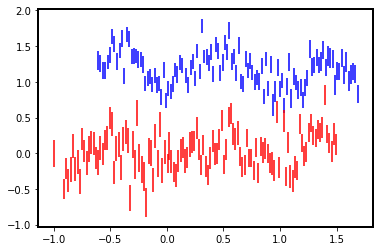

In [120]:
BJEWs = np.load('EWs/BJEWs.npy')
BJEWsErr = np.load('EWs/BJEWsErr.npy')

BMEWs = np.load('EWs/BMEWs.npy')
BMEWsErr = np.load('EWs/BMEWsErr.npy')

RJEWs = np.load('EWs/RJEWs.npy')
RJEWsErr = np.load('EWs/RJEWsErr.npy')

RMEWs = np.load('EWs/RMEWs.npy')
RMEWsErr = np.load('EWs/RMEWsErr.npy')

fullWHTSTackTJ = np.append(timeBJ, timeRJ)
fullWHTSTackTM = np.append(timeBM, timeRM)


fullWHTSTackFJ = np.append(BJEWs, RJEWs)
fullWHTSTackFM = np.append(BMEWs, RMEWs)


fullWHTSTackEJ = np.append(BJEWsErr, RJEWsErr)
fullWHTSTackEM = np.append(BMEWsErr, RMEWsErr)

#plt.errorbar(timeBJ,BJEWs,yerr=BJEWsErr,  ls='',c='b')
#plt.errorbar(np.array(timeBM)-289.0630628543347, BMEWs-3, yerr=BMEWsErr,  ls='',c='r')


timeBJAdj = np.array(timeBJ)-2457000 - 1296.0255697684468 -  (0.08029820145279275*415)
print(timeBJAdj[0])
WHTVelocityPhaseJ = foldMeth(timeBJAdj,  0.08029820145279275)
WHTVelocityPhaseJPart1 = 1-np.array(WHTVelocityPhaseJ[:30])
WHTVelocityPhaseJPart1 = -WHTVelocityPhaseJPart1
WHTVelocityPhaseJPart2 = WHTVelocityPhaseJ[30:79] 
WHTVelocityPhaseJPart3 = 1 + np.array(WHTVelocityPhaseJ[79:])
WHTVelocityPhaseJ = np.append(WHTVelocityPhaseJPart1,WHTVelocityPhaseJPart2)
WHTVelocityPhaseJ = np.append(WHTVelocityPhaseJ,WHTVelocityPhaseJPart3)


timeBMAdj = np.array(timeBM)-2457000 - 1296.0255697684468 -  (0.08029820145279275*4015)
WHTVelocityPhaseM = foldMeth(timeBMAdj,  0.08029820145279275)

WHTVelocityPhaseMPart1 = 1-np.array(WHTVelocityPhaseM[:46])
WHTVelocityPhaseMPart1 = -WHTVelocityPhaseMPart1
WHTVelocityPhaseMPart2 = WHTVelocityPhaseM[46:96]
WHTVelocityPhaseMPart3 = 1 + np.array(WHTVelocityPhaseM[96:])
WHTVelocityPhaseM = np.append(WHTVelocityPhaseMPart1,WHTVelocityPhaseMPart2)
WHTVelocityPhaseM = np.append(WHTVelocityPhaseM,WHTVelocityPhaseMPart3)

samePhaseJ = np.load('samePhaseJ.npy')
samePhaseM = np.load('samePhaseM.npy')
samePhaseJE = np.load('samePhaseJE.npy')
samePhaseME = np.load('samePhaseME.npy')
plt.errorbar(WHTVelocityPhaseJ,samePhaseJ,yerr=samePhaseJE,  ls='',c='b')
plt.errorbar(WHTVelocityPhaseM, samePhaseM-1, yerr=samePhaseME,  ls='',c='r')
#plt.xlim(-1,2)

In [115]:
WHTVelocityPhaseJ

array([-0.60948103, -0.58842395, -0.56648606, -0.54344467, -0.52322372,
       -0.50300335, -0.48278181, -0.46255912, -0.43561802, -0.41539764,
       -0.39517727, -0.37495689, -0.35473708, -0.33086837, -0.31064799,
       -0.29042818, -0.27020723, -0.24998339, -0.22976301, -0.2095386 ,
       -0.18931765, -0.1690673 , -0.14884577, -0.12862654, -0.10840559,
       -0.08818391, -0.06796195, -0.04747061, -0.02724792, -0.00702582,
        0.013213  ,  0.03343338,  0.05367841,  0.07389892,  0.09411699,
        0.1143368 ,  0.13455774,  0.16935476,  0.18957396,  0.20979492,
        0.23001586,  0.25023739,  0.2704572 ,  0.29067815,  0.31089736,
        0.33111773,  0.35133811,  0.3715579 ,  0.39177828,  0.41199923,
        0.43221902,  0.45244055,  0.47266034,  0.49288013,  0.51309994,
        0.5333203 ,  0.55354009,  0.57376048,  0.59398084,  0.61420006,
        0.63442043,  0.65464138,  0.6759664 ,  0.69618561,  0.71640656,
        0.73662693,  0.75684961,  0.7770694 ,  0.79729034,  0.81

D:\conda\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
D:\conda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
D:\conda\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
D:\conda\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
D:\conda\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
D:\conda\lib\site-packages\ipykernel_launcher.py:85: RuntimeWarning: Mean of empty slice


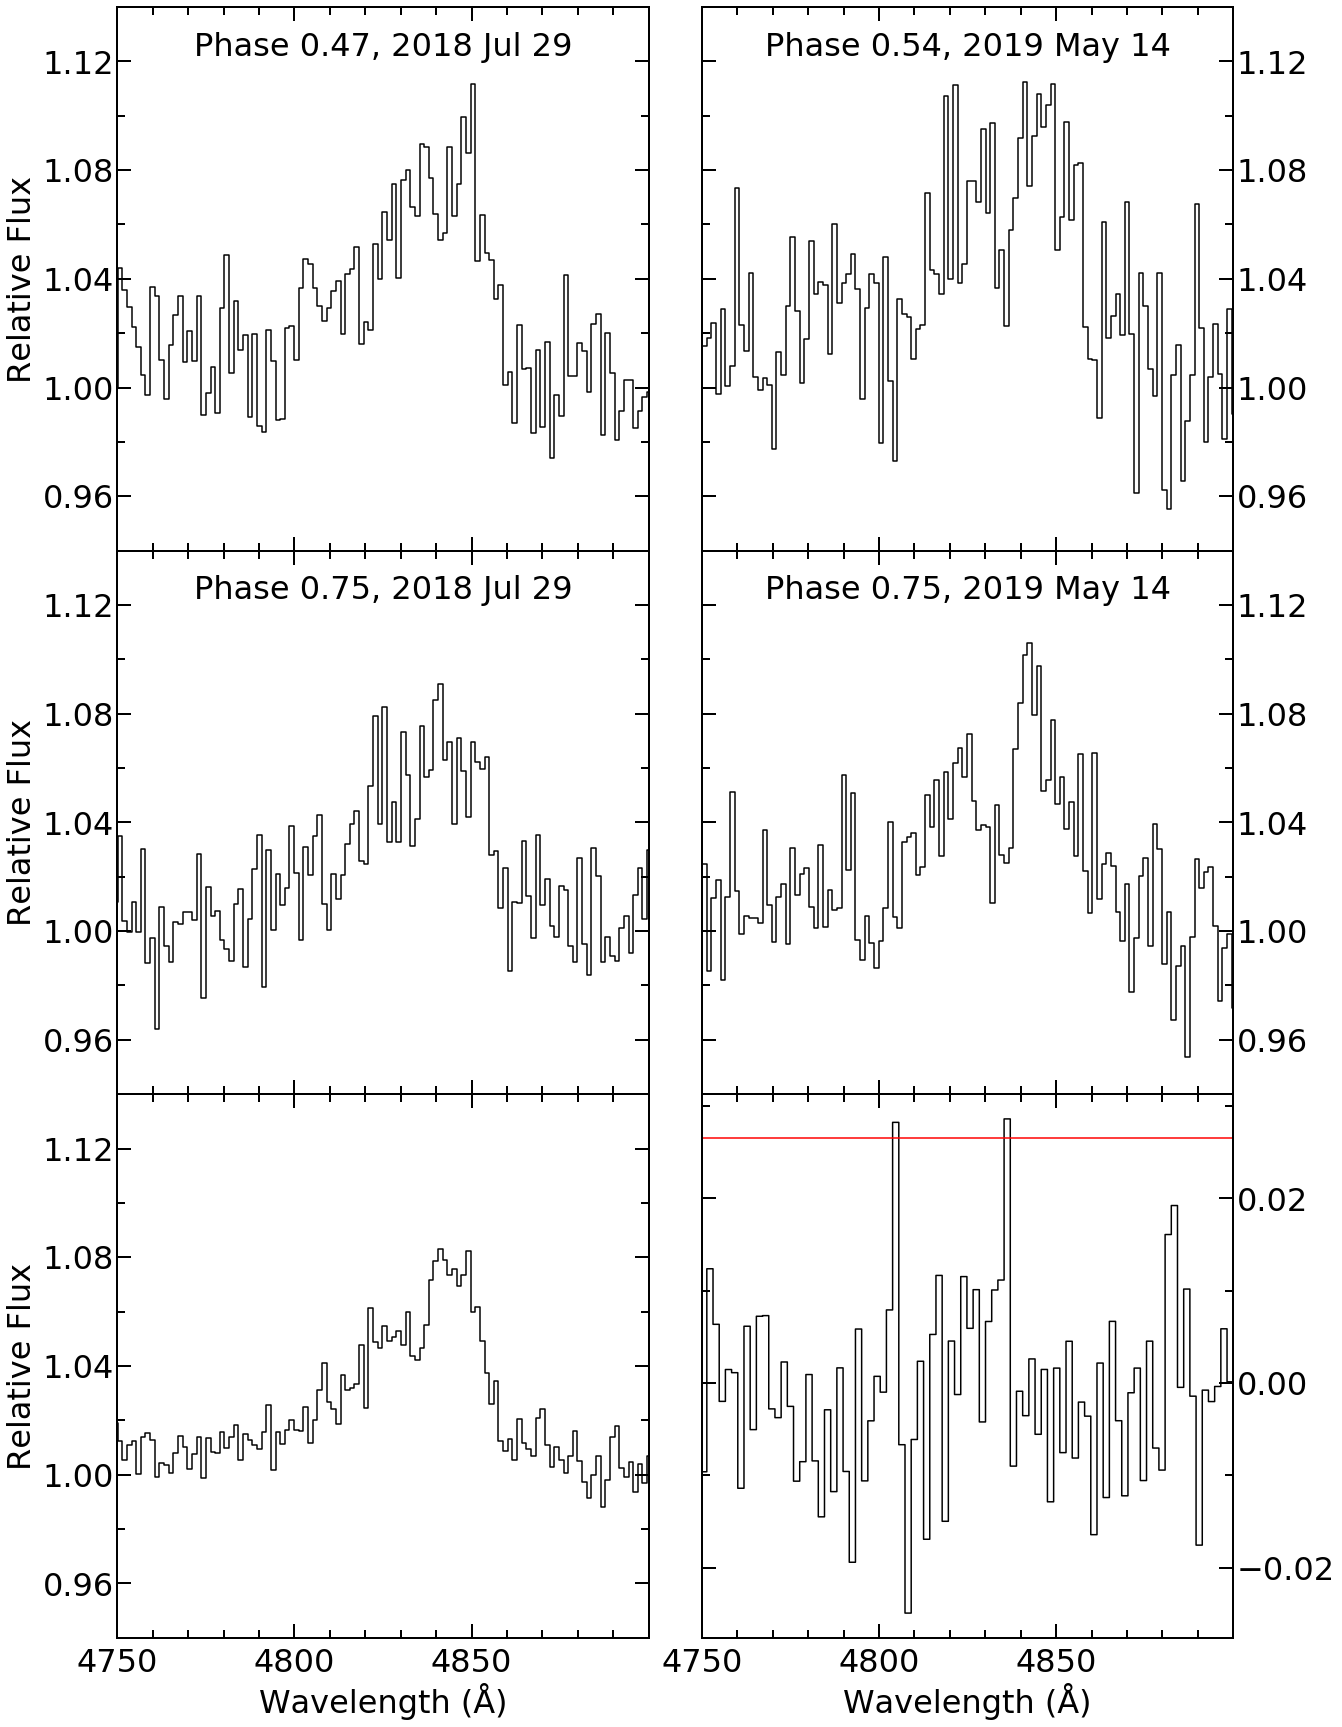

In [82]:



BJXpoints = np.linspace(3625, 5460, 4200)
BJXpoints = BJXpoints[1500:3900]
xpointss = BJXpoints[1000:1500]

    #RCor 1.4646344367729398
    #BCor 1.3110264348661076

# 
rc('axes', linewidth=2)
fig, axs = plt.subplots(3, 2,
                        gridspec_kw={'hspace': 0., 'wspace': 0.1}, figsize=(20,30))

datJul = fortrailJ[10][4:-16]
datJul = np.nanmean(np.pad(datJul.astype(float), (0, 3 - datJul.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
x = xpointss[74:431]
x = np.nanmean(np.pad(x.astype(float), (0, 3 - x.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
xss = (x[1]-x[0])/2
xs = [x[0]-xss]
ys = [0]
for i in range(len(x)):
    xs.append(x[i] - xss)
    xs.append(x[i] + xss)
    ys.append(datJul[i])
    ys.append(datJul[i])
xs.append(x[-1] + xss)
ys.append(0)
axs[0, 0].plot(np.array(xs)-3.496070492976287, ys, color='black')
#4,-16#############################axs[2, 0].plot(xs[1000:], ys[1000:], color='black')
#axs[0, 0].bar(x,datJul,width=1.4,color='white',edgecolor='black')
axs[0, 0].set_title('Phase 0.47, 2018 Jul 29', fontsize=32,x=0.5, y=0.9)
axs[0,0].set_xlim(4750, 4900)
axs[0,0].set_ylim(0.94,1.14)


datMay = fortrailJ[26][10:-10]
datMay = np.nanmean(np.pad(datMay.astype(float), (0, 3 - datMay.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
ys = [0]
for i in range(len(x)):
    ys.append(datMay[i])
    ys.append(datMay[i])
ys.append(0)
axs[0, 1].plot(np.array(xs)-3.496070492976287, ys, color='black')
axs[0, 1].set_title('Phase 0.54, 2019 May 14', fontsize=32,x=0.5, y=0.9)
axs[0,1].set_xlim(4750, 4900)
axs[0,1].set_ylim(0.94,1.14)

datJul = fortrailJ[3][4:-16]
datJul = np.nanmean(np.pad(datJul.astype(float), (0, 3 - datJul.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
ys = [0]
for i in range(len(x)):
    ys.append(datJul[i])
    ys.append(datJul[i])
ys.append(0)
axs[1, 0].plot(np.array(xs)-3.496070492976287, ys, color='black')
axs[1, 0].set_title('Phase 0.75, 2018 Jul 29', fontsize=32,x=0.5, y=0.9)
axs[1,0].set_xlim(4750, 4900)
axs[1,0].set_ylim(0.94,1.14)


datMay = fortrailJ[38][10:-10]
datMay = np.nanmean(np.pad(datMay.astype(float), (0, 3 - datMay.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
ys = [0]
for i in range(len(x)):
    ys.append(datMay[i])
    ys.append(datMay[i])
ys.append(0)
axs[1, 1].plot(np.array(xs)-3.496070492976287, ys, color='black')

axs[1, 1].set_title('Phase 0.75, 2019 May 14', fontsize=32,x=0.5, y=0.9)
axs[1,1].set_xlim(4750, 4900)
axs[1,1].set_ylim(0.94,1.14)


axs[2, 1].plot(np.array(errorxpoints)-3.496070492976287, errorypoints, color='black')

#axs[2,1].plot(errorxpoints, errorypoints,'k-',linewidth=1)
axs[2,1].plot([errorxpoints[0],errorxpoints[-2]],[onePer,onePer], 'r')
axs[2,1].set_xlim(4750, 4900)
meansTot = np.zeros(len(fortrailJ[0][4:-16]))
for i in range(22):
    meansTot = meansTot+fortrailJ[i][4:-16]
for i in range(22,46):
    meansTot = meansTot+fortrailJ[i][10:-10]
meansTot = meansTot/46
meansTot = np.nanmean(np.pad(meansTot.astype(float), (0, 3 - meansTot.size%3), mode='constant', constant_values=np.NaN).reshape(-1, 3), axis=1)
ys = [0]
for i in range(len(x)):
    ys.append(meansTot[i])
    ys.append(meansTot[i])
ys.append(0)

axs[2, 0].plot(np.array(xs)-3.496070492976287, ys, color='black')
tr1 = np.loadtxt("fromJohn/moreTr/2p0_4s0.dat", usecols=(0,1,2))
BFieldTra4 = tr1[:,0]
WavelTra4 = tr1[:,1]
tr1 = np.loadtxt("fromJohn/moreTr/2p1_4d1.dat", usecols=(0,1,2))
BFieldTra7 = tr1[:,0]
WavelTra7 = tr1[:,1]
#ax222 = axs[2,1].twinx()
#ax222.plot(WavelTra4[70:90],BFieldTra4[70:90])
#ax222.plot(WavelTra7[18:23],BFieldTra7[18:23])

#axs[2,0].plot(wavelength,intensity)


axs[2,0].set_ylim(0.94,1.14)
axs[2,0].set_xlim(4750, 4900)
#axs[2,1].set_ylim(-0.01, 0.04)
axs[0,0].set_ylabel('Relative Flux', fontsize=32)
axs[1,0].set_ylabel('Relative Flux', fontsize=32)
axs[2,0].set_ylabel('Relative Flux', fontsize=32)
for ax in axs.flat:

    
    
    #ax.set_xticks(np.arange(4770, 4930, 40))
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.yaxis.set_minor_locator(MultipleLocator(0.02))
    ax.tick_params(labelsize=32)
    
    ax.set_xticks(np.arange(4750, 4900, 50))
    #ax.xaxis.set_minor_locator(AutoMinorLocator())
    #ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='x',which='both', width=2,direction='in',pad=10)
    ax.tick_params(axis='y',which='both', width=2,direction='in')
    ax.tick_params(which='major', length=14)
    ax.tick_params(which='minor', length=8)
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
axs[2,1].yaxis.set_major_locator(MultipleLocator(0.02))
axs[2,1].yaxis.set_minor_locator(MultipleLocator(0.01))


axs[0,0].set_yticks(np.arange(0.96, 1.14, 0.04))
axs[0,1].set_yticks(np.arange(0.96, 1.14, 0.04))
axs[1,1].set_yticks(np.arange(0.96, 1.14, 0.04))
axs[1,0].set_yticks(np.arange(0.96, 1.14, 0.04))
axs[2,0].set_yticks(np.arange(0.96, 1.14, 0.04))
axs[2,0].set_xlabel(r"Wavelength (Å)", fontsize=32)
axs[2,1].set_xlabel(r"Wavelength (Å)", fontsize=32)
axs[0,1].tick_params(axis='y',which='both',labelleft=False,labelright=True)
axs[1,1].tick_params(axis='y',which='both',labelleft=False,labelright=True)
axs[2,1].tick_params(axis='y',which='both',labelleft=False,labelright=True)

axs[0,0].set_xticklabels([])
axs[0,1].set_xticklabels([])
axs[1,0].set_xticklabels([])
axs[1,1].set_xticklabels([])
bboxx = transforms.Bbox([[0.95, 2.6], [19.4, 26.44]])
#plt.savefig('outofphasemorphFinalCr.pdf',bbox_inches=bboxx) 
#plt.savefig('outofphasemorphFinal.eps', bbox_inches='tight', pad_inches=0.75 ) 

In [137]:
np.shape(fortrailJ)
#foldMeth(np.array(averageTimeJ)-2457000- 1296.0255697684468,0.08029820145279275)[10]#10 -> 0.4726599917239728
#foldMeth(np.array(averageTimeJ)-2457000- 1296.0255697684468,0.08029820145279275)[26]#10 -> 0.53528472659713
#foldMeth(np.array(averageTimeJ)-2457000- 1296.0255697684468,0.08029820145279275)[3]#3 -> 0.7500159140934395
foldMeth(np.array(averageTimeJ)-2457000- 1296.0255697684468,0.08029820145279275)[38]#38 -> 0.7485658086549668

0.7485658086549668

In [26]:
1/0.08029870250017346

12.453501350135014

In [3]:
dataLT = pd.read_csv('LT/1/Optimal.xls', delimiter='\t')
timeLT = dataLT['BJD_TDB']
revFluxLT = dataLT['rel_flux_T1']
revFluxLT = (revFluxLT/np.mean(revFluxLT))-1
#revFluxLT = revFluxLT - 0.0084463718*np.sin(2*np.pi*(12.4525844*(timeLT-2457000)-0.141339))
dat = np.array([timeLT,revFluxLT])

dat = dat.T

np.savetxt('bestPeriod/LT1.dat', dat, delimiter = '\t')
phasesLT = foldMeth(timeLT,0.08029870250017346)
sortIndi = np.argsort(phasesLT)
phasesLTs = phasesLT[sortIndi]
revFluxLTs = revFluxLT[sortIndi]
dataLT = pd.read_csv('LT/1/Optimal.xls', delimiter='\t')
timeLT = dataLT['BJD_TDB']
revFluxLT = dataLT['rel_flux_T1']
revFluxLT = (revFluxLT/np.mean(revFluxLT))-1

timeLTMean = np.nanmean(np.pad(timeLT.astype(float), (0, 10 - timeLT.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
fluxLTMean = np.nanmean(np.pad(revFluxLT.astype(float), (0, 10 - revFluxLT.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
phasesLTMean = foldMeth(timeLTMean,0.08029870250017346)
sortIndi = np.argsort(phasesLTMean)
phasesLTMean = phasesLTMean[sortIndi]
fluxLTMean = fluxLTMean[sortIndi]


dataLT2 = pd.read_csv('LT/2/Optimal.xls', delimiter='\t')
timeLT2 = dataLT2['BJD_TDB']
revFluxLT2 = dataLT2['rel_flux_T1']
revFluxLT2 = (revFluxLT2/np.mean(revFluxLT2))-1


timeLTMean2 = np.nanmean(np.pad(timeLT2.astype(float), (0, 10 - timeLT2.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
fluxLTMean2 = np.nanmean(np.pad(revFluxLT2.astype(float), (0, 10 - revFluxLT2.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
phasesLTMean2 = foldMeth(timeLTMean2,0.08029870250017346)
sortIndi = np.argsort(phasesLTMean2)
phasesLTMean2 = phasesLTMean2[sortIndi]
fluxLTMean2 = fluxLTMean2[sortIndi]
#revFluxLT2 = revFluxLT2 - 0.0084463718*np.sin(2*np.pi*(12.4525844*(timeLT2-2457000)-0.141339))
dat = np.array([timeLT2,revFluxLT2])

dat = dat.T

np.savetxt('bestPeriod/LT2.dat', dat, delimiter = '\t')



dataLT3 = pd.read_csv('LT/3/Optimal.xls', delimiter='\t')
timeLT3 = dataLT3['JD_UTC']
revFluxLT3 = dataLT3['rel_flux_T1']
revFluxLT3 = (revFluxLT3/np.mean(revFluxLT3))-1
timeLTMean3 = np.nanmean(np.pad(timeLT3.astype(float), (0, 10 - timeLT3.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
fluxLTMean3 = np.nanmean(np.pad(revFluxLT3.astype(float), (0, 10 - revFluxLT3.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
phasesLTMean3 = foldMeth(timeLTMean3,0.08029870250017346)
sortIndi = np.argsort(phasesLTMean3)
phasesLTMean3 = phasesLTMean3[sortIndi]
fluxLTMean3 = fluxLTMean3[sortIndi]
#revFluxLT3 = revFluxLT3 - 0.0084463718*np.sin(2*np.pi*(12.4525844*(timeLT3-2457000)-0.141339))
dat = np.array([timeLT3,revFluxLT3])

dat = dat.T

np.savetxt('bestPeriod/LT3.dat', dat, delimiter = '\t')



dataLT4 = pd.read_csv('LT/4/Optimal.xls', delimiter='\t')
timeLT4 = dataLT4['JD_UTC']
revFluxLT4 = dataLT4['rel_flux_T1']
revFluxLT4 = (revFluxLT4/np.mean(revFluxLT4))-1
timeLTMean4 = np.nanmean(np.pad(timeLT4.astype(float), (0, 10 - timeLT4.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
fluxLTMean4 = np.nanmean(np.pad(revFluxLT4.astype(float), (0, 10 - revFluxLT4.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
phasesLTMean4 = foldMeth(timeLTMean4,0.08029870250017346)
sortIndi = np.argsort(phasesLTMean4)
phasesLTMean4 = phasesLTMean4[sortIndi]
fluxLTMean4 = fluxLTMean4[sortIndi]

dat = np.array([timeLT4,revFluxLT4])

dat = dat.T

np.savetxt('bestPeriod/LT4.dat', dat, delimiter = '\t')


dataLT5 = pd.read_csv('LT/5/Optimal.xls', delimiter='\t')
timeLT5 = dataLT5['JD_UTC']
revFluxLT5 = dataLT5['rel_flux_T1']
revFluxLT5 = (revFluxLT5/np.mean(revFluxLT5))-1
timeLTMean5 = np.nanmean(np.pad(timeLT5.astype(float), (0, 10 - timeLT5.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
fluxLTMean5 = np.nanmean(np.pad(revFluxLT5.astype(float), (0, 10 - revFluxLT5.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
phasesLTMean5 = foldMeth(timeLTMean5,0.08029870250017346)
sortIndi = np.argsort(phasesLTMean5)
phasesLTMean5 = phasesLTMean5[sortIndi]
fluxLTMean5 = fluxLTMean5[sortIndi]
#revFluxLT5 = revFluxLT5 - 0.0084463718*np.sin(2*np.pi*(12.4525844*(timeLT5-2457000)-0.141339))
dat = np.array([timeLT5,revFluxLT5])

dat = dat.T

np.savetxt('bestPeriod/LT5.dat', dat, delimiter = '\t')


dataLT6 = pd.read_csv('LT/6/Optimal.xls', delimiter='\t')
timeLT6 = dataLT6['JD_UTC']
revFluxLT6 = dataLT6['rel_flux_T1']
revFluxLT6 = (revFluxLT6/np.mean(revFluxLT6))-1
timeLTMean6 = np.nanmean(np.pad(timeLT6.astype(float), (0, 10 - timeLT6.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
fluxLTMean6 = np.nanmean(np.pad(revFluxLT6.astype(float), (0, 10 - revFluxLT6.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
phasesLTMean6 = foldMeth(timeLTMean6,0.08029870250017346)
sortIndi = np.argsort(phasesLTMean6)
phasesLTMean6 = phasesLTMean6[sortIndi]
fluxLTMean6 = fluxLTMean6[sortIndi]
#revFluxLT6 = revFluxLT6 - 0.0084463718*np.sin(2*np.pi*(12.4525844*(timeLT6-2457000)-0.141339))
dat = np.array([timeLT6,revFluxLT6])

dat = dat.T

np.savetxt('bestPeriod/LT6.dat', dat, delimiter = '\t')


dataLT7 = pd.read_csv('LT/7/Optimal.xls', delimiter='\t')
timeLT7 = dataLT7['JD_UTC']
revFluxLT7 = dataLT7['rel_flux_T1']
revFluxLT7 = (revFluxLT7/np.mean(revFluxLT7))-1
timeLTMean7 = np.nanmean(np.pad(timeLT7.astype(float), (0, 10 - timeLT7.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
fluxLTMean7 = np.nanmean(np.pad(revFluxLT7.astype(float), (0, 10 - revFluxLT7.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
phasesLTMean7 = foldMeth(timeLTMean7,0.08029870250017346)
sortIndi = np.argsort(phasesLTMean7)
phasesLTMean7 = phasesLTMean7[sortIndi]
fluxLTMean7 = fluxLTMean7[sortIndi]
#revFluxLT7 = revFluxLT7 - 0.0084463718*np.sin(2*np.pi*(12.4525844*(timeLT7-2457000)-0.141339))
dat = np.array([timeLT7,revFluxLT7])



dat = dat.T

np.savetxt('bestPeriod/LT7.dat', dat, delimiter = '\t')
#2459076.6992445
names = ['Time', 'Flux']
JJDF = pd.read_csv('gd356-PTO-2020-08-15.dat', delim_whitespace=True,names=names)
JJFlux = JJDF['Flux'].to_numpy()
JJTimes = (JJDF['Time'].to_numpy()/60/60/24)+2459076.6992445
print(JJDF)

JJPhases = foldMeth(JJTimes,0.08029870250017346)



#2459076.6992445
JJDF = pd.read_csv('PTO/1/100.xls', delimiter='\t')
JJTimes = JJDF['J.D.-2400000']
JJFlux = JJDF['rel_flux_T1']
JJFlux = (JJFlux/np.mean(JJFlux))-1


JJPhases = foldMeth(JJTimes,0.08029870250017346)


timeStack = np.vstack((timeLT,timeLT2))
timeStack = np.vstack((timeStack,timeLT3))
#timeStack = np.vstack((timeStack,timeLT4))
timeStack = np.vstack((timeStack,timeLT5))
timeStack = np.vstack((timeStack,timeLT6))
timeStack = np.vstack((timeStack,timeLT7))
fluxStack = np.vstack((revFluxLT,revFluxLT2))
fluxStack = np.vstack((fluxStack, revFluxLT3))
#fluxStack = np.vstack((fluxStack, revFluxLT4))
fluxStack = np.vstack((fluxStack, revFluxLT5))
fluxStack = np.vstack((fluxStack, revFluxLT6))
fluxStack = np.vstack((fluxStack, revFluxLT7))
timeAll = np.append(timeLT,timeLT2)
timeAll = np.append(timeAll,timeLT3)
timeAll = np.append(timeAll,timeLT5)
timeAll = np.append(timeAll,timeLT6)
timeAll = np.append(timeAll,timeLT7)
fluxAll = np.append(revFluxLT,revFluxLT2)
fluxAll = np.append(fluxAll,revFluxLT3)
fluxAll = np.append(fluxAll,revFluxLT5)
fluxAll = np.append(fluxAll,revFluxLT6)
fluxAll = np.append(fluxAll,revFluxLT7)


dat = np.array([JJTimes,JJFlux])

dat = dat.T

np.savetxt('bestPeriod/JJDataPer.dat', dat, delimiter = '\t')




dataWHT1 = pd.read_csv('MeasurementsPA90.xls', delimiter='\t')
timeWHT1 = dataWHT1['BJD_TDB']
revFluxWHT1 = dataWHT1['rel_flux_T1']
revFluxWHT1 = (revFluxWHT1/0.169465)-1
timeWHT1Mean = np.nanmean(np.pad(timeWHT1.astype(float), (0, 10 - timeWHT1.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
revFluxWHT1Mean = np.nanmean(np.pad(revFluxWHT1.astype(float), (0, 10 - revFluxWHT1.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
phasesWHT1Mean = foldMeth(timeWHT1Mean,0.08029870250017346)
sortIndi = np.argsort(phasesWHT1Mean)
phasesWHT1Mean = phasesWHT1Mean[sortIndi]
revFluxWHT1Mean = revFluxWHT1Mean[sortIndi]


          Time     Flux
0        3.000  0.02188
1       17.830  0.01427
2       47.789  0.02092
3       62.778  0.01556
4       77.768  0.01304
..         ...      ...
778  11725.459  0.00528
779  11740.449  0.01859
780  11755.458  0.01288
781  11770.458  0.01119
782  11785.447  0.00117

[783 rows x 2 columns]


691


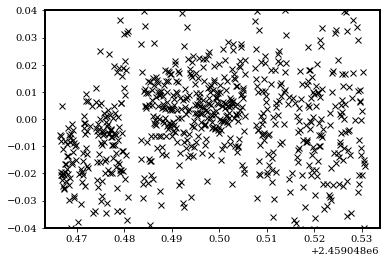

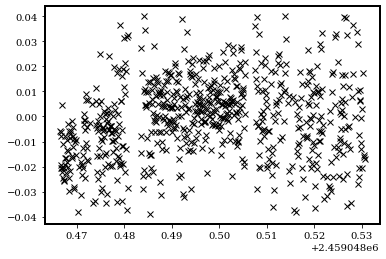

In [22]:
plt.plot(timeLT4,revFluxLT4, 'kx')
plt.ylim(-0.04,0.04)
revFluxLT4Up = []
timeLT4Up = []
for count,el in enumerate(revFluxLT4):
    if np.abs(el) < 0.04:
        revFluxLT4Up.append(el)
        timeLT4Up.append(timeLT4[count])    
dat = np.array([np.array(timeLT4Up)-2457000,revFluxLT4Up])
print(len(revFluxLT4Up))
dat = dat.T

np.savetxt('LT4Up.dat', dat, delimiter = '\t')

plt.show()
plt.plot(timeLT4Up, revFluxLT4Up, 'kx')

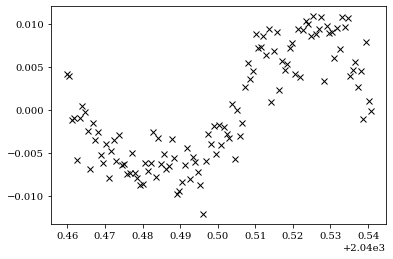

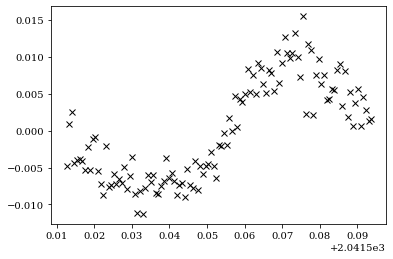

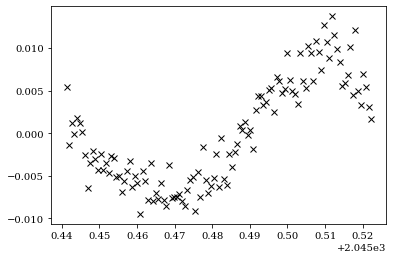

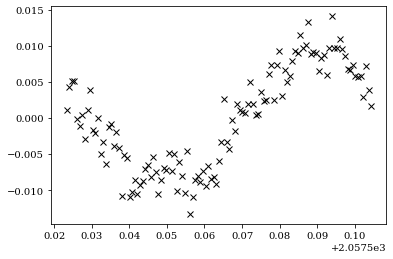

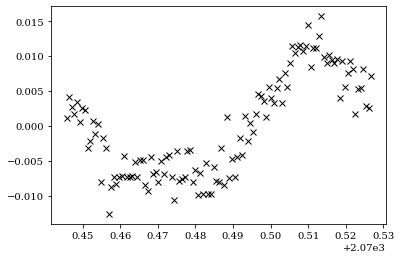

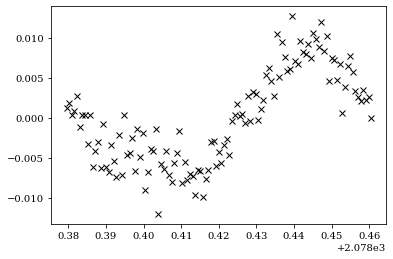

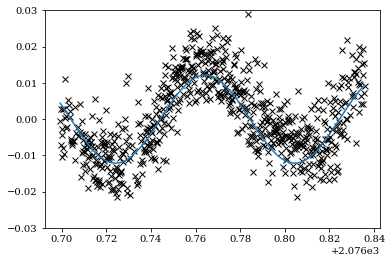

In [4]:
plt.plot(timeLTMean-2457000, fluxLTMean,'kx')
plt.show()
plt.plot(timeLTMean2-2457000, fluxLTMean2,'kx')
plt.show()
plt.plot(timeLTMean3-2457000, fluxLTMean3,'kx')
plt.show()
plt.plot(timeLTMean5-2457000, fluxLTMean5,'kx')
plt.show()
plt.plot(timeLTMean6-2457000, fluxLTMean6,'kx')
plt.show()
plt.plot(timeLTMean7-2457000, fluxLTMean7,'kx')
plt.show()


plt.plot(JJTimes-2457000, JJFlux,'kx')
plt.plot(JJTimes-2457000, 0.0121582569 *np.sin((JJTimes-2457000)*(2*np.pi/0.08029867)+0.252581*(2*np.pi) ))
plt.ylim(-0.03,0.03)
plt.show()

#plt.plot(timeWHT1-2457000,revFluxWHT1)

In [9]:
1/0.08029867

12.453506390579072

In [7]:
0.004976683391*(2*np.pi)

0.031269423960815876

In [16]:
2*np.pi*0.249905 #amp = 0.00823008657\pm0.0003175349263 phase = 1.5701994241907145\pm0.006140549395*2pi
2*np.pi*0.286529#amp = 0.00875121247\pm0.0002779852815  phase=1.8003148028808595\pm0.005055611643
2*np.pi*0.232304#amp = 0.00807037159\pm0.0002604243757   phase=1.4596090795990466\pm0.005135801521
print(2*np.pi*0.222924)#amp = 0.00837149957\pm0.0007972269910    phase=1.4006728014177021\pm0.01515649799
2*np.pi*0.235174#amp = 0.009282646\pm0.0002784349530    phase=1.38223165254113\pm0.004773886575
2*np.pi*0.233932#amp=0.00924552245\pm0.0002903258090 phase=1.469838105279135\pm0.004997747600
2*np.pi*0.237778#amp =0.00743770724\pm0.0002647410715   phase = 1.4940032359705475\pm0.005665032084

1.4006728014177021


1.4940032359705475

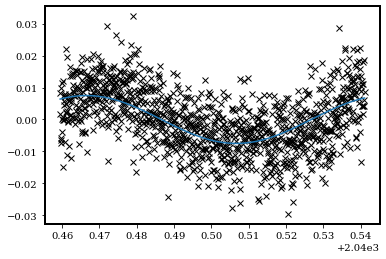

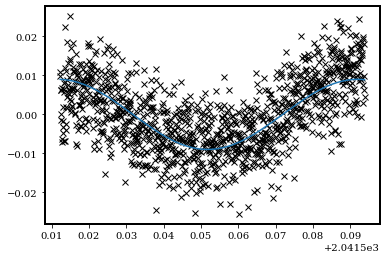

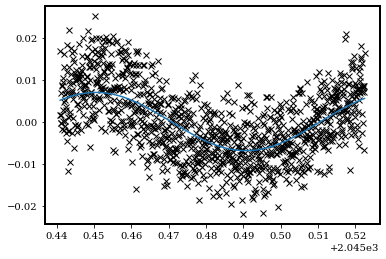

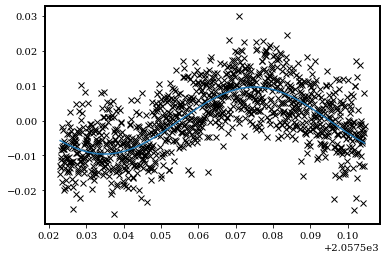

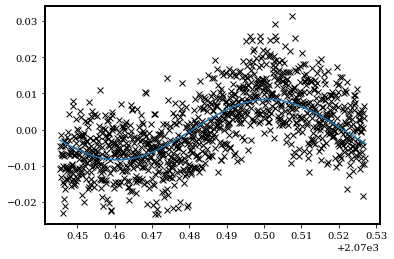

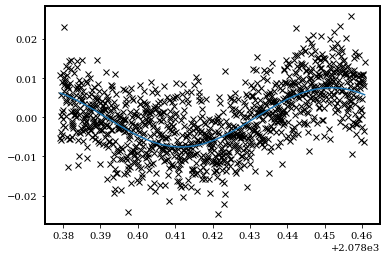

NameError: name 'JJStd' is not defined

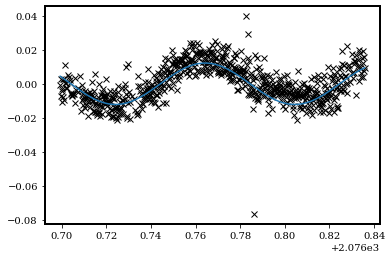

In [24]:
plt.plot(timeLT-2457000, revFluxLT,'kx')
plt.plot(timeLT-2457000, 0.007504504504504504*np.sin((timeLT-2457000)*(2*np.pi/0.08029867)+1.8050792624229641))
plt.show()

plt.plot(timeLT2-2457000, revFluxLT2,'kx')
plt.plot(timeLT2-2457000, 0.008987987987987986*np.sin((timeLT2-2457000)*(2*np.pi/0.08029867)+1.7044476659115793))
plt.show()
plt.plot(timeLT3-2457000, revFluxLT3,'kx')
plt.plot(timeLT3-2457000, 0.006933933933933933*np.sin((timeLT3-2457000)*(2*np.pi/0.08029867)+1.3773949772495788))
plt.show()
plt.plot(timeLT5-2457000, revFluxLT5,'kx')
plt.plot(timeLT5-2457000, 0.009615615615615615*np.sin((timeLT5-2457000)*(2*np.pi/0.08029867)+1.4214213007233096))
plt.show()
plt.plot(timeLT6-2457000, revFluxLT6,'kx')
plt.plot(timeLT6-2457000, 0.00836036036036036*np.sin((timeLT6-2457000)*(2*np.pi/0.08029867)+1.5912371198362716))
plt.show()
plt.plot(timeLT7-2457000, revFluxLT7,'kx')
plt.plot(timeLT7-2457000, 0.007573934837092732*np.sin((timeLT7-2457000)*(2*np.pi/0.08029867)+1.4959965017094252))
plt.show()


plt.plot(JJTimes-2457000, JJFlux,'kx')
plt.plot(JJTimes-2457000, 0.0121582569 *np.sin((JJTimes-2457000)*(2*np.pi/0.08029867)+0.252581*(2*np.pi) ))
#JJStd = (0.0127874261 *np.sin((JJTimes-2457000)*(2*np.pi/0.08029867)+0.252485*(2*np.pi) ))-JJFlux
#JJStd = np.std(JJFlux)
JJErr = np.sqrt(2/len(JJFlux))*(JJStd/0.0127874261)
#print(JJErr)
plt.show()



LTPhases = np.array([1.8050792624229641,1.7044476659115793,1.3773949772495788,1.4214213007233096,1.5912371198362716,1.4959965017094252])
LTPhases = 0.08029870*24*60*(np.array(LTPhases)-1.5031844728888097)/(2*np.pi)
LTErrors = np.array([0.10270689950832428, 0.06991865371144347, 0.08952566618994297,0.060148684186735704,0.0827577878627632,0.03735358256027288*2])
LTErrors = 0.08029870*24*60*(np.array(LTErrors))/(2*np.pi)
LTTimes = np.array([2040.4978964041147,2041.5530624999956,2045.4816800695817,2057.5637622971935,2070.4861575964906,2078.4199594560914])






In [17]:
0.006140549395*2*np.pi
0.005055611643*2*np.pi
0.005135801521*2*np.pi
0.03426224772*2*np.pi
0.004773886575*2*np.pi
0.004997747600*2*np.pi
0.005665032084*2*np.pi
np.mean(timeLT4-2457000)
0.01515649799*2*np.pi

0.09523108547906493

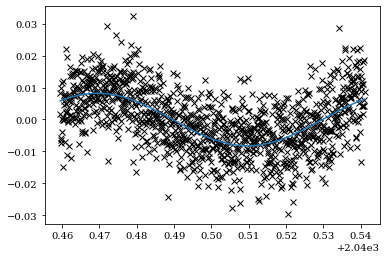

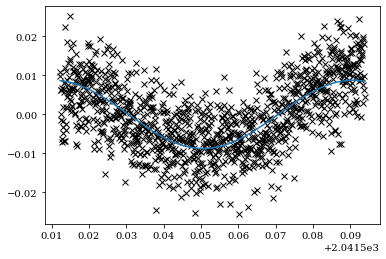

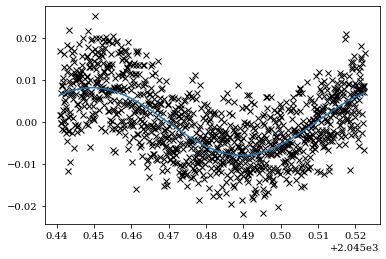

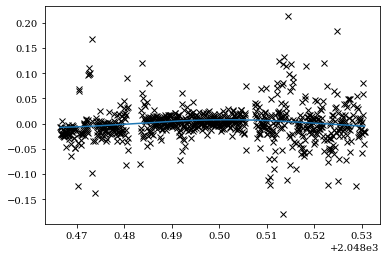

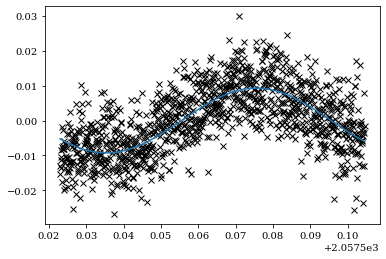

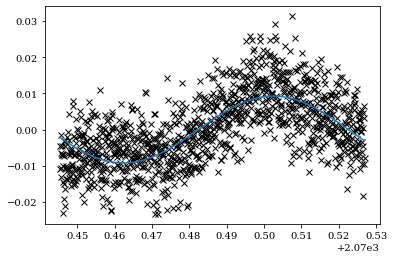

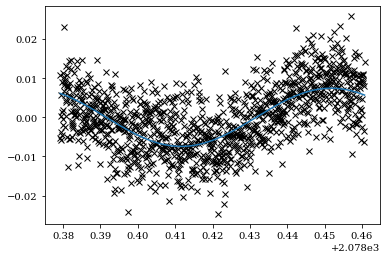

0.044992476054439894


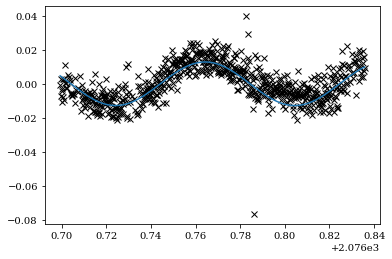

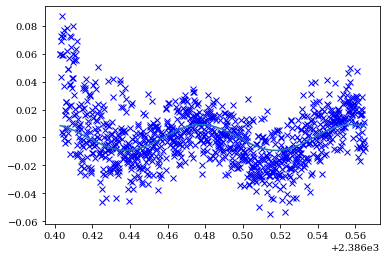

In [10]:
12*np.pi*0.249905 #amp = 0.00823008657\pm0.0003175349263 phase = 1.5701994241907145\pm0.006140549395*2pi
22*np.pi*0.286529#amp = 0.00875121247\pm0.0002779852815  phase=1.8003148028808595\pm0.005055611643
32*np.pi*0.232304#amp = 0.00807037159\pm0.0002604243757   phase=1.4596090795990466\pm0.005135801521
42*np.pi*0.219989#amp = 0.00784105975\pm0.001687992382    phase=1.38223165254113\pm0.03426224772
52*np.pi*0.235174#amp = 0.009282646\pm0.0002784349530    phase=1.38223165254113\pm0.004773886575
62*np.pi*0.233932#amp=0.00924552245\pm0.0002903258090 phase=1.469838105279135\pm0.004997747600
72*np.pi*0.237778#amp =0.00743770724\pm0.0002647410715   phase = 1.4940032359705475\pm0.005665032084


plt.plot(timeLT-2457000, revFluxLT,'kx')
plt.plot(timeLT-2457000, 0.00823008657*np.sin((timeLT-2457000)*(2*np.pi/0.08029867)+1.5701994241907145))
plt.show()

plt.plot(timeLT2-2457000, revFluxLT2,'kx')
plt.plot(timeLT2-2457000, 0.00875121247*np.sin((timeLT2-2457000)*(2*np.pi/0.08029867)+1.8003148028808595))
plt.show()
plt.plot(timeLT3-2457000, revFluxLT3,'kx')
plt.plot(timeLT3-2457000, 0.00807037159*np.sin((timeLT3-2457000)*(2*np.pi/0.08029867)+1.4596090795990466))
plt.show()
plt.plot(timeLT4-2457000, revFluxLT4,'kx')
plt.plot(timeLT4-2457000, 0.00784105975*np.sin((timeLT4-2457000)*(2*np.pi/0.08029867)+1.38223165254113))
plt.show()
plt.plot(timeLT5-2457000, revFluxLT5,'kx')
plt.plot(timeLT5-2457000, 0.009282646*np.sin((timeLT5-2457000)*(2*np.pi/0.08029867)+1.38223165254113))
plt.show()
plt.plot(timeLT6-2457000, revFluxLT6,'kx')
plt.plot(timeLT6-2457000, 0.00924552245*np.sin((timeLT6-2457000)*(2*np.pi/0.08029867)+1.469838105279135))
plt.show()
plt.plot(timeLT7-2457000, revFluxLT7,'kx')
plt.plot(timeLT7-2457000, 0.00743770724*np.sin((timeLT7-2457000)*(2*np.pi/0.08029867)+1.4940032359705475))
plt.show()


plt.plot(JJTimes-2457000, JJFlux,'kx')
plt.plot(JJTimes-2457000, 0.0127874261 *np.sin((JJTimes-2457000)*(2*np.pi/0.08029867)+0.252485*(2*np.pi) ))
JJStd = (0.0127874261 *np.sin((JJTimes-2457000)*(2*np.pi/0.08029867)+0.252485*(2*np.pi) ))-JJFlux
JJStd = np.std(JJFlux)
JJErr = np.sqrt(2/len(JJFlux))*(JJStd/0.0127874261)
print(JJErr)
plt.show()

print('=====================')
plt.plot(timeWHT1-2457000,revFluxWHT1,'bx')
plt.plot(timeWHT1-2457000, 0.00924552245*np.sin((timeWHT1-2457000)*(2*np.pi/0.08029867)+1.469838105279135))
LTPhases = np.array([1.5701994241907145,1.8003148028808595,1.4596090795990466,1.4006728014177021,1.38223165254113,1.469838105279135,1.4940032359705475])
LTPhases = 0.08029870*24*60*(np.array(LTPhases)-1.5031844728888097)/(2*np.pi)
LTErrors = np.array([0.0385822097366745, 0.03176534479410365, 0.03226919265733777,0.09523108547906493,0.029995213986181875,0.03140177428931204,0.03559444635488975])
LTErrors = 0.08029870*24*60*(np.array(LTErrors))/(2*np.pi)
LTTimes = np.array([2040.4978964041147,2041.5530624999956,2045.4816800695817,2048.4985829447746,2057.5637622971935,2070.4861575964906,2078.4199594560914])






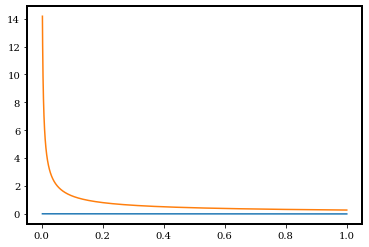

In [26]:
from astropy import units as u
from astropy.units import cds
GD356Mass = 0.7 * u.Msun
SpeedC = 1*cds.c
earthM = 1*cds.geoMass
JupM = 1*cds.jovMass
SunM = 1*u.solMass
SunMF = 0.1*u.solMass
periods = np.linspace(1,365,10000)*cds.MJD
capG = cds.G

semiMajorJup = np.cbrt((periods*periods*capG*(GD356Mass+JupM))/(4*np.pi*np.pi))
amp = (semiMajorJup*JupM/(SpeedC*GD356Mass))
ampJup = amp.to(u.min)
plt.plot(1/periods,ampJup)
semiMajorSun = np.cbrt((periods*periods*capG*(GD356Mass+SunM))/(4*np.pi*np.pi))
amp = (semiMajorSun*SunM/(SpeedC*GD356Mass))
ampSun = amp.to(u.min)
plt.plot(1/periods,ampSun)
semiMajorEarth = np.cbrt((periods*periods*capG*(GD356Mass+earthM))/(4*np.pi*np.pi))
amp = (semiMajorEarth*earthM/(SpeedC*GD356Mass))
ampEarth = amp.to(u.min)


semiMajorSunF = np.cbrt((periods*periods*capG*(GD356Mass+SunMF))/(4*np.pi*np.pi))
amp = (semiMajorSunF*SunMF/(SpeedC*GD356Mass))
ampSunF = amp.to(u.min)



0.06685065852598032


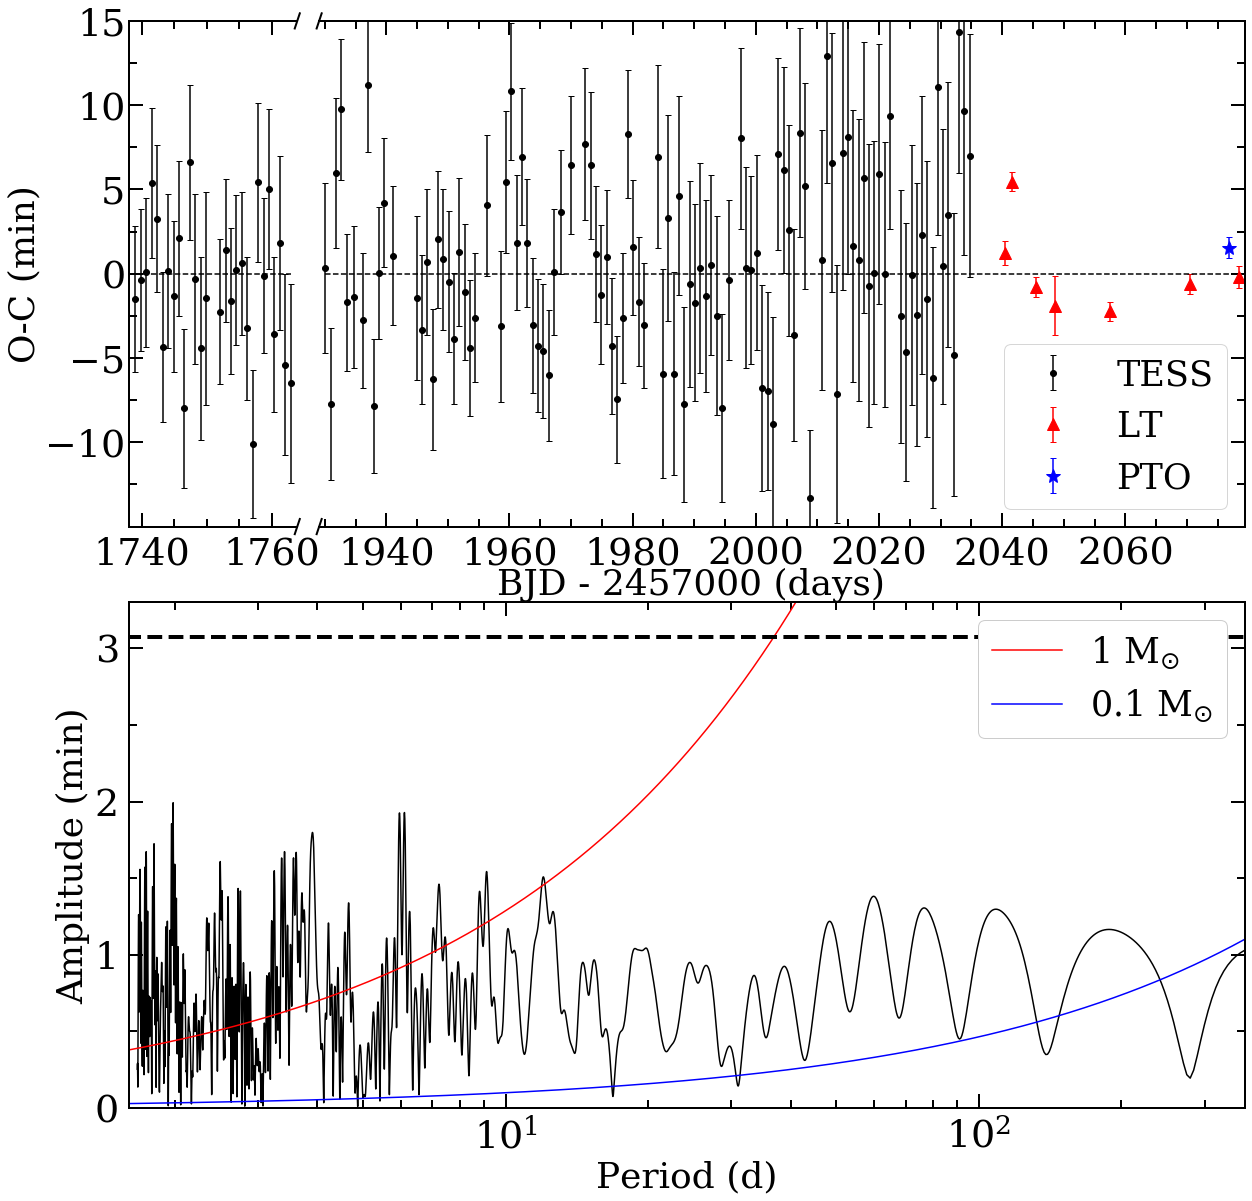

In [33]:
tmpt16 = np.load('TESStmpt16.npy')
toplot16 = np.load('TESStoplot16.npy')
toerr16 = np.load('TESStoerr16.npy')
alltmpts = np.load('TESSalltmpts.npy')
toplot = np.load('TESStoplot.npy')
toerr = np.load('TESStoerr.npy')
rc('axes', linewidth=2)
sec16TErr = np.ones(len(tmpt16))*(1200.857142857143/60/24/2)
sec23TErr = np.ones(24)*(1237.5833333333333/60/24/2)
sec24TErr = np.ones(26)*(1234.2307692307693/60/24/2)
sec25TErr = np.ones(28)*(1231.857142857143/60/24/2)
sec26TErr = np.ones(28)*(1210.142857142857/60/24/2)
tessTimeErrorsTot = np.append(sec23TErr,sec24TErr)
tessTimeErrorsTot = np.append(tessTimeErrorsTot,sec25TErr)
tessTimeErrorsTot = np.append(tessTimeErrorsTot,sec26TErr)
LTTimeError = 0.08029867*np.ones(len(LTPhases))
plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 5.5],wspace=0.04,hspace=0.15) 
ax0 = plt.subplot(gs[0,0])
ax0.yaxis.tick_left()
ax0.errorbar(tmpt16, toplot16, yerr=toerr16, capsize=3, c='k', marker='o', ecolor='k', ls='')
ax1 = plt.subplot(gs[0,1])
ax1.errorbar(alltmpts, toplot,yerr=toerr,capsize=3, c='k', marker='o', ecolor='k', ls='', label='TESS')
ax1.errorbar(LTTimes, LTPhases,yerr=LTErrors,ls='', capsize=3, c='r', marker='^',ecolor='r',ms=12,label='LT')
JJFluxPoint = 0.08029870*24*60*(1.5870132280727272-1.5031844728888097)/(2*np.pi) 
JJTimePoint = np.mean(JJTimes-2457000)
JJErrPoint = (0.08029870*24*60*(0.031269423960815876)/(2*np.pi))+(3/60)
ax1.errorbar(JJTimePoint,JJFluxPoint,yerr=JJErrPoint,capsize=3, c='b', marker='*', ecolor='b', ls='', label='PTO',ms=14)
ax0.plot([tmpt16[0],tmpt16[-1]], [0,0], '--k')
ax1.set_xlabel('BJD - 2457000 (days)',fontsize=36)
ax1.plot([alltmpts[0],LTTimes[-1]], [0,0], '--k')
ax0.set_ylabel('O-C (min)',fontsize=36)
ax1.xaxis.set_label_coords(0.4015, -0.08)
ax1.tick_params(labelright='on')
ax1.yaxis.tick_right()
ax0.yaxis.set_label_position("left")
ax0.xaxis.set_minor_locator(AutoMinorLocator())
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax0.yaxis.set_minor_locator(MultipleLocator(2.5))
ax1.yaxis.set_minor_locator(MultipleLocator(2.5))
ax0.tick_params(which='both', width=2,direction='in')
ax0.tick_params(axis='x',which='both', width=2,direction='in',pad=10)
ax1.tick_params(axis='x',which='both', width=2,direction='in',pad=10)
ax0.tick_params(which='major', length=14)
ax0.tick_params(which='minor', length=8)
ax1.tick_params(which='both', width=2,direction='in')
ax1.tick_params(which='major', length=14)
ax1.tick_params(which='minor', length=8)
ax0.xaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax0.tick_params(labelsize=38)
ax1.tick_params(labelsize=38)
ax0.set_ylim(-14.999,15)
ax1.set_ylim(-14.999,15)
ax0.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
d = .015 
kwargs = dict(transform=ax0.transAxes, color='k', clip_on=False)
ax0.plot((1-d,1+d), (-d,+d), **kwargs, lw=2)
ax0.plot((1-d,1+d),(1-d,1+d), **kwargs, lw=2)
d = .015
kwargs.update(transform=ax1.transAxes)  # switch to the bottom axes
ax1.plot((-d/5.5,+d/5.5), (1-d,1+d), **kwargs, lw=2)
ax1.plot((-d/5.5,+d/5.5), (-d,+d), **kwargs, lw=2)
ax0.set_xlim(tmpt16[0]-1,tmpt16[-1]+1)
ax1.set_xlim(alltmpts[0]-1,LTTimes[-1]+1)

ax1.legend(prop={'size': 35})
########################plt.errorbar(np.mean(JJTimes)-2457000, 0.08029870*24*60*(1.5589858280971907-1.5031844728888097)/(2*np.pi) , yerr=0.08029870*24*60*(0.03501621751558392*2)/(2*np.pi))
allallTime = np.append(tmpt16, alltmpts)
allallTime = np.append(allallTime, LTTimes)
allallTime = np.append(allallTime, JJTimePoint)
allallPhase = np.append(toplot16, toplot)
allallPhase = np.append(allallPhase, LTPhases)
allallPhase = np.append(allallPhase, JJFluxPoint)
allallTError = np.append(sec16TErr, tessTimeErrorsTot)
allallTError = np.append(allallTError, LTTimeError)

allallPhError = np.append(toerr16, toerr)
allallPhError = np.append(allallPhError, LTErrors)
allallPhError = np.append(allallPhError, JJErrPoint)
freq = np.linspace(1/365,0.6,10000)
ax3 = plt.subplot(gs[1,:])
powerPl = LombScargle(allallTime,allallPhase,normalization='psd').power(freq)


#https://docs.astropy.org/en/stable/timeseries/lombscargle.html
#nyquist 0.582566
amplitude = np.sqrt(powerPl) * np.sqrt(4./len(allallTime))
ax3.plot(1/freq,amplitude, c='k')
ax3.plot(periods,ampSun, label=r'1 M$_{\odot}$', c='r')
ax3.plot(periods,ampSunF, label=r'0.1 M$_{\odot}$',c='b')
#ax3.plot(1/periods,ampJup, label=r'M$_{\rm Jup}$')
ax3.set_xlim(1.6,365)
ax3.set_ylim(0.0,3.3)
ax3.set_xlabel(r'Period (d)',fontsize=36)
ax3.set_ylabel('Amplitude (min)',fontsize=36)
fapAmp = np.sqrt(0.1586498743601815) * np.sqrt(4./len(allallTime))
print(fapAmp)
ax3.plot([0.001,365],[3.074524194563394,3.074524194563394],c='k',ls='dashed',linewidth=4)
ax3.yaxis.set_ticks_position('both')
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(MultipleLocator(0.5))
ax3.yaxis.set_major_locator(MultipleLocator(1))
ax3.tick_params(which='both', width=2,direction='in',pad=10)
ax3.tick_params(which='major', length=14)
ax3.tick_params(which='minor', length=8)
ax3.tick_params(labelsize=38)
ax3.xaxis.set_ticks_position('both')
#ax3.tick_params(labelright='on')
ax1.set_yticklabels([])
ax3.legend(prop={'size': 35},framealpha=1)
#ax3.set_yticklabels([])
ax3.set_xscale('log')
bboxx = transforms.Bbox([[0.78, 1.32], [18.04, 17.85]])
plt.savefig('OC_Diagram.pdf',bbox_inches=bboxx) 
#plt.savefig('Figure5.eps', bbox_inches='tight', pad_inches=0.75 ) 

0.22094195155510626


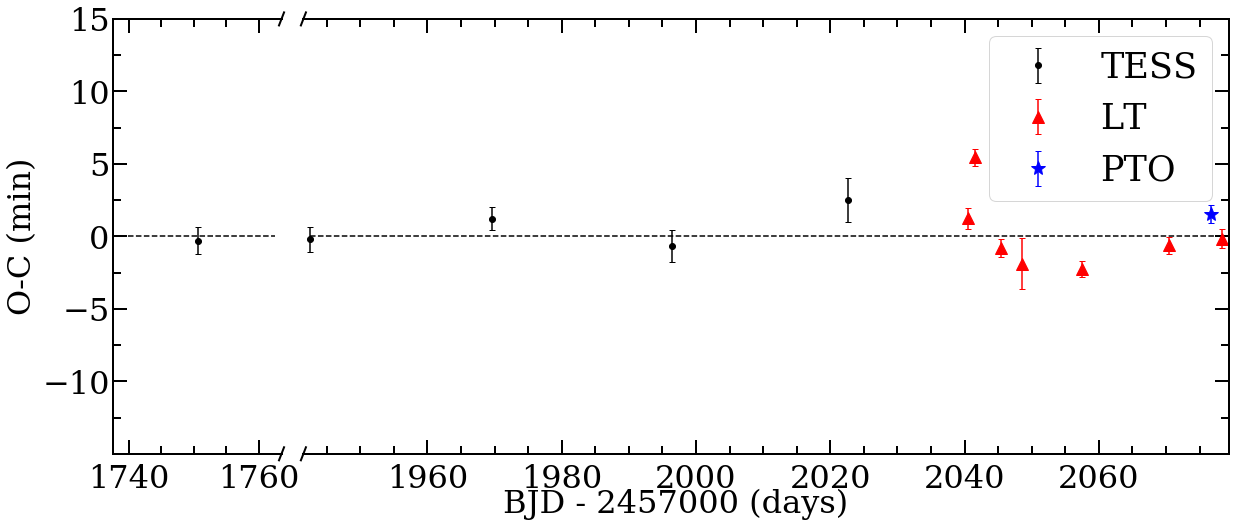

In [44]:
tmpt16 = np.load('TESStmpt16HST.npy')
toplot16 = np.load('TESStoplot16HST.npy')
toerr16 = np.load('TESStoerr16HST.npy')
alltmpts = np.load('TESSalltmptsHST.npy')
toplot = np.load('TESStoplotHST.npy')
toerr = np.load('TESStoerrHST.npy')
fontsize=32
rc('axes', linewidth=2)
sec16TErr = np.ones(len(tmpt16))*(1200.857142857143/60/24/2)
sec23TErr = np.ones(24)*(1237.5833333333333/60/24/2)
sec24TErr = np.ones(26)*(1234.2307692307693/60/24/2)
sec25TErr = np.ones(28)*(1231.857142857143/60/24/2)
sec26TErr = np.ones(28)*(1210.142857142857/60/24/2)
tessTimeErrorsTot = np.append(sec23TErr,sec24TErr)
tessTimeErrorsTot = np.append(tessTimeErrorsTot,sec25TErr)
tessTimeErrorsTot = np.append(tessTimeErrorsTot,sec26TErr)
LTTimeError = 0.08029867*np.ones(len(LTPhases))
plt.figure(figsize=(20,8))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 5.5],wspace=0.04,hspace=0.15) 
ax0 = plt.subplot(gs[0,0])
ax0.yaxis.tick_left()
ax0.errorbar(tmpt16, toplot16, yerr=toerr16, capsize=3, c='k', marker='o', ecolor='k', ls='')
ax1 = plt.subplot(gs[0,1])
ax1.errorbar(alltmpts, toplot,yerr=toerr,capsize=3, c='k', marker='o', ecolor='k', ls='', label='TESS')
ax1.errorbar(LTTimes, LTPhases,yerr=LTErrors,ls='', capsize=3, c='r', marker='^',ecolor='r',ms=12,label='LT')
JJFluxPoint = 0.08029870*24*60*(1.5870132280727272-1.5031844728888097)/(2*np.pi) 
JJTimePoint = np.mean(JJTimes-2457000)
JJErrPoint = (0.08029870*24*60*(0.031269423960815876)/(2*np.pi))+(3/60)
ax1.errorbar(JJTimePoint,JJFluxPoint,yerr=JJErrPoint,capsize=3, c='b', marker='*', ecolor='b', ls='', label='PTO',ms=14)
ax0.plot([sec16t[0]-2457000,sec16t[-1]-2457000], [0,0], '--k')
ax1.set_xlabel('BJD - 2457000 (days)',fontsize=fontsize)
ax1.plot([alltmpts[0],LTTimes[-1]], [0,0], '--k')
ax0.set_ylabel('O-C (min)',fontsize=fontsize)
ax1.xaxis.set_label_coords(0.4015, -0.08)
ax1.tick_params(labelright='on')
ax1.yaxis.tick_right()
ax0.yaxis.set_label_position("left")
ax0.xaxis.set_minor_locator(AutoMinorLocator())
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax0.yaxis.set_minor_locator(MultipleLocator(2.5))
ax1.yaxis.set_minor_locator(MultipleLocator(2.5))
ax0.tick_params(which='both', width=2,direction='in')
ax0.tick_params(axis='x',which='both', width=2,direction='in',pad=10)
ax1.tick_params(axis='x',which='both', width=2,direction='in',pad=10)
ax0.tick_params(which='major', length=14)
ax0.tick_params(which='minor', length=8)
ax1.tick_params(which='both', width=2,direction='in')
ax1.tick_params(which='major', length=14)
ax1.tick_params(which='minor', length=8)
ax0.xaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax0.tick_params(labelsize=fontsize)
ax1.tick_params(labelsize=fontsize)
ax0.set_ylim(-14.999,15)
ax1.set_ylim(-14.999,15)
ax0.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
d = .015 
kwargs = dict(transform=ax0.transAxes, color='k', clip_on=False)
ax0.plot((1-d,1+d), (-d,+d), **kwargs, lw=2)
ax0.plot((1-d,1+d),(1-d,1+d), **kwargs, lw=2)
d = .015
kwargs.update(transform=ax1.transAxes)  # switch to the bottom axes
ax1.plot((-d/5.5,+d/5.5), (1-d,1+d), **kwargs, lw=2)
ax1.plot((-d/5.5,+d/5.5), (-d,+d), **kwargs, lw=2)
ax0.set_xlim(sec16t[0]-1-2457000,sec16t[-1]+1-2457000)
ax1.set_xlim(alltmpts[0]-1,LTTimes[-1]+1)

ax1.legend(prop={'size': 35},loc='upper right')
########################plt.errorbar(np.mean(JJTimes)-2457000, 0.08029870*24*60*(1.5589858280971907-1.5031844728888097)/(2*np.pi) , yerr=0.08029870*24*60*(0.03501621751558392*2)/(2*np.pi))
allallTime = np.append(tmpt16, alltmpts)
allallTime = np.append(allallTime, LTTimes)
allallTime = np.append(allallTime, JJTimePoint)
allallPhase = np.append(toplot16, toplot)
allallPhase = np.append(allallPhase, LTPhases)
allallPhase = np.append(allallPhase, JJFluxPoint)
allallTError = np.append(sec16TErr, tessTimeErrorsTot)
allallTError = np.append(allallTError, LTTimeError)

allallPhError = np.append(toerr16, toerr)
allallPhError = np.append(allallPhError, LTErrors)
allallPhError = np.append(allallPhError, JJErrPoint)
freq = np.linspace(1/365,0.6,10000)
#ax3 = plt.subplot(gs[1,:])
powerPl = LombScargle(allallTime,allallPhase,normalization='psd').power(freq)


#https://docs.astropy.org/en/stable/timeseries/lombscargle.html
#nyquist 0.582566
amplitude = np.sqrt(powerPl) * np.sqrt(4./len(allallTime))
#ax3.plot(1/freq,amplitude, c='k')
#ax3.plot(periods,ampSun, label=r'1 M$_{\odot}$', c='r')
#ax3.plot(periods,ampSunF, label=r'0.1 M$_{\odot}$',c='b')
#ax3.plot(1/periods,ampJup, label=r'M$_{\rm Jup}$')
#ax3.set_xlim(1.6,365)
#ax3.set_ylim(0.0,3.3)
#ax3.set_xlabel(r'Period (d)',fontsize=36)
#ax3.set_ylabel('Amplitude (min)',fontsize=36)
fapAmp = np.sqrt(0.1586498743601815) * np.sqrt(4./len(allallTime))
print(fapAmp)
#ax3.plot([0.001,365],[3.074524194563394,3.074524194563394],c='k',ls='dashed',linewidth=4)
#ax3.yaxis.set_ticks_position('both')
#ax3.xaxis.set_minor_locator(AutoMinorLocator())
#ax3.yaxis.set_minor_locator(MultipleLocator(0.5))
#ax3.yaxis.set_major_locator(MultipleLocator(1))
#ax3.tick_params(which='both', width=2,direction='in',pad=10)
#ax3.tick_params(which='major', length=14)
#ax3.tick_params(which='minor', length=8)
#ax3.tick_params(labelsize=38)
#ax3.xaxis.set_ticks_position('both')
#ax3.tick_params(labelright='on')
ax1.set_yticklabels([])
#ax3.legend(prop={'size': 35},framealpha=1)
#ax3.set_yticklabels([])
#ax3.set_xscale('log')
bboxx = transforms.Bbox([[0.9, 0.08], [18.04, 7.22]])
plt.savefig('OC_DiagramHSTv2.pdf',bbox_inches=bboxx) 
#plt.savefig('Figure5.eps', bbox_inches='tight', pad_inches=0.75 ) 

0.06685065852598032


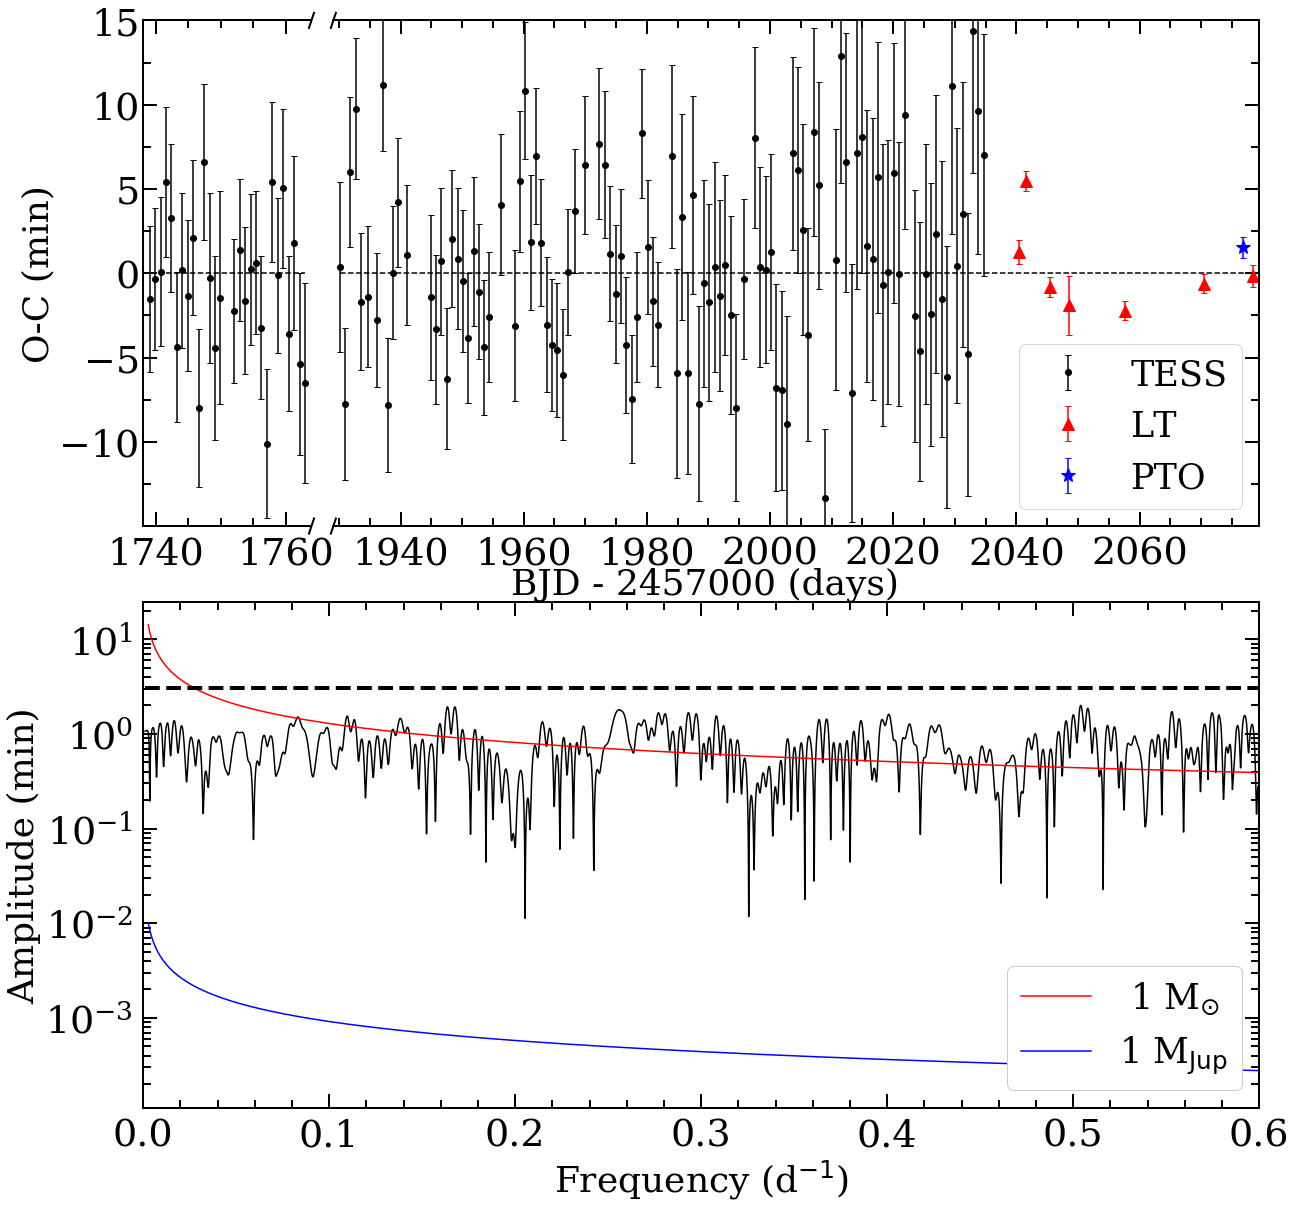

In [48]:
tmpt16 = np.load('TESStmpt16.npy')
toplot16 = np.load('TESStoplot16.npy')
toerr16 = np.load('TESStoerr16.npy')
alltmpts = np.load('TESSalltmpts.npy')
toplot = np.load('TESStoplot.npy')
toerr = np.load('TESStoerr.npy')
rc('axes', linewidth=2)
sec16TErr = np.ones(len(tmpt16))*(1200.857142857143/60/24/2)
sec23TErr = np.ones(24)*(1237.5833333333333/60/24/2)
sec24TErr = np.ones(26)*(1234.2307692307693/60/24/2)
sec25TErr = np.ones(28)*(1231.857142857143/60/24/2)
sec26TErr = np.ones(28)*(1210.142857142857/60/24/2)
tessTimeErrorsTot = np.append(sec23TErr,sec24TErr)
tessTimeErrorsTot = np.append(tessTimeErrorsTot,sec25TErr)
tessTimeErrorsTot = np.append(tessTimeErrorsTot,sec26TErr)
LTTimeError = 0.08029867*np.ones(len(LTPhases))
plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 5.5],wspace=0.04,hspace=0.15) 
ax0 = plt.subplot(gs[0,0])
ax0.yaxis.tick_left()
ax0.errorbar(tmpt16, toplot16, yerr=toerr16, capsize=3, c='k', marker='o', ecolor='k', ls='')
ax1 = plt.subplot(gs[0,1])
ax1.errorbar(alltmpts, toplot,yerr=toerr,capsize=3, c='k', marker='o', ecolor='k', ls='', label='TESS')
ax1.errorbar(LTTimes, LTPhases,yerr=LTErrors,ls='', capsize=3, c='r', marker='^',ecolor='r',ms=12,label='LT')
JJFluxPoint = 0.08029870*24*60*(1.5870132280727272-1.5031844728888097)/(2*np.pi) 
JJTimePoint = np.mean(JJTimes-2457000)
JJErrPoint = (0.08029870*24*60*(0.031269423960815876)/(2*np.pi))+(3/60)
ax1.errorbar(JJTimePoint,JJFluxPoint,yerr=JJErrPoint,capsize=3, c='b', marker='*', ecolor='b', ls='', label='PTO',ms=14)
ax0.plot([tmpt16[0],tmpt16[-1]], [0,0], '--k')
ax1.set_xlabel('BJD - 2457000 (days)',fontsize=36)
ax1.plot([alltmpts[0],LTTimes[-1]], [0,0], '--k')
ax0.set_ylabel('O-C (min)',fontsize=36)
ax1.xaxis.set_label_coords(0.4015, -0.08)
ax1.tick_params(labelright='on')
ax1.yaxis.tick_right()
ax0.yaxis.set_label_position("left")
ax0.xaxis.set_minor_locator(AutoMinorLocator())
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax0.yaxis.set_minor_locator(MultipleLocator(2.5))
ax1.yaxis.set_minor_locator(MultipleLocator(2.5))
ax0.tick_params(which='both', width=2,direction='in')
ax0.tick_params(axis='x',which='both', width=2,direction='in',pad=10)
ax1.tick_params(axis='x',which='both', width=2,direction='in',pad=10)
ax0.tick_params(which='major', length=14)
ax0.tick_params(which='minor', length=8)
ax1.tick_params(which='both', width=2,direction='in')
ax1.tick_params(which='major', length=14)
ax1.tick_params(which='minor', length=8)
ax0.xaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax0.tick_params(labelsize=38)
ax1.tick_params(labelsize=38)
ax0.set_ylim(-14.999,15)
ax1.set_ylim(-14.999,15)
ax0.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
d = .015 
kwargs = dict(transform=ax0.transAxes, color='k', clip_on=False)
ax0.plot((1-d,1+d), (-d,+d), **kwargs, lw=2)
ax0.plot((1-d,1+d),(1-d,1+d), **kwargs, lw=2)
d = .015
kwargs.update(transform=ax1.transAxes)  # switch to the bottom axes
ax1.plot((-d/5.5,+d/5.5), (1-d,1+d), **kwargs, lw=2)
ax1.plot((-d/5.5,+d/5.5), (-d,+d), **kwargs, lw=2)
ax0.set_xlim(tmpt16[0]-1,tmpt16[-1]+1)
ax1.set_xlim(alltmpts[0]-1,LTTimes[-1]+1)

ax1.legend(prop={'size': 35})
########################plt.errorbar(np.mean(JJTimes)-2457000, 0.08029870*24*60*(1.5589858280971907-1.5031844728888097)/(2*np.pi) , yerr=0.08029870*24*60*(0.03501621751558392*2)/(2*np.pi))
allallTime = np.append(tmpt16, alltmpts)
allallTime = np.append(allallTime, LTTimes)
allallTime = np.append(allallTime, JJTimePoint)
allallPhase = np.append(toplot16, toplot)
allallPhase = np.append(allallPhase, LTPhases)
allallPhase = np.append(allallPhase, JJFluxPoint)
allallTError = np.append(sec16TErr, tessTimeErrorsTot)
allallTError = np.append(allallTError, LTTimeError)

allallPhError = np.append(toerr16, toerr)
allallPhError = np.append(allallPhError, LTErrors)
allallPhError = np.append(allallPhError, JJErrPoint)
freq = np.linspace(0.001,0.6,10000)
ax3 = plt.subplot(gs[1,:])
powerPl = LombScargle(allallTime,allallPhase,normalization='psd').power(freq)


#https://docs.astropy.org/en/stable/timeseries/lombscargle.html
#nyquist 0.582566
amplitude = np.sqrt(powerPl) * np.sqrt(4./len(allallTime))
ax3.plot(freq,amplitude, c='k')
ax3.plot(1/periods,ampSun, label=r' 1 M$_{\odot}$', c='r')
ax3.plot(1/periods,ampJup, label=r'1 M$_{\rm Jup}$',c='b')
ax3.legend(prop={'size': 35},framealpha=1)
ax3.set_xlim(0,0.6)
#ax3.set_ylim(0.0,3.3)
ax3.set_xlabel(r'Frequency (d$^{-1}$)',fontsize=36)
ax3.set_ylabel('Amplitude (min)',fontsize=36)
ax3.set_yscale('log')
fapAmp = np.sqrt(0.1586498743601815) * np.sqrt(4./len(allallTime))
print(fapAmp)
ax3.plot([0.001,1],[3.074524194563394,3.074524194563394],c='k',ls='dashed',linewidth=4)
ax3.yaxis.set_ticks_position('both')
ax3.xaxis.set_minor_locator(AutoMinorLocator())
#ax3.yaxis.set_minor_locator(AutoMinorLocator())
#ax3.yaxis.set_major_locator(AutoMinorLocator())
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=10) 
ax3.yaxis.set_major_locator(locmaj)
ax3.tick_params(which='both', width=2,direction='in',pad=10)
ax3.tick_params(which='major', length=14)
ax3.tick_params(which='minor', length=8)
ax3.tick_params(labelsize=38)
ax3.xaxis.set_ticks_position('both')
#ax3.tick_params(labelright='on')
ax1.set_yticklabels([])
#ax3.set_yticklabels([])

bboxx = transforms.Bbox([[0.54, 1.23], [18.44, 17.85]])
plt.savefig('OC_DiagramTwo.pdf',bbox_inches=bboxx) 
#plt.savefig('Figure5.eps', bbox_inches='tight', pad_inches=0.75 ) 

0.06685065852598032


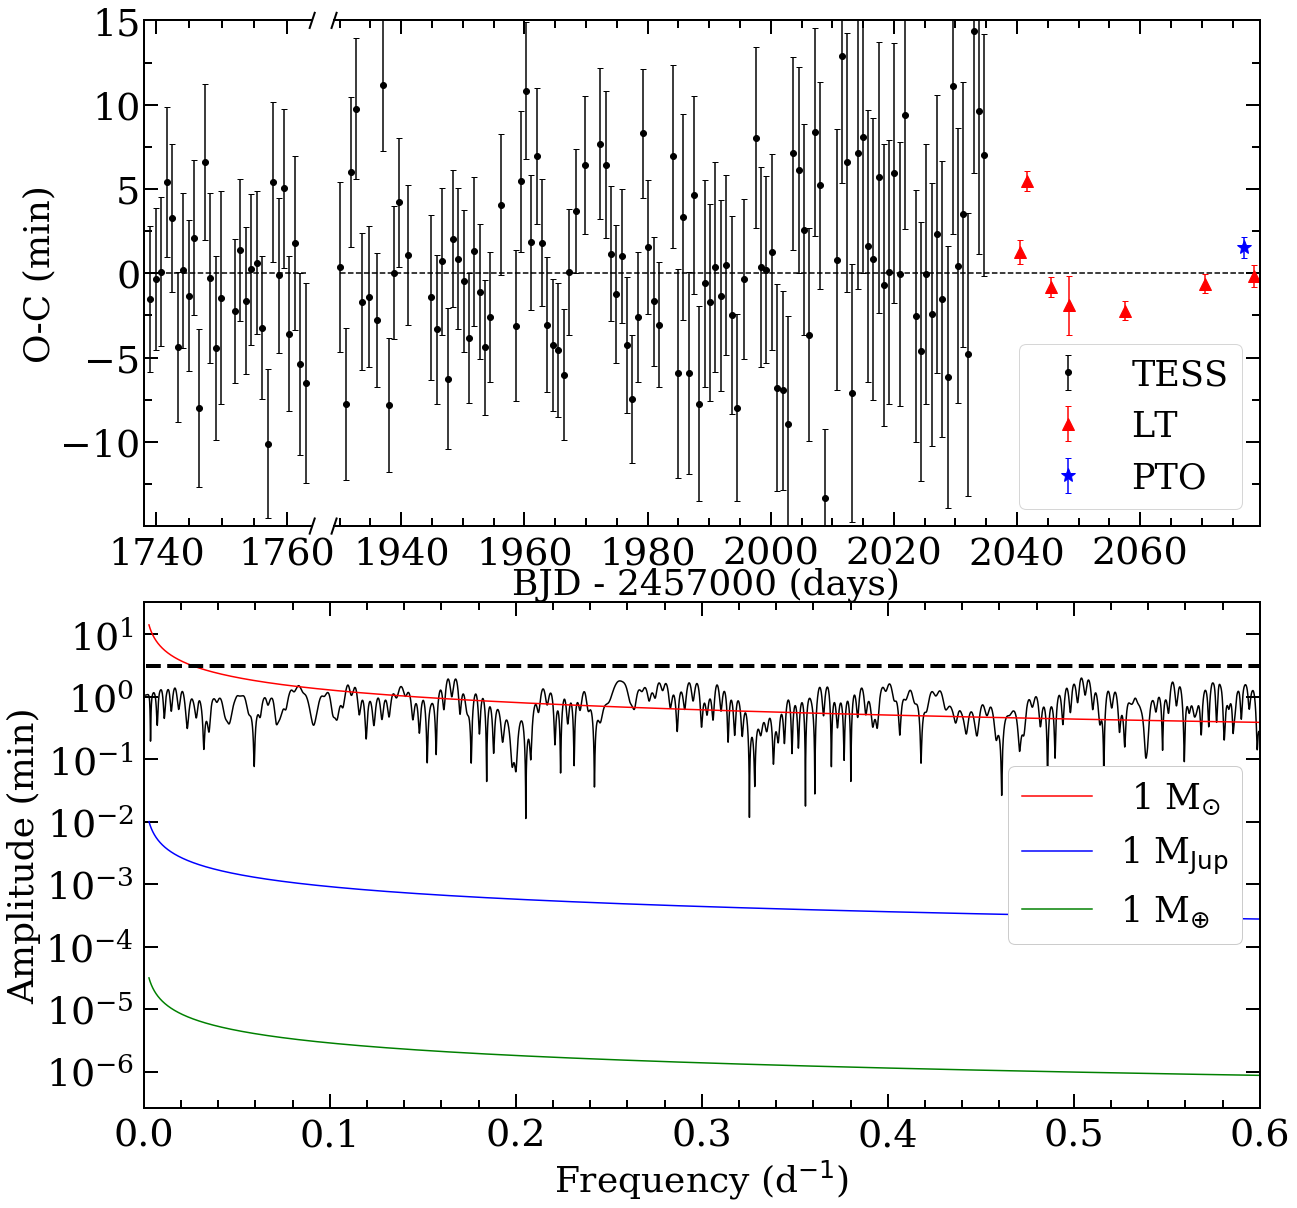

In [52]:
tmpt16 = np.load('TESStmpt16.npy')
toplot16 = np.load('TESStoplot16.npy')
toerr16 = np.load('TESStoerr16.npy')
alltmpts = np.load('TESSalltmpts.npy')
toplot = np.load('TESStoplot.npy')
toerr = np.load('TESStoerr.npy')
rc('axes', linewidth=2)
sec16TErr = np.ones(len(tmpt16))*(1200.857142857143/60/24/2)
sec23TErr = np.ones(24)*(1237.5833333333333/60/24/2)
sec24TErr = np.ones(26)*(1234.2307692307693/60/24/2)
sec25TErr = np.ones(28)*(1231.857142857143/60/24/2)
sec26TErr = np.ones(28)*(1210.142857142857/60/24/2)
tessTimeErrorsTot = np.append(sec23TErr,sec24TErr)
tessTimeErrorsTot = np.append(tessTimeErrorsTot,sec25TErr)
tessTimeErrorsTot = np.append(tessTimeErrorsTot,sec26TErr)
LTTimeError = 0.08029867*np.ones(len(LTPhases))
plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 5.5],wspace=0.04,hspace=0.15) 
ax0 = plt.subplot(gs[0,0])
ax0.yaxis.tick_left()
ax0.errorbar(tmpt16, toplot16, yerr=toerr16, capsize=3, c='k', marker='o', ecolor='k', ls='')
ax1 = plt.subplot(gs[0,1])
ax1.errorbar(alltmpts, toplot,yerr=toerr,capsize=3, c='k', marker='o', ecolor='k', ls='', label='TESS')
ax1.errorbar(LTTimes, LTPhases,yerr=LTErrors,ls='', capsize=3, c='r', marker='^',ecolor='r',ms=12,label='LT')
JJFluxPoint = 0.08029870*24*60*(1.5870132280727272-1.5031844728888097)/(2*np.pi) 
JJTimePoint = np.mean(JJTimes-2457000)
JJErrPoint = (0.08029870*24*60*(0.031269423960815876)/(2*np.pi))+(3/60)
ax1.errorbar(JJTimePoint,JJFluxPoint,yerr=JJErrPoint,capsize=3, c='b', marker='*', ecolor='b', ls='', label='PTO',ms=14)
ax0.plot([tmpt16[0],tmpt16[-1]], [0,0], '--k')
ax1.set_xlabel('BJD - 2457000 (days)',fontsize=36)
ax1.plot([alltmpts[0],LTTimes[-1]], [0,0], '--k')
ax0.set_ylabel('O-C (min)',fontsize=36)
ax1.xaxis.set_label_coords(0.4015, -0.08)
ax1.tick_params(labelright='on')
ax1.yaxis.tick_right()
ax0.yaxis.set_label_position("left")
ax0.xaxis.set_minor_locator(AutoMinorLocator())
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax0.yaxis.set_minor_locator(MultipleLocator(2.5))
ax1.yaxis.set_minor_locator(MultipleLocator(2.5))
ax0.tick_params(which='both', width=2,direction='in')
ax0.tick_params(axis='x',which='both', width=2,direction='in',pad=10)
ax1.tick_params(axis='x',which='both', width=2,direction='in',pad=10)
ax0.tick_params(which='major', length=14)
ax0.tick_params(which='minor', length=8)
ax1.tick_params(which='both', width=2,direction='in')
ax1.tick_params(which='major', length=14)
ax1.tick_params(which='minor', length=8)
ax0.xaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax0.tick_params(labelsize=38)
ax1.tick_params(labelsize=38)
ax0.set_ylim(-14.999,15)
ax1.set_ylim(-14.999,15)
ax0.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
d = .015 
kwargs = dict(transform=ax0.transAxes, color='k', clip_on=False)
ax0.plot((1-d,1+d), (-d,+d), **kwargs, lw=2)
ax0.plot((1-d,1+d),(1-d,1+d), **kwargs, lw=2)
d = .015
kwargs.update(transform=ax1.transAxes)  # switch to the bottom axes
ax1.plot((-d/5.5,+d/5.5), (1-d,1+d), **kwargs, lw=2)
ax1.plot((-d/5.5,+d/5.5), (-d,+d), **kwargs, lw=2)
ax0.set_xlim(tmpt16[0]-1,tmpt16[-1]+1)
ax1.set_xlim(alltmpts[0]-1,LTTimes[-1]+1)

ax1.legend(prop={'size': 35})
########################plt.errorbar(np.mean(JJTimes)-2457000, 0.08029870*24*60*(1.5589858280971907-1.5031844728888097)/(2*np.pi) , yerr=0.08029870*24*60*(0.03501621751558392*2)/(2*np.pi))
allallTime = np.append(tmpt16, alltmpts)
allallTime = np.append(allallTime, LTTimes)
allallTime = np.append(allallTime, JJTimePoint)
allallPhase = np.append(toplot16, toplot)
allallPhase = np.append(allallPhase, LTPhases)
allallPhase = np.append(allallPhase, JJFluxPoint)
allallTError = np.append(sec16TErr, tessTimeErrorsTot)
allallTError = np.append(allallTError, LTTimeError)

allallPhError = np.append(toerr16, toerr)
allallPhError = np.append(allallPhError, LTErrors)
allallPhError = np.append(allallPhError, JJErrPoint)
freq = np.linspace(0.001,0.6,10000)
ax3 = plt.subplot(gs[1,:])
powerPl = LombScargle(allallTime,allallPhase,normalization='psd').power(freq)


#https://docs.astropy.org/en/stable/timeseries/lombscargle.html
#nyquist 0.582566
amplitude = np.sqrt(powerPl) * np.sqrt(4./len(allallTime))
ax3.plot(freq,amplitude, c='k')
ax3.plot(1/periods,ampSun, label=r' 1 M$_{\odot}$', c='r')
ax3.plot(1/periods,ampJup, label=r'1 M$_{\rm Jup}$',c='b')
ax3.plot(1/periods,ampEarth, label=r'1 M$_{\oplus}$',c='g')
ax3.legend(prop={'size': 35},framealpha=1)
ax3.set_xlim(0,0.6)
#ax3.set_ylim(0.0,3.3)
ax3.set_xlabel(r'Frequency (d$^{-1}$)',fontsize=36)
ax3.set_ylabel('Amplitude (min)',fontsize=36)
ax3.set_yscale('log')
fapAmp = np.sqrt(0.1586498743601815) * np.sqrt(4./len(allallTime))
print(fapAmp)
ax3.plot([0.001,1],[3.074524194563394,3.074524194563394],c='k',ls='dashed',linewidth=4)
ax3.yaxis.set_ticks_position('both')
ax3.xaxis.set_minor_locator(AutoMinorLocator())
#ax3.yaxis.set_minor_locator(AutoMinorLocator())
#ax3.yaxis.set_major_locator(AutoMinorLocator())
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=10) 
ax3.yaxis.set_major_locator(locmaj)
ax3.tick_params(which='both', width=2,direction='in',pad=10)
ax3.tick_params(which='major', length=14)
ax3.tick_params(which='minor', length=8)
ax3.tick_params(labelsize=38)
ax3.xaxis.set_ticks_position('both')
#ax3.tick_params(labelright='on')
ax1.set_yticklabels([])
#ax3.set_yticklabels([])

bboxx = transforms.Bbox([[0.54, 1.23], [18.44, 17.85]])
plt.savefig('OC_DiagramThree.pdf',bbox_inches=bboxx) 
#plt.savefig('Figure5.eps', bbox_inches='tight', pad_inches=0.75 ) 

In [59]:
freq = np.linspace(0.001,0.6,10000)
maxpeaks = []
indiciesToSh = np.linspace(0,len(allallPhase)-1, len(allallPhase),dtype=int)
for i in range(100000):
    np.random.shuffle(indiciesToSh)
    phasesShuf = allallPhase[indiciesToSh]
    #errorShuf = allallPhError[indiciesToSh]
    powerPl = LombScargle(allallTime,phasesShuf,normalization='psd').power(freq)
    powerPl = np.sqrt(powerPl) * np.sqrt(4./len(allallTime))
    maxpeaks.append(max(powerPl))

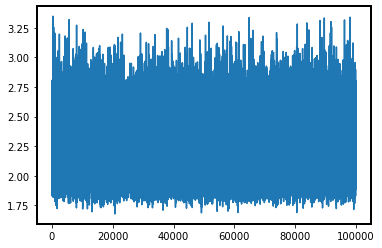

In [60]:
plt.plot(maxpeaks)

In [61]:
idx = (-np.array(maxpeaks)).argsort()[:100]
for el in idx:
    print(maxpeaks[el])

3.3475063875095685
3.339300123285504
3.3363648141719144
3.332903248119919
3.319393751944114
3.316346260758774
3.3112483060039484
3.3023156368427826
3.2965962457713767
3.2913913619506157
3.288512289339564
3.2820603977988476
3.2719424294767956
3.265291019466549
3.2543644581019397
3.2542971336058275
3.253815553458441
3.2453461487480464
3.2364574011058798
3.234815388770971
3.2321068232257777
3.2287016460455717
3.2172393888082245
3.2127446937977537
3.209524287114473
3.2063888780725187
3.2053829364097544
3.2048237948493603
3.1965161455404547
3.196505118896081
3.1920966197329714
3.1901989507075728
3.1872179478779046
3.181035812590462
3.1804732823148556
3.1794771983704946
3.1763348935704374
3.1684201148408158
3.1677448364416847
3.1653224773431705
3.16167405038279
3.161322719693639
3.1605416986362345
3.1532806884726607
3.147394478741469
3.1432512127780665
3.140902582865888
3.1384930819741155
3.1377357634832013
3.132809955626287
3.1290439313753104
3.127878705871474
3.126756841190071
3.1250043474

In [9]:
dataLT = pd.read_csv('mes2.csv', delimiter=',')
timeLT = dataLT['BJD_TDB']
revFluxLT = dataLT['rel_flux_T1']
revFluxLT = (revFluxLT/np.mean(revFluxLT))-1
timeLT = timeLT-2457000- 1296.0255697684468
phasesLT = foldMeth(timeLT,0.08029820145279275)
sortIndi = np.argsort(phasesLT)
phasesLTs = phasesLT[sortIndi]
revFluxLTs = revFluxLT[sortIndi]
dataLT = pd.read_csv('mes2.csv', delimiter=',')
timeLT = dataLT['BJD_TDB']
timeLT = timeLT-2457000- 1296.0255697684468
revFluxLT = dataLT['rel_flux_T1']
revFluxLT = (revFluxLT/np.mean(revFluxLT))-1
timeLTMean = np.nanmean(np.pad(timeLT.astype(float), (0, 10 - timeLT.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
fluxLTMean = np.nanmean(np.pad(revFluxLT.astype(float), (0, 10 - revFluxLT.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
phasesLTMean = foldMeth(timeLTMean,0.08029820145279275)
sortIndi = np.argsort(phasesLTMean)
phasesLTMean = phasesLTMean[sortIndi]
fluxLTMean = fluxLTMean[sortIndi]
errorLT = np.std(revFluxLT- 0.00811455943*np.sin((timeLT)*(2*np.pi/0.08029820145279275)+0.0198975*2*np.pi))

dataLT2 = pd.read_csv('LT/2/Measurements.xls', delimiter='\t')
timeLT2 = dataLT2['BJD_TDB']
timeLT2 = timeLT2-2457000- 1296.0255697684468
revFluxLT2 = dataLT2['rel_flux_T1']
revFluxLT2 = (revFluxLT2/np.mean(revFluxLT2))-1
timeLTMean2 = np.nanmean(np.pad(timeLT2.astype(float), (0, 10 - timeLT2.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
fluxLTMean2 = np.nanmean(np.pad(revFluxLT2.astype(float), (0, 10 - revFluxLT2.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
phasesLTMean2 = foldMeth(timeLTMean2,0.08029820145279275)
sortIndi = np.argsort(phasesLTMean2)
phasesLTMean2 = phasesLTMean2[sortIndi]
fluxLTMean2 = fluxLTMean2[sortIndi]
errorLT2 = np.std(revFluxLT2 - 0.00811455943*np.sin((timeLT2)*(2*np.pi/0.08029820145279275)+0.0198975*2*np.pi))




dataLT3 = pd.read_csv('LT/3/Measurements031020.xls', delimiter='\t')
timeLT3 = dataLT3['JD_UTC']
timeLT3 = timeLT3-2457000- 1296.0255697684468
revFluxLT3 = dataLT3['rel_flux_T1']
revFluxLT3 = (revFluxLT3/np.mean(revFluxLT3))-1
timeLTMean3 = np.nanmean(np.pad(timeLT3.astype(float), (0, 10 - timeLT3.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
fluxLTMean3 = np.nanmean(np.pad(revFluxLT3.astype(float), (0, 10 - revFluxLT3.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
phasesLTMean3 = foldMeth(timeLTMean3,0.08029820145279275)
sortIndi = np.argsort(phasesLTMean3)
phasesLTMean3 = phasesLTMean3[sortIndi]
fluxLTMean3 = fluxLTMean3[sortIndi]
errorLT3 = np.std(revFluxLT3 - 0.00811455943*np.sin((timeLT3)*(2*np.pi/0.08029820145279275)+0.0198975*2*np.pi))





dataLT4 = pd.read_csv('LT/4/aligned/Measurements.xls', delimiter='\t')
timeLT4 = dataLT4['JD_UTC']
timeLT4 = timeLT4-2457000- 1296.0255697684468
revFluxLT4 = dataLT4['rel_flux_T1']
revFluxLT4 = (revFluxLT4/np.mean(revFluxLT4))-1
timeLTMean4 = np.nanmean(np.pad(timeLT4.astype(float), (0, 10 - timeLT4.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
fluxLTMean4 = np.nanmean(np.pad(revFluxLT4.astype(float), (0, 10 - revFluxLT4.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
phasesLTMean4 = foldMeth(timeLTMean4,0.08029820145279275)
sortIndi = np.argsort(phasesLTMean4)
phasesLTMean4 = phasesLTMean4[sortIndi]
fluxLTMean4 = fluxLTMean4[sortIndi]
errorLT4 = np.std(revFluxLT4 - 0.00811455943*np.sin((timeLT4)*(2*np.pi/0.08029820145279275)+0.0198975*2*np.pi))


dataLT5 = pd.read_csv('LT/5/Measurements.xls', delimiter='\t')
timeLT5 = dataLT5['JD_UTC']
timeLT5 = timeLT5-2457000- 1296.0255697684468
revFluxLT5 = dataLT5['rel_flux_T1']
revFluxLT5 = (revFluxLT5/np.mean(revFluxLT5))-1
timeLTMean5 = np.nanmean(np.pad(timeLT5.astype(float), (0, 10 - timeLT5.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
fluxLTMean5 = np.nanmean(np.pad(revFluxLT5.astype(float), (0, 10 - revFluxLT5.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
phasesLTMean5 = foldMeth(timeLTMean5,0.08029820145279275)
sortIndi = np.argsort(phasesLTMean5)
phasesLTMean5 = phasesLTMean5[sortIndi]
fluxLTMean5 = fluxLTMean5[sortIndi]
errorLT5 = np.std(revFluxLT5 - 0.00811455943*np.sin((timeLT5)*(2*np.pi/0.08029820145279275)+0.0198975*2*np.pi))



dataLT6 = pd.read_csv('LT/6/Measurements.xls', delimiter='\t')
timeLT6 = dataLT6['JD_UTC']
timeLT6 = timeLT6-2457000- 1296.0255697684468
revFluxLT6 = dataLT6['rel_flux_T1']
revFluxLT6 = (revFluxLT6/np.mean(revFluxLT6))-1
timeLTMean6 = np.nanmean(np.pad(timeLT6.astype(float), (0, 10 - timeLT6.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
fluxLTMean6 = np.nanmean(np.pad(revFluxLT6.astype(float), (0, 10 - revFluxLT6.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
phasesLTMean6 = foldMeth(timeLTMean6,0.08029820145279275)
sortIndi = np.argsort(phasesLTMean6)
phasesLTMean6 = phasesLTMean6[sortIndi]
fluxLTMean6 = fluxLTMean6[sortIndi]
errorLT6 = np.std(revFluxLT6 - 0.00811455943*np.sin((timeLT6)*(2*np.pi/0.08029820145279275)+0.0198975*2*np.pi))


dataLT7 = pd.read_csv('LT/7/Measurements.xls', delimiter='\t')
timeLT7 = dataLT7['JD_UTC']
timeLT7 = timeLT7-2457000- 1296.0255697684468
revFluxLT7 = dataLT7['rel_flux_T1']
revFluxLT7 = (revFluxLT7/np.mean(revFluxLT7))-1
timeLTMean7 = np.nanmean(np.pad(timeLT7.astype(float), (0, 10 - timeLT7.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
fluxLTMean7 = np.nanmean(np.pad(revFluxLT7.astype(float), (0, 10 - revFluxLT7.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
phasesLTMean7 = foldMeth(timeLTMean7,0.08029820145279275)
sortIndi = np.argsort(phasesLTMean7)
phasesLTMean7 = phasesLTMean7[sortIndi]
fluxLTMean7 = fluxLTMean7[sortIndi]
errorLT7 = np.std(revFluxLT7 - 0.00811455943*np.sin((timeLT7)*(2*np.pi/0.08029820145279275)+0.0198975*2*np.pi))

JJDF = pd.read_csv('LT/JJ/gd356_aug15.lc1', delim_whitespace=True,names={'Time', 'Flux'})
JJTimes = (JJDF['Time'].to_numpy()/60/60/24)+2459076.6992445-2457000- 1296.0255697684468
JJFlux = JJDF['Flux'].to_numpy()
JJPhases = foldMeth(JJTimes,0.08029820145279275)


timeStack = np.vstack((timeLT,timeLT2))
timeStack = np.vstack((timeStack,timeLT3))
#timeStack = np.vstack((timeStack,timeLT4))
timeStack = np.vstack((timeStack,timeLT5))
timeStack = np.vstack((timeStack,timeLT6))
timeStack = np.vstack((timeStack,timeLT7))
fluxStack = np.vstack((revFluxLT,revFluxLT2))
fluxStack = np.vstack((fluxStack, revFluxLT3))
#fluxStack = np.vstack((fluxStack, revFluxLT4))
fluxStack = np.vstack((fluxStack, revFluxLT5))
fluxStack = np.vstack((fluxStack, revFluxLT6))
fluxStack = np.vstack((fluxStack, revFluxLT7))
timeAll = np.append(timeLT,timeLT2)
timeAll = np.append(timeAll,timeLT3)
timeAll = np.append(timeAll,timeLT5)
timeAll = np.append(timeAll,timeLT6)
timeAll = np.append(timeAll,timeLT7)
fluxAll = np.append(revFluxLT,revFluxLT2)
fluxAll = np.append(fluxAll,revFluxLT3)
fluxAll = np.append(fluxAll,revFluxLT5)
fluxAll = np.append(fluxAll,revFluxLT6)
fluxAll = np.append(fluxAll,revFluxLT7)
errorLT = np.ones_like(timeLT)*errorLT
errorLT2 = np.ones_like(timeLT2)*errorLT2
errorLT3 = np.ones_like(timeLT3)*errorLT3
errorLT5 = np.ones_like(timeLT5)*errorLT5
errorLT6 = np.ones_like(timeLT6)*errorLT6
errorLT7 = np.ones_like(timeLT7)*errorLT7
errorAll = np.append(errorLT,errorLT2)
errorAll = np.append(errorAll,errorLT3)
errorAll = np.append(errorAll,errorLT5)
errorAll = np.append(errorAll,errorLT6)
errorAll = np.append(errorAll,errorLT7)

In [276]:
1/0.08029820145279275

12.45357905790579

<ErrorbarContainer object of 3 artists>

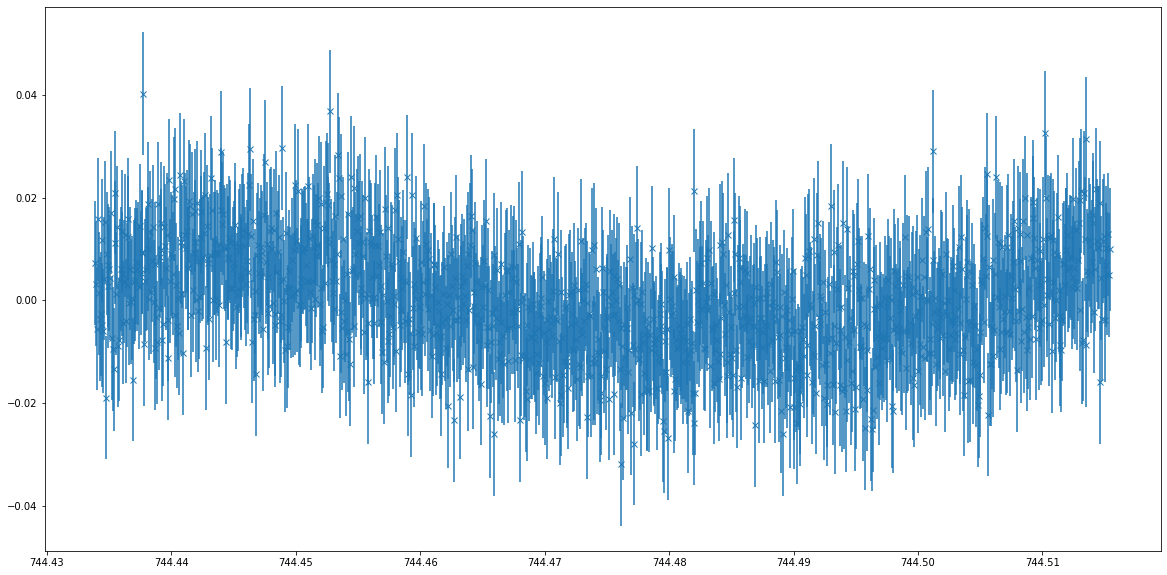

In [9]:
plt.figure(figsize=(20,10))
plt.errorbar(timeLT,revFluxLT,yerr=errorLT, marker='x',ls='')

In [12]:

dat = np.array([timeAll,fluxAll])

dat = dat.T

np.savetxt('AllLTDat.dat', dat, delimiter = '\t')

In [10]:
print(timeAll)

[744.43391052 744.43397952 744.43404952 ... 782.43500586 782.43507586
 782.43514586]


In [13]:
1/0.08029867

12.453506390579072

(782.3541930515214, 782.435145861645)

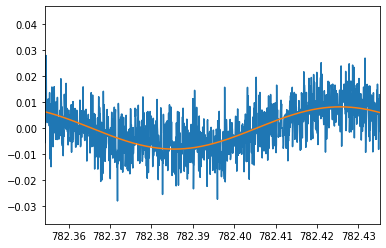

In [14]:
LTModel = 0.0081145596*np.sin((timeAll)*(2*np.pi/0.08029867)+0.307432*2*np.pi)

plt.plot(timeAll,fluxAll)
plt.plot(timeAll, LTModel)
plt.xlim(timeAll[-1160],timeAll[-1])

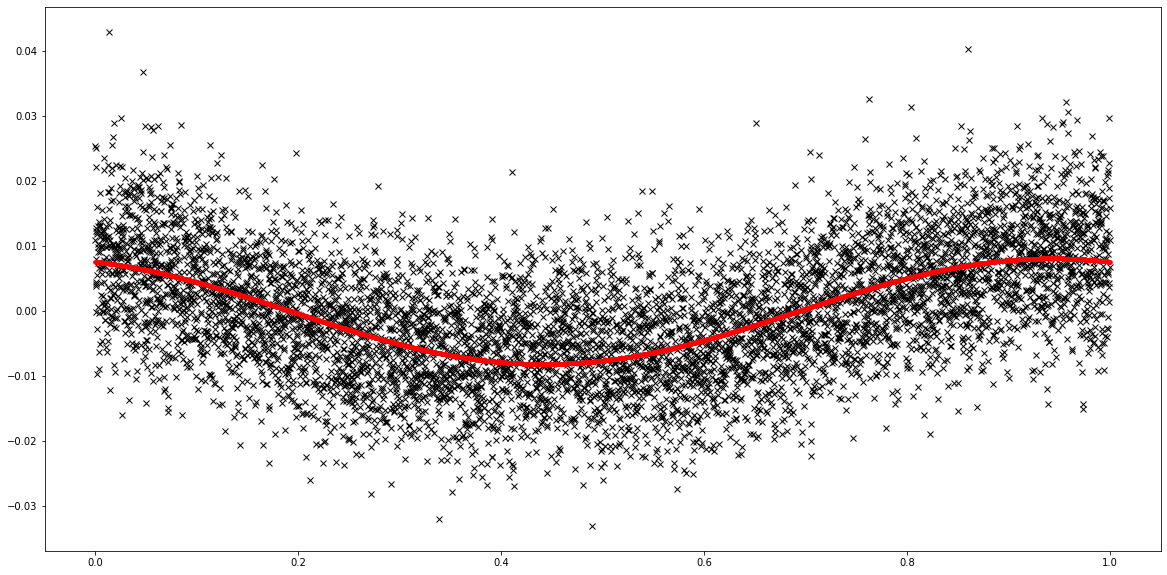

In [15]:
phasesLTAll = foldMeth(timeAll,0.08029867)
sortIndi = np.argsort(phasesLTAll)
phasesLTAll = phasesLTAll[sortIndi]
fluxAllSorted = fluxAll[sortIndi]

phasesLTModel = foldMeth(timeAll,0.08029867)
sortIndi = np.argsort(phasesLTModel)
phasesLTModel = phasesLTModel[sortIndi]
LTModelSorted = LTModel[sortIndi]
plt.figure(figsize=(20,10))
plt.plot(phasesLTAll, fluxAllSorted, 'kx')
plt.plot(phasesLTModel, LTModelSorted , 'r.')

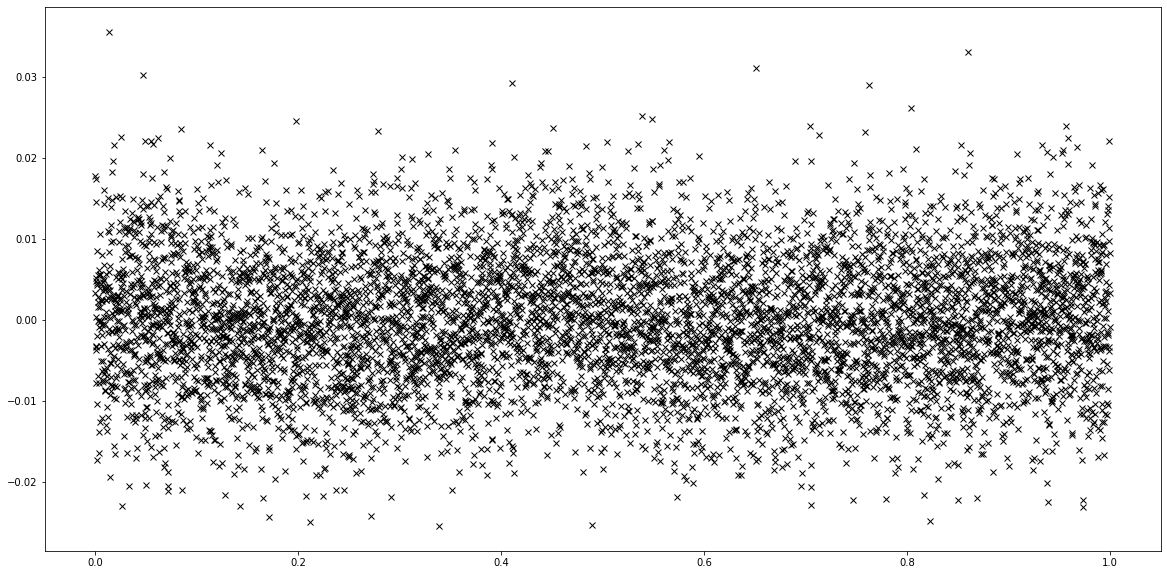

In [16]:
allRes = fluxAllSorted - LTModelSorted
plt.figure(figsize=(20,10))
plt.plot(phasesLTAll, allRes, 'kx')

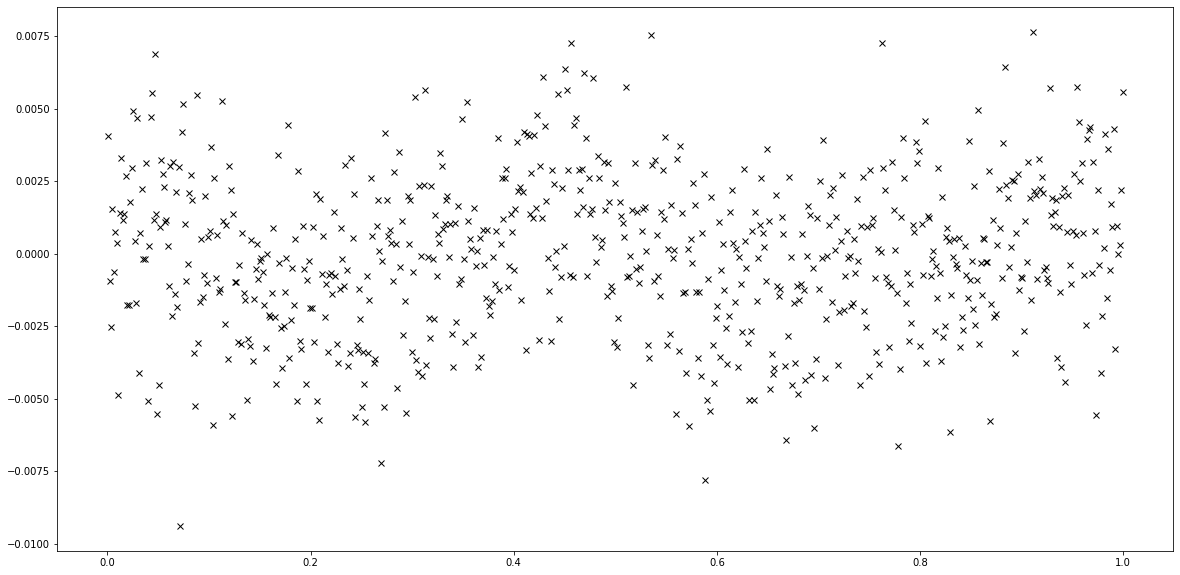

In [17]:
meanResAll = np.nanmean(np.pad(allRes.astype(float), (0, 10 - allRes.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
meanPhasesLTAll = np.nanmean(np.pad(phasesLTAll.astype(float), (0, 10 - phasesLTAll.size%10), mode='constant', constant_values=np.NaN).reshape(-1, 10), axis=1)
plt.figure(figsize=(20,10))
plt.plot(meanPhasesLTAll, meanResAll, 'kx')

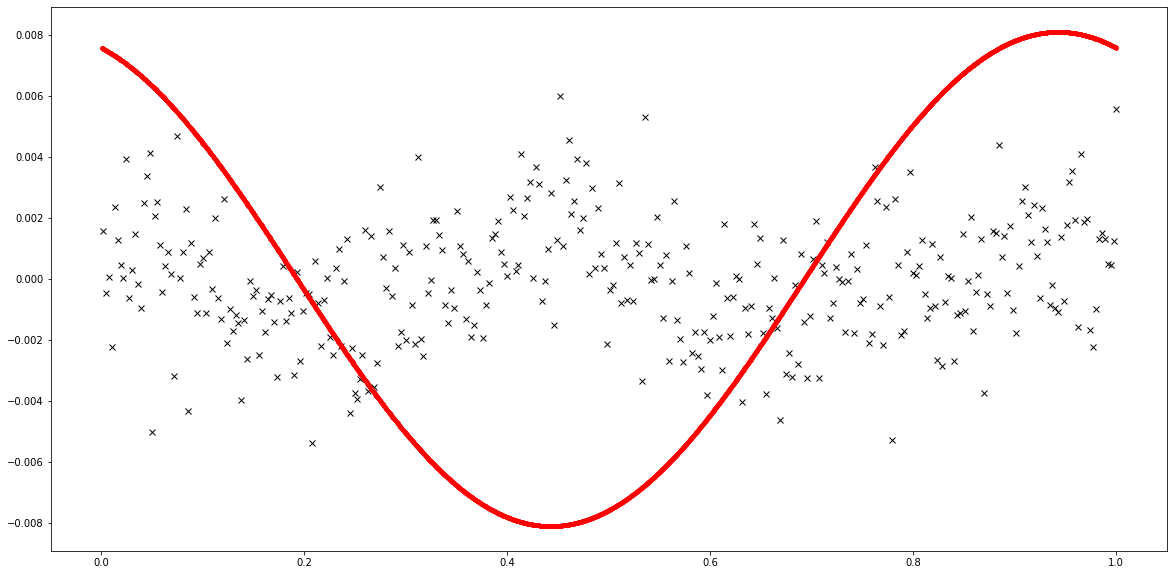

In [18]:
meanResAll = np.nanmean(np.pad(allRes.astype(float), (0, 20 - allRes.size%20), mode='constant', constant_values=np.NaN).reshape(-1, 20), axis=1)
meanPhasesLTAll = np.nanmean(np.pad(phasesLTAll.astype(float), (0, 20 - phasesLTAll.size%20), mode='constant', constant_values=np.NaN).reshape(-1, 20), axis=1)
plt.figure(figsize=(20,10))
plt.plot(meanPhasesLTAll, meanResAll, 'kx')
plt.plot(phasesLTModel, LTModelSorted , 'r.')

In [20]:
TESSStackTime[0]
TESSStackPhot

2458738.651585462

In [19]:

dat = np.array([TESSStackTime-2457000- 1296.0255697684468,TESSStackPhot])

dat = dat.T

np.savetxt('AllTessDat.dat', dat, delimiter = '\t')

In [24]:
1/0.08029867

12.453506390579072

(738.8290347752056, 739.1095842273801)

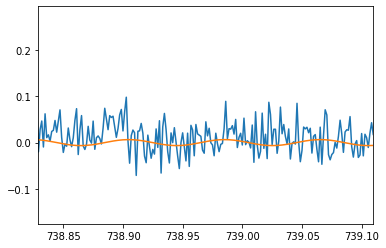

In [34]:
TessModel = 0.00646017383*np.sin((TESSStackTime-2457000- 1296.0255697684468)*(2*np.pi/0.08029867)+0.296568*2*np.pi)

plt.plot(TESSStackTime-2457000- 1296.0255697684468,TESSStackPhot)
plt.plot(TESSStackTime-2457000- 1296.0255697684468, TessModel)
plt.xlim(TESSStackTime[-200]-2457000- 1296.0255697684468,TESSStackTime[-1]-2457000- 1296.0255697684468)

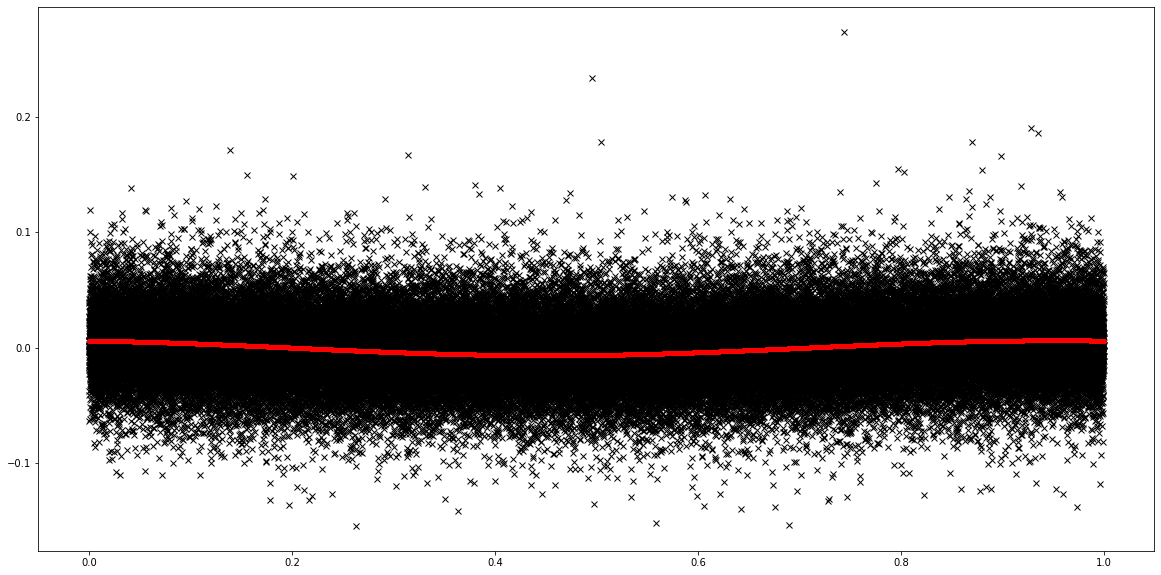

In [35]:
phasesTessAll = foldMeth(TESSStackTime-2457000- 1296.0255697684468,0.08029867)
sortIndi = np.argsort(phasesTessAll)
phasesTessAll = phasesTessAll[sortIndi]
TESSStackPhotSorted = TESSStackPhot[sortIndi]

phasesTessModel = foldMeth(TESSStackTime-2457000- 1296.0255697684468,0.08029867)
sortIndi = np.argsort(phasesTessModel)
phasesTessModel = phasesTessModel[sortIndi]
TessModelSorted = TessModel[sortIndi]
plt.figure(figsize=(20,10))
plt.plot(phasesTessAll, TESSStackPhotSorted, 'kx')
plt.plot(phasesTessModel, TessModelSorted , 'r.')

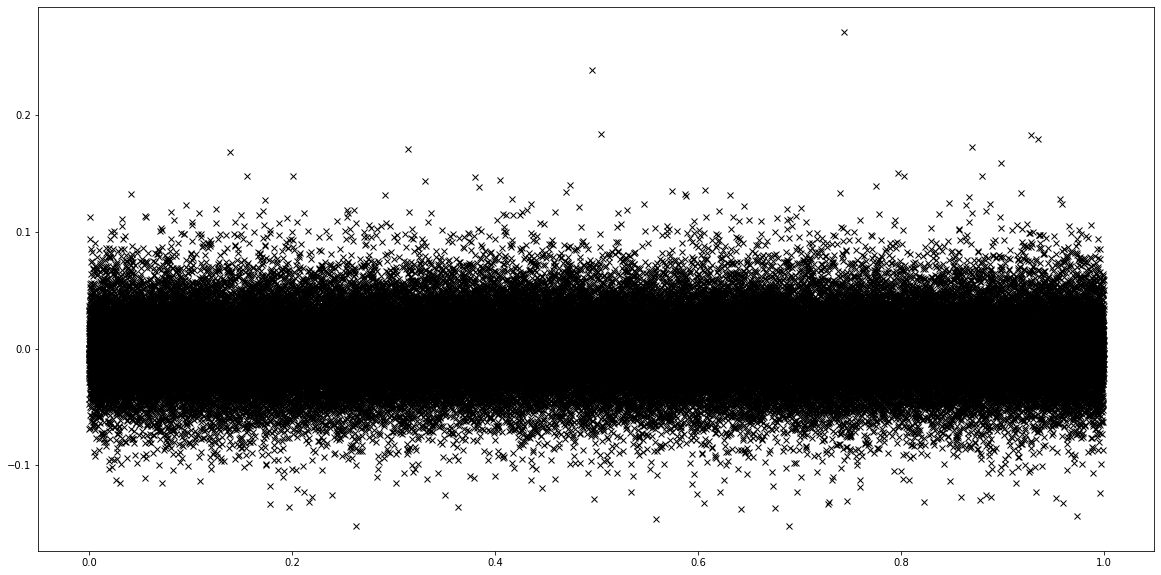

In [36]:
allResTESS = TESSStackPhotSorted - TessModelSorted
plt.figure(figsize=(20,10))
plt.plot(phasesTessAll, allResTESS, 'kx')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


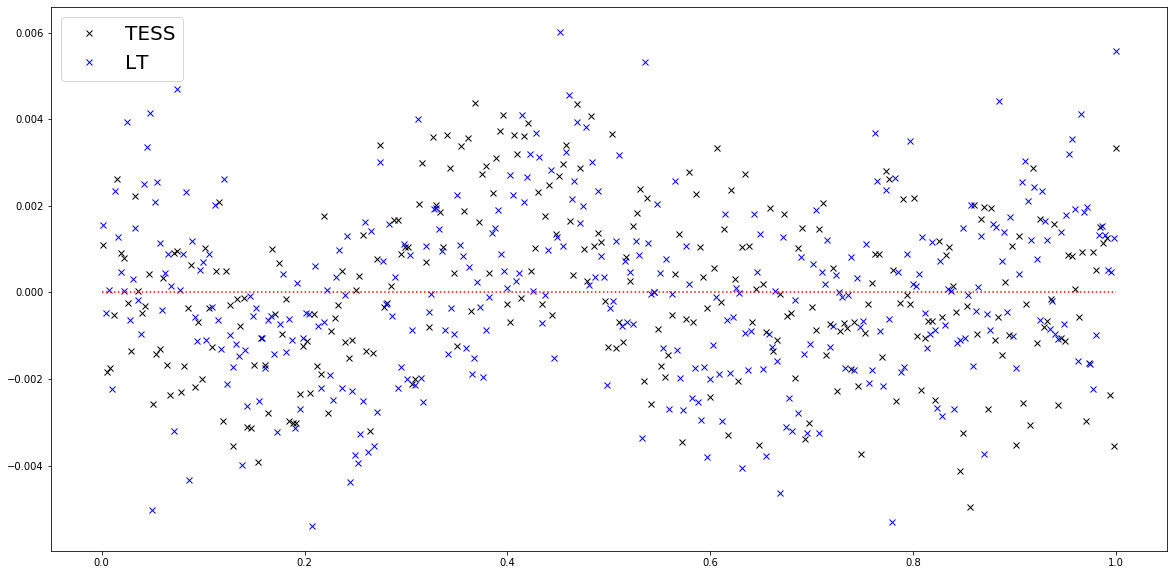

In [37]:
meanallResTESS = np.nanmean(np.pad(allResTESS.astype(float), (0, 300 - allResTESS.size%300), mode='constant', constant_values=np.NaN).reshape(-1, 300), axis=1)
meanphasesTessAll = np.nanmean(np.pad(phasesTessAll.astype(float), (0, 300 - phasesTessAll.size%300), mode='constant', constant_values=np.NaN).reshape(-1, 300), axis=1)
plt.figure(figsize=(20,10))
plt.plot(meanphasesTessAll, meanallResTESS, 'kx', label='TESS')
plt.plot(meanPhasesLTAll, meanResAll, 'bx', label='LT')
plt.legend(prop={'size': 20})
plt.plot([0,1],[0,0],'r:')
plt.savefig('residuals.eps')

In [38]:
LTResiduals = LTModel - fluxAll



dat = np.array([timeAll,LTResiduals])

dat = dat.T

#np.savetxt('LTResiduals.dat', dat, delimiter = '\t')


TESSResiduals = TessModel - TESSStackPhot
dat = np.array([TESSStackTime,TESSResiduals])

dat = dat.T

#np.savetxt('TessResiduals.dat', dat, delimiter = '\t')

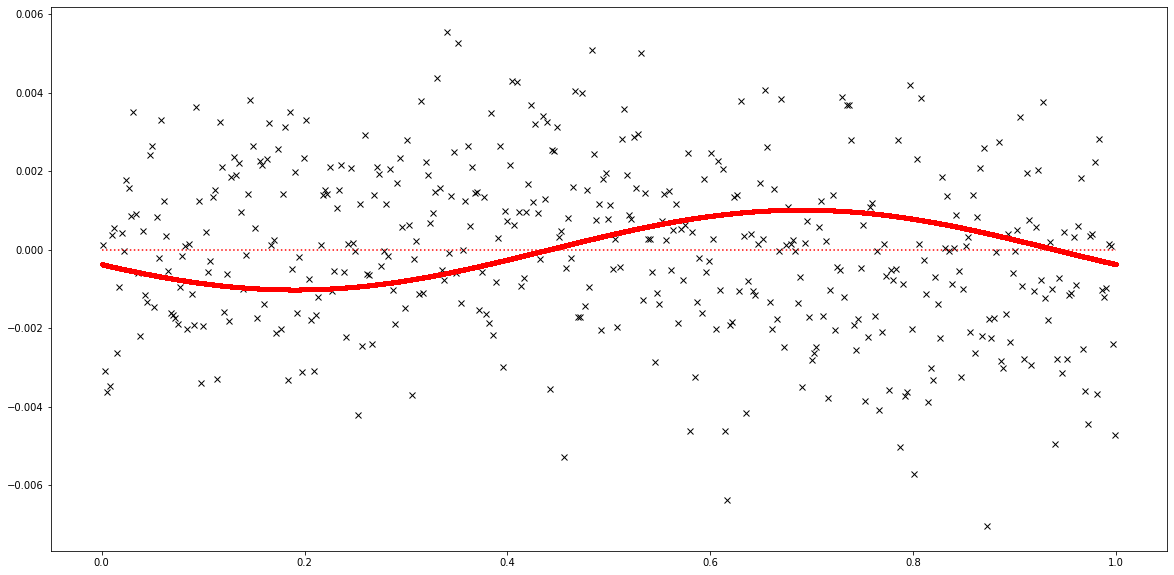

In [39]:
TessModelRes = 0.00101647801*np.sin((TESSStackTime-2457000- 1296.0255697684468)*(2*np.pi*24.9070656)+0.559942*2*np.pi)

phasesTessResAll = foldMeth(TESSStackTime-2457000- 1296.0255697684468,1/24.9070656)
sortIndi = np.argsort(phasesTessResAll)
phasesTessResAll = phasesTessResAll[sortIndi]
TESSStackResSorted = TESSResiduals[sortIndi]

phasesTessResModel = foldMeth(TESSStackTime-2457000- 1296.0255697684468,1/24.9070656)
sortIndi = np.argsort(phasesTessResModel)
phasesTessResModel = phasesTessResModel[sortIndi]
TessModelResSorted = TessModelRes[sortIndi]
plt.figure(figsize=(20,10))

phasesTessResAllMean = np.nanmean(np.pad(phasesTessResAll.astype(float), (0, 200 - phasesTessResAll.size%200), mode='constant', constant_values=np.NaN).reshape(-1, 200), axis=1)
TESSStackResSortedMean = np.nanmean(np.pad(TESSStackResSorted.astype(float), (0, 200 - TESSStackResSorted.size%200), mode='constant', constant_values=np.NaN).reshape(-1, 200), axis=1)


plt.plot(phasesTessResAllMean, TESSStackResSortedMean, 'kx')
plt.plot(phasesTessResModel, TessModelResSorted , 'r.')
plt.plot([0,1],[0,0],'r:')

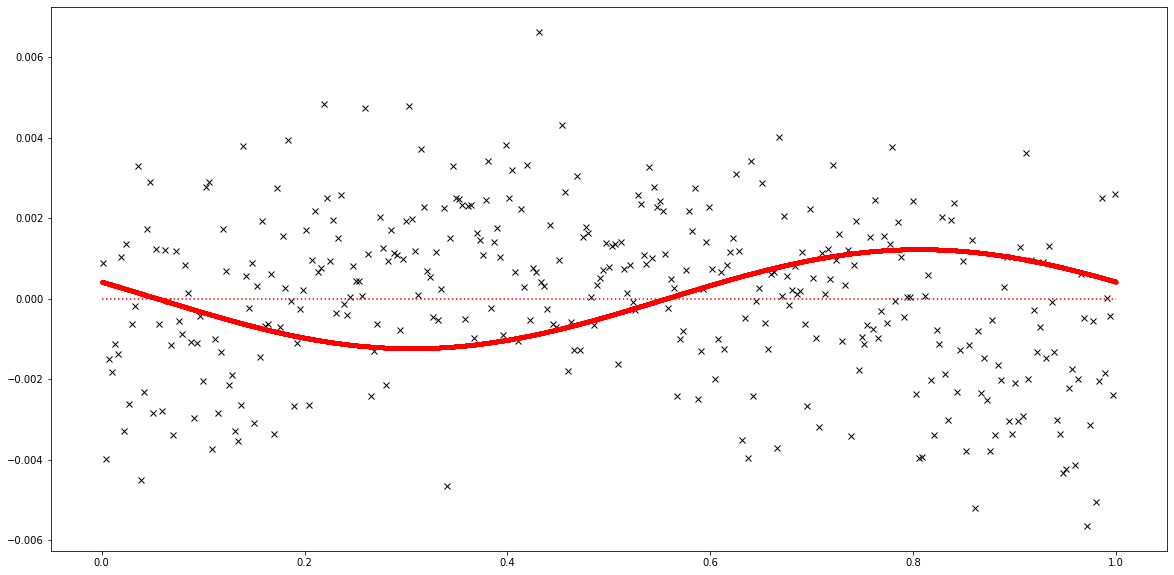

In [40]:




LTModelRes = 0.00123150502*np.sin((timeAll)*(2*np.pi*24.9070656)+0.444464*2*np.pi)

phasesLTResAll = foldMeth(timeAll,1/24.9070656)
sortIndi = np.argsort(phasesLTResAll)
phasesLTResAll = phasesLTResAll[sortIndi]
LTResidualsSorted = LTResiduals[sortIndi]

phasesLTResModel = foldMeth(timeAll,1/24.9070656)
sortIndi = np.argsort(phasesLTResModel)
phasesLTResModel = phasesLTResModel[sortIndi]
LTModelResSorted = LTModelRes[sortIndi]
plt.figure(figsize=(20,10))

phasesLTResAllMean = np.nanmean(np.pad(phasesLTResAll.astype(float), (0, 20 - phasesLTResAll.size%20), mode='constant', constant_values=np.NaN).reshape(-1, 20), axis=1)
LTResidualsSortedMean = np.nanmean(np.pad(LTResidualsSorted.astype(float), (0, 20 - LTResidualsSorted.size%20), mode='constant', constant_values=np.NaN).reshape(-1, 20), axis=1)


plt.plot(phasesLTResAllMean, LTResidualsSortedMean, 'kx')
plt.plot(phasesLTResModel, LTModelResSorted , 'r.')
plt.plot([0,1],[0,0],'r:')

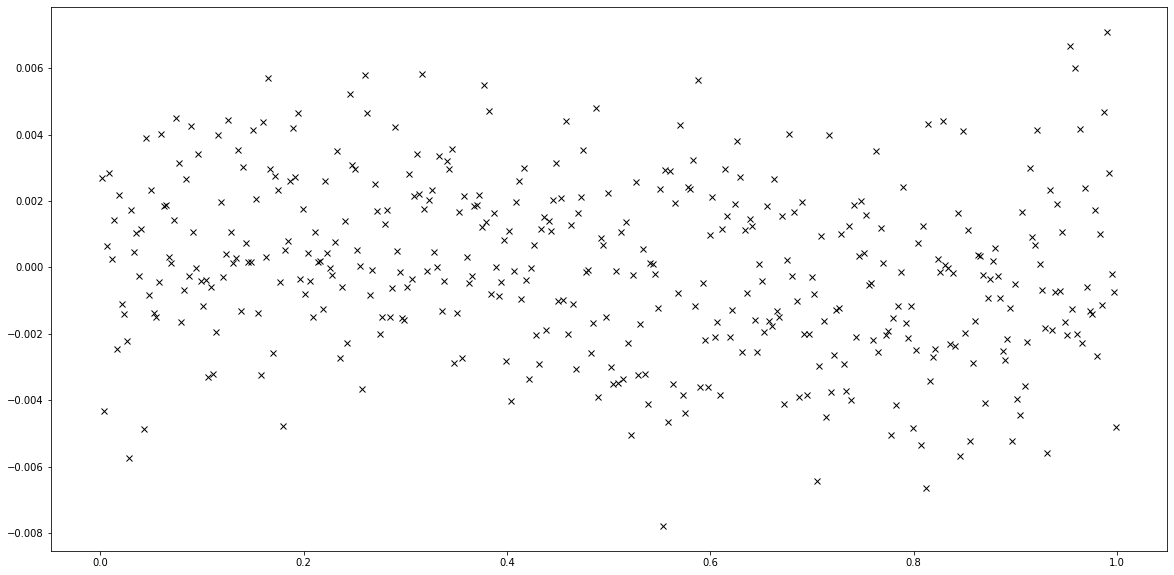

In [39]:
phasesTessDouble = foldMeth(TESSStackTime,1/24.9070656)
sortIndi = np.argsort(phasesTessDouble)
phasesTessDouble = phasesTessDouble[sortIndi]
TESSStackPhotSor = TESSStackPhot[sortIndi]

TESSStackPhotSorMean = np.nanmean(np.pad(TESSStackPhotSor.astype(float), (0, 200 - TESSStackPhotSor.size%200), mode='constant', constant_values=np.NaN).reshape(-1, 200), axis=1)
phasesTessDoubleMean = np.nanmean(np.pad(phasesTessDouble.astype(float), (0, 200 - phasesTessDouble.size%200), mode='constant', constant_values=np.NaN).reshape(-1, 200), axis=1)

plt.figure(figsize=(20,10))
plt.plot(phasesTessDoubleMean,TESSStackPhotSorMean,'kx')

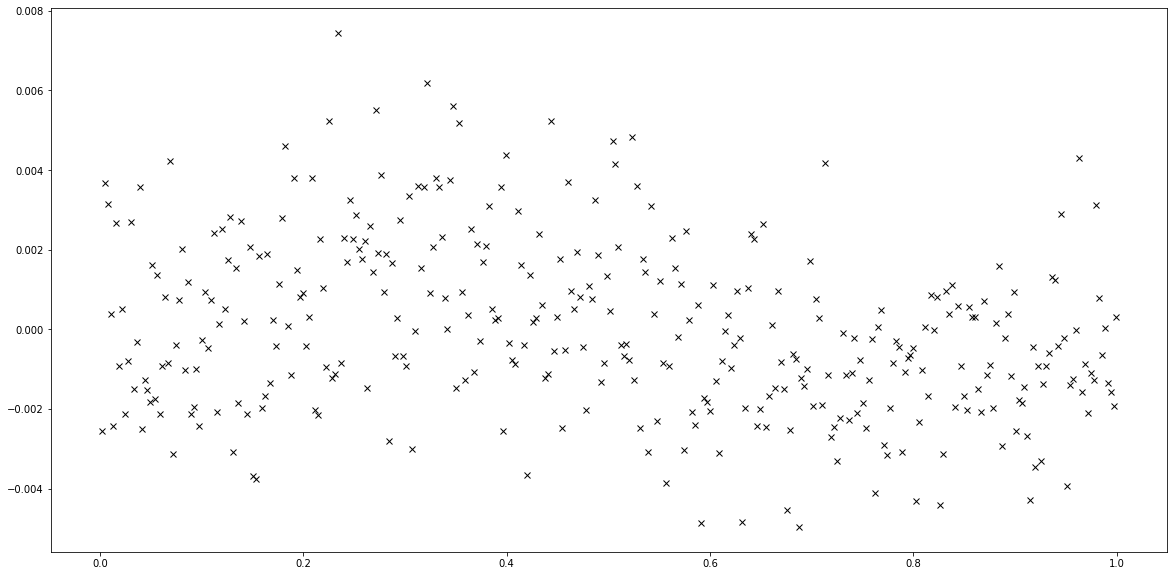

In [40]:
phasesLTDouble = foldMeth(timeAll,1/24.9070656)
sortIndi = np.argsort(phasesLTDouble)
phasesLTDouble = phasesLTDouble[sortIndi]
fluxAllSorted = fluxAll[sortIndi]

fluxAllSortedMean = np.nanmean(np.pad(fluxAllSorted.astype(float), (0, 20 - fluxAllSorted.size%20), mode='constant', constant_values=np.NaN).reshape(-1, 20), axis=1)
phasesLTDoubleMean = np.nanmean(np.pad(phasesLTDouble.astype(float), (0, 20 - phasesLTDouble.size%20), mode='constant', constant_values=np.NaN).reshape(-1, 20), axis=1)

plt.figure(figsize=(20,10))
plt.plot(phasesLTDoubleMean,fluxAllSortedMean,'kx')

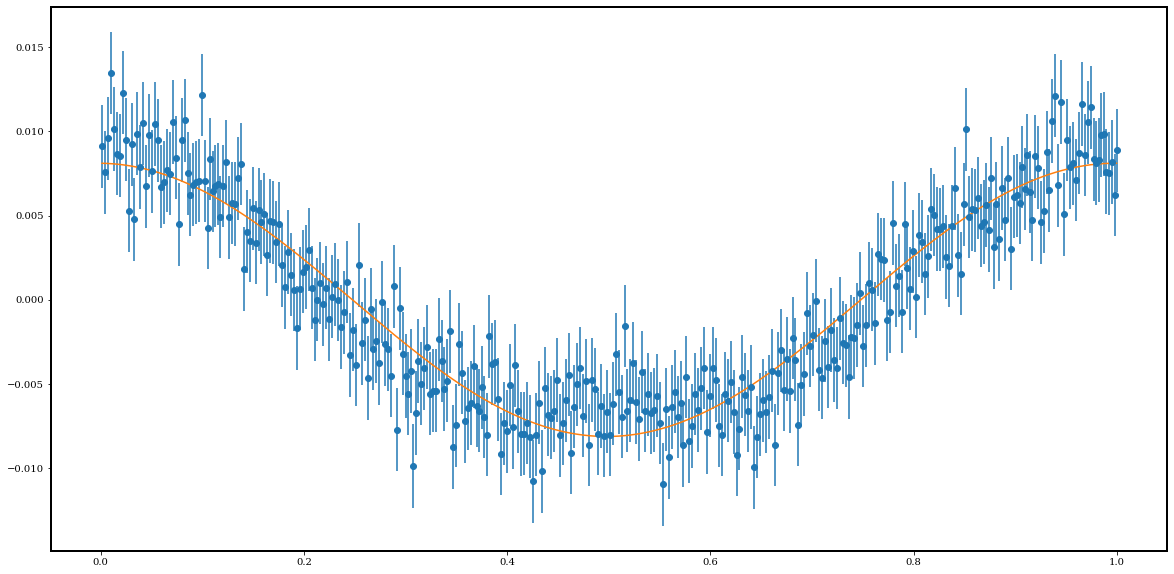

In [10]:
phasesLTAll = foldMeth(timeAll,0.08029820145279275)
sortIndi = np.argsort(phasesLTAll)
phasesLTAll = phasesLTAll[sortIndi]
fluxAllSorted = fluxAll[sortIndi]
errorAllSorted = errorAll[sortIndi]
#LTModel = 
ModelLT = 0.00811455943*np.sin((timeAll)*(2*np.pi/0.08029820145279275)+0.252218*2*np.pi)
modelSorted = ModelLT[sortIndi]
meanFlux = np.nanmean(np.pad(fluxAllSorted.astype(float), (0, 20 - fluxAllSorted.size%20), mode='constant', constant_values=np.NaN).reshape(-1, 20), axis=1)
meanPhase = np.nanmean(np.pad(phasesLTAll.astype(float), (0, 20 - phasesLTAll.size%20), mode='constant', constant_values=np.NaN).reshape(-1, 20), axis=1)
meanErr = np.nanmean(np.pad(errorAllSorted.astype(float), (0, 20 - errorAllSorted.size%20), mode='constant', constant_values=np.NaN).reshape(-1, 20), axis=1)
meanModel = np.nanmean(np.pad(modelSorted.astype(float), (0, 20 - modelSorted.size%20), mode='constant', constant_values=np.NaN).reshape(-1, 20), axis=1)
meanErr = meanErr/np.sqrt(20)
plt.figure(figsize=(20,10))
plt.errorbar(meanPhase,meanFlux,yerr=meanErr,marker='o',ls='')
plt.plot(meanPhase,meanModel)

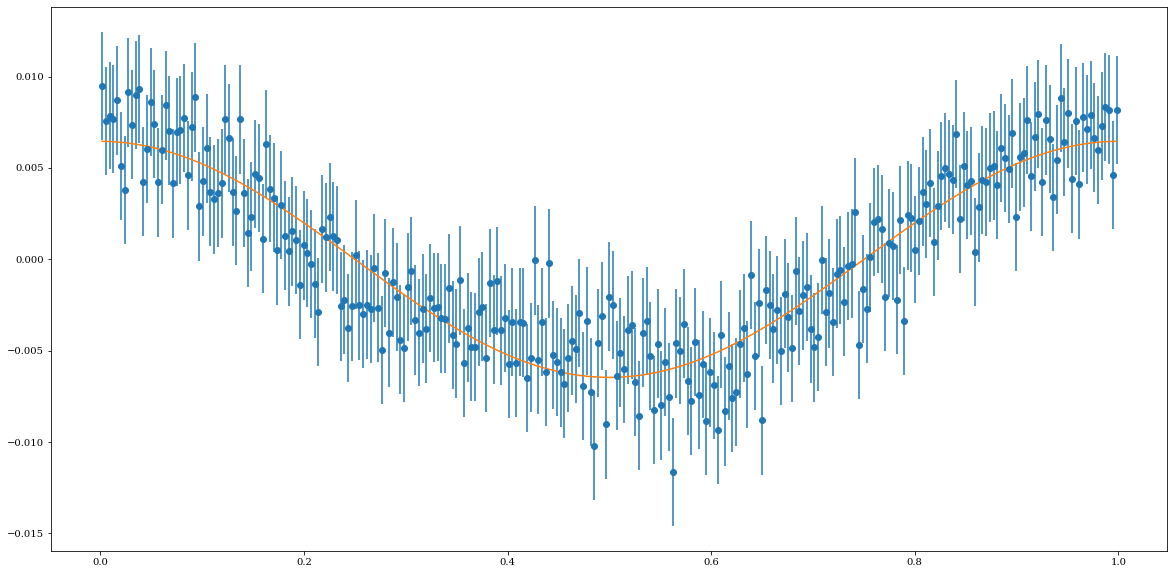

In [5]:
phasesTessAll = foldMeth(TESSStackTime-2457000- 1296.0255697684468,0.08029820145279275)
sortIndi = np.argsort(phasesTessAll)
phasesTessAll = phasesTessAll[sortIndi]
TESSStackPhotSorted = TESSStackPhot[sortIndi]
TESSStackErrSorted = TESSStackErr[sortIndi]
TessModel = 0.00646017384*np.sin((TESSStackTime-2457000- 1296.0255697684468)*(2*np.pi/0.08029820145279275)+0.249999*2*np.pi)
TessModelSorted = TessModel[sortIndi]
meanFluxT = np.nanmean(np.pad(TESSStackPhotSorted.astype(float), (0, 300 - TESSStackPhotSorted.size%300), mode='constant', constant_values=np.NaN).reshape(-1, 300), axis=1)
meanPhaseT = np.nanmean(np.pad(phasesTessAll.astype(float), (0, 300 - phasesTessAll.size%300), mode='constant', constant_values=np.NaN).reshape(-1, 300), axis=1)
meanErrT = np.nanmean(np.pad(TESSStackErrSorted.astype(float), (0, 300 - TESSStackErrSorted.size%300), mode='constant', constant_values=np.NaN).reshape(-1, 300), axis=1)
TessModelSortedMean = np.nanmean(np.pad(TessModelSorted.astype(float), (0, 300 - TessModelSorted.size%300), mode='constant', constant_values=np.NaN).reshape(-1, 300), axis=1)
meanErrT = meanErrT/np.sqrt(300)
plt.figure(figsize=(20,10))
plt.errorbar(meanPhaseT,meanFluxT,yerr=meanErrT,marker='o',ls='')
plt.plot(meanPhaseT,TessModelSortedMean)






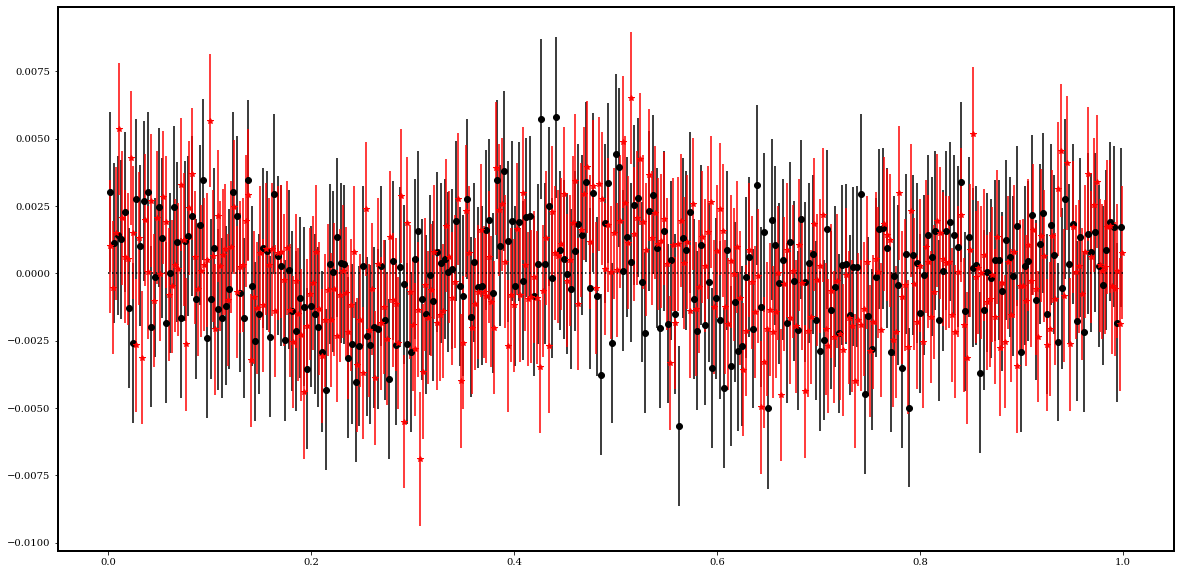

In [19]:
plt.figure(figsize=(20,10))

plt.errorbar(meanPhaseT,meanFluxT-TessModelSortedMean,yerr=meanErrT,marker='o',ls='',c='k')
plt.errorbar(meanPhase,meanFlux-meanModel,yerr=meanErr,marker='*',ls='',c='r')
plt.plot([0,1],[0,0],'k:')

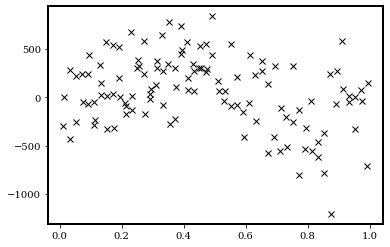

In [44]:
plt.plot(MayKeep2019[0],MayKeep2019[1],'kx')

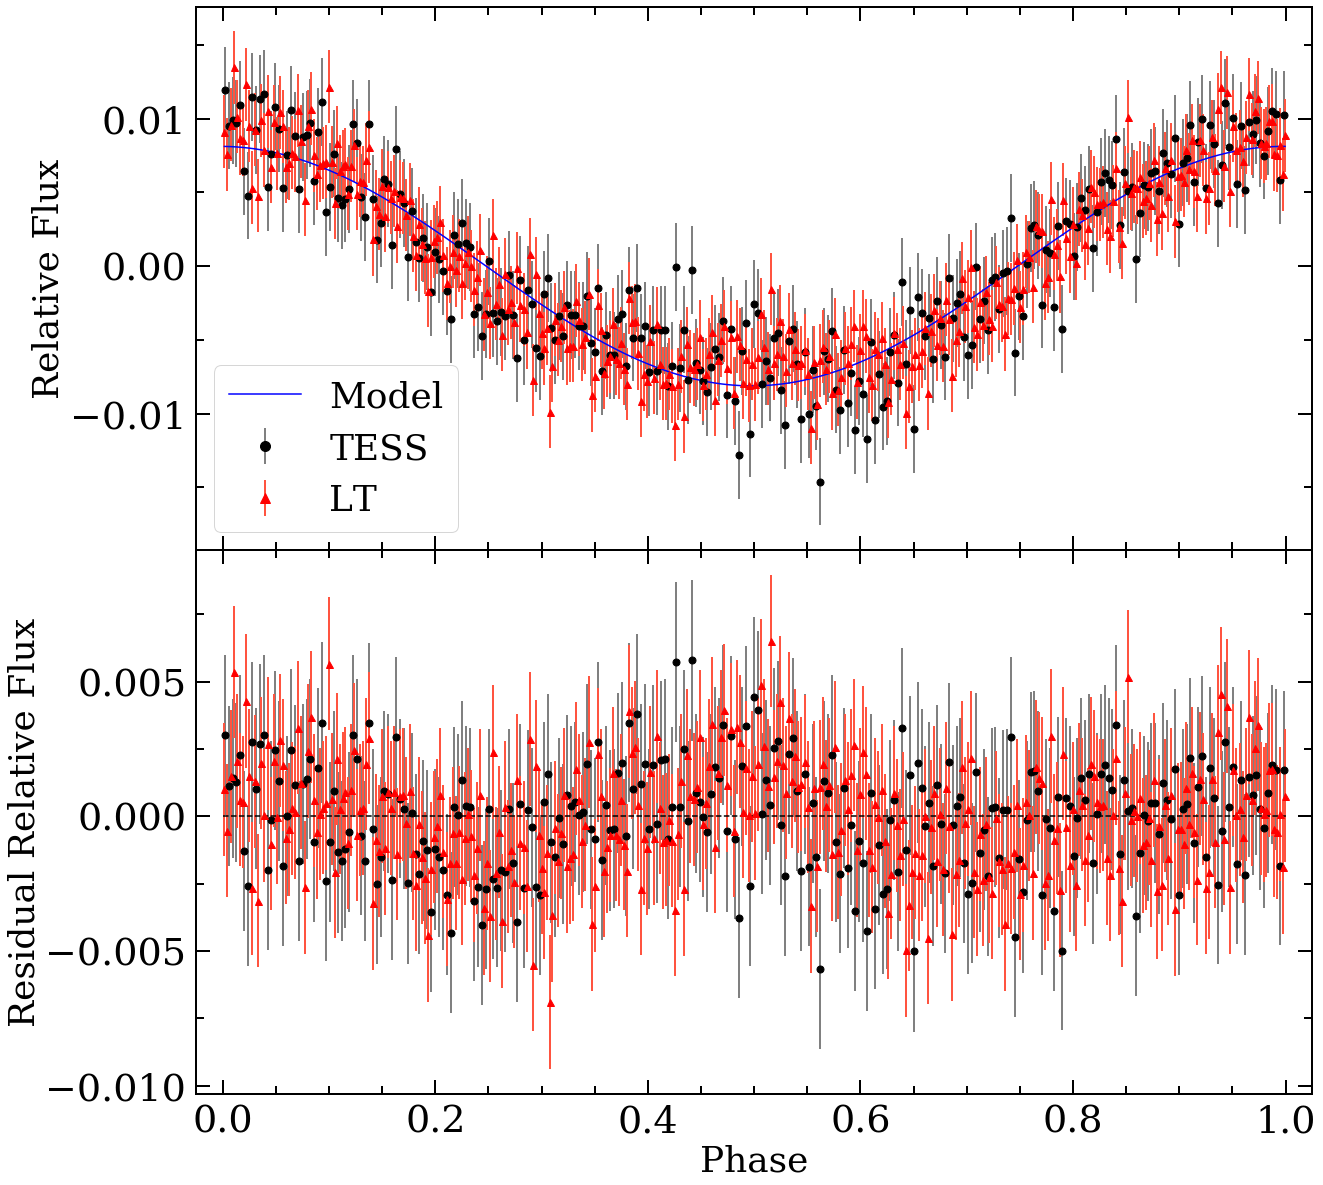

In [45]:
#30

from pylab import rc
from matplotlib import transforms
rc('axes', linewidth=2)

fig, axs = plt.subplots(2, 1,
                        gridspec_kw={'hspace': 0., 'wspace': 0}, figsize=(20,20))



#axs[0].plot(meanPhaseT, 1.25608994912*TessModelSortedMean, c='b', label='Model')
axs[0].plot(meanPhase, meanModel, c='b', label='Model')
axs[0].errorbar(meanPhaseT,1.25608994912*meanFluxT,yerr=meanErrT,marker='o',ls='',c='k',ecolor='gray',ms=7,elinewidth=2)
axs[0].errorbar(meanPhase, meanFlux, yerr=meanErr, c='r', lw=1, marker='^',ecolor=r'#ff5440', ls = '',ms=7,elinewidth=2)

axs[1].errorbar(meanPhaseT,meanFluxT-TessModelSortedMean,yerr=meanErrT,marker='o',ms=7,ecolor='gray',ls='',c='k',label='TESS',elinewidth=2)
axs[1].errorbar(meanPhase,meanFlux-meanModel,yerr=meanErr,marker='^',ls='',c='r',ms=7,ecolor=r'#ff5440',label='LT',elinewidth=2)
axs[1].plot([0,1],[0,0],'k--')
xlimits = axs[0].set_xlim()
axs[0].errorbar([-0.03,-0.03],[0,0],yerr=[0.001,0.001],marker='o',ms=10,ecolor='gray',ls='',c='k',label='TESS',elinewidth=2)
axs[0].errorbar([-0.03,-0.03],[0,0],yerr=[0.001,0.001], c='r', lw=1, marker='^',ecolor=r'#ff5440', ls = '', label='LT',ms=10,elinewidth=2)
axs[0].set_xlim(xlimits)
#samePhaseM = np.load('samePhaseM.npy')
#samePhaseME = np.load('samePhaseME.npy')
#timeBMAdj = np.array(timeBM)-2457000 - 1296.0255697684468 -  (0.08029820145279275*4015)
#WHTVelocityPhaseM = foldMeth(timeBMAdj,  0.08029820145279275)
#sortIndi = np.argsort(WHTVelocityPhaseM)
#WHTVelocityPhaseM = WHTVelocityPhaseM[sortIndi]
#samePhaseM = samePhaseM[sortIndi]
#samePhaseME = samePhaseME[sortIndi]
#ewModel = 0.20*np.sin((timeBMAdj)*(2*np.pi/0.08029820145279275)+0.752218*2*np.pi)+1

#ewModel = ewModel[sortIndi]
#samePhaseMM = samePhaseM - ewModel
#axs[2].errorbar(WHTVelocityPhaseM, samePhaseM, yerr=samePhaseME,  ls='',c='r',lw=1, marker='o',ecolor='grey',ms=10,elinewidth=2)
#axs[2].errorbar(WHTVelocityPhaseM, samePhaseMM, yerr=samePhaseME,  ls='',c='b',lw=1, marker='o',ecolor='grey',ms=10,elinewidth=2)


#axs[2].errorbar(WHTVelocityPhaseM, ewModel)

axs[0].legend(prop={'size': 36})

#axs[2].legend(prop={'size': 30})
axs[1].set_xlabel("Phase", fontsize=36)
axs[0].set_ylabel('Relative Flux', fontsize=36)
axs[1].set_ylabel('Residual Relative Flux', fontsize=36)
#ax.xaxis.set_label_coords(1.0, -0.1)
#ax.set_xlim(0,1)
#ax2.set_xlim(6250,7200)

#ax.set_ylim(0.9,1.12)
axs[0].set_xlim(-0.025,1.025)
axs[1].set_xlim(-0.025,1.025)


#ax.yaxis.tick_left()
#ax.tick_params(labelright='off')
#ax2.tick_params(labelright='on')
#ax2.yaxis.tick_right()
#ax2.yaxis.set_label_position("right")


#ax.set_yticks(np.arange(0.9, 1.12, 0.05))
#ax2.set_yticks(np.arange(0.9, 1.12, 0.05))
axs[0].xaxis.set_minor_locator(AutoMinorLocator()) #
axs[0].yaxis.set_major_locator(MultipleLocator(0.01))
axs[0].yaxis.set_minor_locator(MultipleLocator(0.005))
axs[1].xaxis.set_minor_locator(AutoMinorLocator())
axs[1].yaxis.set_minor_locator(MultipleLocator(0.0025))
axs[1].yaxis.set_major_locator(MultipleLocator(0.005))
#ax2.xaxis.set_minor_locator(AutoMinorLocator())
#ax.yaxis.set_minor_locator(AutoMinorLocator())
axs[0].tick_params(which='both', width=2,direction='in',pad=10)
axs[1].tick_params(which='both', width=2,direction='in',pad=10)

axs[0].tick_params(which='major', length=14)
axs[1].tick_params(which='major', length=14)

axs[0].tick_params(which='minor', length=8)
axs[1].tick_params(which='minor', length=8)
#ax2.tick_params(which='major', length=14)
#ax2.tick_params(which='minor', length=8)
axs[0].tick_params(labelsize=38)
axs[1].tick_params(labelsize=38)

axs[0].xaxis.set_ticks_position('both')
axs[1].xaxis.set_ticks_position('both')
#ax2.tick_params(labelsize=23)
#fig.Bbox([[0,0],[100,100]])
axs[0].xaxis.set_ticks_position('both')
axs[1].xaxis.set_ticks_position('both')
axs[0].yaxis.set_ticks_position('both')
axs[1].yaxis.set_ticks_position('both')
axs[0].set_xticklabels([])

bboxx = transforms.Bbox([[-0.16, 1.38], [18.04, 17.65]])
#plt.savefig('Residuals.pdf',bbox_inches=bboxx) 
plt.show()

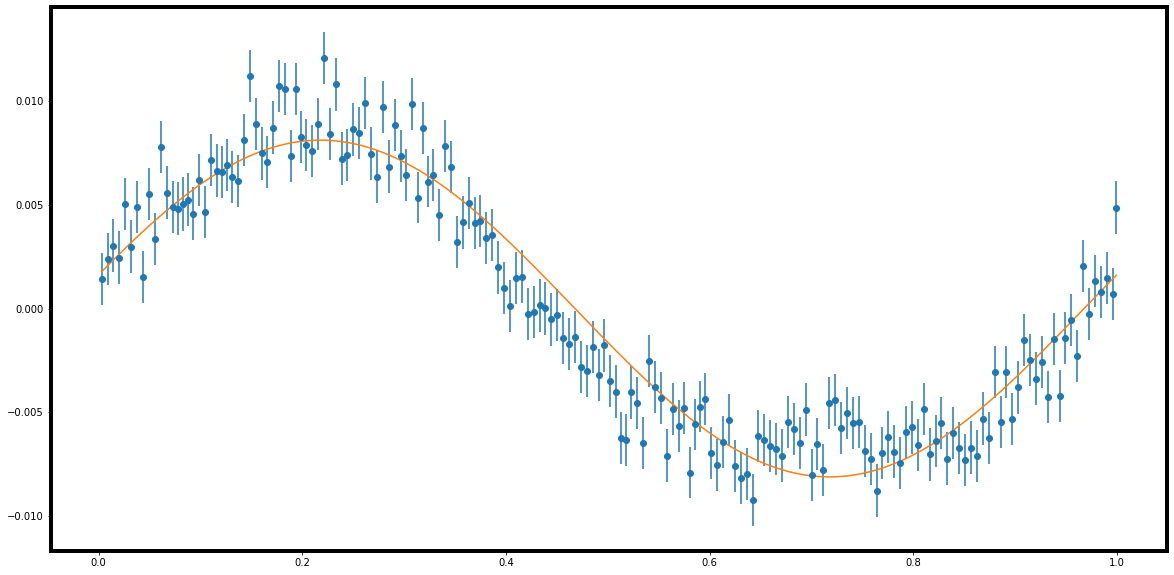

In [69]:
phasesLTAll = foldMeth(timeAll,0.08029867)
sortIndi = np.argsort(phasesLTAll)
phasesLTAll = phasesLTAll[sortIndi]
fluxAllSorted = fluxAll[sortIndi]
errorAllSorted = errorAll[sortIndi]
ModelLT = 0.00811455943*np.sin((timeAll)*(2*np.pi/0.08029867)+0.032148*2*np.pi)
modelSorted = ModelLT[sortIndi]
meanFlux = np.nanmean(np.pad(fluxAllSorted.astype(float), (0, 40 - fluxAllSorted.size%40), mode='constant', constant_values=np.NaN).reshape(-1, 40), axis=1)
meanPhase = np.nanmean(np.pad(phasesLTAll.astype(float), (0, 40 - phasesLTAll.size%40), mode='constant', constant_values=np.NaN).reshape(-1, 40), axis=1)
meanErr = np.nanmean(np.pad(errorAllSorted.astype(float), (0, 40 - errorAllSorted.size%40), mode='constant', constant_values=np.NaN).reshape(-1, 40), axis=1)
meanModel = np.nanmean(np.pad(modelSorted.astype(float), (0, 40 - modelSorted.size%40), mode='constant', constant_values=np.NaN).reshape(-1, 40), axis=1)
meanErr = meanErr/np.sqrt(40)
plt.figure(figsize=(20,10))
plt.errorbar(meanPhase,meanFlux,yerr=meanErr,marker='o',ls='')
plt.plot(meanPhase,meanModel)

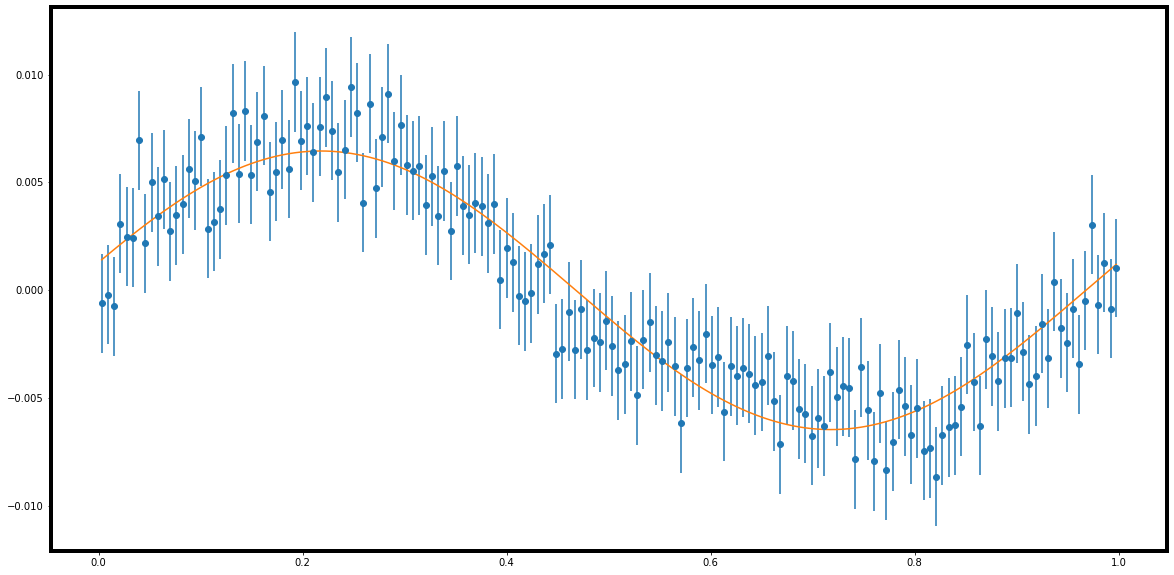

In [68]:
phasesTessAll = foldMeth(TESSStackTime,0.08029867)
sortIndi = np.argsort(phasesTessAll)
phasesTessAll = phasesTessAll[sortIndi]
TESSStackPhotSorted = TESSStackPhot[sortIndi]
TESSStackErrSorted = TESSStackErr[sortIndi]
TessModel = 0.00646017384*np.sin((TESSStackTime)*(2*np.pi/0.08029867)+0.032148*2*np.pi)
TessModelSorted = TessModel[sortIndi]
meanFluxT = np.nanmean(np.pad(TESSStackPhotSorted.astype(float), (0, 500 - TESSStackPhotSorted.size%500), mode='constant', constant_values=np.NaN).reshape(-1, 500), axis=1)
meanPhaseT = np.nanmean(np.pad(phasesTessAll.astype(float), (0, 500 - phasesTessAll.size%500), mode='constant', constant_values=np.NaN).reshape(-1, 500), axis=1)
meanErrT = np.nanmean(np.pad(TESSStackErrSorted.astype(float), (0, 500 - TESSStackErrSorted.size%500), mode='constant', constant_values=np.NaN).reshape(-1, 500), axis=1)
TessModelSortedMean = np.nanmean(np.pad(TessModelSorted.astype(float), (0, 500 - TessModelSorted.size%500), mode='constant', constant_values=np.NaN).reshape(-1, 500), axis=1)
meanErrT = meanErrT/np.sqrt(500)
plt.figure(figsize=(20,10))
plt.errorbar(meanPhaseT,meanFluxT,yerr=meanErrT,marker='o',ls='')
plt.plot(meanPhaseT,TessModelSortedMean)

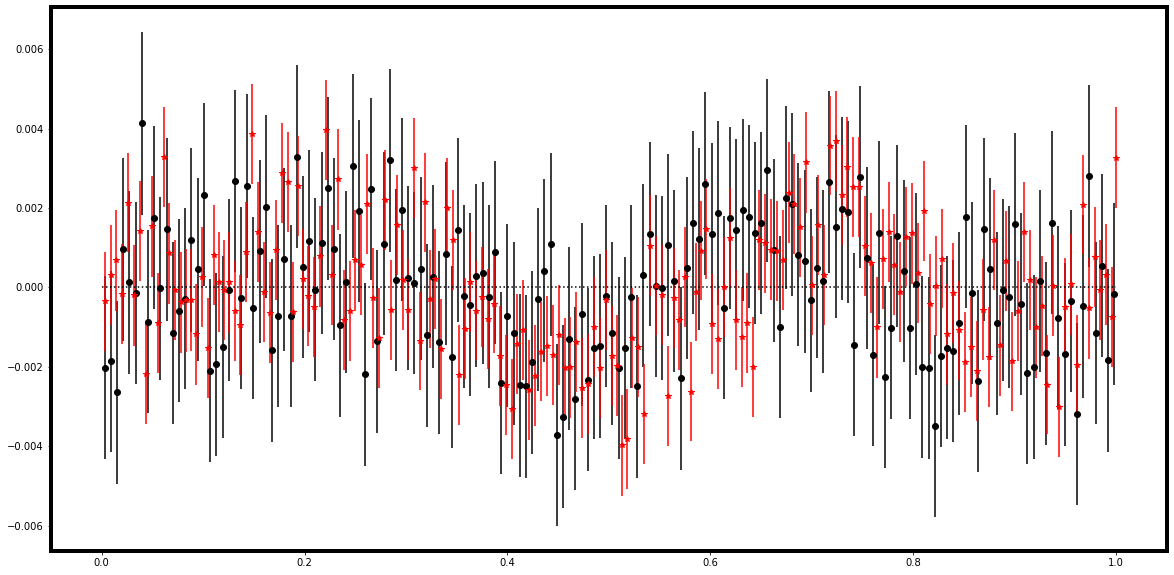

In [70]:
plt.figure(figsize=(20,10))

plt.errorbar(meanPhaseT,meanFluxT-TessModelSortedMean,yerr=meanErrT,marker='o',ls='',c='k')
plt.errorbar(meanPhase,meanFlux-meanModel,yerr=meanErr,marker='*',ls='',c='r')
plt.plot([0,1],[0,0],'k:')

In [4]:
indata = np.loadtxt("fromJohn/gd356-iv-hbeta.dat", usecols=(0,1,2,3))
wavelength = indata[:,0]
intensity = indata[:,1]
circPol = indata[:,2]
delCircPol = indata[:,3]


tr1 = np.loadtxt("fromJohn/moreTr/2p0_4d0.dat", usecols=(0,1,2))
BFieldTra1 = tr1[:,0]
WavelTra1 = tr1[:,1]

tr1 = np.loadtxt("fromJohn/moreTr/2p0_4d1.dat", usecols=(0,1,2))
BFieldTra2 = tr1[:,0]
WavelTra2 = tr1[:,1]

tr1 = np.loadtxt("fromJohn/moreTr/2p0_4d-1.dat", usecols=(0,1,2))
BFieldTra3 = tr1[:,0]
WavelTra3 = tr1[:,1]

tr1 = np.loadtxt("fromJohn/moreTr/2p0_4s0.dat", usecols=(0,1,2))
BFieldTra4 = tr1[:,0]
WavelTra4 = tr1[:,1]

tr1 = np.loadtxt("fromJohn/moreTr/2p1_4d0.dat", usecols=(0,1,2))
BFieldTra5 = tr1[:,0]
WavelTra5 = tr1[:,1]

tr1 = np.loadtxt("fromJohn/moreTr/2p-1_4d0.dat", usecols=(0,1,2))
BFieldTra6 = tr1[:,0]
WavelTra6 = tr1[:,1]

tr1 = np.loadtxt("fromJohn/moreTr/2p1_4d1.dat", usecols=(0,1,2))
BFieldTra7 = tr1[:,0]
WavelTra7 = tr1[:,1]

tr1 = np.loadtxt("fromJohn/moreTr/2p1_4d2.dat", usecols=(0,1,2))
BFieldTra8 = tr1[:,0]
WavelTra8 = tr1[:,1]

tr1 = np.loadtxt("fromJohn/moreTr/2p-1_4d-2.dat", usecols=(0,1,2))
BFieldTra9 = tr1[:,0]
WavelTra9 = tr1[:,1]

tr1 = np.loadtxt("fromJohn/moreTr/2p1_4s0.dat", usecols=(0,1,2))
BFieldTra10 = tr1[:,0]
WavelTra10 = tr1[:,1]

tr1 = np.loadtxt("fromJohn/moreTr/2p-1_4s0.dat", usecols=(0,1,2))
BFieldTra11 = tr1[:,0]
WavelTra11 = tr1[:,1]

tr1 = np.loadtxt("fromJohn/moreTr/2s0_4f0.dat", usecols=(0,1,2))
BFieldTra12 = tr1[:,0]
WavelTra12 = tr1[:,1]

tr1 = np.loadtxt("fromJohn/moreTr/2s0_4f1.dat", usecols=(0,1,2))
BFieldTra13 = tr1[:,0]
WavelTra13 = tr1[:,1]

tr1 = np.loadtxt("fromJohn/moreTr/2s0_4f-1.dat", usecols=(0,1,2))
BFieldTra14 = tr1[:,0]
WavelTra14 = tr1[:,1]

tr1 = np.loadtxt("fromJohn/moreTr/2s0_4p0.dat", usecols=(0,1,2))
BFieldTra15 = tr1[:,0]
WavelTra15 = tr1[:,1]

tr1 = np.loadtxt("fromJohn/moreTr/2s0_4p1.dat", usecols=(0,1,2))
BFieldTra16 = tr1[:,0]
WavelTra16 = tr1[:,1]

tr1 = np.loadtxt("fromJohn/moreTr/2s0_4p-1.dat", usecols=(0,1,2))
BFieldTra17 = tr1[:,0]
WavelTra17 = tr1[:,1]



indataA = np.loadtxt("fromJohn/GD356.dat", usecols=(0,1))
wavelengthA = indataA[:,0]
intensityA = indataA[:,1]
indataA = np.loadtxt("fromJohn/Profiles_001.dat", usecols=(0,3))
wavelengthAA = indataA[:,0]
delCircPolA = indataA[:,1]
tr1 = np.loadtxt("fromJohn/2s0=3p-1.dat", usecols=(0,1))
BFieldTraA1 = tr1[:,0]
WavelTraA1 = tr1[:,1]

tr1 = np.loadtxt("fromJohn/2s0=3p0.dat", usecols=(0,1))
BFieldTraA2 = tr1[:,0]
WavelTraA2 = tr1[:,1]

tr1 = np.loadtxt("fromJohn/2s0=3p1.dat", usecols=(0,1))
BFieldTraA3 = tr1[:,0]
WavelTraA3 = tr1[:,1]

tr1 = np.loadtxt("fromJohn/2p0=3d1.dat", usecols=(0,1))
BFieldTraA4 = tr1[:,0]
WavelTraA4 = tr1[:,1]

tr1 = np.loadtxt("fromJohn/2p0=3d0.dat", usecols=(0,1))
BFieldTraA5 = tr1[:,0]
WavelTraA5 = tr1[:,1]

tr1 = np.loadtxt("fromJohn/2p0=3s0.dat", usecols=(0,1))
BFieldTraA6 = tr1[:,0]
WavelTraA6 = tr1[:,1]

tr1 = np.loadtxt("fromJohn/2p0=3d-1.dat", usecols=(0,1))
BFieldTraA7 = tr1[:,0]
WavelTraA7 = tr1[:,1]

tr1 = np.loadtxt("fromJohn/2p-1=3d-2.dat", usecols=(0,1))
BFieldTraA8 = tr1[:,0]
WavelTraA8 = tr1[:,1]

tr1 = np.loadtxt("fromJohn/2p-1=3d0.dat", usecols=(0,1))
BFieldTraA10 = tr1[:,0]
WavelTraA10 = tr1[:,1]

tr1 = np.loadtxt("fromJohn/2p-1=3s0.dat", usecols=(0,1))
BFieldTraA11 = tr1[:,0]
WavelTraA11 = tr1[:,1]

tr1 = np.loadtxt("fromJohn/2p1=3s0.dat", usecols=(0,1))
BFieldTraA12 = tr1[:,0]
WavelTraA12 = tr1[:,1]

tr1 = np.loadtxt("fromJohn/2p1=3d0.dat", usecols=(0,1))
BFieldTraA13 = tr1[:,0]
WavelTraA13 = tr1[:,1]

tr1 = np.loadtxt("fromJohn/2p1=3d1.dat", usecols=(0,1))
BFieldTraA14 = tr1[:,0]
WavelTraA14 = tr1[:,1]

tr1 = np.loadtxt("fromJohn/2p1=3d2.dat", usecols=(0,1))
BFieldTraA15 = tr1[:,0]
WavelTraA15 = tr1[:,1]

(4200, 5200)

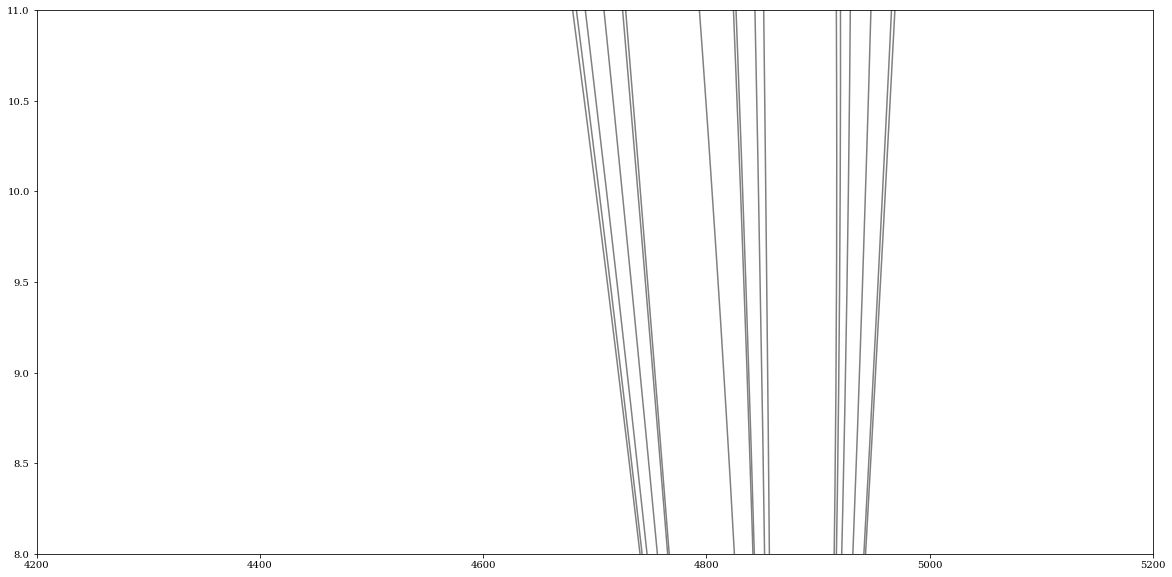

In [5]:
plt.figure(figsize=(20,10))
plt.plot(WavelTra1,BFieldTra1, c='gray')
plt.plot(WavelTra2,BFieldTra2, c='gray')
plt.plot(WavelTra3,BFieldTra3, c='gray')
plt.plot(WavelTra4,BFieldTra4, c='gray')
plt.plot(WavelTra5,BFieldTra5, c='gray')
plt.plot(WavelTra6,BFieldTra6, c='gray')
plt.plot(WavelTra7,BFieldTra7, c='gray') # 2p1_4d1
plt.plot(WavelTra8,BFieldTra8, c='gray')
plt.plot(WavelTra9,BFieldTra9, c='gray')
plt.plot(WavelTra10,BFieldTra10, c='gray')
plt.plot(WavelTra11,BFieldTra11, c='gray')
plt.plot(WavelTra12,BFieldTra12, c='gray')
plt.plot(WavelTra13,BFieldTra13, c='gray')
plt.plot(WavelTra14,BFieldTra14, c='gray')
plt.plot(WavelTra15,BFieldTra15, c='gray')
plt.plot(WavelTra16,BFieldTra16, c='gray')
plt.plot(WavelTra17,BFieldTra17, c='gray')
plt.ylim(8,11)
plt.xlim(4200,5200)

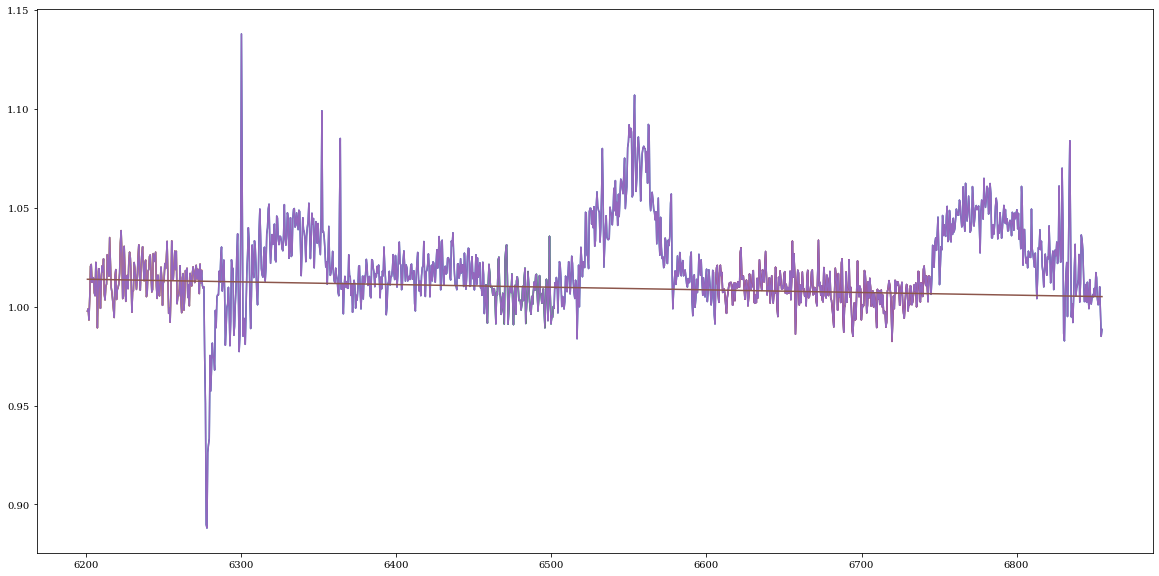

In [6]:
plt.figure(figsize=(20,10))
plt.plot(wavelengthA,intensityA)
plt.plot(wavelengthA[:150],intensityA[:150])
plt.plot(wavelengthA[520:610],intensityA[520:610])
plt.plot(wavelengthA[820:1100],intensityA[820:1100])
#plt.ylim(1,1.05)
wavelengthFit = np.append(wavelengthA[:150],wavelengthA[520:610])
wavelengthFit = np.append(wavelengthFit,wavelengthA[820:1100])
intensityFit = np.append(intensityA[:150],intensityA[520:610])
intensityFit = np.append(intensityFit,intensityA[820:1100])
from scipy.optimize import curve_fit

def f(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

popt, pcov = curve_fit(f, wavelengthFit, intensityFit) # your data x, y to fit
plt.plot(wavelengthA,intensityA)
plt.plot(wavelengthA,f(wavelengthA,*popt))
normedIntensity = intensityA/f(wavelengthA,*popt)

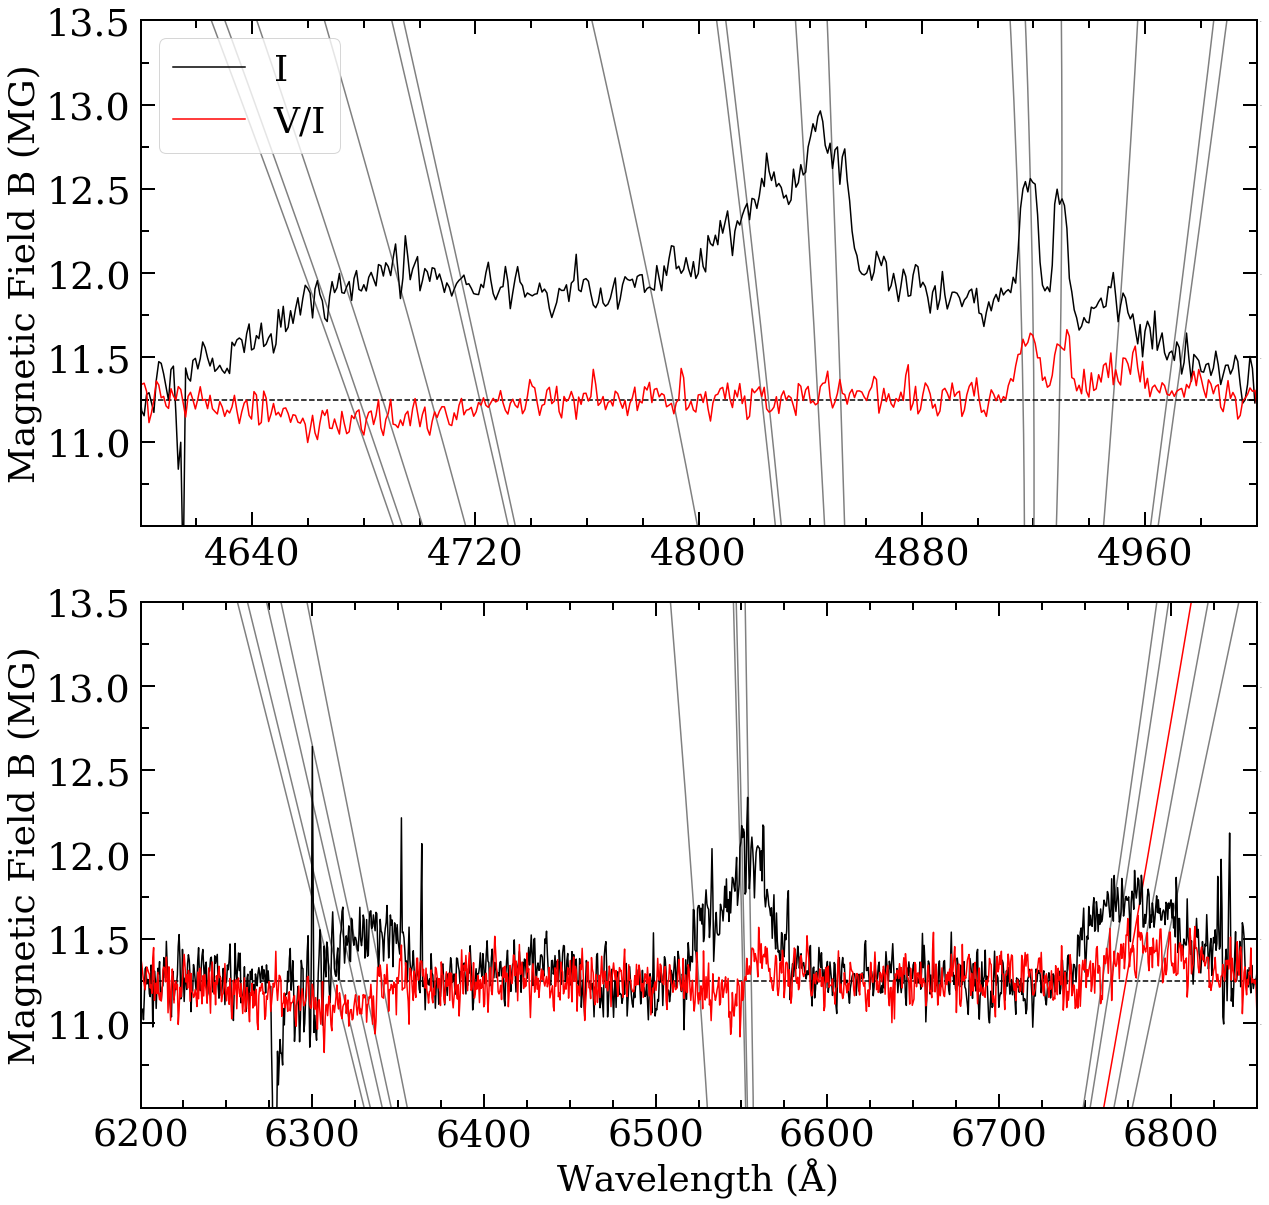

In [20]:
from pylab import *
from matplotlib import transforms
#rc('font',**{'family':'serif','serif':['Times']})
#rc('text', usetex=True)
rc('axes', linewidth=2)
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times']
#rc('font', weight=500)
#rc('axes', labelweight=1)
fig, axs = plt.subplots(2, 1,
                        gridspec_kw={'hspace': 0.15, 'wspace': 0}, figsize=(20,20))



axs[0].plot(WavelTra1,BFieldTra1, c='gray')
axs[0].plot(WavelTra2,BFieldTra2, c='gray')
axs[0].plot(WavelTra3,BFieldTra3, c='gray')
axs[0].plot(WavelTra4,BFieldTra4, c='gray')
axs[0].plot(WavelTra5,BFieldTra5, c='gray')
axs[0].plot(WavelTra6,BFieldTra6, c='gray')
axs[0].plot(WavelTra7,BFieldTra7, c='gray') # 2p1_4d1
axs[0].plot(WavelTra8,BFieldTra8, c='gray')
axs[0].plot(WavelTra9,BFieldTra9, c='gray')
axs[0].plot(WavelTra10,BFieldTra10, c='gray')
axs[0].plot(WavelTra11,BFieldTra11, c='gray')
axs[0].plot(WavelTra12,BFieldTra12, c='gray')
axs[0].plot(WavelTra13,BFieldTra13, c='gray')
axs[0].plot(WavelTra14,BFieldTra14, c='gray')
axs[0].plot(WavelTra15,BFieldTra15, c='gray')
axs[0].plot(WavelTra16,BFieldTra16, c='gray')
axs[0].plot(WavelTra17,BFieldTra17, c='gray')
axs[0].plot(wavelength,intensity*11.25,c='white')
axs[0].plot([4500,5000],[11.25,11.25],'k--')


axs[1].set_ylim(0,1)
axs[1].set_xlim(0,1)

axs[1].plot([6200,6850],[11.25,11.25],'k--')

axs[1].plot(WavelTraA1,BFieldTraA1, c='gray')
axs[1].plot(WavelTraA2,BFieldTraA2, c='gray')
axs[1].plot(WavelTraA3,BFieldTraA3, c='gray')
axs[1].plot(WavelTraA4,BFieldTraA4, c='gray')
axs[1].plot(WavelTraA5,BFieldTraA5, c='gray')
axs[1].plot(WavelTraA6,BFieldTraA6, c='gray')
axs[1].plot(WavelTraA7,BFieldTraA7, c='gray')
axs[1].plot(WavelTraA8,BFieldTraA8, c='gray')
axs[1].plot(WavelTraA10,BFieldTraA10, c='gray')
axs[1].plot(WavelTraA11,BFieldTraA11, c='gray')
axs[1].plot(WavelTraA12,BFieldTraA12, c='gray')
axs[1].plot(WavelTraA13,BFieldTraA13, c='gray')
axs[1].plot(WavelTraA14,BFieldTraA14, c='gray')
axs[1].plot(WavelTraA15,BFieldTraA15, c='gray')


ax3 = axs[1].twinx()
ax3.plot(wavelengthA,normedIntensity*11.25,c='k')
ax3.plot(wavelengthAA,(delCircPolA+1)*11.25,c='r')
axs[0].set_xlim(4600,5000)
axs[0].set_ylabel(r"Magnetic Field B (MG)", fontsize=36)
axs[1].set_ylabel(r"Magnetic Field B (MG)", fontsize=36)
axs[1].set_xlabel(r"Wavelength (Å)", fontsize=36)
#tick_params(labeltop=True, labelright=True)

axs[0].set_ylim(10.50000001,13.5)
axs[1].set_ylim(10.50000001,13.5)
axs[1].set_xlim(6200,6850)
ax2 = axs[0].twinx()
ax2.plot(wavelength,intensity*11.25,c='k',label='I')
ax2.plot(wavelength,(circPol*11.25)+11.25,c='r',label='V/I')
axs[0].xaxis.set_minor_locator(AutoMinorLocator())
axs[0].yaxis.set_minor_locator(AutoMinorLocator())
axs[1].xaxis.set_minor_locator(AutoMinorLocator())
axs[1].yaxis.set_minor_locator(AutoMinorLocator())
axs[0].tick_params(which='both', width=2,direction="in",pad=10)
axs[0].tick_params(which='major', length=14,direction="in")
axs[0].tick_params(labelsize=38)
axs[0].tick_params(which='minor', length=8)
axs[0].xaxis.set_ticks_position('both')

axs[1].tick_params(which='both', width=2,direction="in",pad=10)
axs[1].tick_params(which='major', length=14,direction="in")
axs[1].tick_params(labelsize=38)
axs[1].tick_params(which='minor', length=8)
axs[1].xaxis.set_ticks_position('both')
axs[1].yaxis.set_ticks_position('both')

ax2.legend(prop={'size': 36},loc='upper left')
#ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_major_locator(MultipleLocator(80))
ax2.yaxis.set_minor_locator(MultipleLocator(0.25))
ax3.xaxis.set_minor_locator(MultipleLocator(25))
ax3.yaxis.set_minor_locator(MultipleLocator(0.25))
axs[0].yaxis.set_minor_locator(MultipleLocator(0.25))
axs[1].yaxis.set_minor_locator(MultipleLocator(0.25))
#ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='both', width=2,direction="in")
ax2.tick_params(which='major', length=14,direction="in")
ax2.tick_params(which='minor', length=8,direction="in")
ax3.tick_params(which='both', width=2,direction="in")
ax3.tick_params(which='major', length=14,direction="in")
ax3.tick_params(which='minor', length=8,direction="in")
ax2.tick_params(labelsize=0)
ax3.tick_params(labelsize=0)
ax2.set_ylim(10.50000001,13.5)
ax2.set_xlim(4600,5000)
ax3.set_ylim(10.50000001,13.5)
ax3.set_xlim(6200,6850)
#ax2.text(4750,12.5,r'$2p_0\rightarrow4s_0$',rotation=280,fontsize=28)
#ax2.text(4807,12.8,r'$2p_1\rightarrow4d_1$',rotation=275,fontsize=28)
bboxx = transforms.Bbox([[0.62, 1.2], [18.04, 17.8]])
plt.savefig('HBetaTransitions.pdf', bbox_inches=bboxx ) 

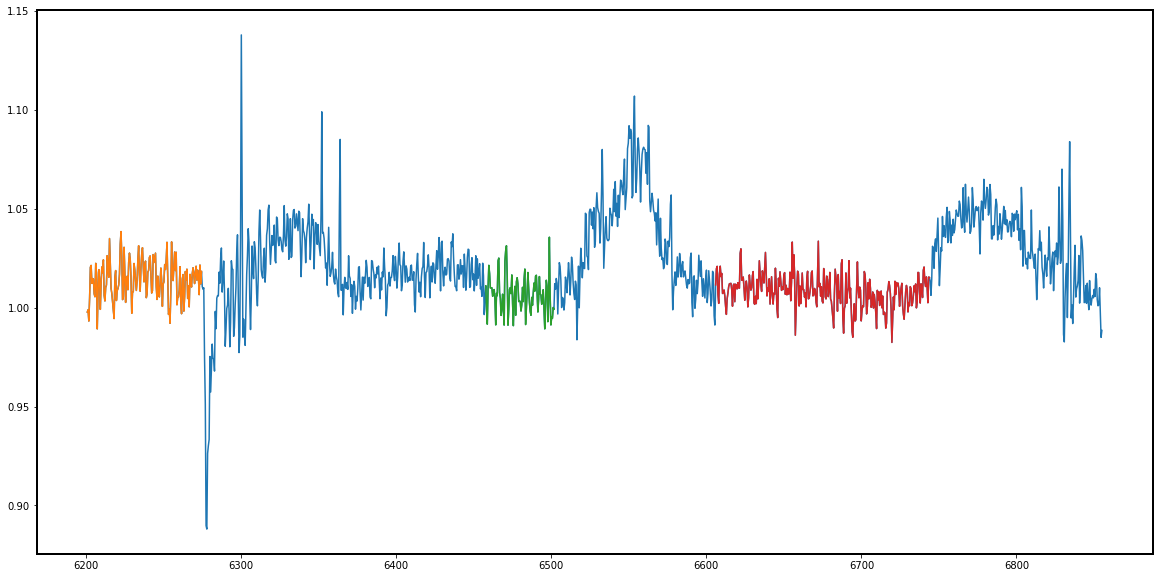

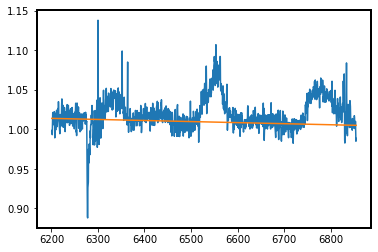

In [3]:
HRDF = pd.read_csv('forHR.tsv',sep='\t',header=None)

#'umag','sgmag','srmag','simag','szmag','prob','teff','logh','mass','teff2','logh2','mass2','rai','dei'
HRDF[10].replace('         ', np.nan, inplace=True)
HRDF[11].replace('         ', np.nan, inplace=True)
HRDF[12].replace('         ', np.nan, inplace=True)
HRDF[7].replace('         ', np.nan, inplace=True)
HRDF = HRDF[HRDF[10].notna()]
HRDF = HRDF[HRDF[11].notna()]
HRDF = HRDF[HRDF[12].notna()]
HRDF = HRDF[HRDF[7].notna()]
gmag = HRDF[10].to_numpy()
bpmag = HRDF[11].to_numpy()
rpmag = HRDF[12].to_numpy()
parallax = HRDF[7].to_numpy()
#JJTimes = (JJDF['Time'].to_numpy()/60/60/24)+2459076.6992445
#print(JJDF)

In [4]:
parallax

array([11.7166, 22.3553, 11.5969, ..., 12.3013, 10.2794, 10.1853])

In [5]:
gmag = gmag + 5*(np.log10(parallax/1000)+1)


In [7]:
wd1219GMAG = 17.561228 + 5*(np.log10(14.2774/1000)+1)
wd1252GMAG = 17.477457+ 5*(np.log10(12.9437/1000)+1)

gaiaAGMAG = 16.152+5*(np.log10(12.34/1000)+1)
gaiaBGMAG = 19.942+5*(np.log10(12.53/1000)+1)

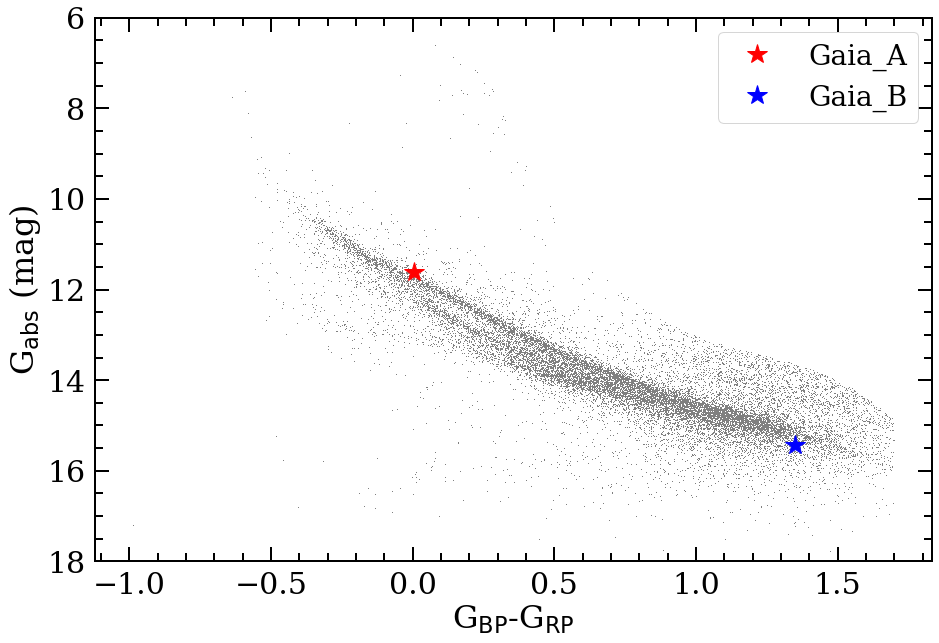

In [9]:
fig, axs = plt.subplots(1, 1,figsize=(15,10))
from pylab import *
rc('axes', linewidth=2)
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times']
axs.plot(bpmag-rpmag, gmag, marker=',',ls='',c='gray')
#axs.plot([0.388],[13.46],'b*',label='GD 356',ms=20)
#axs.plot([17.582787-17.189125], [wd1252GMAG], 'r*',label="J1252",ms=20)#WDJ125230.93-023417.72
#axs.plot([17.673635-17.231398],[wd1219GMAG],'g*', label="J1219",ms=20)#WDJ121929.50+471522.94

#axs.plot([0.287],[13.10],'k*',label='J0412',ms=20)#WDJ041246.85+754942.26
#axs.gca().invert_yaxis()


axs.plot([16.162-16.157], [gaiaAGMAG], 'r*',label="Gaia_A",ms=20)
axs.plot([20.59-19.24], [gaiaBGMAG], 'b*',label="Gaia_B",ms=20)

axs.legend(prop={'size': 28},loc='best')
axs.set_ylim(18,6)
axs.set_ylabel(r"G$_{\rm abs}$ (mag)", fontsize=32)
axs.set_xlabel(r"G$_{\rm BP}$-G$_{\rm RP}$", fontsize=32)

axs.xaxis.set_minor_locator(AutoMinorLocator())
axs.yaxis.set_minor_locator(AutoMinorLocator())
#axs.yaxis.set_major_locator(MultipleLocator(0.06))
axs.tick_params(axis='y',which='both', width=2,direction="in",pad=10)
axs.tick_params(axis='y',which='major', length=14,direction="in")
axs.tick_params(axis='x',which='both', width=2,direction='in')
axs.tick_params(axis='x',which='major', length=14,direction='in',pad=10)
axs.yaxis.set_major_locator(MultipleLocator(2))
axs.xaxis.set_major_locator(MultipleLocator(0.5))
axs.tick_params(axis='x',which='minor', length=8)
axs.tick_params(axis='y',which='minor', length=8,direction='in')
axs.tick_params(labelsize=30)
axs.yaxis.set_ticks_position('both')
axs.xaxis.set_ticks_position('both') 
    

bboxx = transforms.Bbox([[0.66, 0.24], [13.56, 8.98]])#285->288 #15.15->
plt.savefig('TripletHRD.pdf', bbox_inches=bboxx ) 

In [68]:
dHR = {'BPRP': bpmag-rpmag, 'GAbs': gmag}
df = pd.DataFrame(data=dHR)

In [69]:
df['BPRP']

0        0.788859
1        0.589187
2        0.546210
3        0.087549
4       -0.455994
           ...   
92873    1.057518
92874    1.444748
92875    0.981020
92876    1.251533
92877    0.422909
Name: BPRP, Length: 92878, dtype: float64

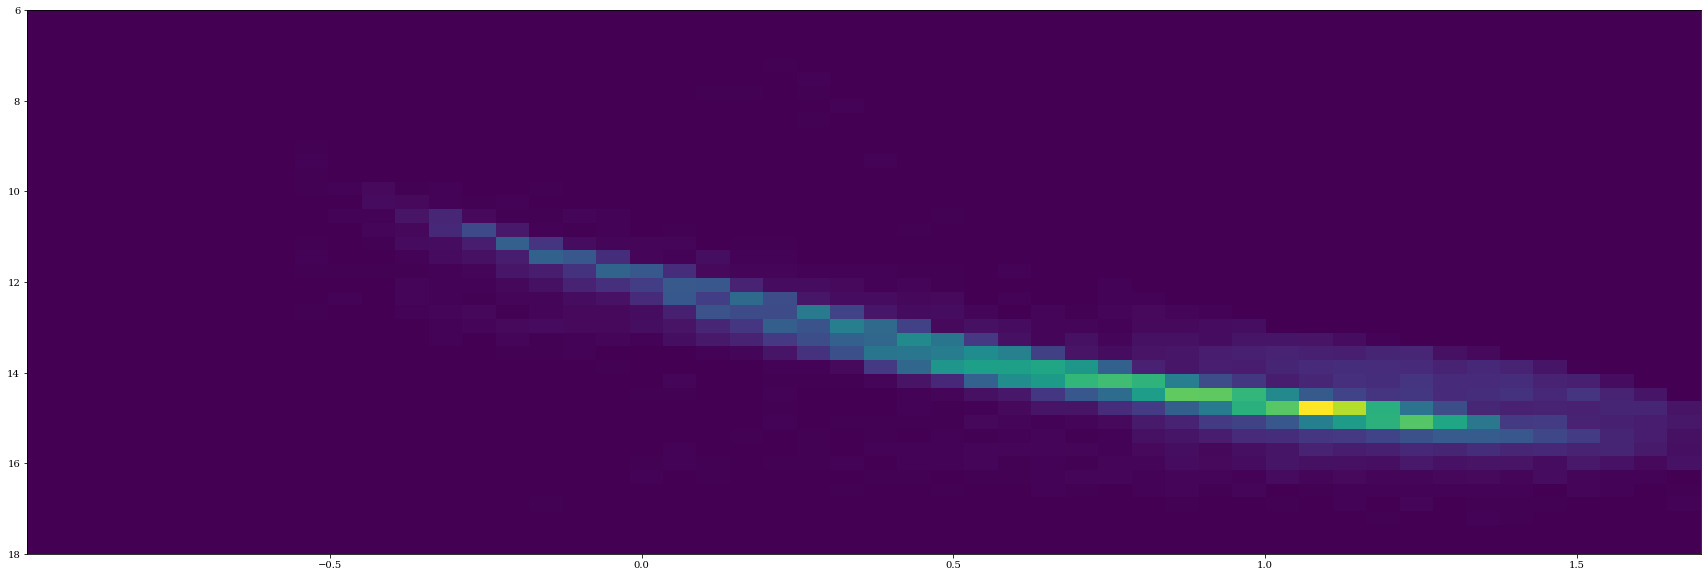

In [14]:
heatmap, xedges, yedges = np.histogram2d(bpmag-rpmag, gmag, bins=(50, 50))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.figure(figsize=(30,10))
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower', aspect='auto')
plt.ylim(18,6)
plt.show()

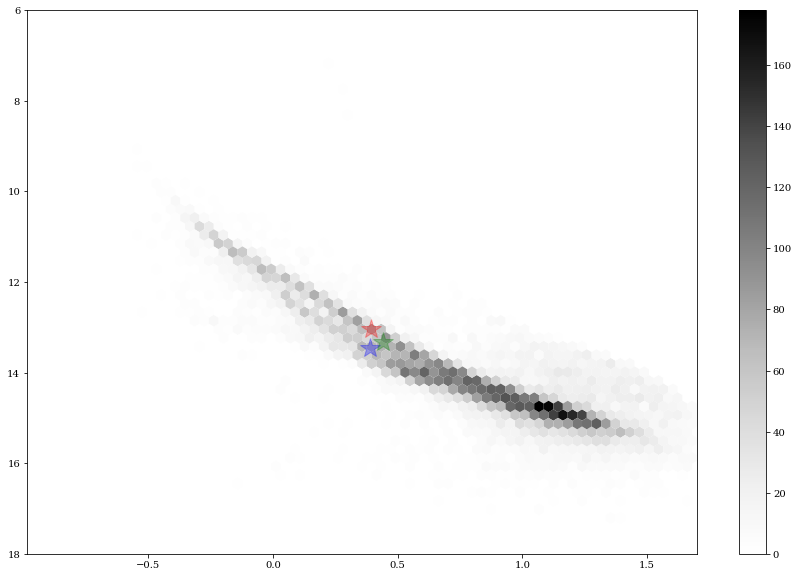

In [8]:
#normali = colors.Normalize(vmin=0, vmax=1, clip=False)
plt.figure(figsize=(15,10))
plt.hexbin(bpmag-rpmag, gmag, gridsize=70, cmap='Greys', edgecolors='none')
plt.plot([0.388],[13.46],'b*',label='GD 356',ms=20,alpha=0.3)
plt.plot([17.582787-17.189125], [wd1252GMAG], 'r*',label="J1252",ms=20,alpha=0.3)#WDJ125230.93-023417.72
plt.plot([17.673635-17.231398],[wd1219GMAG],'g*', label="J1219",ms=20,alpha=0.3)#WDJ121929.50+471522.94
plt.ylim(18,6)
plt.colorbar()

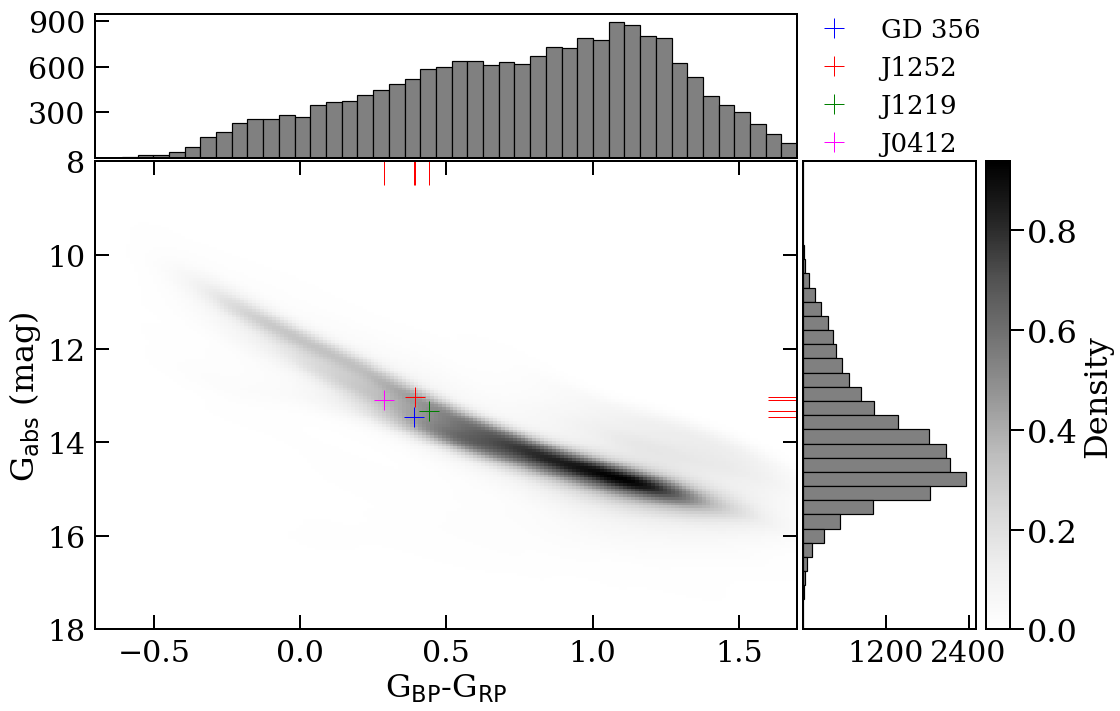

In [131]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
x = bpmag-rpmag
y = gmag
data = np.vstack([bpmag-rpmag, gmag])
kde = gaussian_kde(data)

xgrid = np.linspace(-1, 1.7, 200) #200
ygrid = np.linspace(18, 6, 200)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))


# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rc('axes', linewidth=2)
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]
fig = plt.figure(figsize=(15, 10))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)
mappa = ax_scatter.imshow(Z.reshape(Xgrid.shape),
                   origin='lower', aspect='auto',
                   extent=[-1, 1.7, 18, 6],
                   cmap='Greys')
ax_scatter.plot([0.388],[13.46],'b+',label='GD 356',ms=20)
ax_scatter.plot([17.582787-17.189125], [wd1252GMAG], 'r+',label="J1252",ms=20)#WDJ125230.93-023417.72
ax_scatter.plot([17.673635-17.231398],[wd1219GMAG],'g+', label="J1219",ms=20)#WDJ121929.50+471522.94
ax_scatter.plot([0.287],[13.10],marker='+', color='magenta',label='J0412',ms=20, linestyle='None')
ax_scatter.tick_params(axis='y',which='both', width=2,direction="in",pad=10)
ax_scatter.tick_params(axis='y',which='major', length=14,direction="in")
ax_scatter.tick_params(axis='x',which='both', width=2,direction='in')
ax_scatter.tick_params(axis='x',which='major', length=14,direction='in',pad=10)
binwidth = 0.25
lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
ax_scatter.set_xlim(-0.7,1.7)
ax_scatter.set_ylim(18,8)
ax_scatter.legend(prop={'size': 26},loc=[1,0.99],frameon=False)
bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(x, bins=50,color='grey',edgecolor='black', linewidth=1.2)
ax_histy.hist(y, bins=50, orientation='horizontal',color='grey',edgecolor='black', linewidth=1.2)
cbar = fig.colorbar(mappa) 
cbar.set_label('Density',size=32)
cbar.ax.tick_params(size = 14, width = 2)
cbar.ax.tick_params(labelsize=32)
ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())
ax_scatter.set_ylabel(r"G$_{\rm abs}$ (mag)", fontsize=32)
ax_scatter.set_xlabel(r"G$_{\rm BP}$-G$_{\rm RP}$", fontsize=32)
ax_scatter.tick_params(labelsize=30)
ax_histx.tick_params(labelsize=30)
ax_histy.tick_params(labelsize=30)
ax_histx.tick_params(axis='y',which='both', width=2,direction="in",pad=10)
ax_histx.tick_params(axis='y',which='major', length=14,direction="in")
ax_histx.tick_params(axis='x',which='both', width=0,direction='in')
ax_histx.tick_params(axis='x',which='major', length=14,direction='in',pad=10)
ax_histy.tick_params(axis='y',which='both', width=0,direction="in",pad=10)
ax_histy.tick_params(axis='y',which='major', length=14,direction="in")
ax_histy.tick_params(axis='x',which='both', width=2,direction='in')
ax_histy.set_xlim(1,2500)
ax_histx.set_ylim(1,950)
ax_histx.yaxis.set_major_locator(MultipleLocator(300))
ax_histy.xaxis.set_major_locator(MultipleLocator(1200))
ax_histy.tick_params(axis='x',which='major', length=14,direction='in',pad=10)
ax_scatter.errorbar([0.388, 17.582787-17.189125,17.673635-17.231398,0.287], [8,8,8,8],yerr=[0.5,0.5,0.5,0.5], c='r',lw=1)
ax_scatter.errorbar([1.7,1.7,1.7,1.7],[13.46,wd1252GMAG,wd1219GMAG,13.10],xerr=[0.1,0.1,0.1,0.1], c='r', lw=1)
bboxx = transforms.Bbox([[0.3, -0.05], [15.66, 9.62]])#285->288 #15.15->
plt.savefig('LargeBandWidth.pdf', bbox_inches=bboxx )

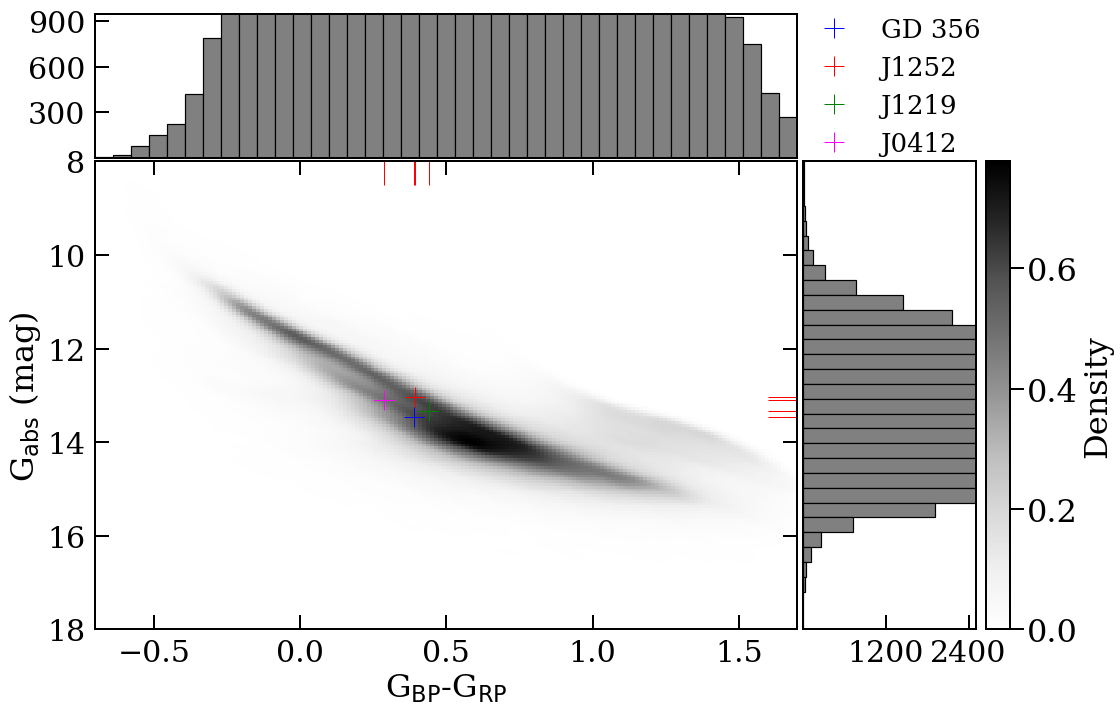

In [70]:

from mpl_toolkits.axes_grid1 import make_axes_locatable
x = bpmag-rpmag
y = gmag
data = np.vstack([bpmag-rpmag, gmag])
kde = gaussian_kde(data,bw_method=0.1)

xgrid = np.linspace(-1, 1.7, 200) #200
ygrid = np.linspace(18, 6, 200)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))


# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rc('axes', linewidth=2)
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]
fig = plt.figure(figsize=(15, 10))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)
mappa = ax_scatter.imshow(Z.reshape(Xgrid.shape),
                   origin='lower', aspect='auto',
                   extent=[-1, 1.7, 18, 6],
                   cmap='Greys')
ax_scatter.plot([0.388],[13.46],'b+',label='GD 356',ms=20)
ax_scatter.plot([17.582787-17.189125], [wd1252GMAG], 'r+',label="J1252",ms=20)#WDJ125230.93-023417.72
ax_scatter.plot([17.673635-17.231398],[wd1219GMAG],'g+', label="J1219",ms=20)#WDJ121929.50+471522.94
ax_scatter.plot([0.287],[13.10],marker='+', color='magenta',label='J0412',ms=20, linestyle='None')
ax_scatter.tick_params(axis='y',which='both', width=2,direction="in",pad=10)
ax_scatter.tick_params(axis='y',which='major', length=14,direction="in")
ax_scatter.tick_params(axis='x',which='both', width=2,direction='in')
ax_scatter.tick_params(axis='x',which='major', length=14,direction='in',pad=10)
binwidth = 0.25
lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
ax_scatter.set_xlim(-0.7,1.7)
ax_scatter.set_ylim(18,8)
ax_scatter.legend(prop={'size': 26},loc=[1,0.99],frameon=False)
bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(x, bins=50,color='grey',edgecolor='black', linewidth=1.2)
ax_histy.hist(y, bins=50, orientation='horizontal',color='grey',edgecolor='black', linewidth=1.2)
cbar = fig.colorbar(mappa) 
cbar.set_label('Density',size=32)
cbar.ax.tick_params(size = 14, width = 2)
cbar.ax.tick_params(labelsize=32)
ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())
ax_scatter.set_ylabel(r"G$_{\rm abs}$ (mag)", fontsize=32)
ax_scatter.set_xlabel(r"G$_{\rm BP}$-G$_{\rm RP}$", fontsize=32)
ax_scatter.tick_params(labelsize=30)
ax_histx.tick_params(labelsize=30)
ax_histy.tick_params(labelsize=30)
ax_histx.tick_params(axis='y',which='both', width=2,direction="in",pad=10)
ax_histx.tick_params(axis='y',which='major', length=14,direction="in")
ax_histx.tick_params(axis='x',which='both', width=0,direction='in')
ax_histx.tick_params(axis='x',which='major', length=14,direction='in',pad=10)
ax_histy.tick_params(axis='y',which='both', width=0,direction="in",pad=10)
ax_histy.tick_params(axis='y',which='major', length=14,direction="in")
ax_histy.tick_params(axis='x',which='both', width=2,direction='in')
ax_histy.set_xlim(1,2500)
ax_histx.set_ylim(1,950)
ax_histx.yaxis.set_major_locator(MultipleLocator(300))
ax_histy.xaxis.set_major_locator(MultipleLocator(1200))
ax_histy.tick_params(axis='x',which='major', length=14,direction='in',pad=10)
ax_scatter.errorbar([0.388, 17.582787-17.189125,17.673635-17.231398,0.287], [8,8,8,8],yerr=[0.5,0.5,0.5,0.5], c='r',lw=1)
ax_scatter.errorbar([1.7,1.7,1.7,1.7],[13.46,wd1252GMAG,wd1219GMAG,13.10],xerr=[0.1,0.1,0.1,0.1], c='r', lw=1)
bboxx = transforms.Bbox([[0.3, -0.05], [15.66, 9.62]])#285->288 #15.15->
plt.savefig('SmallBandWidth.pdf', bbox_inches=bboxx )

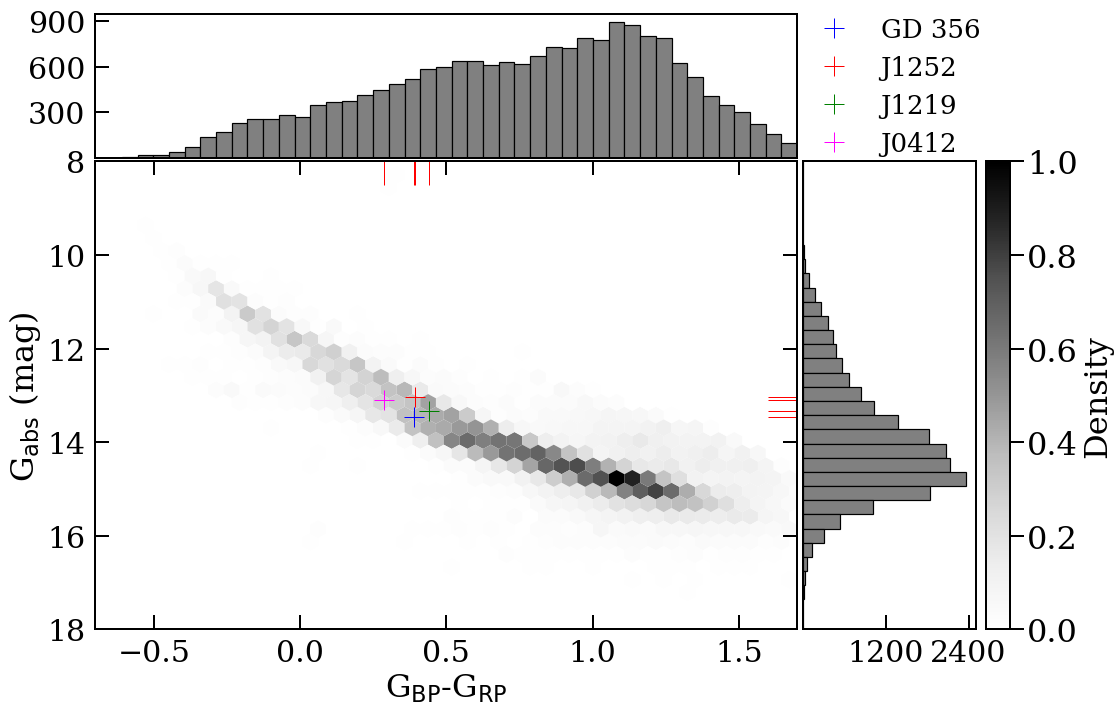

In [143]:

from mpl_toolkits.axes_grid1 import make_axes_locatable


# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rc('axes', linewidth=2)
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]
fig = plt.figure(figsize=(15, 10))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)
mappa = ax_scatter.hexbin(bpmag-rpmag, gmag, gridsize=50, cmap='Greys', edgecolors='none')
ax_scatter.plot([0.388],[13.46],'b+',label='GD 356',ms=20)
ax_scatter.plot([17.582787-17.189125], [wd1252GMAG], 'r+',label="J1252",ms=20)#WDJ125230.93-023417.72
ax_scatter.plot([17.673635-17.231398],[wd1219GMAG],'g+', label="J1219",ms=20)#WDJ121929.50+471522.94
ax_scatter.plot([0.287],[13.10],marker='+', color='magenta',label='J0412',ms=20, linestyle='None')
ax_scatter.tick_params(axis='y',which='both', width=2,direction="in",pad=10)
ax_scatter.tick_params(axis='y',which='major', length=14,direction="in")
ax_scatter.tick_params(axis='x',which='both', width=2,direction='in')
ax_scatter.tick_params(axis='x',which='major', length=14,direction='in',pad=10)
binwidth = 0.25
lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
ax_scatter.set_xlim(-0.7,1.7)
ax_scatter.set_ylim(18,8)
ax_scatter.legend(prop={'size': 26},loc=[1,0.99],frameon=False)
bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(x, bins=50,color='grey',edgecolor='black', linewidth=1.2)
ax_histy.hist(y, bins=50, orientation='horizontal',color='grey',edgecolor='black', linewidth=1.2)
cbar = fig.colorbar(mappa)#,ticks=[0.0, 0.2,0.4,0.6,0.8,1.0]) 
cbar.set_label('Density',size=32)
cbar.ax.tick_params(size = 14, width = 2)
cbar.ax.tick_params(labelsize=32)
cbar.set_ticks(np.linspace(mappa.get_array().min(), mappa.get_array().max(), 6))
cbar.set_ticklabels(np.round(np.linspace(0, 1., 6),decimals=1))
#cbar.ax.set_yticklabels(['0.0', '0.2','0.4','0.6','0.8','1.0'])
ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())
ax_scatter.set_ylabel(r"G$_{\rm abs}$ (mag)", fontsize=32)
ax_scatter.set_xlabel(r"G$_{\rm BP}$-G$_{\rm RP}$", fontsize=32)
ax_scatter.tick_params(labelsize=30)
ax_histx.tick_params(labelsize=30)
ax_histy.tick_params(labelsize=30)
ax_histx.tick_params(axis='y',which='both', width=2,direction="in",pad=10)
ax_histx.tick_params(axis='y',which='major', length=14,direction="in")
ax_histx.tick_params(axis='x',which='both', width=0,direction='in')
ax_histx.tick_params(axis='x',which='major', length=14,direction='in',pad=10)
ax_histy.tick_params(axis='y',which='both', width=0,direction="in",pad=10)
ax_histy.tick_params(axis='y',which='major', length=14,direction="in")
ax_histy.tick_params(axis='x',which='both', width=2,direction='in')
ax_histy.set_xlim(1,2500)
ax_histx.set_ylim(1,950)
ax_histx.yaxis.set_major_locator(MultipleLocator(300))
ax_histy.xaxis.set_major_locator(MultipleLocator(1200))
ax_histy.tick_params(axis='x',which='major', length=14,direction='in',pad=10)
ax_scatter.errorbar([0.388, 17.582787-17.189125,17.673635-17.231398,0.287], [8,8,8,8],yerr=[0.5,0.5,0.5,0.5], c='r',lw=1)
ax_scatter.errorbar([1.7,1.7,1.7,1.7],[13.46,wd1252GMAG,wd1219GMAG,13.10],xerr=[0.1,0.1,0.1,0.1], c='r', lw=1)
bboxx = transforms.Bbox([[0.3, -0.05], [15.66, 9.62]])#285->288 #15.15->
plt.savefig('HexesSameasHist.pdf', bbox_inches=bboxx )

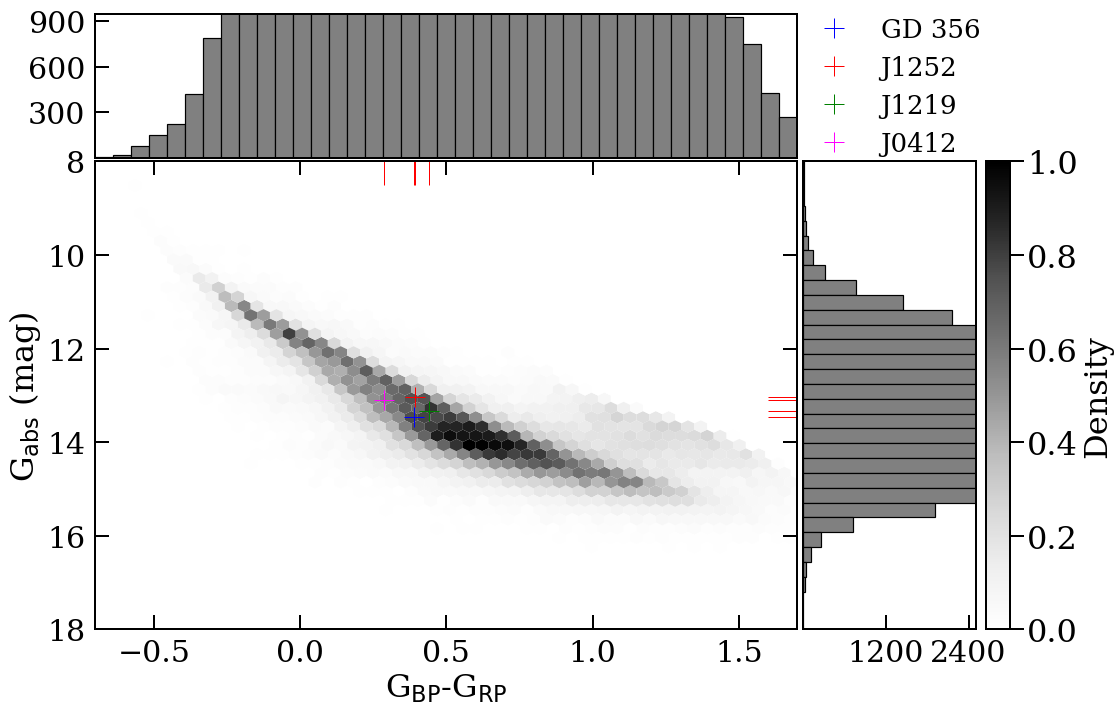

In [71]:

from mpl_toolkits.axes_grid1 import make_axes_locatable


# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rc('axes', linewidth=2)
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]
fig = plt.figure(figsize=(15, 10))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)
mappa = ax_scatter.hexbin(bpmag-rpmag, gmag, gridsize=70, cmap='Greys', edgecolors='none')
ax_scatter.plot([0.388],[13.46],'b+',label='GD 356',ms=20)
ax_scatter.plot([17.582787-17.189125], [wd1252GMAG], 'r+',label="J1252",ms=20)#WDJ125230.93-023417.72
ax_scatter.plot([17.673635-17.231398],[wd1219GMAG],'g+', label="J1219",ms=20)#WDJ121929.50+471522.94
ax_scatter.plot([0.287],[13.10],marker='+', color='magenta',label='J0412',ms=20, linestyle='None')
ax_scatter.tick_params(axis='y',which='both', width=2,direction="in",pad=10)
ax_scatter.tick_params(axis='y',which='major', length=14,direction="in")
ax_scatter.tick_params(axis='x',which='both', width=2,direction='in')
ax_scatter.tick_params(axis='x',which='major', length=14,direction='in',pad=10)
binwidth = 0.25
lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
ax_scatter.set_xlim(-0.7,1.7)
ax_scatter.set_ylim(18,8)
ax_scatter.legend(prop={'size': 26},loc=[1,0.99],frameon=False)
bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(x, bins=50,color='grey',edgecolor='black', linewidth=1.2)
ax_histy.hist(y, bins=50, orientation='horizontal',color='grey',edgecolor='black', linewidth=1.2)
cbar = fig.colorbar(mappa)#,ticks=[0.0, 0.2,0.4,0.6,0.8,1.0]) 
cbar.set_label('Density',size=32)
cbar.ax.tick_params(size = 14, width = 2)
cbar.ax.tick_params(labelsize=32)
cbar.set_ticks(np.linspace(mappa.get_array().min(), mappa.get_array().max(), 6))
cbar.set_ticklabels(np.round(np.linspace(0, 1., 6),decimals=1))
#cbar.ax.set_yticklabels(['0.0', '0.2','0.4','0.6','0.8','1.0'])
ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())
ax_scatter.set_ylabel(r"G$_{\rm abs}$ (mag)", fontsize=32)
ax_scatter.set_xlabel(r"G$_{\rm BP}$-G$_{\rm RP}$", fontsize=32)
ax_scatter.tick_params(labelsize=30)
ax_histx.tick_params(labelsize=30)
ax_histy.tick_params(labelsize=30)
ax_histx.tick_params(axis='y',which='both', width=2,direction="in",pad=10)
ax_histx.tick_params(axis='y',which='major', length=14,direction="in")
ax_histx.tick_params(axis='x',which='both', width=0,direction='in')
ax_histx.tick_params(axis='x',which='major', length=14,direction='in',pad=10)
ax_histy.tick_params(axis='y',which='both', width=0,direction="in",pad=10)
ax_histy.tick_params(axis='y',which='major', length=14,direction="in")
ax_histy.tick_params(axis='x',which='both', width=2,direction='in')
ax_histy.set_xlim(1,2500)
ax_histx.set_ylim(1,950)
ax_histx.yaxis.set_major_locator(MultipleLocator(300))
ax_histy.xaxis.set_major_locator(MultipleLocator(1200))
ax_histy.tick_params(axis='x',which='major', length=14,direction='in',pad=10)
ax_scatter.errorbar([0.388, 17.582787-17.189125,17.673635-17.231398,0.287], [8,8,8,8],yerr=[0.5,0.5,0.5,0.5], c='r',lw=1)
ax_scatter.errorbar([1.7,1.7,1.7,1.7],[13.46,wd1252GMAG,wd1219GMAG,13.10],xerr=[0.1,0.1,0.1,0.1], c='r', lw=1)
bboxx = transforms.Bbox([[0.3, -0.05], [15.66, 9.62]])#285->288 #15.15->
plt.savefig('HexesSmaller.pdf', bbox_inches=bboxx )

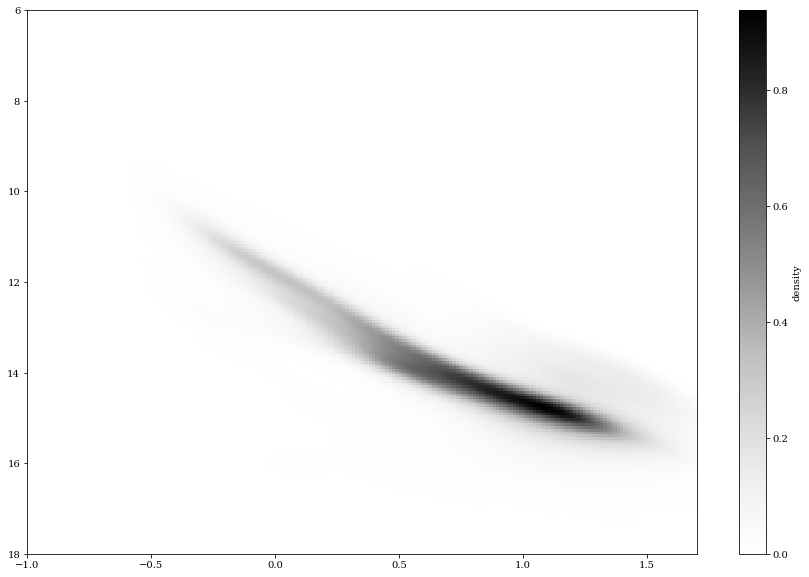

In [47]:


data = np.vstack([bpmag-rpmag, gmag])
kde = gaussian_kde(data)

xgrid = np.linspace(-1, 1.7, 200)
ygrid = np.linspace(18, 6, 200)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))
plt.figure(figsize=(15,10))
plt.imshow(Z.reshape(Xgrid.shape),
                   origin='lower', aspect='auto',
                   extent=[-1, 1.7, 18, 6],
                   cmap='Greys')
cb = plt.colorbar()
cb.set_label("density")

D:\conda\lib\site-packages\seaborn\distributions.py:693: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


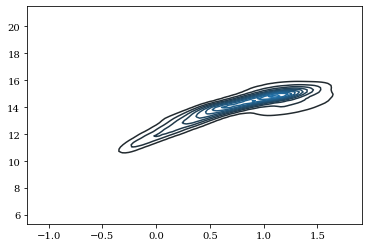

In [51]:
import seaborn as sns
data = pd.DataFrame({'x':bpmag-rpmag, 'y':gmag})
sns.kdeplot(data)

In [63]:
specialDat =  pd.DataFrame({'xx':[0.388,17.582787-17.189125,17.673635-17.231398], 'yy':[13.46,wd1252GMAG,wd1219GMAG]})

In [78]:
specialDat

xx         yy
0  0.388000  13.460000
1  0.393662  13.037749
2  0.442237  13.334474

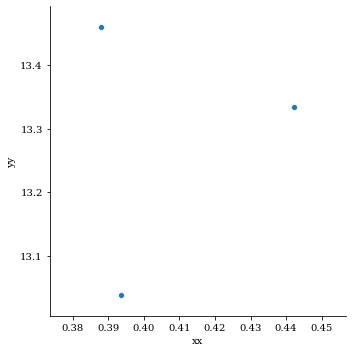

In [87]:
sns.relplot(data=specialDat, x="xx", y="yy")

TypeError: inner() got multiple values for argument 'ax'

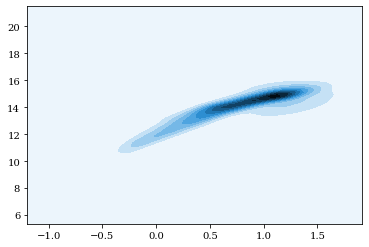

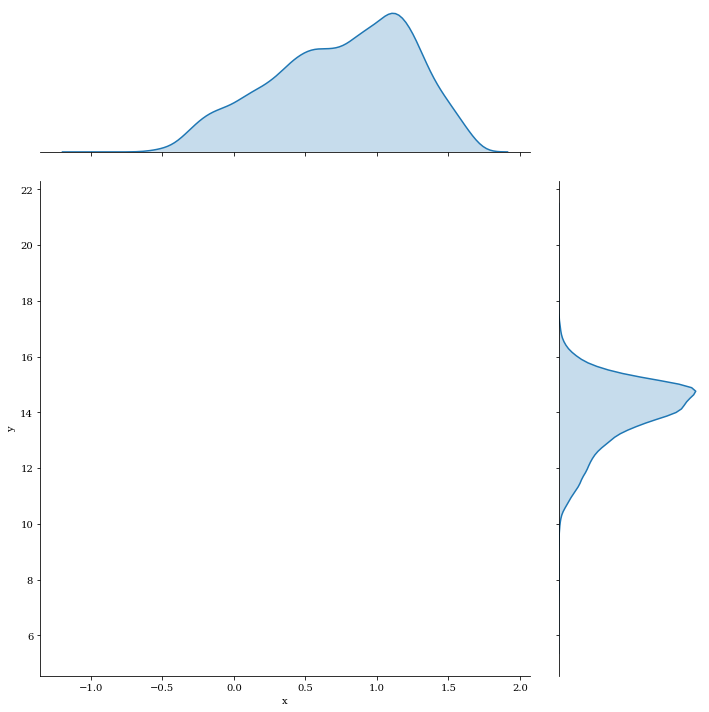

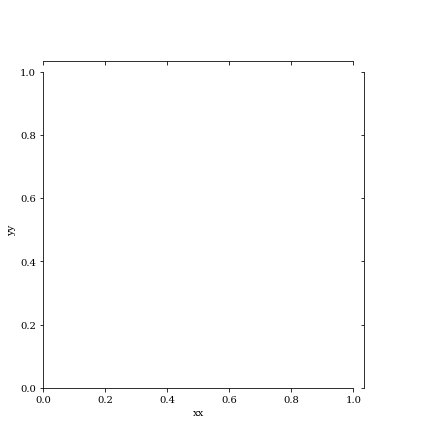

In [92]:
fig, ax = plt.subplots()
sns.jointplot("x", "y", data, kind='kde', height=10, ratio=3, ax=ax)
sns.jointplot(data=specialDat, x="xx", y="yy", ax=ax)

In [96]:

df2 = df[df['BPRP'].between(0.287, 0.442237)]
df2
#df2 = df[~(df['BPRP'] <= (17.673635-17.231398))]  
#print(df)
#df3 = df2[df2['BPRP'] >= 0.287]  
#df3

BPRP       GAbs
12     0.372692  13.727935
29     0.332261  13.907157
32     0.354792  13.195900
55     0.401517  13.905140
57     0.418685  13.066167
...         ...        ...
18656  0.333023  12.187392
18731  0.381880  15.840349
18774  0.417536  16.166746
18798  0.360409  14.226593
18811  0.424294  13.219575

[1502 rows x 2 columns]

In [97]:
wd1252GMAG

13.037749193059765

In [98]:
df3 = df2[df2['GAbs'].between(13.037749193059765, 13.46)]
df3

BPRP       GAbs
32     0.354792  13.195900
57     0.418685  13.066167
160    0.309935  13.230638
189    0.398519  13.240232
328    0.403471  13.393000
...         ...        ...
15599  0.413248  13.192680
15619  0.292726  13.147863
15641  0.314062  13.070849
15828  0.337124  13.291490
18811  0.424294  13.219575

[517 rows x 2 columns]

In [103]:
(517/18818)

0.02747369539802317

In [ ]:
x < 17.673635-17.231398
x > 0.287
y > wd1252GMAG
y < 13.46

In [23]:
indata = np.loadtxt("Profiles_008.dat", usecols=(0,1,2,3,4,5))
wavelength = indata[:,0]
intensity = indata[:,3]
errorGuess = indata[:,4]
indata = np.loadtxt("Ferrario.dat", usecols=(0,1))
wavelengthF = indata[:,0]
intensityF = indata[:,1]

(-0.025, 0.025)

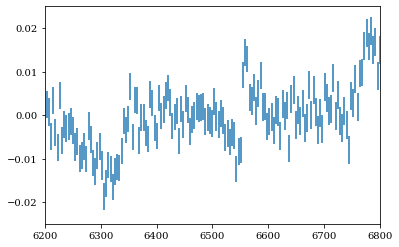

In [20]:
plt.errorbar(wavelength,intensity,yerr=errorGuess,ls='')
plt.xlim(6200,6800)
plt.ylim(-0.025,0.025)

In [21]:
count = 1
meanWave = []
meanV = []
meanErr = []
for i in range(len(np.array(wavelength))):
    if count % 4 == 0:
        meanWave.append(np.mean(wavelength[count-4:count]))
        meanV.append(np.mean(intensity[count-4:count]))
        meanErr.append(np.mean(errorGuess[count-4:count])/2)
        count = count +1
    else:
        count = count +1 

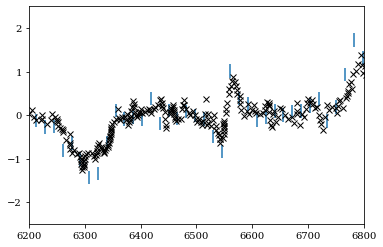

In [31]:
plt.errorbar(meanWave,100*np.array(meanV),yerr=np.array(meanErr)*100,ls='')
plt.xlim(6200,6800)
plt.ylim(-2.5,2.5)
plt.plot(wavelengthF,-intensityF, 'kx')

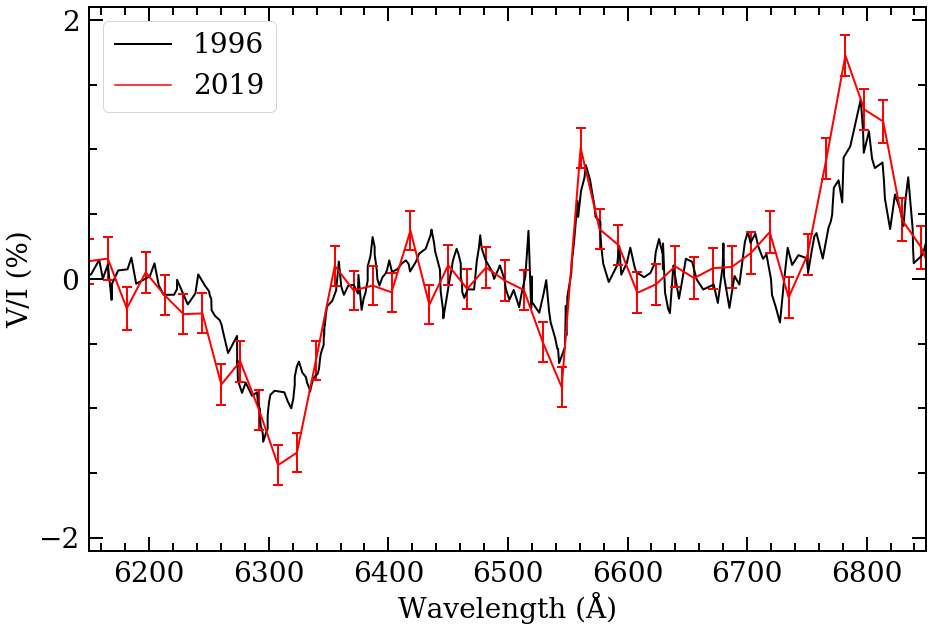

In [80]:
fig, axs = plt.subplots(1, 1,figsize=(15,10))
from pylab import *
rc('axes', linewidth=2)
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times']
axs.plot(wavelengthF,-intensityF,ls='-',c='k', label=r'1996',linewidth=2)
axs.errorbar(meanWave,100*np.array(meanV),yerr=np.array(meanErr)*100, c='r',capsize=5,linewidth=2,elinewidth=2,markeredgewidth=2)

xlimits = axs.set_xlim()
axs.plot([-0.03,-0.03],[0,0],c='r', label = '2019')
axs.set_xlim(xlimits)


axs.legend(prop={'size': 28},loc='best')
axs.set_ylim(-2.1,2.1)
axs.set_xlim(6150,6850)
axs.set_ylabel(r"V/I (%)", fontsize=28)
axs.set_xlabel(r"Wavelength (Å)", fontsize=28)


axs.xaxis.set_minor_locator(MultipleLocator(20))
axs.yaxis.set_minor_locator(MultipleLocator(0.5))
#axs.yaxis.set_major_locator(MultipleLocator(0.06))
axs.tick_params(axis='y',which='both', width=2,direction="in",pad=10)
axs.tick_params(axis='y',which='major', length=14,direction="in")
axs.tick_params(axis='x',which='both', width=2,direction='in')
axs.tick_params(axis='x',which='major', length=14,direction='in',pad=10)
axs.yaxis.set_major_locator(MultipleLocator(2))
axs.xaxis.set_major_locator(MultipleLocator(100))
axs.tick_params(axis='x',which='minor', length=8)
axs.tick_params(axis='y',which='minor', length=8,direction='in')
axs.tick_params(labelsize=28)
axs.yaxis.set_ticks_position('both')
axs.xaxis.set_ticks_position('both') 
    

bboxx = transforms.Bbox([[0.72, 0.22], [13.54, 8.84]])#285->288 #15.15->
plt.savefig('Fig_V_Comparison.pdf', bbox_inches=bboxx ) 

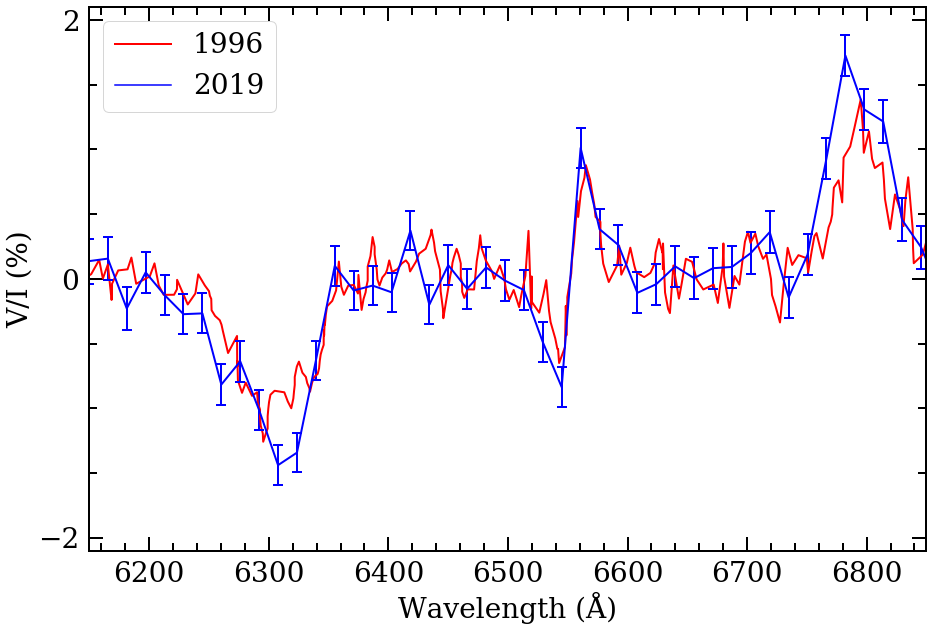

In [83]:
fig, axs = plt.subplots(1, 1,figsize=(15,10))
from pylab import *
rc('axes', linewidth=2)
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times']
axs.plot(wavelengthF,-intensityF,ls='-',c='r', label=r'1996',linewidth=2)
axs.errorbar(meanWave,100*np.array(meanV),yerr=np.array(meanErr)*100, c='b',capsize=5,linewidth=2,elinewidth=2,markeredgewidth=2)

xlimits = axs.set_xlim()
axs.plot([-0.03,-0.03],[0,0],c='b', label = '2019')
axs.set_xlim(xlimits)


axs.legend(prop={'size': 28},loc='best')
axs.set_ylim(-2.1,2.1)
axs.set_xlim(6150,6850)
axs.set_ylabel(r"V/I (%)", fontsize=28)
axs.set_xlabel(r"Wavelength (Å)", fontsize=28)


axs.xaxis.set_minor_locator(MultipleLocator(20))
axs.yaxis.set_minor_locator(MultipleLocator(0.5))
#axs.yaxis.set_major_locator(MultipleLocator(0.06))
axs.tick_params(axis='y',which='both', width=2,direction="in",pad=10)
axs.tick_params(axis='y',which='major', length=14,direction="in")
axs.tick_params(axis='x',which='both', width=2,direction='in')
axs.tick_params(axis='x',which='major', length=14,direction='in',pad=10)
axs.yaxis.set_major_locator(MultipleLocator(2))
axs.xaxis.set_major_locator(MultipleLocator(100))
axs.tick_params(axis='x',which='minor', length=8)
axs.tick_params(axis='y',which='minor', length=8,direction='in')
axs.tick_params(labelsize=28)
axs.yaxis.set_ticks_position('both')
axs.xaxis.set_ticks_position('both') 
    

bboxx = transforms.Bbox([[0.72, 0.22], [13.54, 8.84]])#285->288 #15.15->
plt.savefig('Fig_V_ComparisonB.pdf', bbox_inches=bboxx ) 

In [55]:
HRDF = pd.read_csv('forHR.tsv',sep='\t',header=None)

#'umag','sgmag','srmag','simag','szmag','prob','teff','logh','mass','teff2','logh2','mass2','rai','dei'
HRDF[10].replace('         ', np.nan, inplace=True)
HRDF[11].replace('         ', np.nan, inplace=True)
HRDF[12].replace('         ', np.nan, inplace=True)
HRDF[7].replace('         ', np.nan, inplace=True)
HRDF[20].replace('             ', np.nan, inplace=True)
HRDF = HRDF[HRDF[10].notna()]
HRDF = HRDF[HRDF[11].notna()]
HRDF = HRDF[HRDF[12].notna()]
HRDF = HRDF[HRDF[7].notna()]
HRDF = HRDF[HRDF[20].notna()]
gmag = HRDF[10].to_numpy()
bpmag = HRDF[11].to_numpy()
rpmag = HRDF[12].to_numpy()
parallax = HRDF[7].to_numpy()
teff = HRDF[20].to_numpy()
teff = teff.astype(np.float)
#JJTimes = (JJDF['Time'].to_numpy()/60/60/24)+2459076.6992445
#print(JJDF)



#https://gea.esac.esa.int/archive/documentation/GDR2/Data_analysis/chap_cu8par/sec_cu8par_process/ssec_cu8par_process_flame.html

In [56]:
corrections = []
for el in teff:
    if el < 4000:
        aArray = [1.749,0.001977,0.0000003737,-0.00000000008966,-0.00000000000004183]
        corrected = (aArray[0])+(aArray[1]*(el-5800))+(aArray[2]*(el-5800)**2)+(aArray[3]*(el-5800)**3)+(aArray[4]*(el-5800)**4)
        corrections.append(corrected)
    else:
        aArray = [0.06,0.00006731,-0.00000006647,0.00000000002859,-0.000000000000007197]
        corrected = (aArray[0])+(aArray[1]*(el-5800))+(aArray[2]*(el-5800)**2)+(aArray[3]*(el-5800)**3)+(aArray[4]*(el-5800)**4)
        corrections.append(corrected)

In [57]:
gmagUp = gmag + 5*(np.log10(parallax/1000)+1)

In [58]:
luminosity = ((gmagUp + corrections - 4.74)/(-2.5))

In [47]:
luminosity

array([994.47590898,  -4.05345005,  -3.78710737, ...,  -4.06358406,
        -3.68545006,  -3.84603394])

In [59]:
#gd 356 teff=7560    G=14.9808
#reding teff=8237  G=17.477457
#tremblay teff = 8582   G=15.831387
#boris teff=7500    G=17.561228
teffSpecial = [7560,8237,8582,7500]
gmagSpecial = [14.9808,17.477457,15.831387,17.561228]
parallaxSpecial = [49.6515,12.9437,28.4839,14.277398380972409]

In [60]:
correctionsSpecial = []
for el in teffSpecial:
    if el < 4000:
        aArray = [1.749,0.001977,0.0000003737,-0.00000000008966,-0.00000000000004183]
        corrected = (aArray[0])+(aArray[1]*(el-5800))+(aArray[2]*(el-5800)**2)+(aArray[3]*(el-5800)**3)+(aArray[4]*(el-5800)**4)
        correctionsSpecial.append(corrected)
    else:
        aArray = [0.06,0.00006731,-0.00000006647,0.00000000002859,-0.000000000000007197]
        corrected = (aArray[0])+(aArray[1]*(el-5800))+(aArray[2]*(el-5800)**2)+(aArray[3]*(el-5800)**3)+(aArray[4]*(el-5800)**4)
        correctionsSpecial.append(corrected)
        
gmagSpecial = gmagSpecial + 5*(np.log10(np.array(parallaxSpecial)/1000)+1)
luminositySpecial = ((gmagSpecial + correctionsSpecial - 4.74)/(-2.5))

(8600, 3300)

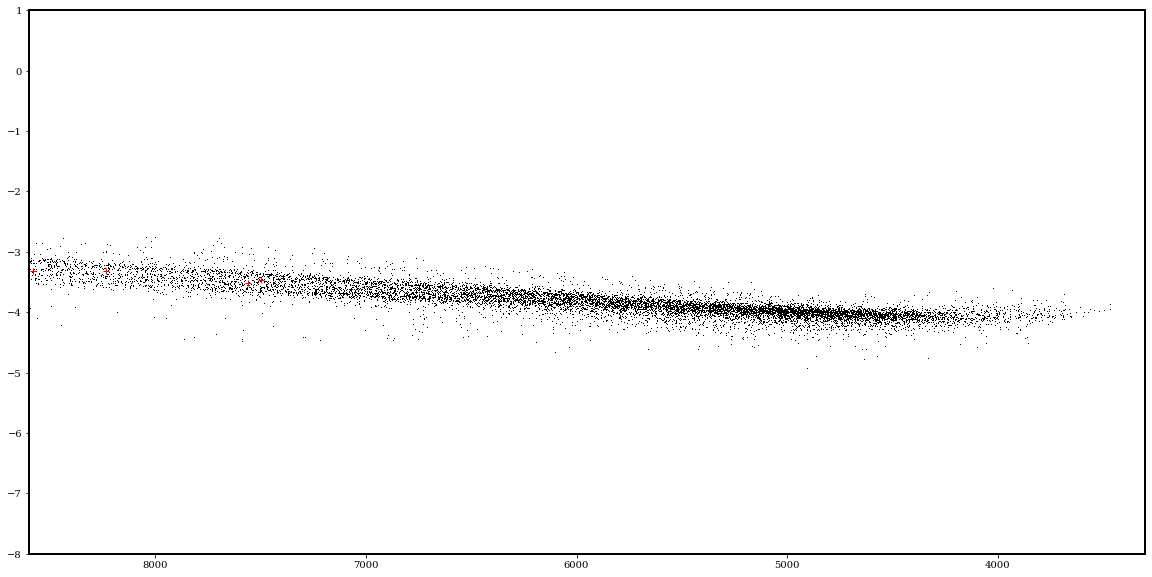

In [62]:
plt.figure(figsize=(20,10))
plt.plot(teff,luminosity,'k,')
plt.plot(teffSpecial, luminositySpecial, 'r+')
plt.ylim(-8,1)
plt.xlim(8600,3300)

In [17]:
np.log10(12) 

1.0791812460476249

In [18]:
10**1.0791812460476249

12.000000000000002